In [1]:
%matplotlib inline
import numpy as np
import sklearn
import pandas as pd
from PIL import Image
from matplotlib import pyplot as plt
import matplotlib
import torchvision
import torch
import os
import random
from tqdm import tqdm
from sklearn.metrics import roc_auc_score, roc_curve, plot_roc_curve, auc, accuracy_score, f1_score
from sklearn.model_selection import train_test_split
from collections import defaultdict
from pathlib import Path
import gc
import pickle
import torch.utils.data as data_utils
from torch.utils.data import DataLoader
import seaborn as sns
sns.set()

from joblib import Parallel, delayed
import time


matplotlib.style.use('ggplot')

In [17]:
def stratified_sample(y, p=0.67, replace=False, seed=1234):
    unique_y, counts = np.unique(y, return_counts=True)
    n_per_class = np.array([int(np.math.floor(p*c)) for c in counts])
    n_per_class = np.array([max([npc, 1]) for npc in n_per_class])
    np.random.seed(seed)
    
    inds = [np.random.choice(np.where(y == unique_y[i])[0], size=npc, replace=replace) for i, npc in enumerate(n_per_class)]
    
    return np.concatenate(inds)

def split_data(df, p=0.67):
    '''
    Splits dataframe into two dataframes using p value as a proportion. 
    Make sure that all classes are present.
    
    Parameters:
    df: pandas DataFrame, a dataframe to split that has a 'label' column
    p: float, a proprotion in which the dataframe should be splitted
    
    Returns:
    df_1: pandas DataFrame, a dataframe with the first portion of data that is equivalent to p value
    df_2: pandas DataFrame, rest of the data
    
    '''
    main_label_list = df['label'].tolist()
    ind_list = stratified_sample(main_label_list, p)
    df_1 = df[df.index.isin(ind_list)].sample(frac=1).reset_index(drop=True)
    df_2 = df[~df.index.isin(ind_list)].sample(frac=1).reset_index(drop=True)
    
    return df_1, df_2

class IconDataset(torch.utils.data.Dataset):
    def __init__(self, df, transform, data_root, run, noise_str):
        self.class_names = df['class'].unique().tolist()
        self.image_dir = data_root
        self.transform = transform
        self.total = len(df)
        self.image_names = df['image_path'].to_list()
        self.labels = df['label'].to_numpy() if noise_str=='00' else df['%s_%s' %(noise_str, run)].to_numpy()
        self.targets = self.labels
                    
    def __len__(self):
        return self.total
    
    def __getitem__(self, idx):
        image_name = self.image_names[idx]
        image_path = os.path.join(self.image_dir, image_name)
        image = self.transform(Image.open(image_path).convert('RGB'))
        label = self.labels[idx]
        target = self.labels[idx]
        return image, label

    
image_size = (128, 128)
resnet_mean = [0.485, 0.456, 0.406]
resnet_std = [0.229, 0.224, 0.225]

#Creating a Transformation Object
train_transform = torchvision.transforms.Compose([
    #Converting images to the size that the model expects
    torchvision.transforms.Resize(size=image_size),
    torchvision.transforms.RandomHorizontalFlip(), #A RandomHorizontalFlip to augment our data
    torchvision.transforms.ToTensor(), #Converting to tensor
    #Normalizing the data to the data that the ResNet18 was trained on
    torchvision.transforms.Normalize(mean = resnet_mean ,
                                    std = resnet_std) 
    
])


#Creating a Transformation Object
test_transform = torchvision.transforms.Compose([
    #Converting images to the size that the model expects
    torchvision.transforms.Resize(size=image_size),
    # We don't do data augmentation in the test/val set    
    torchvision.transforms.ToTensor(), #Converting to tensor
    torchvision.transforms.Normalize(mean = resnet_mean,
                                    std = resnet_std) 
    
])

#build model using Resnext50 as backbone
class Resnext50(torch.nn.Module):
    def __init__(self, n_classes, name):
        super().__init__()
        self.name = name
        resnet = torchvision.models.resnext50_32x4d(pretrained=True, progress=True)
        resnet.fc = torch.nn.Sequential(
            torch.nn.Dropout(p=0.2),
            torch.nn.Linear(in_features=resnet.fc.in_features, out_features=n_classes)
        )
        self.base_model = resnet
        self.soft = torch.nn.Softmax(dim=1)

    def forward(self, x):
        return self.soft(self.base_model(x))

def train_loop(dataloader, model, loss_fn, optimizer, mode="flat", lookup=[], fine_to_coarse={}, 
               batch_size=64):
    size = len(dataloader.dataset)
    model.train()
    train_loss = 0
    counter = 0
    with tqdm(dataloader, unit="batch") as tepoch:
        for X_cpu, y_cpu in tepoch:
            counter += 1
            if mode == "fine":
                y_cpu = torch.tensor([lookup.index(i) for i in y_cpu])
            elif mode == "coarse":
                y_cpu = torch.tensor([fine_to_coarse[int(target)] for target in y_cpu])
            X, y = X_cpu.to(device), y_cpu.to(device)
            optimizer.zero_grad()
            outputs = model(X)
            loss = loss_fn(outputs, y.type(torch.long))
            loss.backward() 
            optimizer.step() 
            train_loss += loss.item() 
            avg_loss = train_loss / counter
            tepoch.set_postfix(loss=avg_loss)
    return avg_loss
    
    
def eval_model(dataloader, model, loss_fn, mode="flat", lookup=[], fine_to_coarse={}, 
               return_probab=False, batch_size=64):
    model.eval()
    predicts = []
    targets = []
    val_running_loss = 0.0
    
    for counter, (images, labels) in enumerate(dataloader):
        if mode == "fine":
            labels = torch.tensor([lookup.index(i) for i in labels])
        elif mode == "coarse":
            labels = torch.tensor([fine_to_coarse[int(i)] for i in labels])
        else:
            labels = torch.tensor(labels)
        imageGPU = images.to(device)
        
        outputs = torch.Tensor.cpu(model(imageGPU))
        loss = loss_fn(outputs, labels.type(torch.long))
        val_running_loss += loss.item()
        predicts.append(outputs.detach().numpy())
        targets.append(labels)
    val_loss = val_running_loss / (counter+1)  
    predicts = np.vstack(predicts)
    targets = np.hstack(targets)
    if return_probab:
        return predicts, targets
    else:
        predicts = np.argmax(predicts, axis=1)
        return val_loss, accuracy_score(targets, predicts)

    

def train_and_validate(epochs, model, loss_fn, optimizer, train_dl, test_dl, val_dl,
                       mode="flat", fine_to_coarse={}, coarse_label=None, lookup=[], 
                       model_path = None):

    early_stopping=EarlyStopping()
    #lr_scheduler = LRScheduler(optimizer)
    
    if model_path is None:
        model_path = '/models/%s.pth' %model.name
    min_loss= 1000
    max_acc = 0
    train_loss= []
    val_loss, val_accuracy = [], []
    for t in range(epochs):
        if mode == "fine":
            print(f"Coarse label {coarse_label} Epoch {t+1}\n-------------------------------")
        else:
            print(f"Epoch {t+1}\n-------------------------------")
        train_epoch_loss = train_loop(train_dl, model, loss_fn, optimizer, mode=mode, fine_to_coarse=fine_to_coarse, lookup=lookup)
        val_epoch_loss, val_epoch_acc = eval_model(val_dl, model,loss_fn, mode=mode, fine_to_coarse=fine_to_coarse, lookup=lookup)
        
        train_loss.append(train_epoch_loss)
        val_loss.append(val_epoch_loss)
        val_accuracy.append(val_epoch_acc)
        if val_epoch_loss < min_loss:
            max_acc = val_epoch_acc
            min_loss = val_epoch_loss
            torch.save(model, model_path) #if mode=='fine' else torch.save(model.state_dict(), model_path)
        elif val_epoch_acc>max_acc:
            max_acc = val_epoch_acc
            torch.save(model, model_path) #if mode=='fine' else torch.save(model.state_dict(), model_path)
        early_stopping(val_epoch_loss)
        if early_stopping.early_stop:
            break
        print("train loss %s, validation loss %s, validation accuracy %s" %(train_epoch_loss, 
                                                                            val_epoch_loss, 
                                                                            val_epoch_acc))
    test_loss, test_acc = eval_model(test_dl, model, loss_fn, mode=mode, fine_to_coarse=fine_to_coarse, lookup=lookup)
    print("Done! Saved model with test accuracy %s and loss %s" %(test_acc, test_loss))
    # accuracy plots
    plt.figure(figsize=(10, 7))
    plt.plot(val_accuracy, color='blue', label='validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.savefig(f"models/validationAccuracy{model.name}.png")
    plt.show()
    # loss plots
    plt.figure(figsize=(10, 7))
    plt.plot(train_loss, color='orange', label='train loss')
    plt.plot(val_loss, color='red', label='validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.savefig(f"models/losses{model.name}.png")
    plt.show()
    
    return  test_acc


In [3]:
class EarlyStopping():
    """
    Early stopping to stop the training when the loss does not improve after
    certain epochs.
    """
    def __init__(self, patience=5, min_delta=0):
        """
        :param patience: how many epochs to wait before stopping when loss is
               not improving
        :param min_delta: minimum difference between new loss and old loss for
               new loss to be considered as an improvement
        """
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False
    def __call__(self, val_loss):
        if self.best_loss == None:
            self.best_loss = val_loss
        elif self.best_loss - val_loss > self.min_delta:
            self.best_loss = val_loss
        elif self.best_loss - val_loss < self.min_delta:
            self.counter += 1
            print(f"INFO: Early stopping counter {self.counter} of {self.patience}")
            if self.counter >= self.patience:
                print('INFO: Early stopping')
                self.early_stop = True

In [4]:
def create_label_dictionaries(cluster_list):
    """Creates dictionaries from coarse to fine, from fine to coarse and concatenated list 
    of fine clusters
    
    Parameters:
    cluster_list: list
        A list where the index of the element represents the fine label and the value represents
        the coarse label(cluster)    
    """
    fine_to_coarse = {i:v for i,v in enumerate(cluster_list)}
    coarse_to_fine = defaultdict(list)
    for k, v in fine_to_coarse.items():
        coarse_to_fine[v].append(k)
    return fine_to_coarse, coarse_to_fine

In [5]:
def filter_data(training_data, test_data, validation_data, filter_by_coarse=False, 
                coarse_label=None, coarse_to_fine=None,  batch_size=64): 
    """Filters datasets by coarse label if needed"""
    if filter_by_coarse:
        labels = coarse_to_fine[coarse_label]
        indices = [idx for idx,v in enumerate(training_data.labels) if v in labels]
        indices_test = [idx for idx,v in enumerate(test_data.labels) if v in labels] 
        indices_validation = [idx for idx,v in enumerate(validation_data.labels) if v in labels] 
    else:
        indices = [i for i in range(len(training_data.labels))]
        indices_test = [i for i in range(len(test_data.labels))]
        indices_validation = [i for i in range(len(validation_data.labels))]
        
    train = data_utils.Subset(training_data, indices) 
    test = data_utils.Subset(test_data, indices_test)
    validate = data_utils.Subset(validation_data, indices_validation)
    
    train_dl = DataLoader(train,  batch_size=batch_size, shuffle=False)
    validation_dl = DataLoader(validate, batch_size=batch_size, shuffle=False)
    test_dl = DataLoader(test,  batch_size=batch_size, shuffle=False)
    return train_dl, validation_dl, test_dl 

In [6]:
seeds = [1234,6265, 2403, 941,2225]

#learning rate is the same for all models
learning_rate = 1e-4 
teamdrive_root = '../../../../teamdrive/transmediasp/kate/'
label_noises = [0.0, 0.1, 0.2, 0.3, 0.5, 0.8]
fine_tuned_model_path = teamdrive_root + 'icons_experiment/icons_fine_tuned_model.pth'

accuracies = {}

In [7]:
#load dataframe with labels (a dataframe with splits to test and train subsets and all permuted labels that we use accross notebooks)
df = pd.read_csv(teamdrive_root + 'icons_experiment/label_noise_data_frame_with_splits.csv',index_col=0)
del df['Unnamed: 0.1']

df.head()

image_path  class  label split  \
0  ../../../data/testdotai/close/_e4530e1aae88750...  close      0  main   
1  ../../../data/testdotai/close/~02a0c54fd8374b4...  close      0  main   
2  ../../../data/testdotai/close/_10099f88fd8333f...  close      0  main   
3  ../../../data/testdotai/close/_bcd740021f1a62a...  close      0  main   
4  ../../../data/testdotai/close/_047b3f69c7c53b8...  close      0  main   

   10_0  10_1  10_2  10_3  10_4  20_0  ...  split_90_0  split_90_1  \
0     0     0     0    36     0    90  ...        main        main   
1     0     0     0     0     0    48  ...        main        main   
2     0     0     0     0     0     0  ...        main        main   
3     0     0     0     0     0     0  ...        main        main   
4     0     0     0     0     0     0  ...        main        main   

   split_90_2  split_90_3  split_90_4  split_00_0  split_00_1  split_00_2  \
0        main        main        main        main        test        main   
1        main        test        main        test        test        main   
2        main        main        test        main        main        main   
3        main        main        main        main        main        main   
4        main        test        main        main        main        main   

   split_00_3  split_00_4  
0        main        main  
1        main        main  
2        main        main  
3        main        main  
4        main        test  

[5 rows x 99 columns]

In [8]:
torch.cuda.is_available()

if torch.cuda.is_available():  
    dev = "cuda:0" 
else:  
    dev = "cpu"  
    
device = torch.device(dev)  

Starting run 1
defaultdict(<class 'list'>, {10: [0], 0: [1, 17, 38, 54, 62], 6: [2, 12], 2: [3, 10, 11, 22, 25, 41, 42, 57, 66, 83, 88], 4: [4, 16, 21, 24, 29, 30, 64, 72], 1: [5, 76, 78], 18: [6, 56], 17: [7, 9, 26, 55], 11: [8, 31, 51, 61, 69], 15: [13, 19, 36, 71], 8: [14, 15, 32, 35, 43, 52], 12: [18, 34, 63], 9: [20, 46, 47, 48, 77, 92], 7: [23, 39, 50, 86], 13: [27, 28, 33, 37, 44, 67, 81, 89, 90], 5: [40, 53, 58, 59, 79, 80, 87, 93], 14: [45, 49, 91], 16: [60, 68, 70, 73, 75, 82], 19: [65, 74, 84], 3: [85]})
Calculating for label_noise 00
split_00_1
Start training a coarse model
Epoch 1
-------------------------------


100%|██████████| 1640/1640 [10:47<00:00,  2.53batch/s, loss=2.44]


train loss 2.438542557489581, validation loss 2.365630433275983, validation accuracy 0.7130035026269702
Epoch 2
-------------------------------


 43%|████▎     | 706/1640 [04:35<05:16,  2.95batch/s, loss=2.35]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

100%|██████████| 1640/1640 [11:42<00:00,  2.34batch/s, loss=2.3]


train loss 2.3022377396502147, validation loss 2.2976835807720266, validation accuracy 0.7797723292469352
Epoch 5
-------------------------------


 33%|███▎      | 544/1640 [03:14<06:32,  2.79batch/s, loss=2.28]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

100%|██████████| 1640/1640 [11:51<00:00,  2.31batch/s, loss=2.26]


train loss 2.255334044084316, validation loss 2.2564365230240186, validation accuracy 0.8224605954465849
Epoch 8
-------------------------------


 14%|█▍        | 226/1640 [01:21<08:39,  2.72batch/s, loss=2.25]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

100%|██████████| 1640/1640 [09:48<00:00,  2.79batch/s, loss=2.24]


train loss 2.239473363684445, validation loss 2.254279851913452, validation accuracy 0.8234457092819615
Epoch 10
-------------------------------


 81%|████████  | 1331/1640 [09:42<01:49,  2.83batch/s, loss=2.23]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

100%|██████████| 1640/1640 [12:52<00:00,  2.12batch/s, loss=2.22]


INFO: Early stopping counter 3 of 5
train loss 2.222038168151204, validation loss 2.240156323759706, validation accuracy 0.8382224168126094
Epoch 13
-------------------------------


 61%|██████    | 1001/1640 [06:09<05:13,  2.04batch/s, loss=2.22]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

100%|██████████| 1640/1640 [09:56<00:00,  2.75batch/s, loss=2.21]


INFO: Early stopping counter 5 of 5
INFO: Early stopping
Done! Saved model with test accuracy 0.8433887723747744 and loss 2.2351049641582454


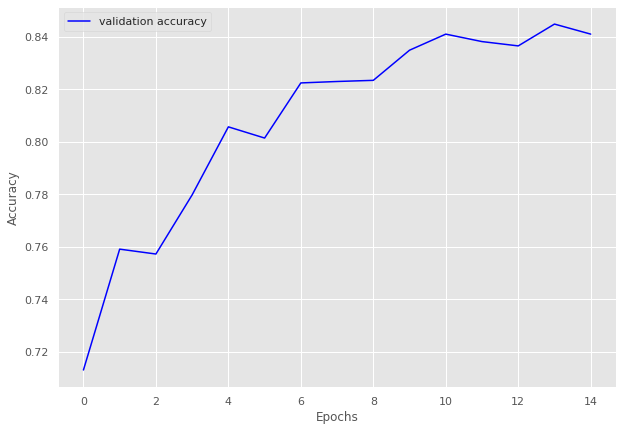

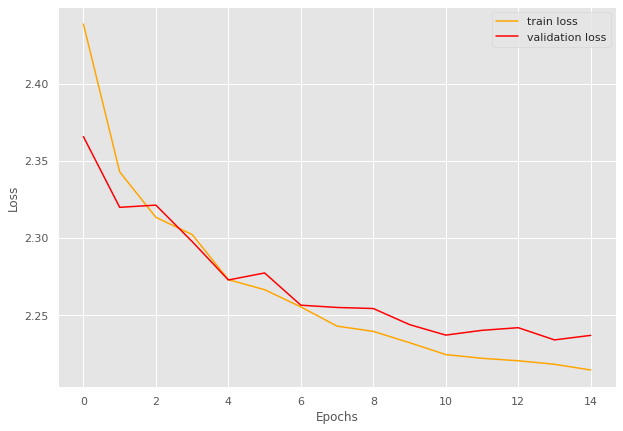

{'0': {'coarse': {'00': 0.8344144759303517, '10': 0.7350631614885627, '20': 0.6717065795249476, '30': 0.587328683607277, '50': 0.4409598595327513, '80': 0.2362093352192362}, 'fine': {'00': {'0': 0.9762140733399405, '1': 0.9764150943396226, '2': 0.9572277227722772, '3': 0.973404255319149, '4': 0.99644128113879, '5': 0.9815242494226328, '7': 0.9389619883040936, '8': 0.9871175523349437, '9': 0.8673469387755102, '11': 0.9451642060861706, '12': 0.9523012552301255, '14': 0.9555808656036446, '15': 0.9640077821011673}, '10': {'0': 0.8848780487804878, '1': 0.8422535211267606, '2': 0.8879103282626101, '3': 0.9231638418079096, '4': 0.9256505576208178, '5': 0.906885758998435, '7': 0.8858381502890174, '8': 0.9591503267973857, '9': 0.7749469214437368, '11': 0.8723911747167561, '12': 0.9203319502074688, '14': 0.8818380743982495, '15': 0.8033088235294118}, '20': {'0': 0.8442064264849075, '1': 0.7038567493112947, '2': 0.8205027494108406, '3': 0.8527889591719379, '4': 0.8386075949367089, '5': 0.80940794

100%|██████████| 91/91 [00:32<00:00,  2.78batch/s, loss=1.03]


train loss 1.0303087601294885, validation loss 0.9761049389839173, validation accuracy 0.9289099526066351
Coarse label 0 Epoch 2
-------------------------------


100%|██████████| 91/91 [00:32<00:00,  2.78batch/s, loss=0.943]


train loss 0.9427301307300945, validation loss 0.9511581480503082, validation accuracy 0.9557661927330173
Coarse label 0 Epoch 3
-------------------------------


100%|██████████| 91/91 [00:32<00:00,  2.80batch/s, loss=0.932]


train loss 0.9323934886481736, validation loss 0.9485855281352997, validation accuracy 0.9620853080568721
Coarse label 0 Epoch 4
-------------------------------


100%|██████████| 91/91 [00:32<00:00,  2.77batch/s, loss=0.929]


train loss 0.9289966919919946, validation loss 0.9479591369628906, validation accuracy 0.9589257503949447
Coarse label 0 Epoch 5
-------------------------------


100%|██████████| 91/91 [00:32<00:00,  2.76batch/s, loss=0.924]


train loss 0.9241130980816517, validation loss 0.9384385466575622, validation accuracy 0.9652448657187994
Coarse label 0 Epoch 6
-------------------------------


100%|██████████| 91/91 [00:32<00:00,  2.80batch/s, loss=0.922]


train loss 0.9216789026836772, validation loss 0.937598717212677, validation accuracy 0.966824644549763
Coarse label 0 Epoch 7
-------------------------------


100%|██████████| 91/91 [00:32<00:00,  2.76batch/s, loss=0.922]


INFO: Early stopping counter 1 of 5
train loss 0.9218065529079228, validation loss 0.944389545917511, validation accuracy 0.9589257503949447
Coarse label 0 Epoch 8
-------------------------------


 30%|██▉       | 27/91 [00:09<00:22,  2.82batch/s, loss=0.917]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

100%|██████████| 204/204 [01:13<00:00,  2.79batch/s, loss=1.6] 


INFO: Early stopping counter 4 of 5
train loss 1.604740759905647, validation loss 1.624036236813194, validation accuracy 0.9232096635030198
Coarse label 2 Epoch 11
-------------------------------


100%|██████████| 204/204 [01:12<00:00,  2.81batch/s, loss=1.59]


INFO: Early stopping counter 5 of 5
INFO: Early stopping
Done! Saved model with test accuracy 0.9224137931034483 and loss 1.620602661371231


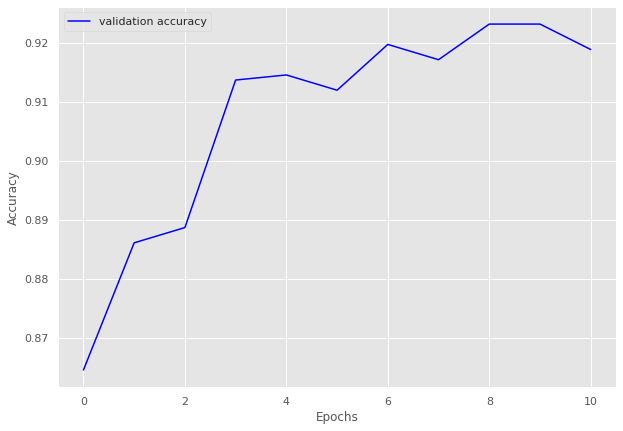

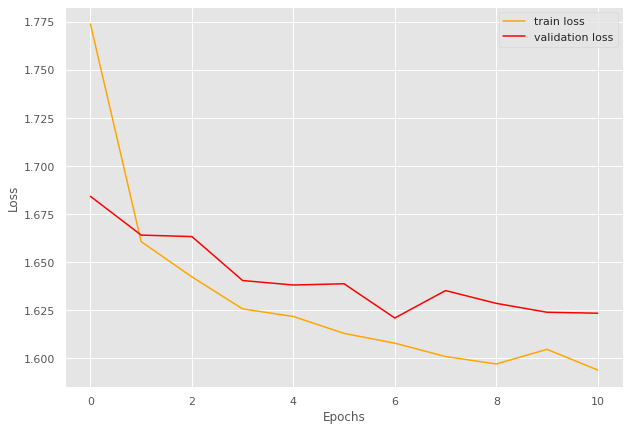

{'0': {'coarse': {'00': 0.8344144759303517, '10': 0.7350631614885627, '20': 0.6717065795249476, '30': 0.587328683607277, '50': 0.4409598595327513, '80': 0.2362093352192362}, 'fine': {'00': {'0': 0.9762140733399405, '1': 0.9764150943396226, '2': 0.9572277227722772, '3': 0.973404255319149, '4': 0.99644128113879, '5': 0.9815242494226328, '7': 0.9389619883040936, '8': 0.9871175523349437, '9': 0.8673469387755102, '11': 0.9451642060861706, '12': 0.9523012552301255, '14': 0.9555808656036446, '15': 0.9640077821011673}, '10': {'0': 0.8848780487804878, '1': 0.8422535211267606, '2': 0.8879103282626101, '3': 0.9231638418079096, '4': 0.9256505576208178, '5': 0.906885758998435, '7': 0.8858381502890174, '8': 0.9591503267973857, '9': 0.7749469214437368, '11': 0.8723911747167561, '12': 0.9203319502074688, '14': 0.8818380743982495, '15': 0.8033088235294118}, '20': {'0': 0.8442064264849075, '1': 0.7038567493112947, '2': 0.8205027494108406, '3': 0.8527889591719379, '4': 0.8386075949367089, '5': 0.80940794

100%|██████████| 139/139 [00:49<00:00,  2.81batch/s, loss=1.46]


train loss 1.458599616297715, validation loss 1.3528876900672913, validation accuracy 0.9263261296660118
Coarse label 4 Epoch 2
-------------------------------


100%|██████████| 139/139 [00:49<00:00,  2.82batch/s, loss=1.35]


train loss 1.3491448549915561, validation loss 1.3318889066576958, validation accuracy 0.9420432220039293
Coarse label 4 Epoch 3
-------------------------------


100%|██████████| 139/139 [00:49<00:00,  2.82batch/s, loss=1.33]


train loss 1.3295455176195652, validation loss 1.3198995292186737, validation accuracy 0.9567779960707269
Coarse label 4 Epoch 4
-------------------------------


100%|██████████| 139/139 [00:49<00:00,  2.79batch/s, loss=1.32]


train loss 1.3172267529604247, validation loss 1.3134556114673615, validation accuracy 0.9646365422396856
Coarse label 4 Epoch 5
-------------------------------


100%|██████████| 139/139 [00:49<00:00,  2.82batch/s, loss=1.31]


INFO: Early stopping counter 1 of 5
train loss 1.308581177279246, validation loss 1.3161791861057281, validation accuracy 0.9607072691552063
Coarse label 4 Epoch 6
-------------------------------


100%|██████████| 139/139 [00:50<00:00,  2.78batch/s, loss=1.3] 


train loss 1.3046888224512554, validation loss 1.3105767518281937, validation accuracy 0.9646365422396856
Coarse label 4 Epoch 7
-------------------------------


100%|██████████| 139/139 [00:49<00:00,  2.78batch/s, loss=1.3]


train loss 1.3037304749591745, validation loss 1.3086930960416794, validation accuracy 0.9646365422396856
Coarse label 4 Epoch 8
-------------------------------


100%|██████████| 139/139 [00:49<00:00,  2.82batch/s, loss=1.3]


INFO: Early stopping counter 2 of 5
train loss 1.3031417157152574, validation loss 1.3104906156659126, validation accuracy 0.9646365422396856
Coarse label 4 Epoch 9
-------------------------------


 19%|█▉        | 27/139 [00:09<00:38,  2.88batch/s, loss=1.3] IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

100%|██████████| 81/81 [00:28<00:00,  2.80batch/s, loss=1.08]


INFO: Early stopping counter 3 of 5
train loss 1.076501785972972, validation loss 1.0892685532569886, validation accuracy 0.9527027027027027
Coarse label 8 Epoch 8
-------------------------------


100%|██████████| 81/81 [00:29<00:00,  2.78batch/s, loss=1.08]


INFO: Early stopping counter 4 of 5
train loss 1.0771621995502048, validation loss 1.092888391017914, validation accuracy 0.9543918918918919
Coarse label 8 Epoch 9
-------------------------------


100%|██████████| 81/81 [00:28<00:00,  2.80batch/s, loss=1.07]


INFO: Early stopping counter 5 of 5
INFO: Early stopping
Done! Saved model with test accuracy 0.949438202247191 and loss 1.0933886485941269


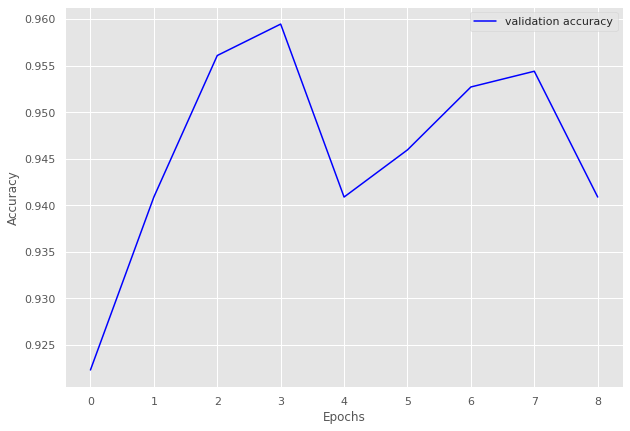

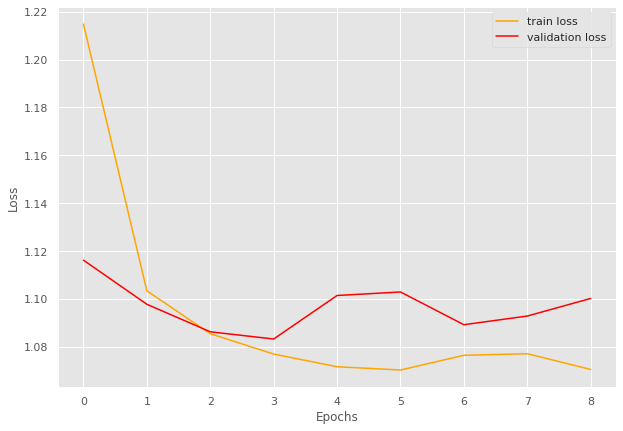

{'0': {'coarse': {'00': 0.8344144759303517, '10': 0.7350631614885627, '20': 0.6717065795249476, '30': 0.587328683607277, '50': 0.4409598595327513, '80': 0.2362093352192362}, 'fine': {'00': {'0': 0.9762140733399405, '1': 0.9764150943396226, '2': 0.9572277227722772, '3': 0.973404255319149, '4': 0.99644128113879, '5': 0.9815242494226328, '7': 0.9389619883040936, '8': 0.9871175523349437, '9': 0.8673469387755102, '11': 0.9451642060861706, '12': 0.9523012552301255, '14': 0.9555808656036446, '15': 0.9640077821011673}, '10': {'0': 0.8848780487804878, '1': 0.8422535211267606, '2': 0.8879103282626101, '3': 0.9231638418079096, '4': 0.9256505576208178, '5': 0.906885758998435, '7': 0.8858381502890174, '8': 0.9591503267973857, '9': 0.7749469214437368, '11': 0.8723911747167561, '12': 0.9203319502074688, '14': 0.8818380743982495, '15': 0.8033088235294118}, '20': {'0': 0.8442064264849075, '1': 0.7038567493112947, '2': 0.8205027494108406, '3': 0.8527889591719379, '4': 0.8386075949367089, '5': 0.80940794

100%|██████████| 115/115 [00:41<00:00,  2.78batch/s, loss=1.18]


train loss 1.1761867440265157, validation loss 1.100764513015747, validation accuracy 0.9439421338155516
Coarse label 9 Epoch 2
-------------------------------


100%|██████████| 115/115 [00:41<00:00,  2.77batch/s, loss=1.09]


train loss 1.0863006850947505, validation loss 1.0683935483296711, validation accuracy 0.976491862567812
Coarse label 9 Epoch 3
-------------------------------


100%|██████████| 115/115 [00:41<00:00,  2.79batch/s, loss=1.08]


INFO: Early stopping counter 1 of 5
train loss 1.0751730649367623, validation loss 1.076211518711514, validation accuracy 0.9674502712477396
Coarse label 9 Epoch 4
-------------------------------


100%|██████████| 115/115 [00:41<00:00,  2.78batch/s, loss=1.07]


INFO: Early stopping counter 2 of 5
train loss 1.0650425071301668, validation loss 1.069619483417935, validation accuracy 0.972875226039783
Coarse label 9 Epoch 5
-------------------------------


100%|██████████| 115/115 [00:41<00:00,  2.79batch/s, loss=1.06]


INFO: Early stopping counter 3 of 5
train loss 1.0625932123350061, validation loss 1.0699003405041165, validation accuracy 0.9710669077757685
Coarse label 9 Epoch 6
-------------------------------


100%|██████████| 115/115 [00:41<00:00,  2.75batch/s, loss=1.06]


train loss 1.0631732743719349, validation loss 1.062518212530348, validation accuracy 0.9819168173598554
Coarse label 9 Epoch 7
-------------------------------


100%|██████████| 115/115 [00:41<00:00,  2.78batch/s, loss=1.06]


INFO: Early stopping counter 4 of 5
train loss 1.0615965646246206, validation loss 1.0685113535987005, validation accuracy 0.972875226039783
Coarse label 9 Epoch 8
-------------------------------


100%|██████████| 115/115 [00:41<00:00,  2.80batch/s, loss=1.06]


INFO: Early stopping counter 5 of 5
INFO: Early stopping
Done! Saved model with test accuracy 0.9676204819277109 and loss 1.0746260256994338


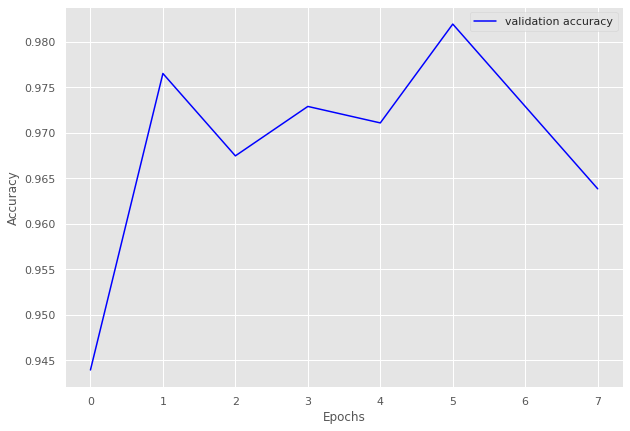

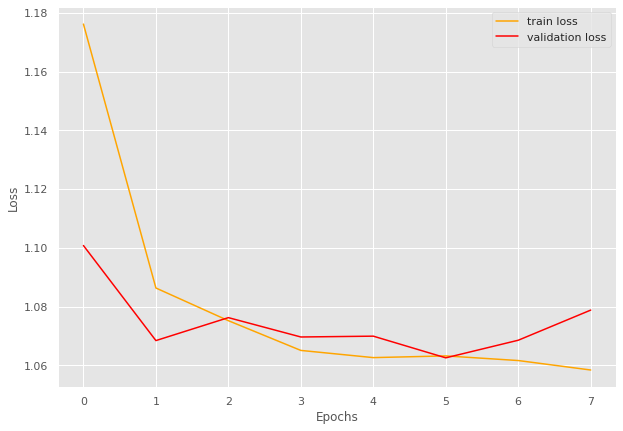

{'0': {'coarse': {'00': 0.8344144759303517, '10': 0.7350631614885627, '20': 0.6717065795249476, '30': 0.587328683607277, '50': 0.4409598595327513, '80': 0.2362093352192362}, 'fine': {'00': {'0': 0.9762140733399405, '1': 0.9764150943396226, '2': 0.9572277227722772, '3': 0.973404255319149, '4': 0.99644128113879, '5': 0.9815242494226328, '7': 0.9389619883040936, '8': 0.9871175523349437, '9': 0.8673469387755102, '11': 0.9451642060861706, '12': 0.9523012552301255, '14': 0.9555808656036446, '15': 0.9640077821011673}, '10': {'0': 0.8848780487804878, '1': 0.8422535211267606, '2': 0.8879103282626101, '3': 0.9231638418079096, '4': 0.9256505576208178, '5': 0.906885758998435, '7': 0.8858381502890174, '8': 0.9591503267973857, '9': 0.7749469214437368, '11': 0.8723911747167561, '12': 0.9203319502074688, '14': 0.8818380743982495, '15': 0.8033088235294118}, '20': {'0': 0.8442064264849075, '1': 0.7038567493112947, '2': 0.8205027494108406, '3': 0.8527889591719379, '4': 0.8386075949367089, '5': 0.80940794

100%|██████████| 99/99 [00:35<00:00,  2.79batch/s, loss=1.01]


train loss 1.0112515398950288, validation loss 0.949884214184501, validation accuracy 0.9530102790014684
Coarse label 11 Epoch 2
-------------------------------


100%|██████████| 99/99 [00:35<00:00,  2.78batch/s, loss=0.938]


train loss 0.9382581331513145, validation loss 0.9460689696398649, validation accuracy 0.9588839941262849
Coarse label 11 Epoch 3
-------------------------------


100%|██████████| 99/99 [00:34<00:00,  2.84batch/s, loss=0.932]


train loss 0.931985252433353, validation loss 0.9447035952047869, validation accuracy 0.9588839941262849
Coarse label 11 Epoch 4
-------------------------------


 43%|████▎     | 43/99 [00:15<00:20,  2.77batch/s, loss=0.922]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

100%|██████████| 220/220 [01:19<00:00,  2.78batch/s, loss=1.41]


INFO: Early stopping counter 2 of 5
train loss 1.408982647007162, validation loss 1.426528024673462, validation accuracy 0.9423503325942351
Coarse label 13 Epoch 8
-------------------------------


100%|██████████| 220/220 [01:20<00:00,  2.74batch/s, loss=1.41]


INFO: Early stopping counter 3 of 5
train loss 1.40606288747354, validation loss 1.4155930678049724, validation accuracy 0.9523281596452328
Coarse label 13 Epoch 9
-------------------------------


100%|██████████| 220/220 [01:19<00:00,  2.77batch/s, loss=1.41]


INFO: Early stopping counter 4 of 5
train loss 1.4056814822283659, validation loss 1.4222459236780802, validation accuracy 0.9467849223946785
Coarse label 13 Epoch 10
-------------------------------


100%|██████████| 220/220 [01:19<00:00,  2.77batch/s, loss=1.4] 


INFO: Early stopping counter 5 of 5
INFO: Early stopping
Done! Saved model with test accuracy 0.950566037735849 and loss 1.4212680459022522


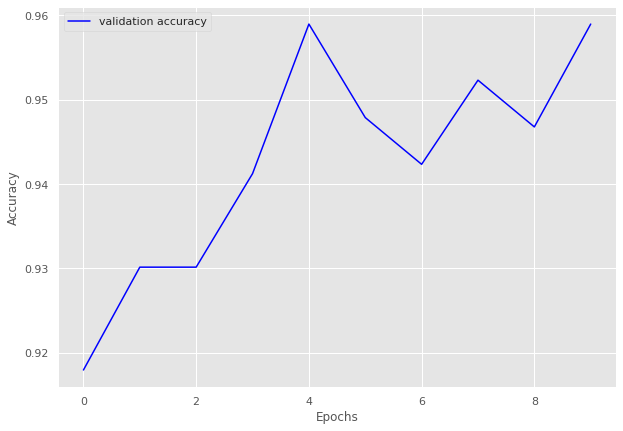

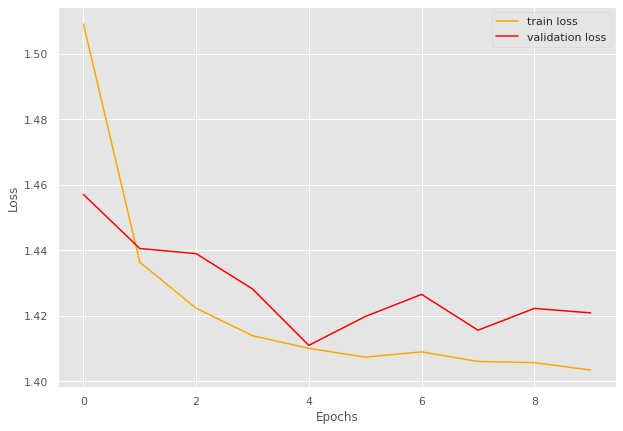

{'0': {'coarse': {'00': 0.8344144759303517, '10': 0.7350631614885627, '20': 0.6717065795249476, '30': 0.587328683607277, '50': 0.4409598595327513, '80': 0.2362093352192362}, 'fine': {'00': {'0': 0.9762140733399405, '1': 0.9764150943396226, '2': 0.9572277227722772, '3': 0.973404255319149, '4': 0.99644128113879, '5': 0.9815242494226328, '7': 0.9389619883040936, '8': 0.9871175523349437, '9': 0.8673469387755102, '11': 0.9451642060861706, '12': 0.9523012552301255, '14': 0.9555808656036446, '15': 0.9640077821011673}, '10': {'0': 0.8848780487804878, '1': 0.8422535211267606, '2': 0.8879103282626101, '3': 0.9231638418079096, '4': 0.9256505576208178, '5': 0.906885758998435, '7': 0.8858381502890174, '8': 0.9591503267973857, '9': 0.7749469214437368, '11': 0.8723911747167561, '12': 0.9203319502074688, '14': 0.8818380743982495, '15': 0.8033088235294118}, '20': {'0': 0.8442064264849075, '1': 0.7038567493112947, '2': 0.8205027494108406, '3': 0.8527889591719379, '4': 0.8386075949367089, '5': 0.80940794

100%|██████████| 34/34 [00:11<00:00,  2.85batch/s, loss=0.704]


train loss 0.7038594782352448, validation loss 0.6128453811009725, validation accuracy 0.9290322580645162
Coarse label 14 Epoch 2
-------------------------------


100%|██████████| 34/34 [00:11<00:00,  2.93batch/s, loss=0.592]


train loss 0.5921382097636952, validation loss 0.6043726404507955, validation accuracy 0.9354838709677419
Coarse label 14 Epoch 3
-------------------------------


100%|██████████| 34/34 [00:11<00:00,  2.88batch/s, loss=0.578]


INFO: Early stopping counter 1 of 5
train loss 0.5776233410134035, validation loss 0.6185607314109802, validation accuracy 0.9225806451612903
Coarse label 14 Epoch 4
-------------------------------


100%|██████████| 34/34 [00:11<00:00,  2.84batch/s, loss=0.579]


INFO: Early stopping counter 2 of 5
train loss 0.5793341818977805, validation loss 0.6115418076515198, validation accuracy 0.9225806451612903
Coarse label 14 Epoch 5
-------------------------------


100%|██████████| 34/34 [00:11<00:00,  2.86batch/s, loss=0.577]


train loss 0.5765329546788159, validation loss 0.5976029634475708, validation accuracy 0.9483870967741935
Coarse label 14 Epoch 6
-------------------------------


100%|██████████| 34/34 [00:11<00:00,  2.92batch/s, loss=0.57] 


INFO: Early stopping counter 3 of 5
train loss 0.5703363611417658, validation loss 0.6037069956461588, validation accuracy 0.9354838709677419
Coarse label 14 Epoch 7
-------------------------------


100%|██████████| 34/34 [00:11<00:00,  2.92batch/s, loss=0.569]


INFO: Early stopping counter 4 of 5
train loss 0.5686401304076699, validation loss 0.6047718524932861, validation accuracy 0.9354838709677419
Coarse label 14 Epoch 8
-------------------------------


100%|██████████| 34/34 [00:11<00:00,  2.93batch/s, loss=0.569]


INFO: Early stopping counter 5 of 5
INFO: Early stopping
Done! Saved model with test accuracy 0.9603399433427762 and loss 0.5847560365994772


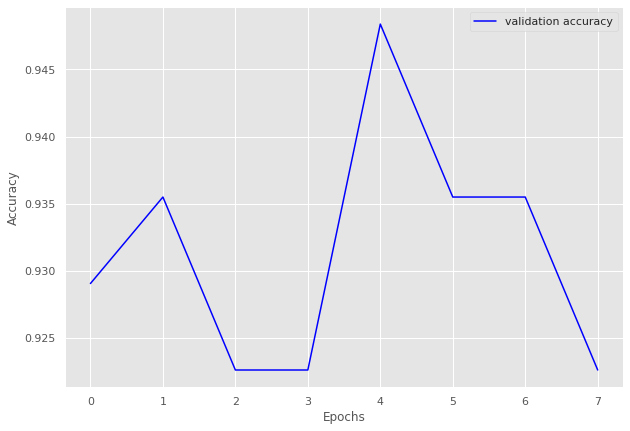

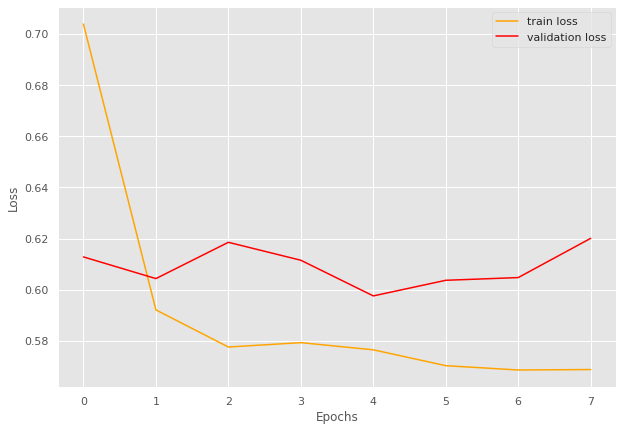

{'0': {'coarse': {'00': 0.8344144759303517, '10': 0.7350631614885627, '20': 0.6717065795249476, '30': 0.587328683607277, '50': 0.4409598595327513, '80': 0.2362093352192362}, 'fine': {'00': {'0': 0.9762140733399405, '1': 0.9764150943396226, '2': 0.9572277227722772, '3': 0.973404255319149, '4': 0.99644128113879, '5': 0.9815242494226328, '7': 0.9389619883040936, '8': 0.9871175523349437, '9': 0.8673469387755102, '11': 0.9451642060861706, '12': 0.9523012552301255, '14': 0.9555808656036446, '15': 0.9640077821011673}, '10': {'0': 0.8848780487804878, '1': 0.8422535211267606, '2': 0.8879103282626101, '3': 0.9231638418079096, '4': 0.9256505576208178, '5': 0.906885758998435, '7': 0.8858381502890174, '8': 0.9591503267973857, '9': 0.7749469214437368, '11': 0.8723911747167561, '12': 0.9203319502074688, '14': 0.8818380743982495, '15': 0.8033088235294118}, '20': {'0': 0.8442064264849075, '1': 0.7038567493112947, '2': 0.8205027494108406, '3': 0.8527889591719379, '4': 0.8386075949367089, '5': 0.80940794

100%|██████████| 88/88 [00:31<00:00,  2.79batch/s, loss=0.848]


train loss 0.8480767092921517, validation loss 0.7848375168713656, validation accuracy 0.9564541213063764
Coarse label 15 Epoch 2
-------------------------------


100%|██████████| 88/88 [00:31<00:00,  2.80batch/s, loss=0.775]


train loss 0.7752093875950034, validation loss 0.7743996652689847, validation accuracy 0.9642301710730948
Coarse label 15 Epoch 3
-------------------------------


100%|██████████| 88/88 [00:32<00:00,  2.75batch/s, loss=0.764]


train loss 0.7635538266463713, validation loss 0.7741193283687938, validation accuracy 0.9673405909797823
Coarse label 15 Epoch 4
-------------------------------


100%|██████████| 88/88 [00:31<00:00,  2.79batch/s, loss=0.762]


INFO: Early stopping counter 1 of 5
train loss 0.7621646245772188, validation loss 0.798395964232358, validation accuracy 0.9611197511664075
Coarse label 15 Epoch 5
-------------------------------


 67%|██████▋   | 59/88 [00:21<00:10,  2.83batch/s, loss=0.758]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

100%|██████████| 1641/1641 [10:02<00:00,  2.72batch/s, loss=2.5] 


train loss 2.497499715402895, validation loss 2.4260789631129978, validation accuracy 0.6532019704433497
Epoch 2
-------------------------------


  6%|▌         | 97/1641 [01:16<20:49,  1.24batch/s, loss=2.43]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

100%|██████████| 1641/1641 [11:52<00:00,  2.30batch/s, loss=2.4]


train loss 2.3960053890235247, validation loss 2.3968781507932224, validation accuracy 0.6811165845648605
Epoch 4
-------------------------------


 84%|████████▍ | 1380/1641 [08:16<01:34,  2.75batch/s, loss=2.37]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

100%|██████████| 1641/1641 [09:52<00:00,  2.77batch/s, loss=2.33]


train loss 2.329914133262518, validation loss 2.3266589224755347, validation accuracy 0.7520525451559934
Epoch 7
-------------------------------


 26%|██▌       | 421/1641 [03:24<17:24,  1.17batch/s, loss=2.32]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

100%|██████████| 1641/1641 [11:44<00:00,  2.33batch/s, loss=2.31]


train loss 2.3125283983987255, validation loss 2.323500831644018, validation accuracy 0.7554460864805692
Epoch 10
-------------------------------


  3%|▎         | 45/1641 [00:16<09:29,  2.80batch/s, loss=2.32]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

100%|██████████| 1641/1641 [09:48<00:00,  2.79batch/s, loss=2.3]


INFO: Early stopping counter 2 of 5
train loss 2.3037562400810896, validation loss 2.317539863653116, validation accuracy 0.7613574165298304
Epoch 12
-------------------------------


 82%|████████▏ | 1339/1641 [09:56<01:45,  2.86batch/s, loss=2.3]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

100%|██████████| 1641/1641 [11:45<00:00,  2.33batch/s, loss=2.29]


INFO: Early stopping counter 3 of 5
train loss 2.2912922754002953, validation loss 2.310265269312825, validation accuracy 0.7672687465790914
Epoch 15
-------------------------------


 52%|█████▏    | 852/1641 [05:05<04:33,  2.88batch/s, loss=2.29]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

100%|██████████| 1641/1641 [11:47<00:00,  2.32batch/s, loss=2.28]


train loss 2.284145629529471, validation loss 2.3017066442049465, validation accuracy 0.7767925561029009
Epoch 18
-------------------------------


 26%|██▋       | 433/1641 [02:35<06:49,  2.95batch/s, loss=2.28]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

100%|██████████| 1641/1641 [09:52<00:00,  2.77batch/s, loss=2.28]


INFO: Early stopping counter 5 of 5
INFO: Early stopping
Done! Saved model with test accuracy 0.7757401355899137 and loss 2.3029380513128834


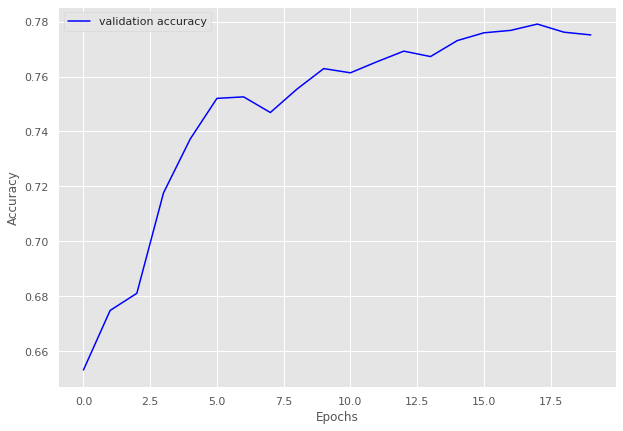

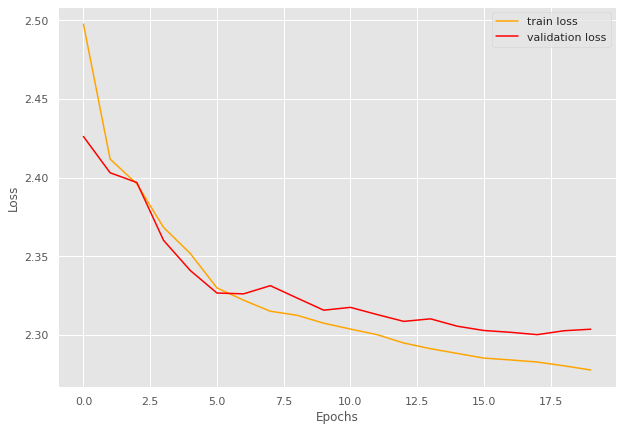

{'0': {'coarse': {'00': 0.8344144759303517, '10': 0.7350631614885627, '20': 0.6717065795249476, '30': 0.587328683607277, '50': 0.4409598595327513, '80': 0.2362093352192362}, 'fine': {'00': {'0': 0.9762140733399405, '1': 0.9764150943396226, '2': 0.9572277227722772, '3': 0.973404255319149, '4': 0.99644128113879, '5': 0.9815242494226328, '7': 0.9389619883040936, '8': 0.9871175523349437, '9': 0.8673469387755102, '11': 0.9451642060861706, '12': 0.9523012552301255, '14': 0.9555808656036446, '15': 0.9640077821011673}, '10': {'0': 0.8848780487804878, '1': 0.8422535211267606, '2': 0.8879103282626101, '3': 0.9231638418079096, '4': 0.9256505576208178, '5': 0.906885758998435, '7': 0.8858381502890174, '8': 0.9591503267973857, '9': 0.7749469214437368, '11': 0.8723911747167561, '12': 0.9203319502074688, '14': 0.8818380743982495, '15': 0.8033088235294118}, '20': {'0': 0.8442064264849075, '1': 0.7038567493112947, '2': 0.8205027494108406, '3': 0.8527889591719379, '4': 0.8386075949367089, '5': 0.80940794

 24%|██▍       | 22/90 [00:13<00:24,  2.76batch/s, loss=1.25]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

100%|██████████| 203/203 [02:10<00:00,  1.56batch/s, loss=1.65]


INFO: Early stopping counter 1 of 5
train loss 1.6508743598543365, validation loss 1.6913406911649203, validation accuracy 0.8522039757994814
Coarse label 2 Epoch 10
-------------------------------


100%|██████████| 203/203 [02:06<00:00,  1.61batch/s, loss=1.65]


INFO: Early stopping counter 2 of 5
train loss 1.6463285913608345, validation loss 1.6793410903529118, validation accuracy 0.8608470181503889
Coarse label 2 Epoch 11
-------------------------------


100%|██████████| 203/203 [01:13<00:00,  2.78batch/s, loss=1.64]


INFO: Early stopping counter 3 of 5
train loss 1.6448608478301852, validation loss 1.6883333419498645, validation accuracy 0.8504753673293
Coarse label 2 Epoch 12
-------------------------------


100%|██████████| 203/203 [01:13<00:00,  2.77batch/s, loss=1.65]


INFO: Early stopping counter 4 of 5
train loss 1.6469880700698627, validation loss 1.6832941770553589, validation accuracy 0.8617113223854796
Coarse label 2 Epoch 13
-------------------------------


100%|██████████| 203/203 [01:12<00:00,  2.79batch/s, loss=1.64]


INFO: Early stopping counter 5 of 5
INFO: Early stopping
Done! Saved model with test accuracy 0.8456617353058776 and loss 1.717933675646782


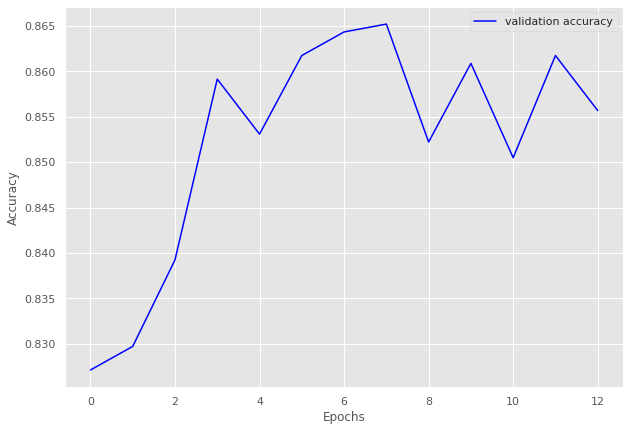

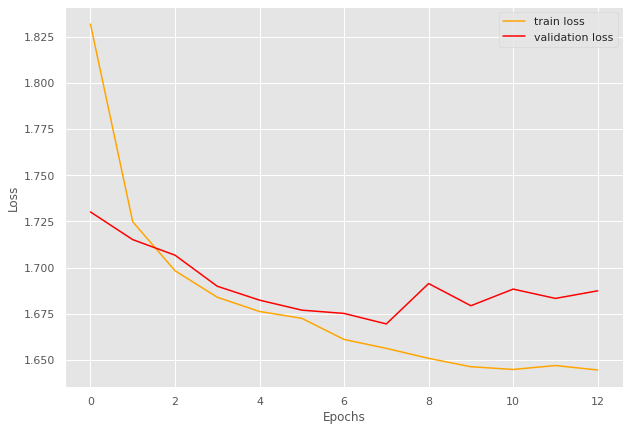

{'0': {'coarse': {'00': 0.8344144759303517, '10': 0.7350631614885627, '20': 0.6717065795249476, '30': 0.587328683607277, '50': 0.4409598595327513, '80': 0.2362093352192362}, 'fine': {'00': {'0': 0.9762140733399405, '1': 0.9764150943396226, '2': 0.9572277227722772, '3': 0.973404255319149, '4': 0.99644128113879, '5': 0.9815242494226328, '7': 0.9389619883040936, '8': 0.9871175523349437, '9': 0.8673469387755102, '11': 0.9451642060861706, '12': 0.9523012552301255, '14': 0.9555808656036446, '15': 0.9640077821011673}, '10': {'0': 0.8848780487804878, '1': 0.8422535211267606, '2': 0.8879103282626101, '3': 0.9231638418079096, '4': 0.9256505576208178, '5': 0.906885758998435, '7': 0.8858381502890174, '8': 0.9591503267973857, '9': 0.7749469214437368, '11': 0.8723911747167561, '12': 0.9203319502074688, '14': 0.8818380743982495, '15': 0.8033088235294118}, '20': {'0': 0.8442064264849075, '1': 0.7038567493112947, '2': 0.8205027494108406, '3': 0.8527889591719379, '4': 0.8386075949367089, '5': 0.80940794

100%|██████████| 140/140 [00:50<00:00,  2.80batch/s, loss=1.52]


train loss 1.5221002629825047, validation loss 1.4205858632922173, validation accuracy 0.8601609657947686
Coarse label 4 Epoch 2
-------------------------------


100%|██████████| 140/140 [00:49<00:00,  2.81batch/s, loss=1.41]


train loss 1.410518911906651, validation loss 1.3944626823067665, validation accuracy 0.8822937625754527
Coarse label 4 Epoch 3
-------------------------------


100%|██████████| 140/140 [00:50<00:00,  2.79batch/s, loss=1.39]


train loss 1.3904997731958118, validation loss 1.3900739774107933, validation accuracy 0.886317907444668
Coarse label 4 Epoch 4
-------------------------------


 59%|█████▊    | 82/140 [00:29<00:20,  2.82batch/s, loss=1.38]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

100%|██████████| 68/68 [00:25<00:00,  2.69batch/s, loss=0.823]


train loss 0.822759657221682, validation loss 0.8403942386309305, validation accuracy 0.8976377952755905
Coarse label 7 Epoch 3
-------------------------------


100%|██████████| 68/68 [00:24<00:00,  2.80batch/s, loss=0.8]  


INFO: Early stopping counter 1 of 5
train loss 0.799821691478, validation loss 0.8407163719336191, validation accuracy 0.8976377952755905
Coarse label 7 Epoch 4
-------------------------------


100%|██████████| 68/68 [00:24<00:00,  2.76batch/s, loss=0.789]


train loss 0.7886623258099836, validation loss 0.8343104422092438, validation accuracy 0.9081364829396326
Coarse label 7 Epoch 5
-------------------------------


100%|██████████| 68/68 [00:24<00:00,  2.82batch/s, loss=0.785]


INFO: Early stopping counter 2 of 5
train loss 0.7850787849987254, validation loss 0.8359960913658142, validation accuracy 0.910761154855643
Coarse label 7 Epoch 6
-------------------------------


100%|██████████| 68/68 [00:24<00:00,  2.79batch/s, loss=0.784]


train loss 0.7837918514714521, validation loss 0.8320177892843882, validation accuracy 0.910761154855643
Coarse label 7 Epoch 7
-------------------------------


100%|██████████| 68/68 [00:24<00:00,  2.79batch/s, loss=0.786]


INFO: Early stopping counter 3 of 5
train loss 0.7858535165295881, validation loss 0.8418076733748118, validation accuracy 0.9028871391076115
Coarse label 7 Epoch 8
-------------------------------


100%|██████████| 68/68 [00:24<00:00,  2.78batch/s, loss=0.782]


INFO: Early stopping counter 4 of 5
train loss 0.7818522050100214, validation loss 0.8413473864396414, validation accuracy 0.9002624671916011
Coarse label 7 Epoch 9
-------------------------------


100%|██████████| 68/68 [00:24<00:00,  2.77batch/s, loss=0.79] 


INFO: Early stopping counter 5 of 5
INFO: Early stopping
Done! Saved model with test accuracy 0.9142526071842411 and loss 0.8337942702429635


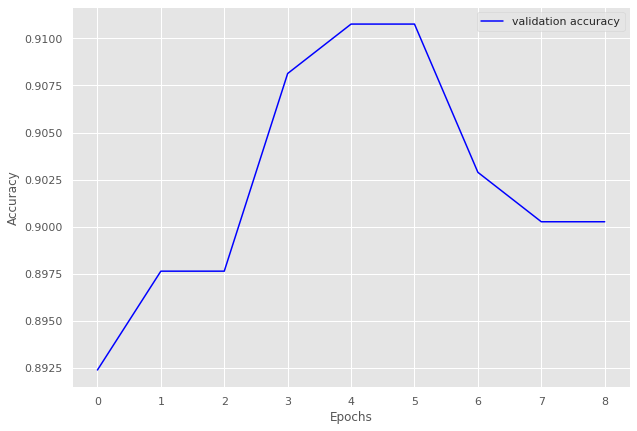

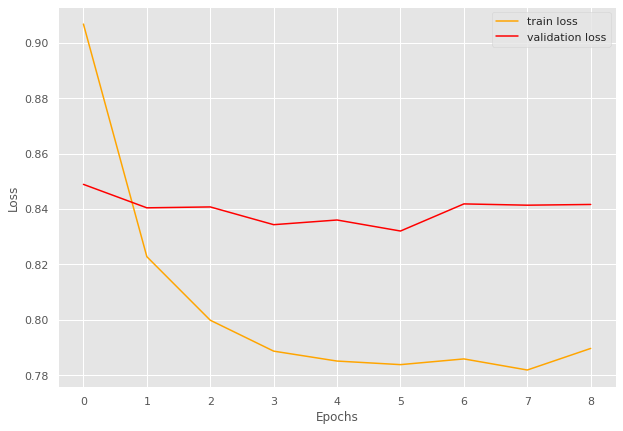

{'0': {'coarse': {'00': 0.8344144759303517, '10': 0.7350631614885627, '20': 0.6717065795249476, '30': 0.587328683607277, '50': 0.4409598595327513, '80': 0.2362093352192362}, 'fine': {'00': {'0': 0.9762140733399405, '1': 0.9764150943396226, '2': 0.9572277227722772, '3': 0.973404255319149, '4': 0.99644128113879, '5': 0.9815242494226328, '7': 0.9389619883040936, '8': 0.9871175523349437, '9': 0.8673469387755102, '11': 0.9451642060861706, '12': 0.9523012552301255, '14': 0.9555808656036446, '15': 0.9640077821011673}, '10': {'0': 0.8848780487804878, '1': 0.8422535211267606, '2': 0.8879103282626101, '3': 0.9231638418079096, '4': 0.9256505576208178, '5': 0.906885758998435, '7': 0.8858381502890174, '8': 0.9591503267973857, '9': 0.7749469214437368, '11': 0.8723911747167561, '12': 0.9203319502074688, '14': 0.8818380743982495, '15': 0.8033088235294118}, '20': {'0': 0.8442064264849075, '1': 0.7038567493112947, '2': 0.8205027494108406, '3': 0.8527889591719379, '4': 0.8386075949367089, '5': 0.80940794

100%|██████████| 84/84 [00:29<00:00,  2.83batch/s, loss=1.28]


train loss 1.2769306600093842, validation loss 1.1961315631866456, validation accuracy 0.8230240549828178
Coarse label 8 Epoch 2
-------------------------------


100%|██████████| 84/84 [00:29<00:00,  2.80batch/s, loss=1.18]


INFO: Early stopping counter 1 of 5
train loss 1.1804865825743902, validation loss 1.1962547779083252, validation accuracy 0.8264604810996563
Coarse label 8 Epoch 3
-------------------------------


100%|██████████| 84/84 [00:30<00:00,  2.80batch/s, loss=1.15]


train loss 1.1530084382920038, validation loss 1.1828890085220336, validation accuracy 0.845360824742268
Coarse label 8 Epoch 4
-------------------------------


100%|██████████| 84/84 [00:29<00:00,  2.85batch/s, loss=1.15]


train loss 1.145015605858394, validation loss 1.1733524918556213, validation accuracy 0.852233676975945
Coarse label 8 Epoch 5
-------------------------------


100%|██████████| 84/84 [00:29<00:00,  2.84batch/s, loss=1.13]


INFO: Early stopping counter 2 of 5
train loss 1.133517888330278, validation loss 1.1839863896369933, validation accuracy 0.8419243986254296
Coarse label 8 Epoch 6
-------------------------------


100%|██████████| 84/84 [00:29<00:00,  2.80batch/s, loss=1.12]


train loss 1.1243852703344255, validation loss 1.1569231867790222, validation accuracy 0.8762886597938144
Coarse label 8 Epoch 7
-------------------------------


100%|██████████| 84/84 [00:30<00:00,  2.79batch/s, loss=1.12]


INFO: Early stopping counter 3 of 5
train loss 1.118536162944067, validation loss 1.167144250869751, validation accuracy 0.8625429553264605
Coarse label 8 Epoch 8
-------------------------------


100%|██████████| 84/84 [00:29<00:00,  2.83batch/s, loss=1.12]


INFO: Early stopping counter 4 of 5
train loss 1.1164464751879375, validation loss 1.1762994527816772, validation accuracy 0.8539518900343642
Coarse label 8 Epoch 9
-------------------------------


100%|██████████| 84/84 [00:29<00:00,  2.82batch/s, loss=1.12]


INFO: Early stopping counter 5 of 5
INFO: Early stopping
Done! Saved model with test accuracy 0.8772093023255814 and loss 1.171904528842253


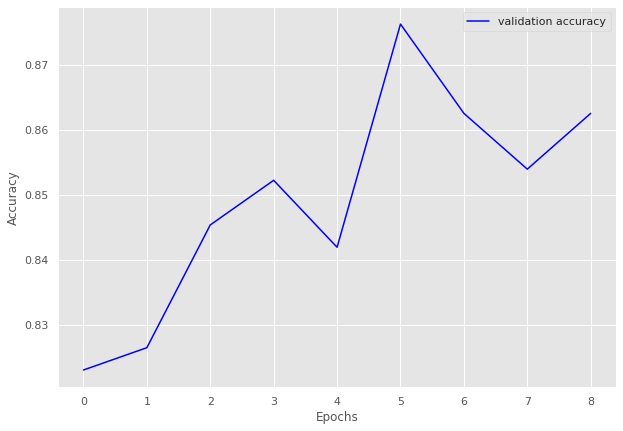

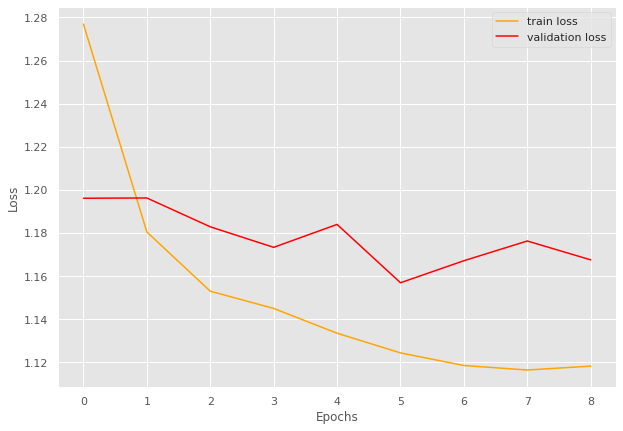

{'0': {'coarse': {'00': 0.8344144759303517, '10': 0.7350631614885627, '20': 0.6717065795249476, '30': 0.587328683607277, '50': 0.4409598595327513, '80': 0.2362093352192362}, 'fine': {'00': {'0': 0.9762140733399405, '1': 0.9764150943396226, '2': 0.9572277227722772, '3': 0.973404255319149, '4': 0.99644128113879, '5': 0.9815242494226328, '7': 0.9389619883040936, '8': 0.9871175523349437, '9': 0.8673469387755102, '11': 0.9451642060861706, '12': 0.9523012552301255, '14': 0.9555808656036446, '15': 0.9640077821011673}, '10': {'0': 0.8848780487804878, '1': 0.8422535211267606, '2': 0.8879103282626101, '3': 0.9231638418079096, '4': 0.9256505576208178, '5': 0.906885758998435, '7': 0.8858381502890174, '8': 0.9591503267973857, '9': 0.7749469214437368, '11': 0.8723911747167561, '12': 0.9203319502074688, '14': 0.8818380743982495, '15': 0.8033088235294118}, '20': {'0': 0.8442064264849075, '1': 0.7038567493112947, '2': 0.8205027494108406, '3': 0.8527889591719379, '4': 0.8386075949367089, '5': 0.80940794

100%|██████████| 114/114 [00:40<00:00,  2.81batch/s, loss=1.24]


train loss 1.2388417417542976, validation loss 1.140624589390225, validation accuracy 0.8948374760994264
Coarse label 9 Epoch 2
-------------------------------


 76%|███████▋  | 87/114 [00:31<00:09,  2.90batch/s, loss=1.15]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

100%|██████████| 214/214 [01:17<00:00,  2.75batch/s, loss=1.47]


train loss 1.4744834911043398, validation loss 1.5043553965432304, validation accuracy 0.8731428571428571
Coarse label 13 Epoch 4
-------------------------------


100%|██████████| 214/214 [01:17<00:00,  2.75batch/s, loss=1.47]


train loss 1.4660707255390202, validation loss 1.4889783007758004, validation accuracy 0.8845714285714286
Coarse label 13 Epoch 5
-------------------------------


100%|██████████| 214/214 [01:17<00:00,  2.77batch/s, loss=1.47]


INFO: Early stopping counter 1 of 5
train loss 1.4660009569096788, validation loss 1.5065629822867257, validation accuracy 0.8651428571428571
Coarse label 13 Epoch 6
-------------------------------


100%|██████████| 214/214 [01:17<00:00,  2.78batch/s, loss=1.46]


INFO: Early stopping counter 2 of 5
train loss 1.4582959630779018, validation loss 1.4934785280908858, validation accuracy 0.8811428571428571
Coarse label 13 Epoch 7
-------------------------------


100%|██████████| 214/214 [01:16<00:00,  2.81batch/s, loss=1.45]


INFO: Early stopping counter 3 of 5
train loss 1.4532136449189943, validation loss 1.4891184909003121, validation accuracy 0.8822857142857143
Coarse label 13 Epoch 8
-------------------------------


100%|██████████| 214/214 [01:17<00:00,  2.76batch/s, loss=1.45]


INFO: Early stopping counter 4 of 5
train loss 1.4495331188228642, validation loss 1.5035557235990251, validation accuracy 0.8662857142857143
Coarse label 13 Epoch 9
-------------------------------


100%|██████████| 214/214 [01:16<00:00,  2.78batch/s, loss=1.45]


INFO: Early stopping counter 5 of 5
INFO: Early stopping
Done! Saved model with test accuracy 0.8986564299424185 and loss 1.4727170002169725


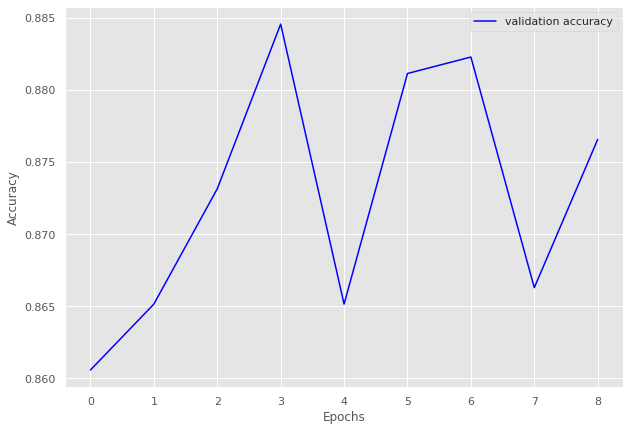

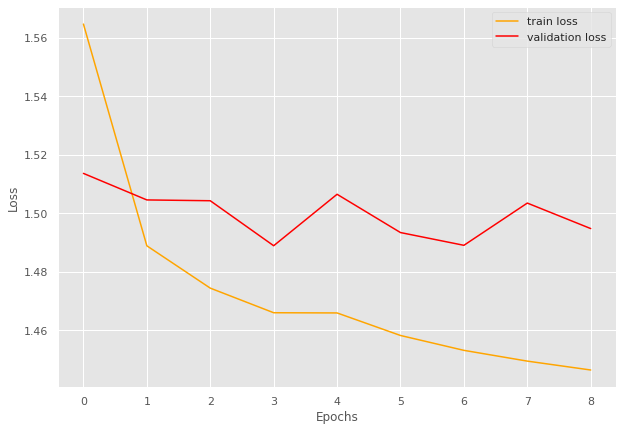

{'0': {'coarse': {'00': 0.8344144759303517, '10': 0.7350631614885627, '20': 0.6717065795249476, '30': 0.587328683607277, '50': 0.4409598595327513, '80': 0.2362093352192362}, 'fine': {'00': {'0': 0.9762140733399405, '1': 0.9764150943396226, '2': 0.9572277227722772, '3': 0.973404255319149, '4': 0.99644128113879, '5': 0.9815242494226328, '7': 0.9389619883040936, '8': 0.9871175523349437, '9': 0.8673469387755102, '11': 0.9451642060861706, '12': 0.9523012552301255, '14': 0.9555808656036446, '15': 0.9640077821011673}, '10': {'0': 0.8848780487804878, '1': 0.8422535211267606, '2': 0.8879103282626101, '3': 0.9231638418079096, '4': 0.9256505576208178, '5': 0.906885758998435, '7': 0.8858381502890174, '8': 0.9591503267973857, '9': 0.7749469214437368, '11': 0.8723911747167561, '12': 0.9203319502074688, '14': 0.8818380743982495, '15': 0.8033088235294118}, '20': {'0': 0.8442064264849075, '1': 0.7038567493112947, '2': 0.8205027494108406, '3': 0.8527889591719379, '4': 0.8386075949367089, '5': 0.80940794

100%|██████████| 35/35 [00:12<00:00,  2.88batch/s, loss=0.772]


train loss 0.7719384142330714, validation loss 0.7296754916508993, validation accuracy 0.8100558659217877
Coarse label 14 Epoch 2
-------------------------------


100%|██████████| 35/35 [00:12<00:00,  2.91batch/s, loss=0.64] 


train loss 0.6398266673088073, validation loss 0.7150855461756388, validation accuracy 0.8212290502793296
Coarse label 14 Epoch 3
-------------------------------


 43%|████▎     | 15/35 [00:05<00:07,  2.77batch/s, loss=0.625]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



train loss 0.32004531792231966, validation loss 0.39950351417064667, validation accuracy 0.8979591836734694
Coarse label 18 Epoch 5
-------------------------------


100%|██████████| 14/14 [00:04<00:00,  2.86batch/s, loss=0.319]


INFO: Early stopping counter 2 of 5
train loss 0.319188728928566, validation loss 0.4200240224599838, validation accuracy 0.8775510204081632
Coarse label 18 Epoch 6
-------------------------------


100%|██████████| 14/14 [00:04<00:00,  2.90batch/s, loss=0.316]


INFO: Early stopping counter 3 of 5
train loss 0.3164903372526169, validation loss 0.442139208316803, validation accuracy 0.8571428571428571
Coarse label 18 Epoch 7
-------------------------------


100%|██████████| 14/14 [00:05<00:00,  2.71batch/s, loss=0.316]


train loss 0.3164856327431543, validation loss 0.396148681640625, validation accuracy 0.8979591836734694
Coarse label 18 Epoch 8
-------------------------------


100%|██████████| 14/14 [00:04<00:00,  2.83batch/s, loss=0.317]


INFO: Early stopping counter 4 of 5
train loss 0.3166816064289638, validation loss 0.3992544412612915, validation accuracy 0.8979591836734694
Coarse label 18 Epoch 9
-------------------------------


100%|██████████| 14/14 [00:04<00:00,  2.95batch/s, loss=0.315]


INFO: Early stopping counter 5 of 5
INFO: Early stopping
Done! Saved model with test accuracy 0.8670520231213873 and loss 0.4357401231924693


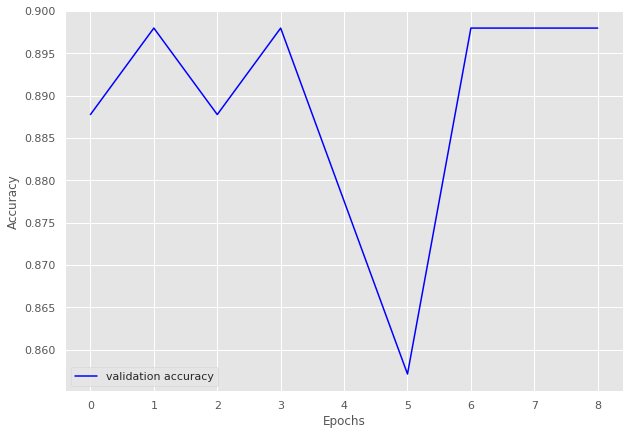

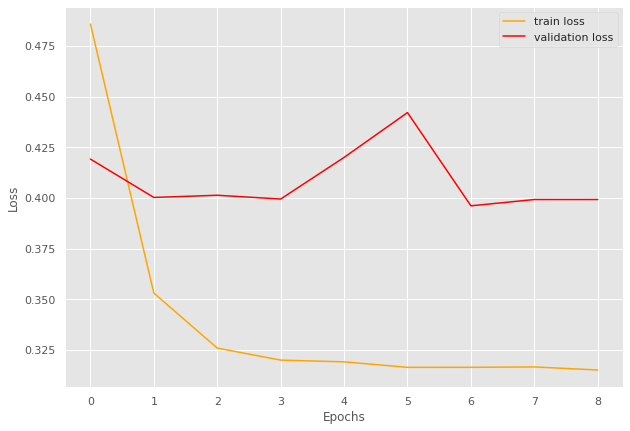

{'0': {'coarse': {'00': 0.8344144759303517, '10': 0.7350631614885627, '20': 0.6717065795249476, '30': 0.587328683607277, '50': 0.4409598595327513, '80': 0.2362093352192362}, 'fine': {'00': {'0': 0.9762140733399405, '1': 0.9764150943396226, '2': 0.9572277227722772, '3': 0.973404255319149, '4': 0.99644128113879, '5': 0.9815242494226328, '7': 0.9389619883040936, '8': 0.9871175523349437, '9': 0.8673469387755102, '11': 0.9451642060861706, '12': 0.9523012552301255, '14': 0.9555808656036446, '15': 0.9640077821011673}, '10': {'0': 0.8848780487804878, '1': 0.8422535211267606, '2': 0.8879103282626101, '3': 0.9231638418079096, '4': 0.9256505576208178, '5': 0.906885758998435, '7': 0.8858381502890174, '8': 0.9591503267973857, '9': 0.7749469214437368, '11': 0.8723911747167561, '12': 0.9203319502074688, '14': 0.8818380743982495, '15': 0.8033088235294118}, '20': {'0': 0.8442064264849075, '1': 0.7038567493112947, '2': 0.8205027494108406, '3': 0.8527889591719379, '4': 0.8386075949367089, '5': 0.80940794

100%|██████████| 20/20 [00:06<00:00,  2.92batch/s, loss=0.852]


train loss 0.8515853822231293, validation loss 0.8951650857925415, validation accuracy 0.59375
Coarse label 19 Epoch 2
-------------------------------


100%|██████████| 20/20 [00:07<00:00,  2.82batch/s, loss=0.655]


train loss 0.6547004967927933, validation loss 0.8537294864654541, validation accuracy 0.640625
Coarse label 19 Epoch 3
-------------------------------


100%|██████████| 20/20 [00:06<00:00,  2.93batch/s, loss=0.593]


INFO: Early stopping counter 1 of 5
train loss 0.5927764862775803, validation loss 0.864867627620697, validation accuracy 0.640625
Coarse label 19 Epoch 4
-------------------------------


100%|██████████| 20/20 [00:07<00:00,  2.85batch/s, loss=0.578]


INFO: Early stopping counter 2 of 5
train loss 0.5779907673597335, validation loss 0.8656343221664429, validation accuracy 0.65625
Coarse label 19 Epoch 5
-------------------------------


100%|██████████| 20/20 [00:06<00:00,  2.96batch/s, loss=0.574]


INFO: Early stopping counter 3 of 5
train loss 0.5741039931774139, validation loss 0.8650913238525391, validation accuracy 0.65625
Coarse label 19 Epoch 6
-------------------------------


100%|██████████| 20/20 [00:06<00:00,  2.94batch/s, loss=0.573]


train loss 0.5729370445013047, validation loss 0.8285479545593262, validation accuracy 0.703125
Coarse label 19 Epoch 7
-------------------------------


100%|██████████| 20/20 [00:06<00:00,  2.90batch/s, loss=0.568]


train loss 0.5677661418914794, validation loss 0.8258728981018066, validation accuracy 0.71875
Coarse label 19 Epoch 8
-------------------------------


100%|██████████| 20/20 [00:06<00:00,  2.88batch/s, loss=0.565]


INFO: Early stopping counter 4 of 5
train loss 0.5654717773199082, validation loss 0.832383394241333, validation accuracy 0.703125
Coarse label 19 Epoch 9
-------------------------------


100%|██████████| 20/20 [00:06<00:00,  2.93batch/s, loss=0.563]


INFO: Early stopping counter 5 of 5
INFO: Early stopping
Done! Saved model with test accuracy 0.8132780082987552 and loss 0.716420441865921


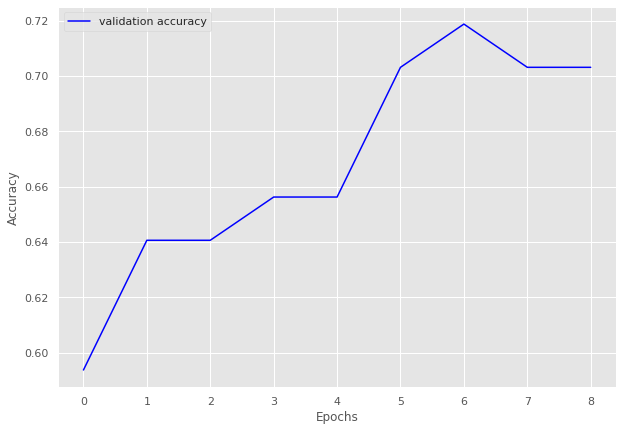

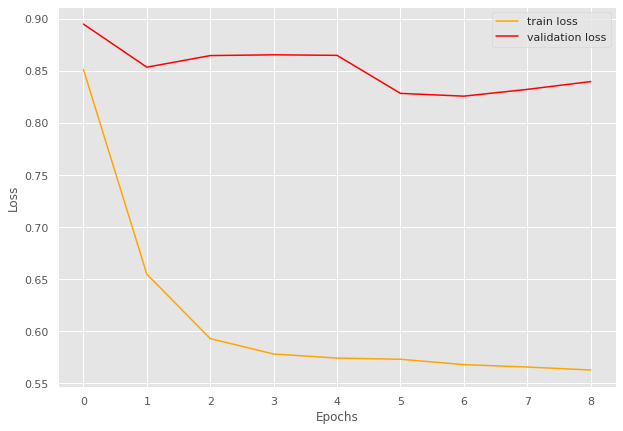

{'0': {'coarse': {'00': 0.8344144759303517, '10': 0.7350631614885627, '20': 0.6717065795249476, '30': 0.587328683607277, '50': 0.4409598595327513, '80': 0.2362093352192362}, 'fine': {'00': {'0': 0.9762140733399405, '1': 0.9764150943396226, '2': 0.9572277227722772, '3': 0.973404255319149, '4': 0.99644128113879, '5': 0.9815242494226328, '7': 0.9389619883040936, '8': 0.9871175523349437, '9': 0.8673469387755102, '11': 0.9451642060861706, '12': 0.9523012552301255, '14': 0.9555808656036446, '15': 0.9640077821011673}, '10': {'0': 0.8848780487804878, '1': 0.8422535211267606, '2': 0.8879103282626101, '3': 0.9231638418079096, '4': 0.9256505576208178, '5': 0.906885758998435, '7': 0.8858381502890174, '8': 0.9591503267973857, '9': 0.7749469214437368, '11': 0.8723911747167561, '12': 0.9203319502074688, '14': 0.8818380743982495, '15': 0.8033088235294118}, '20': {'0': 0.8442064264849075, '1': 0.7038567493112947, '2': 0.8205027494108406, '3': 0.8527889591719379, '4': 0.8386075949367089, '5': 0.80940794

Calculating for label_noise 20
split_20_1
Start training a coarse model
Epoch 1
-------------------------------


 73%|███████▎  | 1205/1640 [07:12<02:34,  2.82batch/s, loss=2.59]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

100%|██████████| 1640/1640 [09:48<00:00,  2.78batch/s, loss=2.45]


train loss 2.4523899091453085, validation loss 2.447187993909929, validation accuracy 0.6308079151634416
Epoch 4
-------------------------------


 47%|████▋     | 765/1640 [04:35<05:15,  2.77batch/s, loss=2.44]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

100%|██████████| 1640/1640 [10:50<00:00,  2.52batch/s, loss=2.43]


train loss 2.431227853676168, validation loss 2.4308775171533332, validation accuracy 0.6474253853722532
Epoch 6
-------------------------------


100%|██████████| 1640/1640 [09:51<00:00,  2.77batch/s, loss=2.42]


INFO: Early stopping counter 1 of 5
train loss 2.4241864303263223, validation loss 2.4322592095061615, validation accuracy 0.6448015742866514
Epoch 7
-------------------------------


100%|██████████| 1640/1640 [11:44<00:00,  2.33batch/s, loss=2.41]


train loss 2.4062056044252906, validation loss 2.40011404611014, validation accuracy 0.6790204438613753
Epoch 8
-------------------------------


100%|██████████| 1640/1640 [09:53<00:00,  2.76batch/s, loss=2.39]


train loss 2.3937779589397152, validation loss 2.3973116091081312, validation accuracy 0.6810976276374767
Epoch 9
-------------------------------


100%|██████████| 1640/1640 [11:46<00:00,  2.32batch/s, loss=2.39]


INFO: Early stopping counter 2 of 5
train loss 2.3886938909204996, validation loss 2.4000022428019063, validation accuracy 0.6780365147042746
Epoch 10
-------------------------------


100%|██████████| 1640/1640 [09:52<00:00,  2.77batch/s, loss=2.39]


train loss 2.3866971295054364, validation loss 2.392211058756688, validation accuracy 0.68568929703728
Epoch 11
-------------------------------


100%|██████████| 1640/1640 [09:53<00:00,  2.76batch/s, loss=2.38]


INFO: Early stopping counter 3 of 5
train loss 2.3832252940026724, validation loss 2.396142724510673, validation accuracy 0.6816442549469771
Epoch 12
-------------------------------


100%|██████████| 1640/1640 [09:51<00:00,  2.77batch/s, loss=2.38]


train loss 2.378638154559019, validation loss 2.3885892087763008, validation accuracy 0.6892970372799825
Epoch 13
-------------------------------


100%|██████████| 1640/1640 [11:18<00:00,  2.42batch/s, loss=2.38]


train loss 2.3760989680522826, validation loss 2.388168059862577, validation accuracy 0.690062315513283
Epoch 14
-------------------------------


100%|██████████| 1640/1640 [09:52<00:00,  2.77batch/s, loss=2.37]


train loss 2.372385044068825, validation loss 2.3834011104557065, validation accuracy 0.6952006122225867
Epoch 15
-------------------------------


100%|██████████| 1640/1640 [10:27<00:00,  2.61batch/s, loss=2.37]


INFO: Early stopping counter 4 of 5
train loss 2.3691275736180746, validation loss 2.3872866997352014, validation accuracy 0.6901716409751831
Epoch 16
-------------------------------


100%|██████████| 1640/1640 [10:48<00:00,  2.53batch/s, loss=2.37]


INFO: Early stopping counter 5 of 5
INFO: Early stopping
Done! Saved model with test accuracy 0.6807296493196118 and loss 2.3980377544866545


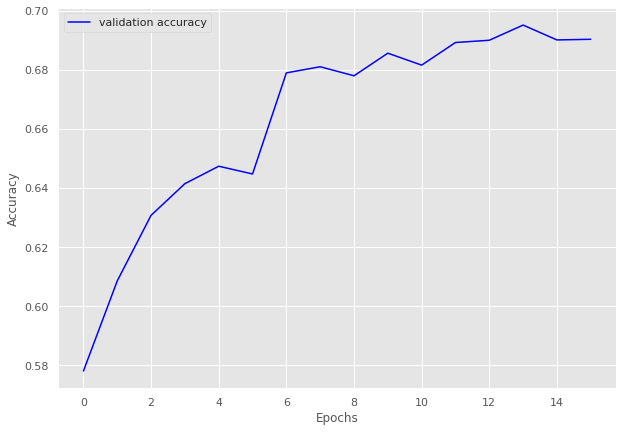

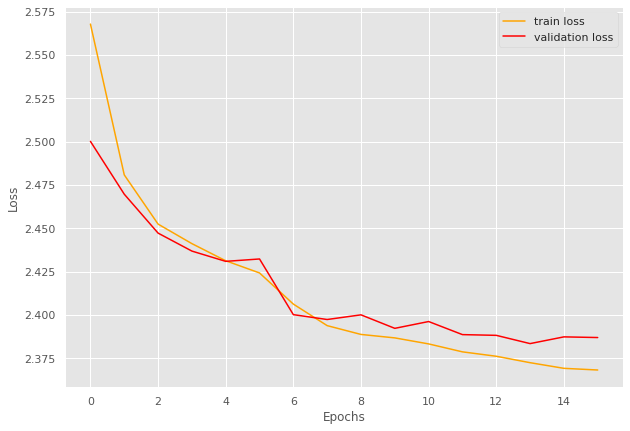

{'0': {'coarse': {'00': 0.8344144759303517, '10': 0.7350631614885627, '20': 0.6717065795249476, '30': 0.587328683607277, '50': 0.4409598595327513, '80': 0.2362093352192362}, 'fine': {'00': {'0': 0.9762140733399405, '1': 0.9764150943396226, '2': 0.9572277227722772, '3': 0.973404255319149, '4': 0.99644128113879, '5': 0.9815242494226328, '7': 0.9389619883040936, '8': 0.9871175523349437, '9': 0.8673469387755102, '11': 0.9451642060861706, '12': 0.9523012552301255, '14': 0.9555808656036446, '15': 0.9640077821011673}, '10': {'0': 0.8848780487804878, '1': 0.8422535211267606, '2': 0.8879103282626101, '3': 0.9231638418079096, '4': 0.9256505576208178, '5': 0.906885758998435, '7': 0.8858381502890174, '8': 0.9591503267973857, '9': 0.7749469214437368, '11': 0.8723911747167561, '12': 0.9203319502074688, '14': 0.8818380743982495, '15': 0.8033088235294118}, '20': {'0': 0.8442064264849075, '1': 0.7038567493112947, '2': 0.8205027494108406, '3': 0.8527889591719379, '4': 0.8386075949367089, '5': 0.80940794

100%|██████████| 89/89 [00:31<00:00,  2.78batch/s, loss=1.15]


train loss 1.153713064917018, validation loss 1.070975399017334, validation accuracy 0.8286163522012578
Coarse label 0 Epoch 2
-------------------------------


100%|██████████| 89/89 [00:31<00:00,  2.80batch/s, loss=1.06]


train loss 1.0570429235361936, validation loss 1.0696444630622863, validation accuracy 0.8286163522012578
Coarse label 0 Epoch 3
-------------------------------


100%|██████████| 89/89 [00:31<00:00,  2.80batch/s, loss=1.03]


INFO: Early stopping counter 1 of 5
train loss 1.0310188203715207, validation loss 1.0831625580787658, validation accuracy 0.8160377358490566
Coarse label 0 Epoch 4
-------------------------------


100%|██████████| 89/89 [00:32<00:00,  2.77batch/s, loss=1.02]


train loss 1.0219522004716852, validation loss 1.064621591567993, validation accuracy 0.8364779874213837
Coarse label 0 Epoch 5
-------------------------------


100%|██████████| 89/89 [00:31<00:00,  2.79batch/s, loss=1.01] 


INFO: Early stopping counter 2 of 5
train loss 1.0054507108216875, validation loss 1.0800473093986511, validation accuracy 0.8191823899371069
Coarse label 0 Epoch 6
-------------------------------


100%|██████████| 89/89 [00:31<00:00,  2.80batch/s, loss=1]    


INFO: Early stopping counter 3 of 5
train loss 1.004498083269998, validation loss 1.0702973127365112, validation accuracy 0.8317610062893082
Coarse label 0 Epoch 7
-------------------------------


100%|██████████| 89/89 [00:31<00:00,  2.78batch/s, loss=0.999]


INFO: Early stopping counter 4 of 5
train loss 0.99852350990424, validation loss 1.0752916574478149, validation accuracy 0.8254716981132075
Coarse label 0 Epoch 8
-------------------------------


100%|██████████| 89/89 [00:31<00:00,  2.79batch/s, loss=0.993]


train loss 0.9927660267004806, validation loss 1.060871809720993, validation accuracy 0.8411949685534591
Coarse label 0 Epoch 9
-------------------------------


100%|██████████| 89/89 [00:32<00:00,  2.76batch/s, loss=0.985]


train loss 0.9851514201485709, validation loss 1.0532236576080323, validation accuracy 0.85062893081761
Coarse label 0 Epoch 10
-------------------------------


100%|██████████| 89/89 [00:31<00:00,  2.79batch/s, loss=0.975]


INFO: Early stopping counter 5 of 5
INFO: Early stopping
Done! Saved model with test accuracy 0.8456014362657092 and loss 1.077429582675298


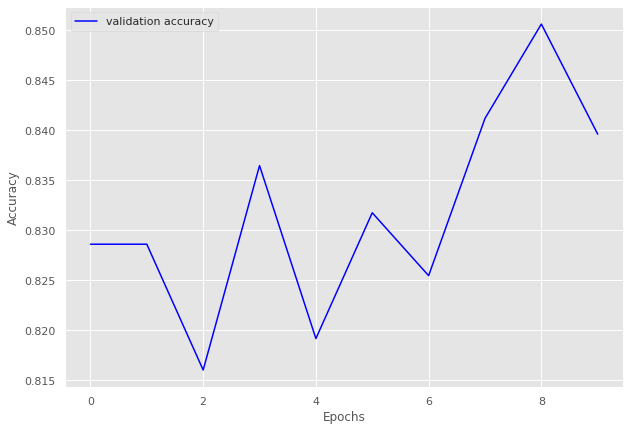

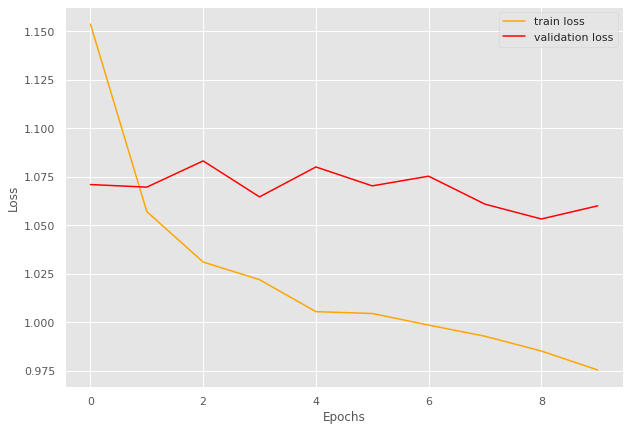

{'0': {'coarse': {'00': 0.8344144759303517, '10': 0.7350631614885627, '20': 0.6717065795249476, '30': 0.587328683607277, '50': 0.4409598595327513, '80': 0.2362093352192362}, 'fine': {'00': {'0': 0.9762140733399405, '1': 0.9764150943396226, '2': 0.9572277227722772, '3': 0.973404255319149, '4': 0.99644128113879, '5': 0.9815242494226328, '7': 0.9389619883040936, '8': 0.9871175523349437, '9': 0.8673469387755102, '11': 0.9451642060861706, '12': 0.9523012552301255, '14': 0.9555808656036446, '15': 0.9640077821011673}, '10': {'0': 0.8848780487804878, '1': 0.8422535211267606, '2': 0.8879103282626101, '3': 0.9231638418079096, '4': 0.9256505576208178, '5': 0.906885758998435, '7': 0.8858381502890174, '8': 0.9591503267973857, '9': 0.7749469214437368, '11': 0.8723911747167561, '12': 0.9203319502074688, '14': 0.8818380743982495, '15': 0.8033088235294118}, '20': {'0': 0.8442064264849075, '1': 0.7038567493112947, '2': 0.8205027494108406, '3': 0.8527889591719379, '4': 0.8386075949367089, '5': 0.80940794

100%|██████████| 70/70 [00:25<00:00,  2.79batch/s, loss=0.718]


train loss 0.7178132091249738, validation loss 0.7762236396471659, validation accuracy 0.7643979057591623
Coarse label 1 Epoch 2
-------------------------------


100%|██████████| 70/70 [00:25<00:00,  2.76batch/s, loss=0.645]


train loss 0.6452053930078234, validation loss 0.7722784876823425, validation accuracy 0.774869109947644
Coarse label 1 Epoch 3
-------------------------------


100%|██████████| 70/70 [00:25<00:00,  2.79batch/s, loss=0.626]


train loss 0.6260792621544429, validation loss 0.7550996343294779, validation accuracy 0.7905759162303665
Coarse label 1 Epoch 4
-------------------------------


100%|██████████| 70/70 [00:25<00:00,  2.79batch/s, loss=0.61] 


train loss 0.6097288685185569, validation loss 0.7398459911346436, validation accuracy 0.8167539267015707
Coarse label 1 Epoch 5
-------------------------------


100%|██████████| 70/70 [00:24<00:00,  2.80batch/s, loss=0.607]


INFO: Early stopping counter 1 of 5
train loss 0.607350811788014, validation loss 0.7453123529752096, validation accuracy 0.8010471204188482
Coarse label 1 Epoch 6
-------------------------------


100%|██████████| 70/70 [00:25<00:00,  2.80batch/s, loss=0.606]


INFO: Early stopping counter 2 of 5
train loss 0.6060504181044443, validation loss 0.7824318806330363, validation accuracy 0.743455497382199
Coarse label 1 Epoch 7
-------------------------------


100%|██████████| 70/70 [00:24<00:00,  2.80batch/s, loss=0.602]


INFO: Early stopping counter 3 of 5
train loss 0.6019922426768711, validation loss 0.8003968993822733, validation accuracy 0.7539267015706806
Coarse label 1 Epoch 8
-------------------------------


100%|██████████| 70/70 [00:25<00:00,  2.79batch/s, loss=0.601]


INFO: Early stopping counter 4 of 5
train loss 0.6010782599449158, validation loss 0.7867706418037415, validation accuracy 0.7486910994764397
Coarse label 1 Epoch 9
-------------------------------


100%|██████████| 70/70 [00:25<00:00,  2.80batch/s, loss=0.594]


INFO: Early stopping counter 5 of 5
INFO: Early stopping
Done! Saved model with test accuracy 0.8891566265060241 and loss 0.6606104924128606


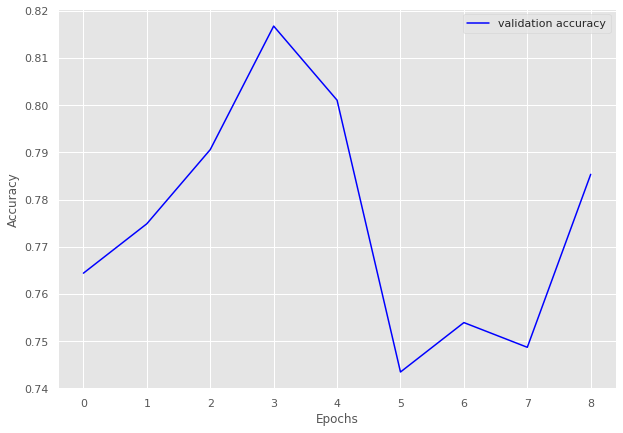

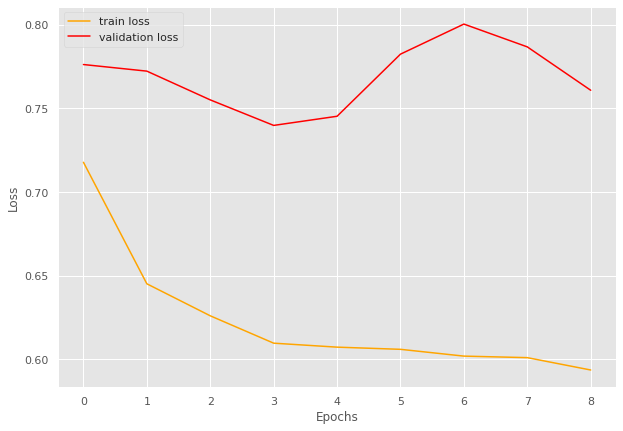

{'0': {'coarse': {'00': 0.8344144759303517, '10': 0.7350631614885627, '20': 0.6717065795249476, '30': 0.587328683607277, '50': 0.4409598595327513, '80': 0.2362093352192362}, 'fine': {'00': {'0': 0.9762140733399405, '1': 0.9764150943396226, '2': 0.9572277227722772, '3': 0.973404255319149, '4': 0.99644128113879, '5': 0.9815242494226328, '7': 0.9389619883040936, '8': 0.9871175523349437, '9': 0.8673469387755102, '11': 0.9451642060861706, '12': 0.9523012552301255, '14': 0.9555808656036446, '15': 0.9640077821011673}, '10': {'0': 0.8848780487804878, '1': 0.8422535211267606, '2': 0.8879103282626101, '3': 0.9231638418079096, '4': 0.9256505576208178, '5': 0.906885758998435, '7': 0.8858381502890174, '8': 0.9591503267973857, '9': 0.7749469214437368, '11': 0.8723911747167561, '12': 0.9203319502074688, '14': 0.8818380743982495, '15': 0.8033088235294118}, '20': {'0': 0.8442064264849075, '1': 0.7038567493112947, '2': 0.8205027494108406, '3': 0.8527889591719379, '4': 0.8386075949367089, '5': 0.80940794

100%|██████████| 202/202 [01:12<00:00,  2.78batch/s, loss=1.9] 


train loss 1.9018956700173935, validation loss 1.8167519255688316, validation accuracy 0.7123050259965338
Coarse label 2 Epoch 2
-------------------------------


100%|██████████| 202/202 [01:13<00:00,  2.76batch/s, loss=1.8]


train loss 1.7982715574821624, validation loss 1.7881642140840228, validation accuracy 0.74263431542461
Coarse label 2 Epoch 3
-------------------------------


100%|██████████| 202/202 [01:13<00:00,  2.75batch/s, loss=1.77]


train loss 1.7727327895636606, validation loss 1.762884547835902, validation accuracy 0.7720970537261699
Coarse label 2 Epoch 4
-------------------------------


100%|██████████| 202/202 [01:13<00:00,  2.76batch/s, loss=1.76]


INFO: Early stopping counter 1 of 5
train loss 1.7581829936197488, validation loss 1.7705263840524774, validation accuracy 0.7582322357019065
Coarse label 2 Epoch 5
-------------------------------


100%|██████████| 202/202 [01:12<00:00,  2.78batch/s, loss=1.75]


INFO: Early stopping counter 2 of 5
train loss 1.7485855316171552, validation loss 1.7719783281025134, validation accuracy 0.7564991334488734
Coarse label 2 Epoch 6
-------------------------------


100%|██████████| 202/202 [01:12<00:00,  2.77batch/s, loss=1.74]


train loss 1.738648754535335, validation loss 1.757666355685184, validation accuracy 0.7712305025996534
Coarse label 2 Epoch 7
-------------------------------


100%|██████████| 202/202 [01:12<00:00,  2.77batch/s, loss=1.73]


train loss 1.7296847683368344, validation loss 1.7542737596913387, validation accuracy 0.7746967071057193
Coarse label 2 Epoch 8
-------------------------------


100%|██████████| 202/202 [01:42<00:00,  1.96batch/s, loss=1.72]


INFO: Early stopping counter 3 of 5
train loss 1.7200594892596255, validation loss 1.7544059690676237, validation accuracy 0.7746967071057193
Coarse label 2 Epoch 9
-------------------------------


100%|██████████| 202/202 [02:29<00:00,  1.35batch/s, loss=1.72]


train loss 1.7167084641975932, validation loss 1.747470686310216, validation accuracy 0.7859618717504333
Coarse label 2 Epoch 10
-------------------------------


100%|██████████| 202/202 [01:13<00:00,  2.76batch/s, loss=1.71]


INFO: Early stopping counter 4 of 5
train loss 1.7125725958606985, validation loss 1.7642326982397782, validation accuracy 0.7642980935875217
Coarse label 2 Epoch 11
-------------------------------


100%|██████████| 202/202 [01:13<00:00,  2.74batch/s, loss=1.71]


INFO: Early stopping counter 5 of 5
INFO: Early stopping
Done! Saved model with test accuracy 0.7653740697218958 and loss 1.7774730741977691


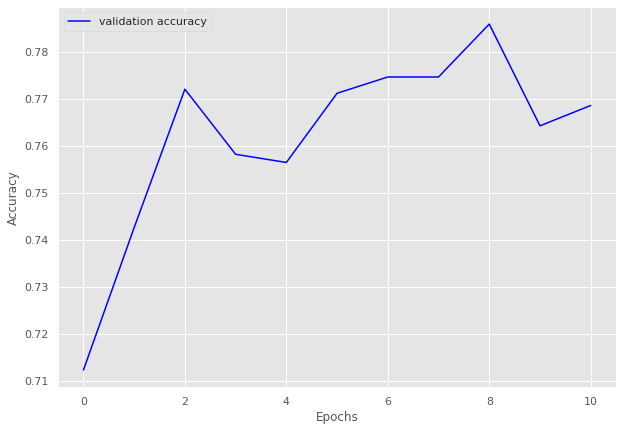

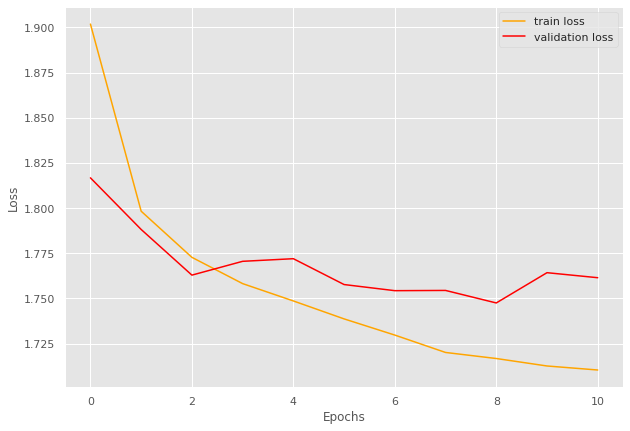

{'0': {'coarse': {'00': 0.8344144759303517, '10': 0.7350631614885627, '20': 0.6717065795249476, '30': 0.587328683607277, '50': 0.4409598595327513, '80': 0.2362093352192362}, 'fine': {'00': {'0': 0.9762140733399405, '1': 0.9764150943396226, '2': 0.9572277227722772, '3': 0.973404255319149, '4': 0.99644128113879, '5': 0.9815242494226328, '7': 0.9389619883040936, '8': 0.9871175523349437, '9': 0.8673469387755102, '11': 0.9451642060861706, '12': 0.9523012552301255, '14': 0.9555808656036446, '15': 0.9640077821011673}, '10': {'0': 0.8848780487804878, '1': 0.8422535211267606, '2': 0.8879103282626101, '3': 0.9231638418079096, '4': 0.9256505576208178, '5': 0.906885758998435, '7': 0.8858381502890174, '8': 0.9591503267973857, '9': 0.7749469214437368, '11': 0.8723911747167561, '12': 0.9203319502074688, '14': 0.8818380743982495, '15': 0.8033088235294118}, '20': {'0': 0.8442064264849075, '1': 0.7038567493112947, '2': 0.8205027494108406, '3': 0.8527889591719379, '4': 0.8386075949367089, '5': 0.80940794

100%|██████████| 141/141 [00:53<00:00,  2.65batch/s, loss=1.59]


train loss 1.5889139767234206, validation loss 1.4922082821528118, validation accuracy 0.7783613445378151
Coarse label 4 Epoch 2
-------------------------------


100%|██████████| 141/141 [00:54<00:00,  2.57batch/s, loss=1.48]


train loss 1.4824573959864624, validation loss 1.480868117014567, validation accuracy 0.7909663865546218
Coarse label 4 Epoch 3
-------------------------------


100%|██████████| 141/141 [00:51<00:00,  2.75batch/s, loss=1.46]


train loss 1.4550930388430332, validation loss 1.4654946088790894, validation accuracy 0.805672268907563
Coarse label 4 Epoch 4
-------------------------------


100%|██████████| 141/141 [00:50<00:00,  2.78batch/s, loss=1.43]


train loss 1.4348739038967917, validation loss 1.4618435064951578, validation accuracy 0.8098739495798319
Coarse label 4 Epoch 5
-------------------------------


100%|██████████| 141/141 [00:49<00:00,  2.83batch/s, loss=1.43]


INFO: Early stopping counter 1 of 5
train loss 1.4306736068522676, validation loss 1.4670100291570027, validation accuracy 0.8046218487394958
Coarse label 4 Epoch 6
-------------------------------


100%|██████████| 141/141 [00:50<00:00,  2.79batch/s, loss=1.42]


INFO: Early stopping counter 2 of 5
train loss 1.4185565912977178, validation loss 1.474657901128133, validation accuracy 0.7972689075630253
Coarse label 4 Epoch 7
-------------------------------


100%|██████████| 141/141 [00:50<00:00,  2.78batch/s, loss=1.41]


INFO: Early stopping counter 3 of 5
train loss 1.4135293740752741, validation loss 1.4648266315460206, validation accuracy 0.805672268907563
Coarse label 4 Epoch 8
-------------------------------


100%|██████████| 141/141 [00:51<00:00,  2.76batch/s, loss=1.41]


train loss 1.407937266302447, validation loss 1.4615764141082763, validation accuracy 0.8098739495798319
Coarse label 4 Epoch 9
-------------------------------


100%|██████████| 141/141 [00:50<00:00,  2.79batch/s, loss=1.4]


INFO: Early stopping counter 4 of 5
train loss 1.3987490454464093, validation loss 1.4621761878331503, validation accuracy 0.8109243697478992
Coarse label 4 Epoch 10
-------------------------------


100%|██████████| 141/141 [00:50<00:00,  2.78batch/s, loss=1.4]


INFO: Early stopping counter 5 of 5
INFO: Early stopping
Done! Saved model with test accuracy 0.7811804008908686 and loss 1.5091338322080414


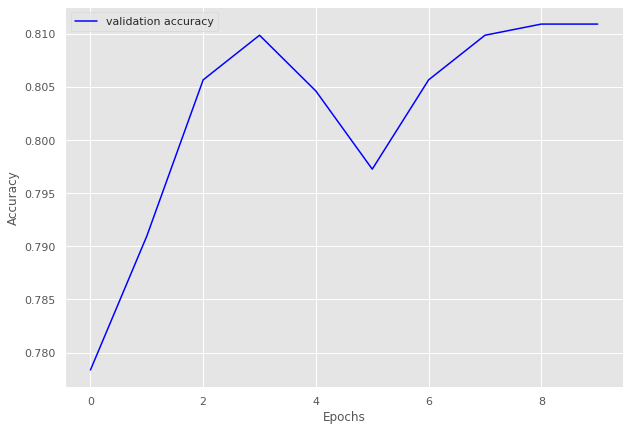

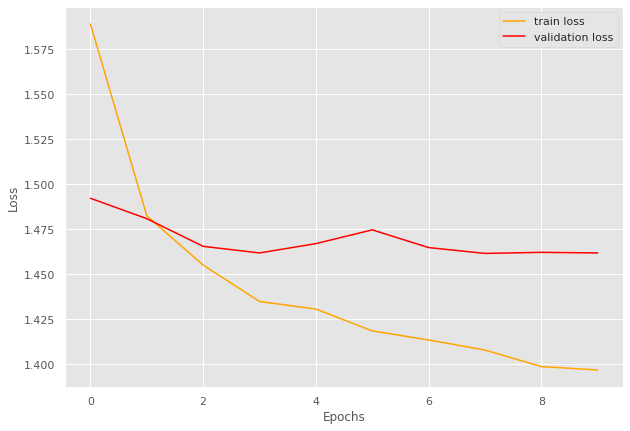

{'0': {'coarse': {'00': 0.8344144759303517, '10': 0.7350631614885627, '20': 0.6717065795249476, '30': 0.587328683607277, '50': 0.4409598595327513, '80': 0.2362093352192362}, 'fine': {'00': {'0': 0.9762140733399405, '1': 0.9764150943396226, '2': 0.9572277227722772, '3': 0.973404255319149, '4': 0.99644128113879, '5': 0.9815242494226328, '7': 0.9389619883040936, '8': 0.9871175523349437, '9': 0.8673469387755102, '11': 0.9451642060861706, '12': 0.9523012552301255, '14': 0.9555808656036446, '15': 0.9640077821011673}, '10': {'0': 0.8848780487804878, '1': 0.8422535211267606, '2': 0.8879103282626101, '3': 0.9231638418079096, '4': 0.9256505576208178, '5': 0.906885758998435, '7': 0.8858381502890174, '8': 0.9591503267973857, '9': 0.7749469214437368, '11': 0.8723911747167561, '12': 0.9203319502074688, '14': 0.8818380743982495, '15': 0.8033088235294118}, '20': {'0': 0.8442064264849075, '1': 0.7038567493112947, '2': 0.8205027494108406, '3': 0.8527889591719379, '4': 0.8386075949367089, '5': 0.80940794

100%|██████████| 116/116 [00:41<00:00,  2.81batch/s, loss=1.64]


train loss 1.6402824181934883, validation loss 1.5961883200539484, validation accuracy 0.6744604316546763
Coarse label 5 Epoch 2
-------------------------------


100%|██████████| 116/116 [00:41<00:00,  2.79batch/s, loss=1.53]


train loss 1.5271347822814152, validation loss 1.5854671663708158, validation accuracy 0.6870503597122302
Coarse label 5 Epoch 3
-------------------------------


100%|██████████| 116/116 [00:41<00:00,  2.80batch/s, loss=1.51]


INFO: Early stopping counter 1 of 5
train loss 1.5064184069633484, validation loss 1.6007138358222113, validation accuracy 0.6690647482014388
Coarse label 5 Epoch 4
-------------------------------


100%|██████████| 116/116 [00:41<00:00,  2.81batch/s, loss=1.48]


INFO: Early stopping counter 2 of 5
train loss 1.4824703993468449, validation loss 1.5941242244508531, validation accuracy 0.6780575539568345
Coarse label 5 Epoch 5
-------------------------------


100%|██████████| 116/116 [00:41<00:00,  2.81batch/s, loss=1.46]


train loss 1.4623355516071976, validation loss 1.5755402247111003, validation accuracy 0.6996402877697842
Coarse label 5 Epoch 6
-------------------------------


100%|██████████| 116/116 [00:41<00:00,  2.78batch/s, loss=1.45]


INFO: Early stopping counter 3 of 5
train loss 1.449517906739794, validation loss 1.5843319363064237, validation accuracy 0.6834532374100719
Coarse label 5 Epoch 7
-------------------------------


100%|██████████| 116/116 [00:47<00:00,  2.47batch/s, loss=1.44]


INFO: Early stopping counter 4 of 5
train loss 1.4442679645686314, validation loss 1.5835025707880657, validation accuracy 0.6888489208633094
Coarse label 5 Epoch 8
-------------------------------


100%|██████████| 116/116 [00:59<00:00,  1.96batch/s, loss=1.43]


INFO: Early stopping counter 5 of 5
INFO: Early stopping
Done! Saved model with test accuracy 0.709310113864702 and loss 1.562011902530988


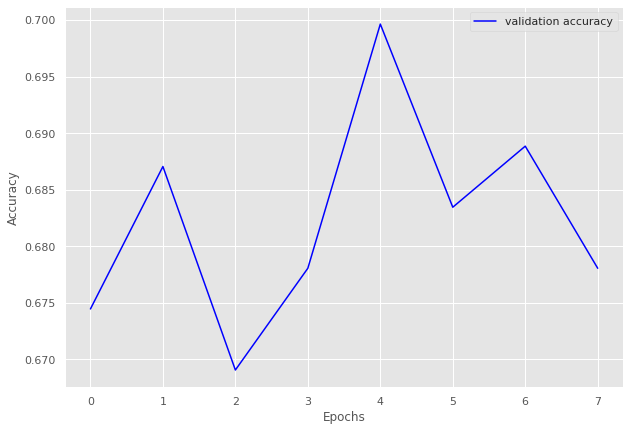

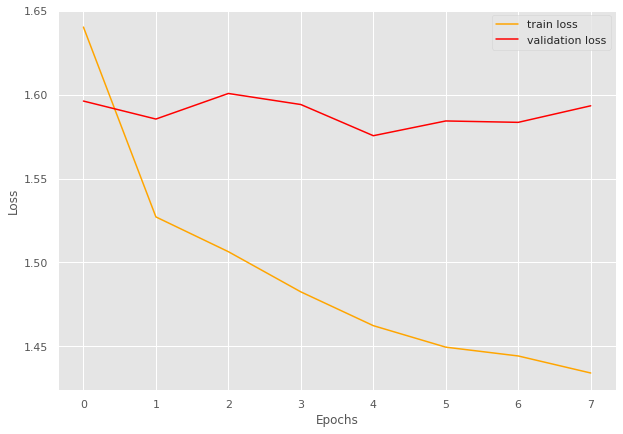

{'0': {'coarse': {'00': 0.8344144759303517, '10': 0.7350631614885627, '20': 0.6717065795249476, '30': 0.587328683607277, '50': 0.4409598595327513, '80': 0.2362093352192362}, 'fine': {'00': {'0': 0.9762140733399405, '1': 0.9764150943396226, '2': 0.9572277227722772, '3': 0.973404255319149, '4': 0.99644128113879, '5': 0.9815242494226328, '7': 0.9389619883040936, '8': 0.9871175523349437, '9': 0.8673469387755102, '11': 0.9451642060861706, '12': 0.9523012552301255, '14': 0.9555808656036446, '15': 0.9640077821011673}, '10': {'0': 0.8848780487804878, '1': 0.8422535211267606, '2': 0.8879103282626101, '3': 0.9231638418079096, '4': 0.9256505576208178, '5': 0.906885758998435, '7': 0.8858381502890174, '8': 0.9591503267973857, '9': 0.7749469214437368, '11': 0.8723911747167561, '12': 0.9203319502074688, '14': 0.8818380743982495, '15': 0.8033088235294118}, '20': {'0': 0.8442064264849075, '1': 0.7038567493112947, '2': 0.8205027494108406, '3': 0.8527889591719379, '4': 0.8386075949367089, '5': 0.80940794

100%|██████████| 25/25 [00:17<00:00,  1.40batch/s, loss=0.5]  


train loss 0.500349485874176, validation loss 0.4409817655881246, validation accuracy 0.8757763975155279
Coarse label 6 Epoch 2
-------------------------------


100%|██████████| 25/25 [00:20<00:00,  1.23batch/s, loss=0.373]


train loss 0.3733401644229889, validation loss 0.38906171917915344, validation accuracy 0.9316770186335404
Coarse label 6 Epoch 3
-------------------------------


100%|██████████| 25/25 [00:17<00:00,  1.45batch/s, loss=0.342]


INFO: Early stopping counter 1 of 5
train loss 0.3417949426174164, validation loss 0.41221652428309125, validation accuracy 0.906832298136646
Coarse label 6 Epoch 4
-------------------------------


100%|██████████| 25/25 [00:18<00:00,  1.34batch/s, loss=0.332]


INFO: Early stopping counter 2 of 5
train loss 0.3317953550815582, validation loss 0.4322165548801422, validation accuracy 0.8819875776397516
Coarse label 6 Epoch 5
-------------------------------


100%|██████████| 25/25 [00:18<00:00,  1.36batch/s, loss=0.324]


INFO: Early stopping counter 3 of 5
train loss 0.32352359771728517, validation loss 0.41364791989326477, validation accuracy 0.906832298136646
Coarse label 6 Epoch 6
-------------------------------


100%|██████████| 25/25 [00:19<00:00,  1.28batch/s, loss=0.32] 


INFO: Early stopping counter 4 of 5
train loss 0.32025676608085635, validation loss 0.4417639176050822, validation accuracy 0.8695652173913043
Coarse label 6 Epoch 7
-------------------------------


100%|██████████| 25/25 [00:20<00:00,  1.20batch/s, loss=0.32] 


INFO: Early stopping counter 5 of 5
INFO: Early stopping
Done! Saved model with test accuracy 0.8635014836795252 and loss 0.48671319087346393


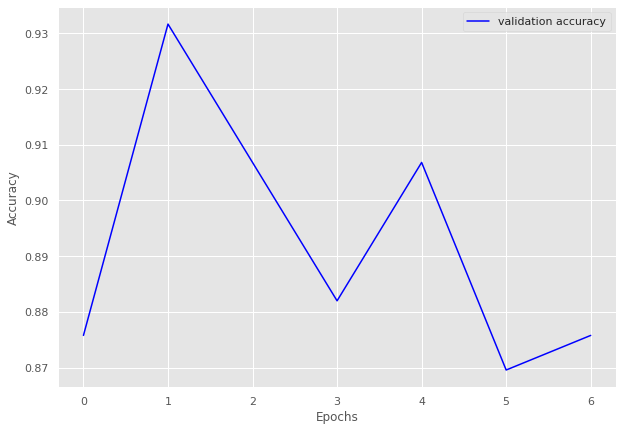

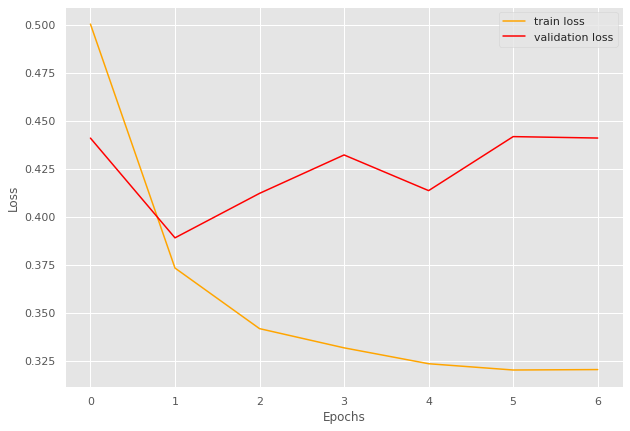

{'0': {'coarse': {'00': 0.8344144759303517, '10': 0.7350631614885627, '20': 0.6717065795249476, '30': 0.587328683607277, '50': 0.4409598595327513, '80': 0.2362093352192362}, 'fine': {'00': {'0': 0.9762140733399405, '1': 0.9764150943396226, '2': 0.9572277227722772, '3': 0.973404255319149, '4': 0.99644128113879, '5': 0.9815242494226328, '7': 0.9389619883040936, '8': 0.9871175523349437, '9': 0.8673469387755102, '11': 0.9451642060861706, '12': 0.9523012552301255, '14': 0.9555808656036446, '15': 0.9640077821011673}, '10': {'0': 0.8848780487804878, '1': 0.8422535211267606, '2': 0.8879103282626101, '3': 0.9231638418079096, '4': 0.9256505576208178, '5': 0.906885758998435, '7': 0.8858381502890174, '8': 0.9591503267973857, '9': 0.7749469214437368, '11': 0.8723911747167561, '12': 0.9203319502074688, '14': 0.8818380743982495, '15': 0.8033088235294118}, '20': {'0': 0.8442064264849075, '1': 0.7038567493112947, '2': 0.8205027494108406, '3': 0.8527889591719379, '4': 0.8386075949367089, '5': 0.80940794

100%|██████████| 68/68 [00:35<00:00,  1.94batch/s, loss=0.963]


train loss 0.9633084430414087, validation loss 0.8973438910075596, validation accuracy 0.8387850467289719
Coarse label 7 Epoch 2
-------------------------------


100%|██████████| 68/68 [00:24<00:00,  2.73batch/s, loss=0.874]


INFO: Early stopping counter 1 of 5
train loss 0.8736442669349558, validation loss 0.901244444506509, validation accuracy 0.8317757009345794
Coarse label 7 Epoch 3
-------------------------------


100%|██████████| 68/68 [00:24<00:00,  2.73batch/s, loss=0.847]


train loss 0.8466183709747651, validation loss 0.8971037524087089, validation accuracy 0.8411214953271028
Coarse label 7 Epoch 4
-------------------------------


100%|██████████| 68/68 [00:24<00:00,  2.77batch/s, loss=0.835]


INFO: Early stopping counter 2 of 5
train loss 0.8348137859035941, validation loss 0.9086050902094159, validation accuracy 0.822429906542056
Coarse label 7 Epoch 5
-------------------------------


100%|██████████| 68/68 [00:24<00:00,  2.77batch/s, loss=0.827]


INFO: Early stopping counter 3 of 5
train loss 0.826898488051751, validation loss 0.9046838368688311, validation accuracy 0.8341121495327103
Coarse label 7 Epoch 6
-------------------------------


100%|██████████| 68/68 [00:24<00:00,  2.77batch/s, loss=0.816]


train loss 0.8159094470388749, validation loss 0.8932085377829415, validation accuracy 0.8387850467289719
Coarse label 7 Epoch 7
-------------------------------


100%|██████████| 68/68 [00:25<00:00,  2.70batch/s, loss=0.808]


INFO: Early stopping counter 4 of 5
train loss 0.8079529536121032, validation loss 0.8945674811090741, validation accuracy 0.8411214953271028
Coarse label 7 Epoch 8
-------------------------------


100%|██████████| 68/68 [00:24<00:00,  2.79batch/s, loss=0.808]


INFO: Early stopping counter 5 of 5
INFO: Early stopping
Done! Saved model with test accuracy 0.8227114716106605 and loss 0.9229439241545541


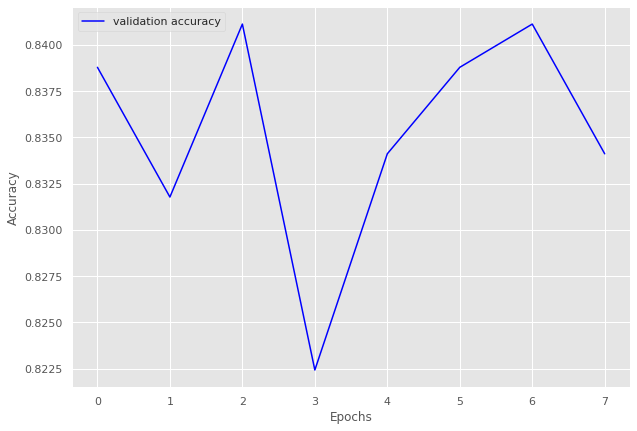

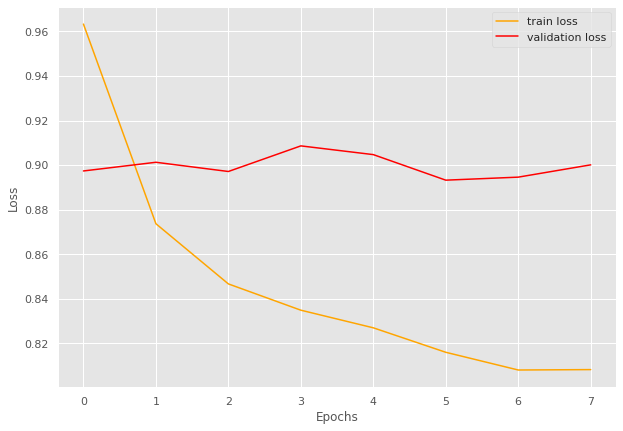

{'0': {'coarse': {'00': 0.8344144759303517, '10': 0.7350631614885627, '20': 0.6717065795249476, '30': 0.587328683607277, '50': 0.4409598595327513, '80': 0.2362093352192362}, 'fine': {'00': {'0': 0.9762140733399405, '1': 0.9764150943396226, '2': 0.9572277227722772, '3': 0.973404255319149, '4': 0.99644128113879, '5': 0.9815242494226328, '7': 0.9389619883040936, '8': 0.9871175523349437, '9': 0.8673469387755102, '11': 0.9451642060861706, '12': 0.9523012552301255, '14': 0.9555808656036446, '15': 0.9640077821011673}, '10': {'0': 0.8848780487804878, '1': 0.8422535211267606, '2': 0.8879103282626101, '3': 0.9231638418079096, '4': 0.9256505576208178, '5': 0.906885758998435, '7': 0.8858381502890174, '8': 0.9591503267973857, '9': 0.7749469214437368, '11': 0.8723911747167561, '12': 0.9203319502074688, '14': 0.8818380743982495, '15': 0.8033088235294118}, '20': {'0': 0.8442064264849075, '1': 0.7038567493112947, '2': 0.8205027494108406, '3': 0.8527889591719379, '4': 0.8386075949367089, '5': 0.80940794

100%|██████████| 86/86 [00:31<00:00,  2.75batch/s, loss=1.35]


train loss 1.3544697581335556, validation loss 1.2160088883505926, validation accuracy 0.8218694885361552
Coarse label 8 Epoch 2
-------------------------------


100%|██████████| 86/86 [00:30<00:00,  2.79batch/s, loss=1.25]


train loss 1.245441004287365, validation loss 1.2076107793384128, validation accuracy 0.8395061728395061
Coarse label 8 Epoch 3
-------------------------------


100%|██████████| 86/86 [00:30<00:00,  2.79batch/s, loss=1.21]


INFO: Early stopping counter 1 of 5
train loss 1.2110968675724296, validation loss 1.2167260646820068, validation accuracy 0.8253968253968254
Coarse label 8 Epoch 4
-------------------------------


100%|██████████| 86/86 [00:30<00:00,  2.78batch/s, loss=1.19]


INFO: Early stopping counter 2 of 5
train loss 1.1931595746860948, validation loss 1.2078338596555922, validation accuracy 0.8306878306878307
Coarse label 8 Epoch 5
-------------------------------


100%|██████████| 86/86 [00:31<00:00,  2.71batch/s, loss=1.18]


INFO: Early stopping counter 3 of 5
train loss 1.1759574191514837, validation loss 1.21318519115448, validation accuracy 0.8253968253968254
Coarse label 8 Epoch 6
-------------------------------


100%|██████████| 86/86 [00:31<00:00,  2.76batch/s, loss=1.17]


INFO: Early stopping counter 4 of 5
train loss 1.168472969254782, validation loss 1.2239015367296007, validation accuracy 0.8112874779541446
Coarse label 8 Epoch 7
-------------------------------


100%|██████████| 86/86 [00:30<00:00,  2.81batch/s, loss=1.16]


INFO: Early stopping counter 5 of 5
INFO: Early stopping
Done! Saved model with test accuracy 0.7655038759689923 and loss 1.2898391485214233


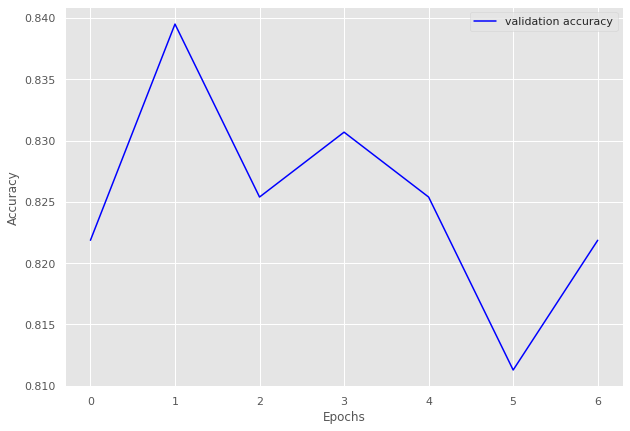

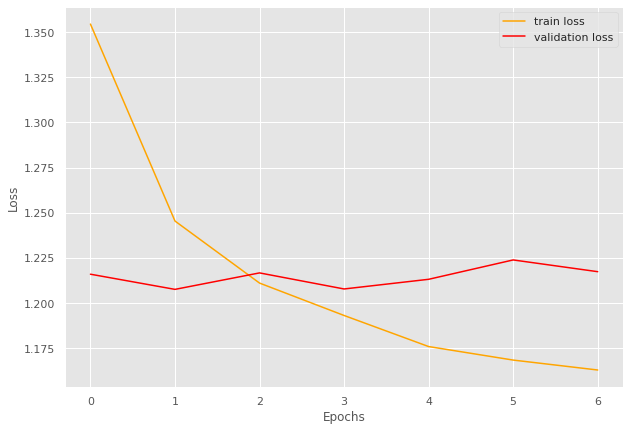

{'0': {'coarse': {'00': 0.8344144759303517, '10': 0.7350631614885627, '20': 0.6717065795249476, '30': 0.587328683607277, '50': 0.4409598595327513, '80': 0.2362093352192362}, 'fine': {'00': {'0': 0.9762140733399405, '1': 0.9764150943396226, '2': 0.9572277227722772, '3': 0.973404255319149, '4': 0.99644128113879, '5': 0.9815242494226328, '7': 0.9389619883040936, '8': 0.9871175523349437, '9': 0.8673469387755102, '11': 0.9451642060861706, '12': 0.9523012552301255, '14': 0.9555808656036446, '15': 0.9640077821011673}, '10': {'0': 0.8848780487804878, '1': 0.8422535211267606, '2': 0.8879103282626101, '3': 0.9231638418079096, '4': 0.9256505576208178, '5': 0.906885758998435, '7': 0.8858381502890174, '8': 0.9591503267973857, '9': 0.7749469214437368, '11': 0.8723911747167561, '12': 0.9203319502074688, '14': 0.8818380743982495, '15': 0.8033088235294118}, '20': {'0': 0.8442064264849075, '1': 0.7038567493112947, '2': 0.8205027494108406, '3': 0.8527889591719379, '4': 0.8386075949367089, '5': 0.80940794

100%|██████████| 113/113 [00:40<00:00,  2.78batch/s, loss=1.3]


train loss 1.2970952797779995, validation loss 1.2302803158760072, validation accuracy 0.7892918825561313
Coarse label 9 Epoch 2
-------------------------------


100%|██████████| 113/113 [00:40<00:00,  2.78batch/s, loss=1.2]


INFO: Early stopping counter 1 of 5
train loss 1.2030911656607568, validation loss 1.2307802319526673, validation accuracy 0.7841105354058722
Coarse label 9 Epoch 3
-------------------------------


100%|██████████| 113/113 [00:40<00:00,  2.77batch/s, loss=1.18]


train loss 1.1810572200116858, validation loss 1.2165550231933593, validation accuracy 0.8031088082901554
Coarse label 9 Epoch 4
-------------------------------


100%|██████████| 113/113 [00:40<00:00,  2.76batch/s, loss=1.17]


train loss 1.1688962784488643, validation loss 1.2092291116714478, validation accuracy 0.8117443868739206
Coarse label 9 Epoch 5
-------------------------------


100%|██████████| 113/113 [00:40<00:00,  2.77batch/s, loss=1.15]


INFO: Early stopping counter 2 of 5
train loss 1.1532569216415944, validation loss 1.224524235725403, validation accuracy 0.7944732297063903
Coarse label 9 Epoch 6
-------------------------------


100%|██████████| 113/113 [00:41<00:00,  2.74batch/s, loss=1.14]


INFO: Early stopping counter 3 of 5
train loss 1.1444615547635915, validation loss 1.2228017449378967, validation accuracy 0.8013816925734024
Coarse label 9 Epoch 7
-------------------------------


100%|██████████| 113/113 [00:40<00:00,  2.78batch/s, loss=1.13]


INFO: Early stopping counter 4 of 5
train loss 1.1339244367802037, validation loss 1.225235688686371, validation accuracy 0.7962003454231433
Coarse label 9 Epoch 8
-------------------------------


100%|██████████| 113/113 [00:40<00:00,  2.79batch/s, loss=1.13]


INFO: Early stopping counter 5 of 5
INFO: Early stopping
Done! Saved model with test accuracy 0.8094170403587444 and loss 1.2297119867234003


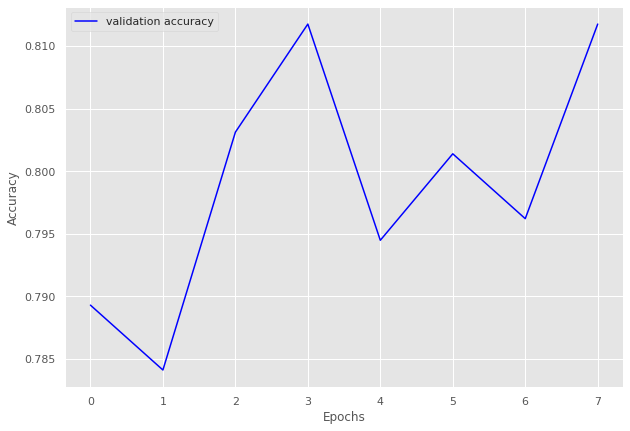

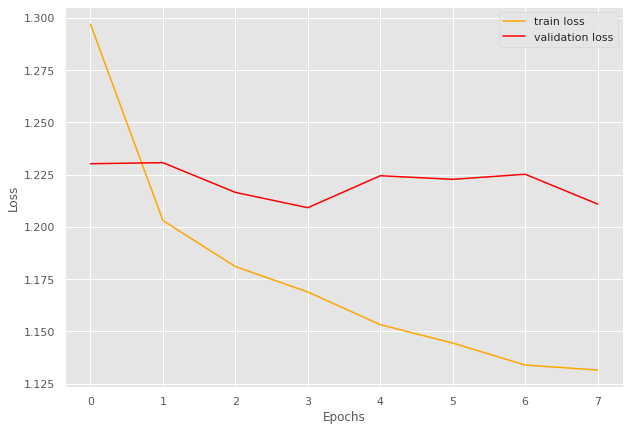

{'0': {'coarse': {'00': 0.8344144759303517, '10': 0.7350631614885627, '20': 0.6717065795249476, '30': 0.587328683607277, '50': 0.4409598595327513, '80': 0.2362093352192362}, 'fine': {'00': {'0': 0.9762140733399405, '1': 0.9764150943396226, '2': 0.9572277227722772, '3': 0.973404255319149, '4': 0.99644128113879, '5': 0.9815242494226328, '7': 0.9389619883040936, '8': 0.9871175523349437, '9': 0.8673469387755102, '11': 0.9451642060861706, '12': 0.9523012552301255, '14': 0.9555808656036446, '15': 0.9640077821011673}, '10': {'0': 0.8848780487804878, '1': 0.8422535211267606, '2': 0.8879103282626101, '3': 0.9231638418079096, '4': 0.9256505576208178, '5': 0.906885758998435, '7': 0.8858381502890174, '8': 0.9591503267973857, '9': 0.7749469214437368, '11': 0.8723911747167561, '12': 0.9203319502074688, '14': 0.8818380743982495, '15': 0.8033088235294118}, '20': {'0': 0.8442064264849075, '1': 0.7038567493112947, '2': 0.8205027494108406, '3': 0.8527889591719379, '4': 0.8386075949367089, '5': 0.80940794

100%|██████████| 96/96 [00:34<00:00,  2.78batch/s, loss=1.13]


train loss 1.1255177482962608, validation loss 1.0261812101710925, validation accuracy 0.8804841149773072
Coarse label 11 Epoch 2
-------------------------------


100%|██████████| 96/96 [00:34<00:00,  2.80batch/s, loss=1.04]


train loss 1.0433100126683712, validation loss 1.0193183530460705, validation accuracy 0.8819969742813918
Coarse label 11 Epoch 3
-------------------------------


100%|██████████| 96/96 [00:34<00:00,  2.79batch/s, loss=1.02]


INFO: Early stopping counter 1 of 5
train loss 1.0181377002348502, validation loss 1.028964806686748, validation accuracy 0.8714069591527988
Coarse label 11 Epoch 4
-------------------------------


100%|██████████| 96/96 [00:34<00:00,  2.80batch/s, loss=1]   


INFO: Early stopping counter 2 of 5
train loss 1.0015651639550924, validation loss 1.026107598434795, validation accuracy 0.875945537065053
Coarse label 11 Epoch 5
-------------------------------


100%|██████████| 96/96 [00:34<00:00,  2.80batch/s, loss=0.995]


INFO: Early stopping counter 3 of 5
train loss 0.9947308780004581, validation loss 1.0319305549968372, validation accuracy 0.869894099848714
Coarse label 11 Epoch 6
-------------------------------


100%|██████████| 96/96 [00:34<00:00,  2.80batch/s, loss=0.989]


train loss 0.9890535666296879, validation loss 1.0082992044362156, validation accuracy 0.8940998487140696
Coarse label 11 Epoch 7
-------------------------------


100%|██████████| 96/96 [00:34<00:00,  2.79batch/s, loss=0.985]


INFO: Early stopping counter 4 of 5
train loss 0.9848317230741183, validation loss 1.0243899388746782, validation accuracy 0.875945537065053
Coarse label 11 Epoch 8
-------------------------------


100%|██████████| 96/96 [00:37<00:00,  2.55batch/s, loss=0.985]


INFO: Early stopping counter 5 of 5
INFO: Early stopping
Done! Saved model with test accuracy 0.8423605497170574 and loss 1.0827168613672256


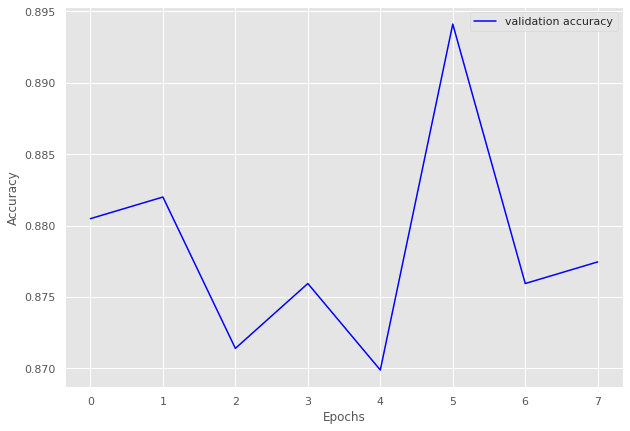

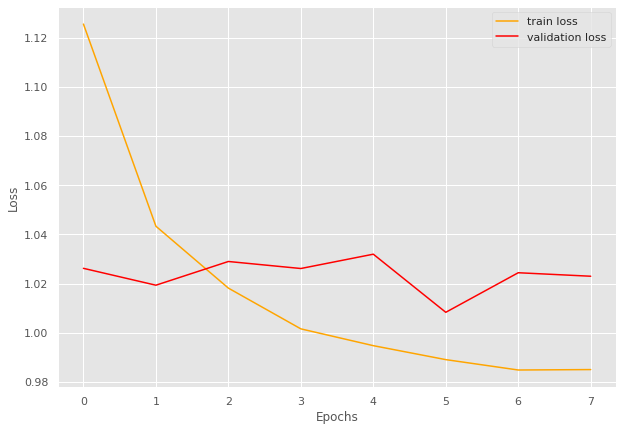

{'0': {'coarse': {'00': 0.8344144759303517, '10': 0.7350631614885627, '20': 0.6717065795249476, '30': 0.587328683607277, '50': 0.4409598595327513, '80': 0.2362093352192362}, 'fine': {'00': {'0': 0.9762140733399405, '1': 0.9764150943396226, '2': 0.9572277227722772, '3': 0.973404255319149, '4': 0.99644128113879, '5': 0.9815242494226328, '7': 0.9389619883040936, '8': 0.9871175523349437, '9': 0.8673469387755102, '11': 0.9451642060861706, '12': 0.9523012552301255, '14': 0.9555808656036446, '15': 0.9640077821011673}, '10': {'0': 0.8848780487804878, '1': 0.8422535211267606, '2': 0.8879103282626101, '3': 0.9231638418079096, '4': 0.9256505576208178, '5': 0.906885758998435, '7': 0.8858381502890174, '8': 0.9591503267973857, '9': 0.7749469214437368, '11': 0.8723911747167561, '12': 0.9203319502074688, '14': 0.8818380743982495, '15': 0.8033088235294118}, '20': {'0': 0.8442064264849075, '1': 0.7038567493112947, '2': 0.8205027494108406, '3': 0.8527889591719379, '4': 0.8386075949367089, '5': 0.80940794

100%|██████████| 45/45 [00:16<00:00,  2.79batch/s, loss=0.747]


train loss 0.7471202280786302, validation loss 0.70389883518219, validation accuracy 0.8233438485804416
Coarse label 12 Epoch 2
-------------------------------


100%|██████████| 45/45 [00:16<00:00,  2.81batch/s, loss=0.66] 


train loss 0.6595674130651686, validation loss 0.6922178387641906, validation accuracy 0.8517350157728707
Coarse label 12 Epoch 3
-------------------------------


100%|██████████| 45/45 [00:16<00:00,  2.69batch/s, loss=0.621]


train loss 0.6210930943489075, validation loss 0.6795814394950866, validation accuracy 0.8643533123028391
Coarse label 12 Epoch 4
-------------------------------


100%|██████████| 45/45 [00:15<00:00,  2.83batch/s, loss=0.601]


INFO: Early stopping counter 1 of 5
train loss 0.6013421336809794, validation loss 0.702122688293457, validation accuracy 0.8391167192429022
Coarse label 12 Epoch 5
-------------------------------


100%|██████████| 45/45 [00:16<00:00,  2.76batch/s, loss=0.592]


INFO: Early stopping counter 2 of 5
train loss 0.5920514967706468, validation loss 0.68639634847641, validation accuracy 0.861198738170347
Coarse label 12 Epoch 6
-------------------------------


100%|██████████| 45/45 [00:16<00:00,  2.80batch/s, loss=0.592]


INFO: Early stopping counter 3 of 5
train loss 0.5915029764175415, validation loss 0.7061378955841064, validation accuracy 0.832807570977918
Coarse label 12 Epoch 7
-------------------------------


100%|██████████| 45/45 [00:16<00:00,  2.80batch/s, loss=0.588]


INFO: Early stopping counter 4 of 5
train loss 0.5881070415178935, validation loss 0.7103423476219177, validation accuracy 0.8422712933753943
Coarse label 12 Epoch 8
-------------------------------


100%|██████████| 45/45 [00:16<00:00,  2.81batch/s, loss=0.58] 


INFO: Early stopping counter 5 of 5
INFO: Early stopping
Done! Saved model with test accuracy 0.8413284132841329 and loss 0.7339670525656806


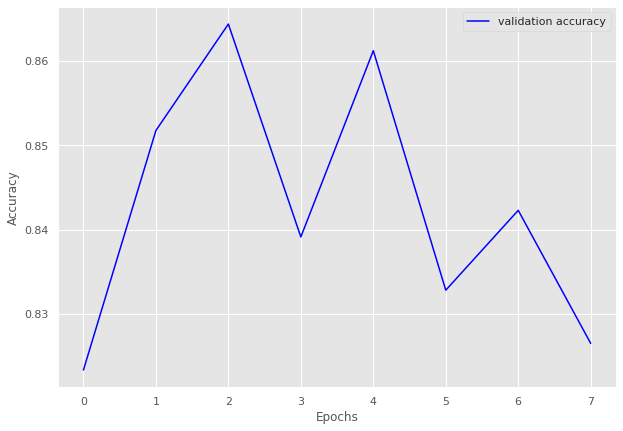

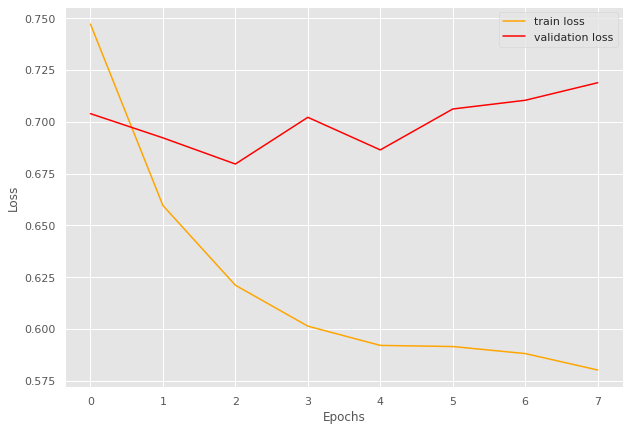

{'0': {'coarse': {'00': 0.8344144759303517, '10': 0.7350631614885627, '20': 0.6717065795249476, '30': 0.587328683607277, '50': 0.4409598595327513, '80': 0.2362093352192362}, 'fine': {'00': {'0': 0.9762140733399405, '1': 0.9764150943396226, '2': 0.9572277227722772, '3': 0.973404255319149, '4': 0.99644128113879, '5': 0.9815242494226328, '7': 0.9389619883040936, '8': 0.9871175523349437, '9': 0.8673469387755102, '11': 0.9451642060861706, '12': 0.9523012552301255, '14': 0.9555808656036446, '15': 0.9640077821011673}, '10': {'0': 0.8848780487804878, '1': 0.8422535211267606, '2': 0.8879103282626101, '3': 0.9231638418079096, '4': 0.9256505576208178, '5': 0.906885758998435, '7': 0.8858381502890174, '8': 0.9591503267973857, '9': 0.7749469214437368, '11': 0.8723911747167561, '12': 0.9203319502074688, '14': 0.8818380743982495, '15': 0.8033088235294118}, '20': {'0': 0.8442064264849075, '1': 0.7038567493112947, '2': 0.8205027494108406, '3': 0.8527889591719379, '4': 0.8386075949367089, '5': 0.80940794

100%|██████████| 210/210 [01:54<00:00,  1.84batch/s, loss=1.62]


train loss 1.6208173405556452, validation loss 1.6044194868632726, validation accuracy 0.7646396396396397
Coarse label 13 Epoch 2
-------------------------------


100%|██████████| 210/210 [02:27<00:00,  1.42batch/s, loss=1.55]


train loss 1.5505834023157756, validation loss 1.589678875037602, validation accuracy 0.7815315315315315
Coarse label 13 Epoch 3
-------------------------------


100%|██████████| 210/210 [01:16<00:00,  2.75batch/s, loss=1.53]


train loss 1.5328382196880521, validation loss 1.5887555905750819, validation accuracy 0.7781531531531531
Coarse label 13 Epoch 4
-------------------------------


100%|██████████| 210/210 [01:15<00:00,  2.78batch/s, loss=1.53]


INFO: Early stopping counter 1 of 5
train loss 1.5261454258646283, validation loss 1.5911985380308968, validation accuracy 0.7815315315315315
Coarse label 13 Epoch 5
-------------------------------


100%|██████████| 210/210 [01:16<00:00,  2.75batch/s, loss=1.52]


INFO: Early stopping counter 2 of 5
train loss 1.5157169756435214, validation loss 1.6036977853093828, validation accuracy 0.7657657657657657
Coarse label 13 Epoch 6
-------------------------------


100%|██████████| 210/210 [01:15<00:00,  2.78batch/s, loss=1.51]


INFO: Early stopping counter 3 of 5
train loss 1.5132972268831162, validation loss 1.5971056393214635, validation accuracy 0.7713963963963963
Coarse label 13 Epoch 7
-------------------------------


100%|██████████| 210/210 [01:15<00:00,  2.77batch/s, loss=1.5] 


train loss 1.50495711962382, validation loss 1.582704314163753, validation accuracy 0.7894144144144144
Coarse label 13 Epoch 8
-------------------------------


100%|██████████| 210/210 [01:15<00:00,  2.77batch/s, loss=1.5] 


train loss 1.503491050856454, validation loss 1.5702836172921317, validation accuracy 0.8018018018018018
Coarse label 13 Epoch 9
-------------------------------


100%|██████████| 210/210 [01:15<00:00,  2.78batch/s, loss=1.5] 


train loss 1.4983473159018017, validation loss 1.5634372404643468, validation accuracy 0.8085585585585585
Coarse label 13 Epoch 10
-------------------------------


100%|██████████| 210/210 [01:15<00:00,  2.78batch/s, loss=1.49]


INFO: Early stopping counter 4 of 5
train loss 1.4924297673361642, validation loss 1.5753483857427324, validation accuracy 0.7961711711711712
Coarse label 13 Epoch 11
-------------------------------


100%|██████████| 210/210 [01:15<00:00,  2.78batch/s, loss=1.49]


INFO: Early stopping counter 5 of 5
INFO: Early stopping
Done! Saved model with test accuracy 0.8323232323232324 and loss 1.5397408191974347


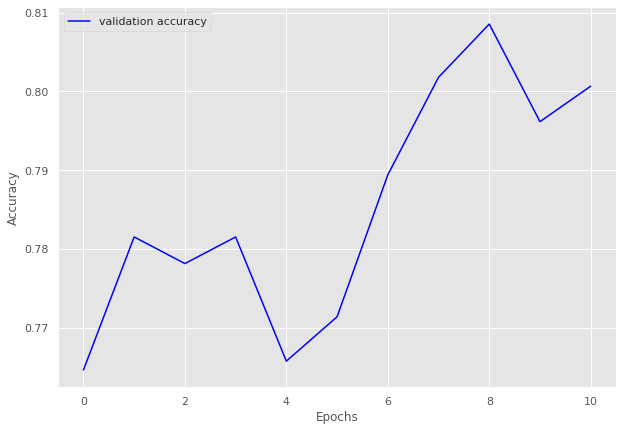

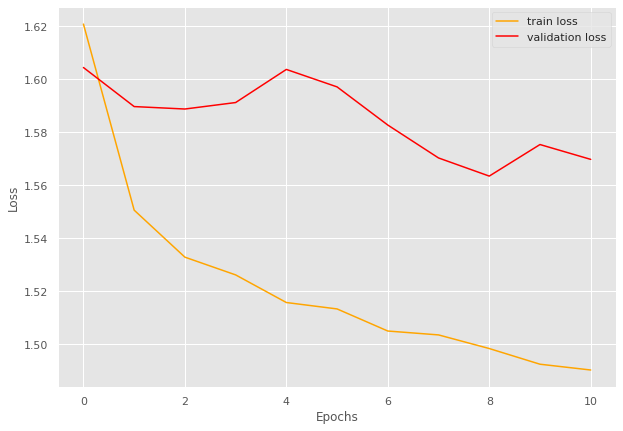

{'0': {'coarse': {'00': 0.8344144759303517, '10': 0.7350631614885627, '20': 0.6717065795249476, '30': 0.587328683607277, '50': 0.4409598595327513, '80': 0.2362093352192362}, 'fine': {'00': {'0': 0.9762140733399405, '1': 0.9764150943396226, '2': 0.9572277227722772, '3': 0.973404255319149, '4': 0.99644128113879, '5': 0.9815242494226328, '7': 0.9389619883040936, '8': 0.9871175523349437, '9': 0.8673469387755102, '11': 0.9451642060861706, '12': 0.9523012552301255, '14': 0.9555808656036446, '15': 0.9640077821011673}, '10': {'0': 0.8848780487804878, '1': 0.8422535211267606, '2': 0.8879103282626101, '3': 0.9231638418079096, '4': 0.9256505576208178, '5': 0.906885758998435, '7': 0.8858381502890174, '8': 0.9591503267973857, '9': 0.7749469214437368, '11': 0.8723911747167561, '12': 0.9203319502074688, '14': 0.8818380743982495, '15': 0.8033088235294118}, '20': {'0': 0.8442064264849075, '1': 0.7038567493112947, '2': 0.8205027494108406, '3': 0.8527889591719379, '4': 0.8386075949367089, '5': 0.80940794

100%|██████████| 37/37 [00:13<00:00,  2.76batch/s, loss=0.831]


train loss 0.8310068861858265, validation loss 0.7929541269938151, validation accuracy 0.7625
Coarse label 14 Epoch 2
-------------------------------


100%|██████████| 37/37 [00:13<00:00,  2.77batch/s, loss=0.689]


train loss 0.6889881459442345, validation loss 0.7716412941614786, validation accuracy 0.78125
Coarse label 14 Epoch 3
-------------------------------


100%|██████████| 37/37 [00:13<00:00,  2.80batch/s, loss=0.639]


INFO: Early stopping counter 1 of 5
train loss 0.638872462349969, validation loss 0.789873739083608, validation accuracy 0.75625
Coarse label 14 Epoch 4
-------------------------------


100%|██████████| 37/37 [00:13<00:00,  2.80batch/s, loss=0.616]


INFO: Early stopping counter 2 of 5
train loss 0.6163148847786156, validation loss 0.7953314185142517, validation accuracy 0.74375
Coarse label 14 Epoch 5
-------------------------------


100%|██████████| 37/37 [00:13<00:00,  2.80batch/s, loss=0.609]


INFO: Early stopping counter 3 of 5
train loss 0.609089862655949, validation loss 0.7995181282361349, validation accuracy 0.74375
Coarse label 14 Epoch 6
-------------------------------


100%|██████████| 37/37 [00:13<00:00,  2.79batch/s, loss=0.599]


train loss 0.5991198565508868, validation loss 0.7700297832489014, validation accuracy 0.78125
Coarse label 14 Epoch 7
-------------------------------


100%|██████████| 37/37 [00:13<00:00,  2.72batch/s, loss=0.596]


INFO: Early stopping counter 4 of 5
train loss 0.5956945419311523, validation loss 0.7713768283526102, validation accuracy 0.7625
Coarse label 14 Epoch 8
-------------------------------


100%|██████████| 37/37 [00:13<00:00,  2.80batch/s, loss=0.595]


INFO: Early stopping counter 5 of 5
INFO: Early stopping
Done! Saved model with test accuracy 0.7675544794188862 and loss 0.7723167708941868


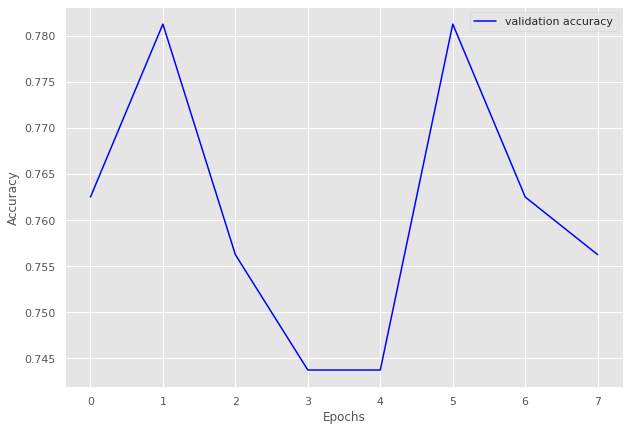

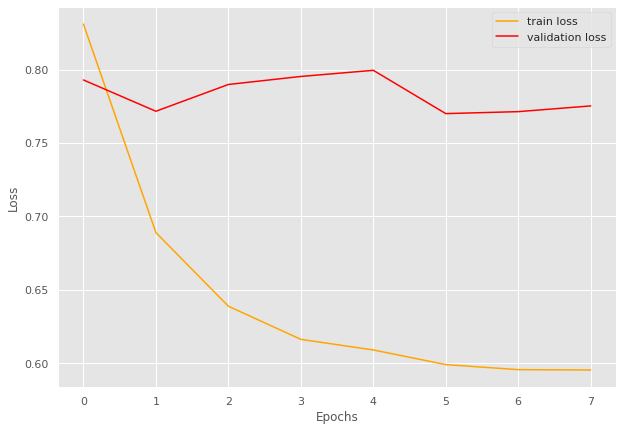

{'0': {'coarse': {'00': 0.8344144759303517, '10': 0.7350631614885627, '20': 0.6717065795249476, '30': 0.587328683607277, '50': 0.4409598595327513, '80': 0.2362093352192362}, 'fine': {'00': {'0': 0.9762140733399405, '1': 0.9764150943396226, '2': 0.9572277227722772, '3': 0.973404255319149, '4': 0.99644128113879, '5': 0.9815242494226328, '7': 0.9389619883040936, '8': 0.9871175523349437, '9': 0.8673469387755102, '11': 0.9451642060861706, '12': 0.9523012552301255, '14': 0.9555808656036446, '15': 0.9640077821011673}, '10': {'0': 0.8848780487804878, '1': 0.8422535211267606, '2': 0.8879103282626101, '3': 0.9231638418079096, '4': 0.9256505576208178, '5': 0.906885758998435, '7': 0.8858381502890174, '8': 0.9591503267973857, '9': 0.7749469214437368, '11': 0.8723911747167561, '12': 0.9203319502074688, '14': 0.8818380743982495, '15': 0.8033088235294118}, '20': {'0': 0.8442064264849075, '1': 0.7038567493112947, '2': 0.8205027494108406, '3': 0.8527889591719379, '4': 0.8386075949367089, '5': 0.80940794

100%|██████████| 84/84 [00:30<00:00,  2.77batch/s, loss=0.942]


train loss 0.9417822204885029, validation loss 0.8625233239597745, validation accuracy 0.8763440860215054
Coarse label 15 Epoch 2
-------------------------------


100%|██████████| 84/84 [00:30<00:00,  2.75batch/s, loss=0.865]


train loss 0.8653918958845592, validation loss 0.8568622536129422, validation accuracy 0.8817204301075269
Coarse label 15 Epoch 3
-------------------------------


100%|██████████| 84/84 [00:30<00:00,  2.78batch/s, loss=0.834]


train loss 0.8337138635771615, validation loss 0.8502353098657396, validation accuracy 0.8924731182795699
Coarse label 15 Epoch 4
-------------------------------


100%|██████████| 84/84 [00:30<00:00,  2.75batch/s, loss=0.818]


INFO: Early stopping counter 1 of 5
train loss 0.8184859674601328, validation loss 0.8513692683643765, validation accuracy 0.8942652329749103
Coarse label 15 Epoch 5
-------------------------------


100%|██████████| 84/84 [00:30<00:00,  2.78batch/s, loss=0.81] 


INFO: Early stopping counter 2 of 5
train loss 0.809782760483878, validation loss 0.8625357151031494, validation accuracy 0.8709677419354839
Coarse label 15 Epoch 6
-------------------------------


100%|██████████| 84/84 [00:30<00:00,  2.79batch/s, loss=0.809]


INFO: Early stopping counter 3 of 5
train loss 0.8089679231246313, validation loss 0.857407013575236, validation accuracy 0.8799283154121864
Coarse label 15 Epoch 7
-------------------------------


100%|██████████| 84/84 [00:30<00:00,  2.78batch/s, loss=0.802]


train loss 0.8017128187985647, validation loss 0.850217322508494, validation accuracy 0.8853046594982079
Coarse label 15 Epoch 8
-------------------------------


100%|██████████| 84/84 [00:30<00:00,  2.73batch/s, loss=0.795]


INFO: Early stopping counter 4 of 5
train loss 0.7948521751733053, validation loss 0.8519795205858018, validation accuracy 0.8906810035842294
Coarse label 15 Epoch 9
-------------------------------


100%|██████████| 84/84 [00:30<00:00,  2.77batch/s, loss=0.796]


INFO: Early stopping counter 5 of 5
INFO: Early stopping
Done! Saved model with test accuracy 0.8729472774416595 and loss 0.8889230207393044


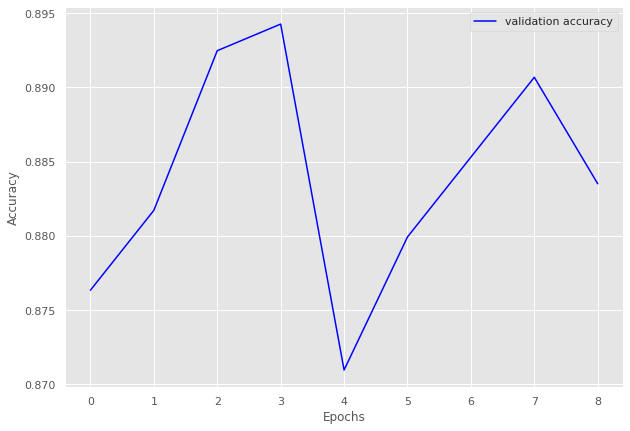

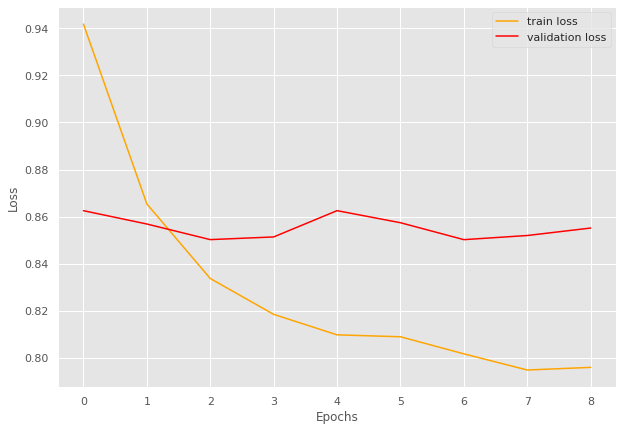

{'0': {'coarse': {'00': 0.8344144759303517, '10': 0.7350631614885627, '20': 0.6717065795249476, '30': 0.587328683607277, '50': 0.4409598595327513, '80': 0.2362093352192362}, 'fine': {'00': {'0': 0.9762140733399405, '1': 0.9764150943396226, '2': 0.9572277227722772, '3': 0.973404255319149, '4': 0.99644128113879, '5': 0.9815242494226328, '7': 0.9389619883040936, '8': 0.9871175523349437, '9': 0.8673469387755102, '11': 0.9451642060861706, '12': 0.9523012552301255, '14': 0.9555808656036446, '15': 0.9640077821011673}, '10': {'0': 0.8848780487804878, '1': 0.8422535211267606, '2': 0.8879103282626101, '3': 0.9231638418079096, '4': 0.9256505576208178, '5': 0.906885758998435, '7': 0.8858381502890174, '8': 0.9591503267973857, '9': 0.7749469214437368, '11': 0.8723911747167561, '12': 0.9203319502074688, '14': 0.8818380743982495, '15': 0.8033088235294118}, '20': {'0': 0.8442064264849075, '1': 0.7038567493112947, '2': 0.8205027494108406, '3': 0.8527889591719379, '4': 0.8386075949367089, '5': 0.80940794

100%|██████████| 117/117 [00:42<00:00,  2.76batch/s, loss=1.29]


train loss 1.2880102090346508, validation loss 1.2681314051151276, validation accuracy 0.7690721649484537
Coarse label 16 Epoch 2
-------------------------------


100%|██████████| 117/117 [00:42<00:00,  2.78batch/s, loss=1.21]


INFO: Early stopping counter 1 of 5
train loss 1.2057234079409869, validation loss 1.270800143480301, validation accuracy 0.756701030927835
Coarse label 16 Epoch 3
-------------------------------


100%|██████████| 117/117 [00:42<00:00,  2.76batch/s, loss=1.19]


INFO: Early stopping counter 2 of 5
train loss 1.186317089276436, validation loss 1.272354245185852, validation accuracy 0.7649484536082474
Coarse label 16 Epoch 4
-------------------------------


100%|██████████| 117/117 [00:42<00:00,  2.76batch/s, loss=1.17]


INFO: Early stopping counter 3 of 5
train loss 1.1735905673768785, validation loss 1.2713287621736526, validation accuracy 0.7628865979381443
Coarse label 16 Epoch 5
-------------------------------


100%|██████████| 117/117 [00:41<00:00,  2.79batch/s, loss=1.17]


INFO: Early stopping counter 4 of 5
train loss 1.1712639769937239, validation loss 1.268530860543251, validation accuracy 0.7690721649484537
Coarse label 16 Epoch 6
-------------------------------


100%|██████████| 117/117 [00:42<00:00,  2.75batch/s, loss=1.15]


INFO: Early stopping counter 5 of 5
INFO: Early stopping
Done! Saved model with test accuracy 0.8202637057598889 and loss 1.2295718866845835


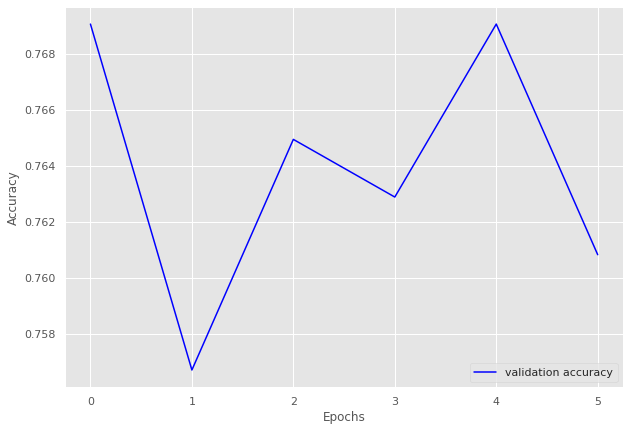

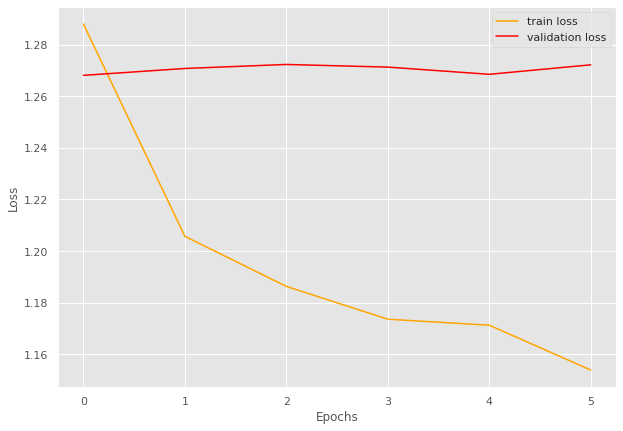

{'0': {'coarse': {'00': 0.8344144759303517, '10': 0.7350631614885627, '20': 0.6717065795249476, '30': 0.587328683607277, '50': 0.4409598595327513, '80': 0.2362093352192362}, 'fine': {'00': {'0': 0.9762140733399405, '1': 0.9764150943396226, '2': 0.9572277227722772, '3': 0.973404255319149, '4': 0.99644128113879, '5': 0.9815242494226328, '7': 0.9389619883040936, '8': 0.9871175523349437, '9': 0.8673469387755102, '11': 0.9451642060861706, '12': 0.9523012552301255, '14': 0.9555808656036446, '15': 0.9640077821011673}, '10': {'0': 0.8848780487804878, '1': 0.8422535211267606, '2': 0.8879103282626101, '3': 0.9231638418079096, '4': 0.9256505576208178, '5': 0.906885758998435, '7': 0.8858381502890174, '8': 0.9591503267973857, '9': 0.7749469214437368, '11': 0.8723911747167561, '12': 0.9203319502074688, '14': 0.8818380743982495, '15': 0.8033088235294118}, '20': {'0': 0.8442064264849075, '1': 0.7038567493112947, '2': 0.8205027494108406, '3': 0.8527889591719379, '4': 0.8386075949367089, '5': 0.80940794

100%|██████████| 72/72 [00:25<00:00,  2.80batch/s, loss=0.982]


train loss 0.9821008460389243, validation loss 0.8755125924944878, validation accuracy 0.8658280922431866
Coarse label 17 Epoch 2
-------------------------------


100%|██████████| 72/72 [00:25<00:00,  2.80batch/s, loss=0.882]


INFO: Early stopping counter 1 of 5
train loss 0.8821569623218642, validation loss 0.8761458396911621, validation accuracy 0.8616352201257862
Coarse label 17 Epoch 3
-------------------------------


100%|██████████| 72/72 [00:25<00:00,  2.80batch/s, loss=0.852]


train loss 0.8518707065118684, validation loss 0.874048113822937, validation accuracy 0.8658280922431866
Coarse label 17 Epoch 4
-------------------------------


100%|██████████| 72/72 [00:25<00:00,  2.80batch/s, loss=0.841]


INFO: Early stopping counter 2 of 5
train loss 0.8409266612595983, validation loss 0.88090530782938, validation accuracy 0.859538784067086
Coarse label 17 Epoch 5
-------------------------------


100%|██████████| 72/72 [00:26<00:00,  2.76batch/s, loss=0.826]


INFO: Early stopping counter 3 of 5
train loss 0.825816193388568, validation loss 0.89390879124403, validation accuracy 0.8364779874213837
Coarse label 17 Epoch 6
-------------------------------


100%|██████████| 72/72 [00:25<00:00,  2.81batch/s, loss=0.827]


train loss 0.8269623766342798, validation loss 0.8597646653652191, validation accuracy 0.8846960167714885
Coarse label 17 Epoch 7
-------------------------------


100%|██████████| 72/72 [00:25<00:00,  2.79batch/s, loss=0.818]


train loss 0.8184032448463969, validation loss 0.8595041558146477, validation accuracy 0.8846960167714885
Coarse label 17 Epoch 8
-------------------------------


100%|██████████| 72/72 [00:25<00:00,  2.80batch/s, loss=0.813]


train loss 0.8127515307731099, validation loss 0.8567351996898651, validation accuracy 0.8888888888888888
Coarse label 17 Epoch 9
-------------------------------


100%|██████████| 72/72 [00:25<00:00,  2.78batch/s, loss=0.804]


INFO: Early stopping counter 4 of 5
train loss 0.8041682839393616, validation loss 0.8769653365015984, validation accuracy 0.8616352201257862
Coarse label 17 Epoch 10
-------------------------------


100%|██████████| 72/72 [00:26<00:00,  2.75batch/s, loss=0.801]


INFO: Early stopping counter 5 of 5
INFO: Early stopping
Done! Saved model with test accuracy 0.8326403326403327 and loss 0.9403902515769005


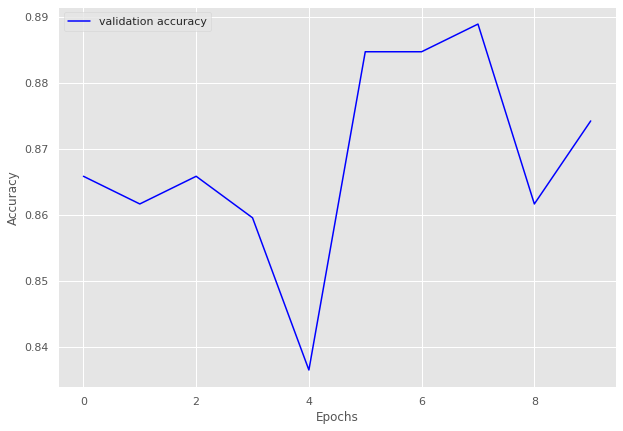

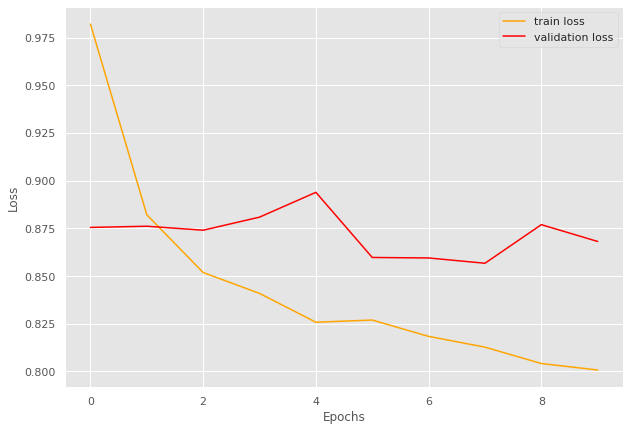

{'0': {'coarse': {'00': 0.8344144759303517, '10': 0.7350631614885627, '20': 0.6717065795249476, '30': 0.587328683607277, '50': 0.4409598595327513, '80': 0.2362093352192362}, 'fine': {'00': {'0': 0.9762140733399405, '1': 0.9764150943396226, '2': 0.9572277227722772, '3': 0.973404255319149, '4': 0.99644128113879, '5': 0.9815242494226328, '7': 0.9389619883040936, '8': 0.9871175523349437, '9': 0.8673469387755102, '11': 0.9451642060861706, '12': 0.9523012552301255, '14': 0.9555808656036446, '15': 0.9640077821011673}, '10': {'0': 0.8848780487804878, '1': 0.8422535211267606, '2': 0.8879103282626101, '3': 0.9231638418079096, '4': 0.9256505576208178, '5': 0.906885758998435, '7': 0.8858381502890174, '8': 0.9591503267973857, '9': 0.7749469214437368, '11': 0.8723911747167561, '12': 0.9203319502074688, '14': 0.8818380743982495, '15': 0.8033088235294118}, '20': {'0': 0.8442064264849075, '1': 0.7038567493112947, '2': 0.8205027494108406, '3': 0.8527889591719379, '4': 0.8386075949367089, '5': 0.80940794

100%|██████████| 16/16 [00:05<00:00,  2.91batch/s, loss=0.535]


train loss 0.5353831835091114, validation loss 0.42004528641700745, validation accuracy 0.8617021276595744
Coarse label 18 Epoch 2
-------------------------------


100%|██████████| 16/16 [00:05<00:00,  2.94batch/s, loss=0.387]


INFO: Early stopping counter 1 of 5
train loss 0.38687447644770145, validation loss 0.4328908920288086, validation accuracy 0.8617021276595744
Coarse label 18 Epoch 3
-------------------------------


100%|██████████| 16/16 [00:05<00:00,  2.93batch/s, loss=0.338]


INFO: Early stopping counter 2 of 5
train loss 0.33812883868813515, validation loss 0.4234504848718643, validation accuracy 0.8936170212765957
Coarse label 18 Epoch 4
-------------------------------


100%|██████████| 16/16 [00:06<00:00,  2.62batch/s, loss=0.324]


INFO: Early stopping counter 3 of 5
train loss 0.3237672708928585, validation loss 0.4425077885389328, validation accuracy 0.8723404255319149
Coarse label 18 Epoch 5
-------------------------------


100%|██████████| 16/16 [00:05<00:00,  2.92batch/s, loss=0.323]


INFO: Early stopping counter 4 of 5
train loss 0.3230462707579136, validation loss 0.4307847023010254, validation accuracy 0.8829787234042553
Coarse label 18 Epoch 6
-------------------------------


100%|██████████| 16/16 [00:05<00:00,  2.89batch/s, loss=0.32] 


INFO: Early stopping counter 5 of 5
INFO: Early stopping
Done! Saved model with test accuracy 0.8341013824884793 and loss 0.5280037745833397


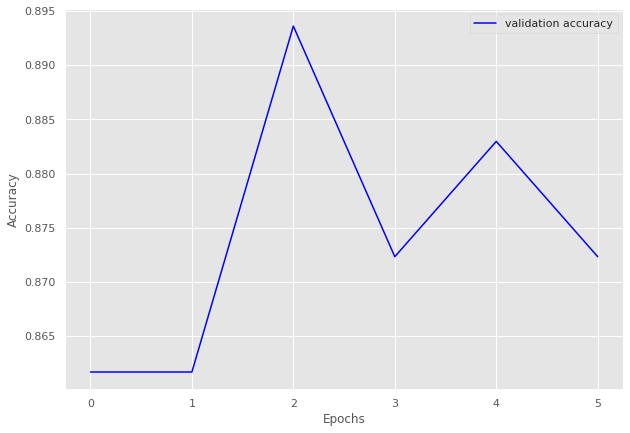

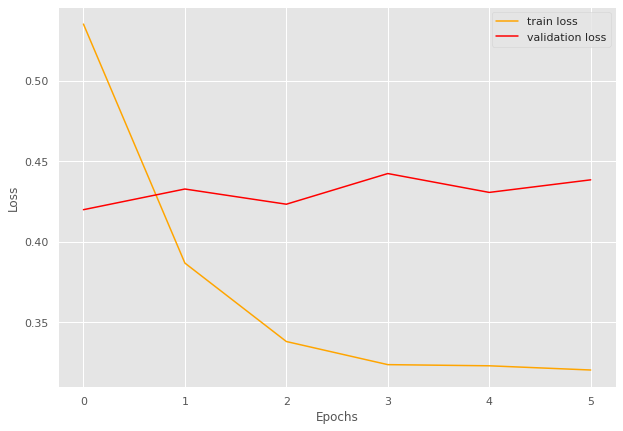

{'0': {'coarse': {'00': 0.8344144759303517, '10': 0.7350631614885627, '20': 0.6717065795249476, '30': 0.587328683607277, '50': 0.4409598595327513, '80': 0.2362093352192362}, 'fine': {'00': {'0': 0.9762140733399405, '1': 0.9764150943396226, '2': 0.9572277227722772, '3': 0.973404255319149, '4': 0.99644128113879, '5': 0.9815242494226328, '7': 0.9389619883040936, '8': 0.9871175523349437, '9': 0.8673469387755102, '11': 0.9451642060861706, '12': 0.9523012552301255, '14': 0.9555808656036446, '15': 0.9640077821011673}, '10': {'0': 0.8848780487804878, '1': 0.8422535211267606, '2': 0.8879103282626101, '3': 0.9231638418079096, '4': 0.9256505576208178, '5': 0.906885758998435, '7': 0.8858381502890174, '8': 0.9591503267973857, '9': 0.7749469214437368, '11': 0.8723911747167561, '12': 0.9203319502074688, '14': 0.8818380743982495, '15': 0.8033088235294118}, '20': {'0': 0.8442064264849075, '1': 0.7038567493112947, '2': 0.8205027494108406, '3': 0.8527889591719379, '4': 0.8386075949367089, '5': 0.80940794

100%|██████████| 23/23 [00:08<00:00,  2.77batch/s, loss=0.901]


train loss 0.9007135396418364, validation loss 0.9203620254993439, validation accuracy 0.5853658536585366
Coarse label 19 Epoch 2
-------------------------------


100%|██████████| 23/23 [00:08<00:00,  2.72batch/s, loss=0.704]


train loss 0.7035202306249867, validation loss 0.891834944486618, validation accuracy 0.6219512195121951
Coarse label 19 Epoch 3
-------------------------------


100%|██████████| 23/23 [00:08<00:00,  2.82batch/s, loss=0.622]


INFO: Early stopping counter 1 of 5
train loss 0.6215072351953258, validation loss 0.9335767030715942, validation accuracy 0.5853658536585366
Coarse label 19 Epoch 4
-------------------------------


100%|██████████| 23/23 [00:08<00:00,  2.82batch/s, loss=0.59] 


INFO: Early stopping counter 2 of 5
train loss 0.5895544057307036, validation loss 0.9419524073600769, validation accuracy 0.5609756097560976
Coarse label 19 Epoch 5
-------------------------------


100%|██████████| 23/23 [00:08<00:00,  2.87batch/s, loss=0.579]


INFO: Early stopping counter 3 of 5
train loss 0.5790680906046992, validation loss 0.8949779570102692, validation accuracy 0.573170731707317
Coarse label 19 Epoch 6
-------------------------------


100%|██████████| 23/23 [00:08<00:00,  2.84batch/s, loss=0.573]


INFO: Early stopping counter 4 of 5
train loss 0.5733956513197526, validation loss 0.9010302424430847, validation accuracy 0.6097560975609756
Coarse label 19 Epoch 7
-------------------------------


100%|██████████| 23/23 [00:07<00:00,  2.88batch/s, loss=0.571]


INFO: Early stopping counter 5 of 5
INFO: Early stopping
Done! Saved model with test accuracy 0.7285714285714285 and loss 0.8064448118209839


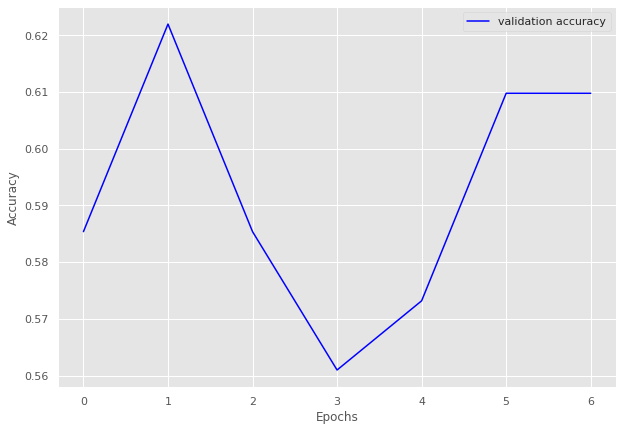

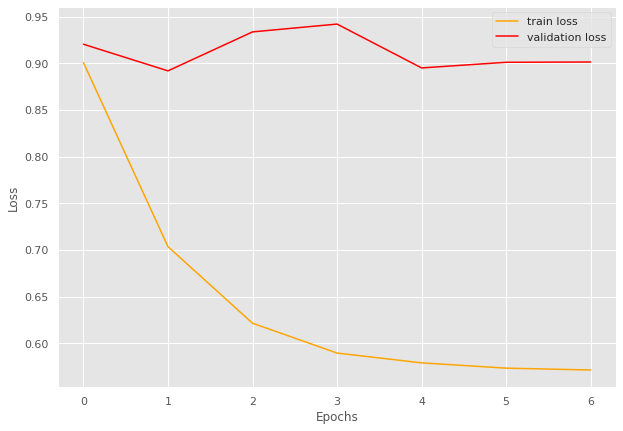

{'0': {'coarse': {'00': 0.8344144759303517, '10': 0.7350631614885627, '20': 0.6717065795249476, '30': 0.587328683607277, '50': 0.4409598595327513, '80': 0.2362093352192362}, 'fine': {'00': {'0': 0.9762140733399405, '1': 0.9764150943396226, '2': 0.9572277227722772, '3': 0.973404255319149, '4': 0.99644128113879, '5': 0.9815242494226328, '7': 0.9389619883040936, '8': 0.9871175523349437, '9': 0.8673469387755102, '11': 0.9451642060861706, '12': 0.9523012552301255, '14': 0.9555808656036446, '15': 0.9640077821011673}, '10': {'0': 0.8848780487804878, '1': 0.8422535211267606, '2': 0.8879103282626101, '3': 0.9231638418079096, '4': 0.9256505576208178, '5': 0.906885758998435, '7': 0.8858381502890174, '8': 0.9591503267973857, '9': 0.7749469214437368, '11': 0.8723911747167561, '12': 0.9203319502074688, '14': 0.8818380743982495, '15': 0.8033088235294118}, '20': {'0': 0.8442064264849075, '1': 0.7038567493112947, '2': 0.8205027494108406, '3': 0.8527889591719379, '4': 0.8386075949367089, '5': 0.80940794

Calculating for label_noise 30
split_30_1
Start training a coarse model
Epoch 1
-------------------------------


100%|██████████| 1640/1640 [11:46<00:00,  2.32batch/s, loss=2.62]


train loss 2.6198094757591806, validation loss 2.5572976099027622, validation accuracy 0.5223994755244755
Epoch 2
-------------------------------


100%|██████████| 1640/1640 [09:49<00:00,  2.78batch/s, loss=2.56]


train loss 2.5560991605607475, validation loss 2.5429338325153696, validation accuracy 0.5362762237762237
Epoch 3
-------------------------------


100%|██████████| 1640/1640 [09:53<00:00,  2.76batch/s, loss=2.53]


train loss 2.5277583439175677, validation loss 2.52204005368106, validation accuracy 0.5558347902097902
Epoch 4
-------------------------------


100%|██████████| 1640/1640 [09:53<00:00,  2.76batch/s, loss=2.51]


train loss 2.50723261673276, validation loss 2.510519944704496, validation accuracy 0.5671984265734266
Epoch 5
-------------------------------


 59%|█████▉    | 973/1640 [07:41<03:58,  2.80batch/s, loss=2.5] IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

100%|██████████| 1640/1640 [11:45<00:00,  2.32batch/s, loss=2.49]


train loss 2.485874492511517, validation loss 2.4956840835251173, validation accuracy 0.5824956293706294
Epoch 8
-------------------------------


 44%|████▎     | 714/1640 [04:16<05:29,  2.81batch/s, loss=2.48]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

100%|██████████| 1640/1640 [10:54<00:00,  2.51batch/s, loss=2.48]


INFO: Early stopping counter 3 of 5
train loss 2.477535920172203, validation loss 2.4977907634281613, validation accuracy 0.5795454545454546
Epoch 10
-------------------------------


100%|██████████| 1640/1640 [10:02<00:00,  2.72batch/s, loss=2.47]


train loss 2.473627583573504, validation loss 2.491222314901285, validation accuracy 0.5876311188811189
Epoch 11
-------------------------------


100%|██████████| 1640/1640 [09:51<00:00,  2.77batch/s, loss=2.47]


INFO: Early stopping counter 4 of 5
train loss 2.468850602173224, validation loss 2.4950273920606065, validation accuracy 0.5824956293706294
Epoch 12
-------------------------------


100%|██████████| 1640/1640 [09:56<00:00,  2.75batch/s, loss=2.47]


INFO: Early stopping counter 5 of 5
INFO: Early stopping
Done! Saved model with test accuracy 0.5828415353850656 and loss 2.4952573018653372


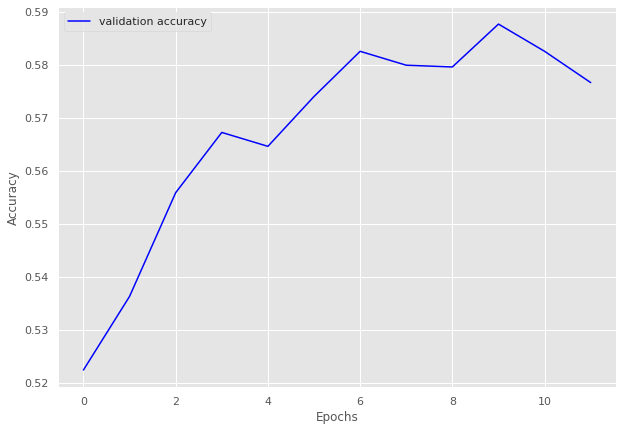

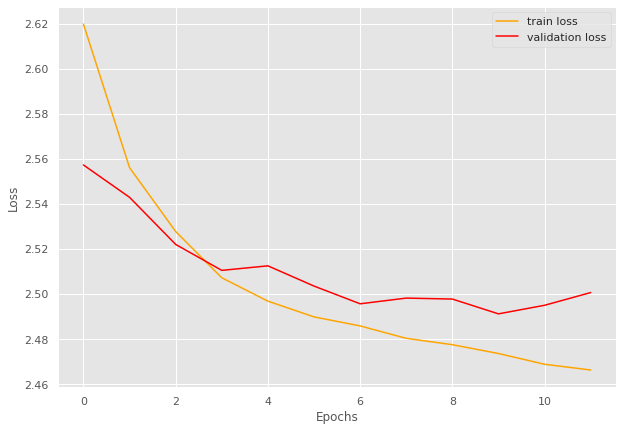

{'0': {'coarse': {'00': 0.8344144759303517, '10': 0.7350631614885627, '20': 0.6717065795249476, '30': 0.587328683607277, '50': 0.4409598595327513, '80': 0.2362093352192362}, 'fine': {'00': {'0': 0.9762140733399405, '1': 0.9764150943396226, '2': 0.9572277227722772, '3': 0.973404255319149, '4': 0.99644128113879, '5': 0.9815242494226328, '7': 0.9389619883040936, '8': 0.9871175523349437, '9': 0.8673469387755102, '11': 0.9451642060861706, '12': 0.9523012552301255, '14': 0.9555808656036446, '15': 0.9640077821011673}, '10': {'0': 0.8848780487804878, '1': 0.8422535211267606, '2': 0.8879103282626101, '3': 0.9231638418079096, '4': 0.9256505576208178, '5': 0.906885758998435, '7': 0.8858381502890174, '8': 0.9591503267973857, '9': 0.7749469214437368, '11': 0.8723911747167561, '12': 0.9203319502074688, '14': 0.8818380743982495, '15': 0.8033088235294118}, '20': {'0': 0.8442064264849075, '1': 0.7038567493112947, '2': 0.8205027494108406, '3': 0.8527889591719379, '4': 0.8386075949367089, '5': 0.80940794

100%|██████████| 89/89 [00:31<00:00,  2.78batch/s, loss=1.22]


train loss 1.2201342435365312, validation loss 1.1129565954208374, validation accuracy 0.7860615883306321
Coarse label 0 Epoch 2
-------------------------------


100%|██████████| 89/89 [00:31<00:00,  2.78batch/s, loss=1.11]


train loss 1.1128194827711984, validation loss 1.111957836151123, validation accuracy 0.7828200972447326
Coarse label 0 Epoch 3
-------------------------------


100%|██████████| 89/89 [00:31<00:00,  2.80batch/s, loss=1.08]


INFO: Early stopping counter 1 of 5
train loss 1.0769275714842121, validation loss 1.1153314590454102, validation accuracy 0.779578606158833
Coarse label 0 Epoch 4
-------------------------------


100%|██████████| 89/89 [00:31<00:00,  2.80batch/s, loss=1.06]


INFO: Early stopping counter 2 of 5
train loss 1.0586421382561158, validation loss 1.1122618913650513, validation accuracy 0.7844408427876823
Coarse label 0 Epoch 5
-------------------------------


100%|██████████| 89/89 [00:31<00:00,  2.79batch/s, loss=1.05]


train loss 1.0472278675336517, validation loss 1.1080409646034242, validation accuracy 0.7893030794165316
Coarse label 0 Epoch 6
-------------------------------


100%|██████████| 89/89 [00:31<00:00,  2.79batch/s, loss=1.04]


INFO: Early stopping counter 3 of 5
train loss 1.0411986434057858, validation loss 1.1084678590297699, validation accuracy 0.7941653160453809
Coarse label 0 Epoch 7
-------------------------------


100%|██████████| 89/89 [00:32<00:00,  2.76batch/s, loss=1.02]


train loss 1.024619655662708, validation loss 1.0982755661010741, validation accuracy 0.8055105348460292
Coarse label 0 Epoch 8
-------------------------------


100%|██████████| 89/89 [00:50<00:00,  1.76batch/s, loss=1.02]


INFO: Early stopping counter 4 of 5
train loss 1.0165970821059152, validation loss 1.1004587709903717, validation accuracy 0.7990275526742301
Coarse label 0 Epoch 9
-------------------------------


100%|██████████| 89/89 [01:10<00:00,  1.27batch/s, loss=1.02] 


INFO: Early stopping counter 5 of 5
INFO: Early stopping
Done! Saved model with test accuracy 0.7672566371681416 and loss 1.1435676316420238


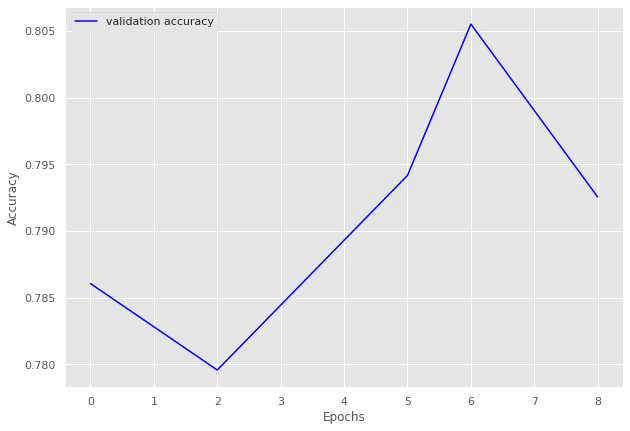

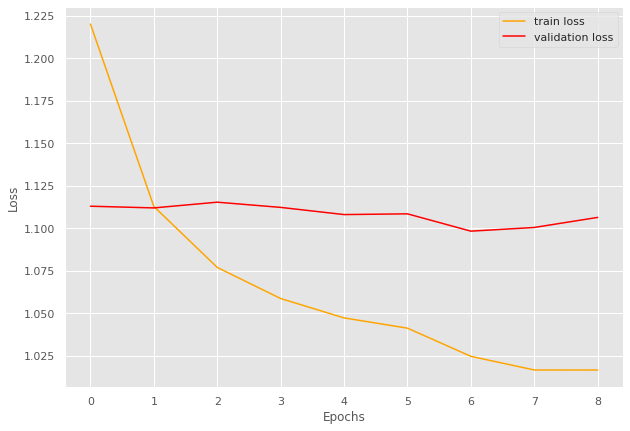

{'0': {'coarse': {'00': 0.8344144759303517, '10': 0.7350631614885627, '20': 0.6717065795249476, '30': 0.587328683607277, '50': 0.4409598595327513, '80': 0.2362093352192362}, 'fine': {'00': {'0': 0.9762140733399405, '1': 0.9764150943396226, '2': 0.9572277227722772, '3': 0.973404255319149, '4': 0.99644128113879, '5': 0.9815242494226328, '7': 0.9389619883040936, '8': 0.9871175523349437, '9': 0.8673469387755102, '11': 0.9451642060861706, '12': 0.9523012552301255, '14': 0.9555808656036446, '15': 0.9640077821011673}, '10': {'0': 0.8848780487804878, '1': 0.8422535211267606, '2': 0.8879103282626101, '3': 0.9231638418079096, '4': 0.9256505576208178, '5': 0.906885758998435, '7': 0.8858381502890174, '8': 0.9591503267973857, '9': 0.7749469214437368, '11': 0.8723911747167561, '12': 0.9203319502074688, '14': 0.8818380743982495, '15': 0.8033088235294118}, '20': {'0': 0.8442064264849075, '1': 0.7038567493112947, '2': 0.8205027494108406, '3': 0.8527889591719379, '4': 0.8386075949367089, '5': 0.80940794

100%|██████████| 67/67 [00:58<00:00,  1.14batch/s, loss=0.756]


train loss 0.755681015662293, validation loss 0.9099696725606918, validation accuracy 0.6538461538461539
Coarse label 1 Epoch 2
-------------------------------


100%|██████████| 67/67 [00:33<00:00,  1.98batch/s, loss=0.671]


train loss 0.6706039878859449, validation loss 0.8754216879606247, validation accuracy 0.6778846153846154
Coarse label 1 Epoch 3
-------------------------------


100%|██████████| 67/67 [00:24<00:00,  2.77batch/s, loss=0.643]


INFO: Early stopping counter 1 of 5
train loss 0.6428686327009059, validation loss 0.878440260887146, validation accuracy 0.6826923076923077
Coarse label 1 Epoch 4
-------------------------------


100%|██████████| 67/67 [00:24<00:00,  2.79batch/s, loss=0.626]


INFO: Early stopping counter 2 of 5
train loss 0.6261887550354004, validation loss 0.9104930907487869, validation accuracy 0.6538461538461539
Coarse label 1 Epoch 5
-------------------------------


100%|██████████| 67/67 [00:24<00:00,  2.79batch/s, loss=0.617]


INFO: Early stopping counter 3 of 5
train loss 0.6173040688927494, validation loss 0.8988988697528839, validation accuracy 0.6778846153846154
Coarse label 1 Epoch 6
-------------------------------


100%|██████████| 67/67 [00:24<00:00,  2.79batch/s, loss=0.607]


INFO: Early stopping counter 4 of 5
train loss 0.6065720328644141, validation loss 0.905070349574089, validation accuracy 0.6682692307692307
Coarse label 1 Epoch 7
-------------------------------


100%|██████████| 67/67 [00:23<00:00,  2.81batch/s, loss=0.604]


INFO: Early stopping counter 5 of 5
INFO: Early stopping
Done! Saved model with test accuracy 0.8395061728395061 and loss 0.7120150098433862


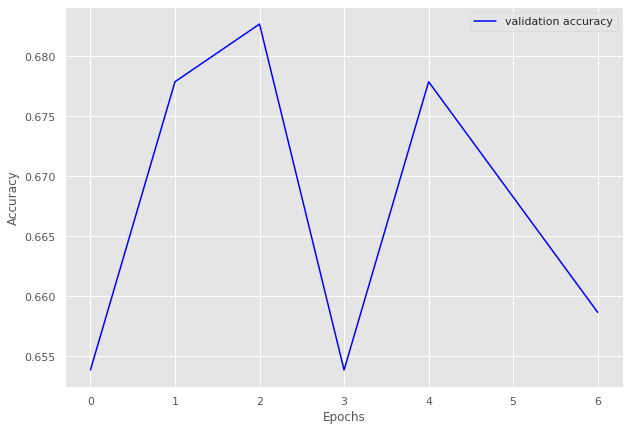

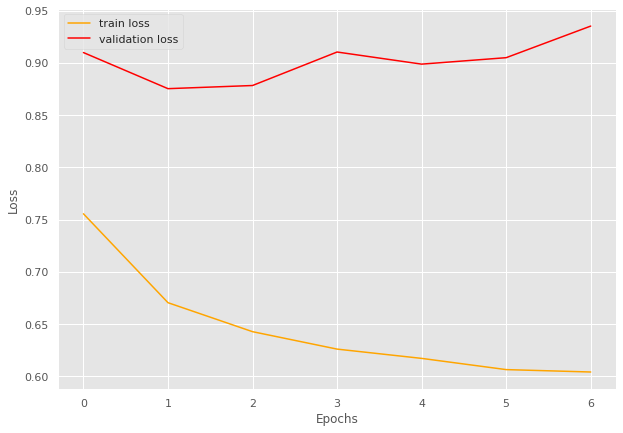

{'0': {'coarse': {'00': 0.8344144759303517, '10': 0.7350631614885627, '20': 0.6717065795249476, '30': 0.587328683607277, '50': 0.4409598595327513, '80': 0.2362093352192362}, 'fine': {'00': {'0': 0.9762140733399405, '1': 0.9764150943396226, '2': 0.9572277227722772, '3': 0.973404255319149, '4': 0.99644128113879, '5': 0.9815242494226328, '7': 0.9389619883040936, '8': 0.9871175523349437, '9': 0.8673469387755102, '11': 0.9451642060861706, '12': 0.9523012552301255, '14': 0.9555808656036446, '15': 0.9640077821011673}, '10': {'0': 0.8848780487804878, '1': 0.8422535211267606, '2': 0.8879103282626101, '3': 0.9231638418079096, '4': 0.9256505576208178, '5': 0.906885758998435, '7': 0.8858381502890174, '8': 0.9591503267973857, '9': 0.7749469214437368, '11': 0.8723911747167561, '12': 0.9203319502074688, '14': 0.8818380743982495, '15': 0.8033088235294118}, '20': {'0': 0.8442064264849075, '1': 0.7038567493112947, '2': 0.8205027494108406, '3': 0.8527889591719379, '4': 0.8386075949367089, '5': 0.80940794

100%|██████████| 201/201 [01:13<00:00,  2.75batch/s, loss=1.97]


train loss 1.9659624959698958, validation loss 1.8725152015686035, validation accuracy 0.6678571428571428
Coarse label 2 Epoch 2
-------------------------------


100%|██████████| 201/201 [01:12<00:00,  2.77batch/s, loss=1.87]


train loss 1.8705768496242923, validation loss 1.8619748089048598, validation accuracy 0.6794642857142857
Coarse label 2 Epoch 3
-------------------------------


100%|██████████| 201/201 [01:12<00:00,  2.79batch/s, loss=1.85]


train loss 1.8470922595825954, validation loss 1.8520405888557434, validation accuracy 0.69375
Coarse label 2 Epoch 4
-------------------------------


100%|██████████| 201/201 [01:12<00:00,  2.77batch/s, loss=1.83]


train loss 1.8293812286794482, validation loss 1.8403651383188036, validation accuracy 0.7017857142857142
Coarse label 2 Epoch 5
-------------------------------


100%|██████████| 201/201 [01:11<00:00,  2.80batch/s, loss=1.81]


train loss 1.8123439805424628, validation loss 1.8352933327356975, validation accuracy 0.7071428571428572
Coarse label 2 Epoch 6
-------------------------------


100%|██████████| 201/201 [01:12<00:00,  2.78batch/s, loss=1.8]


INFO: Early stopping counter 1 of 5
train loss 1.7996204267093792, validation loss 1.8477304577827454, validation accuracy 0.6964285714285714
Coarse label 2 Epoch 7
-------------------------------


100%|██████████| 201/201 [01:12<00:00,  2.79batch/s, loss=1.79]


INFO: Early stopping counter 2 of 5
train loss 1.7935802675598296, validation loss 1.8393624756071303, validation accuracy 0.6982142857142857
Coarse label 2 Epoch 8
-------------------------------


100%|██████████| 201/201 [01:12<00:00,  2.76batch/s, loss=1.78]


INFO: Early stopping counter 3 of 5
train loss 1.780228699024637, validation loss 1.8365602294603984, validation accuracy 0.7044642857142858
Coarse label 2 Epoch 9
-------------------------------


100%|██████████| 201/201 [01:12<00:00,  2.78batch/s, loss=1.78]


train loss 1.7796493507736357, validation loss 1.8350793520609539, validation accuracy 0.7071428571428572
Coarse label 2 Epoch 10
-------------------------------


100%|██████████| 201/201 [01:12<00:00,  2.78batch/s, loss=1.77]


train loss 1.7702646540172065, validation loss 1.8341217305925157, validation accuracy 0.7080357142857143
Coarse label 2 Epoch 11
-------------------------------


100%|██████████| 201/201 [01:12<00:00,  2.77batch/s, loss=1.77]


INFO: Early stopping counter 4 of 5
train loss 1.7652824215628022, validation loss 1.8377292884720697, validation accuracy 0.7026785714285714
Coarse label 2 Epoch 12
-------------------------------


100%|██████████| 201/201 [01:12<00:00,  2.76batch/s, loss=1.76]


train loss 1.7585902374182174, validation loss 1.833874801794688, validation accuracy 0.7071428571428572
Coarse label 2 Epoch 13
-------------------------------


100%|██████████| 201/201 [01:12<00:00,  2.77batch/s, loss=1.76]


train loss 1.7554079341651194, validation loss 1.8296457529067993, validation accuracy 0.7089285714285715
Coarse label 2 Epoch 14
-------------------------------


100%|██████████| 201/201 [01:12<00:00,  2.78batch/s, loss=1.75]


INFO: Early stopping counter 5 of 5
INFO: Early stopping
Done! Saved model with test accuracy 0.6743447180301827 and loss 1.8758668661117555


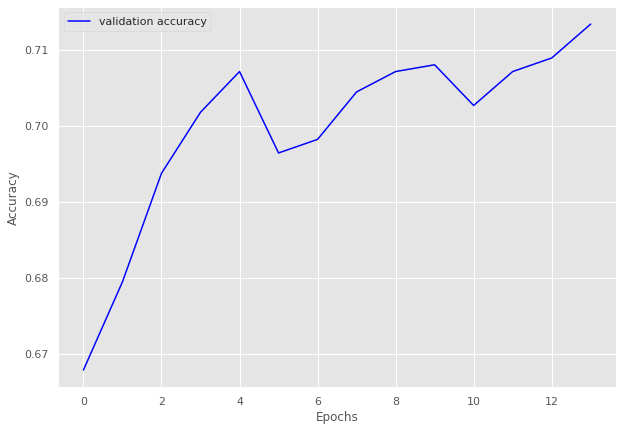

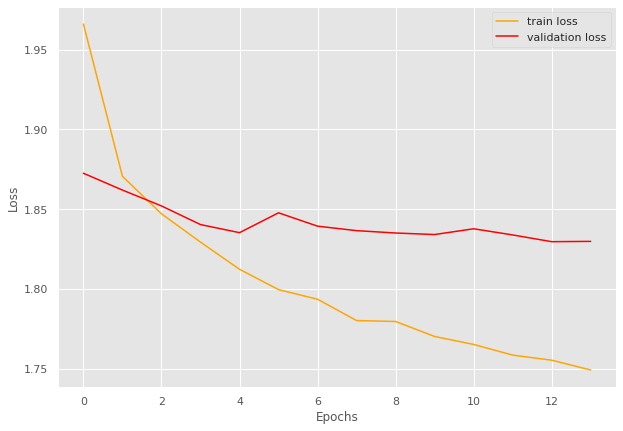

{'0': {'coarse': {'00': 0.8344144759303517, '10': 0.7350631614885627, '20': 0.6717065795249476, '30': 0.587328683607277, '50': 0.4409598595327513, '80': 0.2362093352192362}, 'fine': {'00': {'0': 0.9762140733399405, '1': 0.9764150943396226, '2': 0.9572277227722772, '3': 0.973404255319149, '4': 0.99644128113879, '5': 0.9815242494226328, '7': 0.9389619883040936, '8': 0.9871175523349437, '9': 0.8673469387755102, '11': 0.9451642060861706, '12': 0.9523012552301255, '14': 0.9555808656036446, '15': 0.9640077821011673}, '10': {'0': 0.8848780487804878, '1': 0.8422535211267606, '2': 0.8879103282626101, '3': 0.9231638418079096, '4': 0.9256505576208178, '5': 0.906885758998435, '7': 0.8858381502890174, '8': 0.9591503267973857, '9': 0.7749469214437368, '11': 0.8723911747167561, '12': 0.9203319502074688, '14': 0.8818380743982495, '15': 0.8033088235294118}, '20': {'0': 0.8442064264849075, '1': 0.7038567493112947, '2': 0.8205027494108406, '3': 0.8527889591719379, '4': 0.8386075949367089, '5': 0.80940794

100%|██████████| 141/141 [00:51<00:00,  2.72batch/s, loss=1.65]


train loss 1.6540020180086719, validation loss 1.5594860076904298, validation accuracy 0.7041036717062635
Coarse label 4 Epoch 2
-------------------------------


100%|██████████| 141/141 [00:50<00:00,  2.77batch/s, loss=1.55]


train loss 1.550720306152993, validation loss 1.5330043713251749, validation accuracy 0.7354211663066955
Coarse label 4 Epoch 3
-------------------------------


100%|██████████| 141/141 [00:50<00:00,  2.80batch/s, loss=1.52]


INFO: Early stopping counter 1 of 5
train loss 1.5228138697062823, validation loss 1.5404790719350179, validation accuracy 0.7257019438444925
Coarse label 4 Epoch 4
-------------------------------


100%|██████████| 141/141 [00:50<00:00,  2.80batch/s, loss=1.5] 


INFO: Early stopping counter 2 of 5
train loss 1.5034000958111269, validation loss 1.5395514806111654, validation accuracy 0.7300215982721382
Coarse label 4 Epoch 5
-------------------------------


100%|██████████| 141/141 [00:50<00:00,  2.82batch/s, loss=1.49]


train loss 1.491300010512061, validation loss 1.531019401550293, validation accuracy 0.7375809935205183
Coarse label 4 Epoch 6
-------------------------------


100%|██████████| 141/141 [00:50<00:00,  2.79batch/s, loss=1.48]


INFO: Early stopping counter 3 of 5
train loss 1.4793376846516386, validation loss 1.5352428436279297, validation accuracy 0.734341252699784
Coarse label 4 Epoch 7
-------------------------------


100%|██████████| 141/141 [00:56<00:00,  2.51batch/s, loss=1.47]


INFO: Early stopping counter 4 of 5
train loss 1.470438007767319, validation loss 1.531397787729899, validation accuracy 0.7397408207343412
Coarse label 4 Epoch 8
-------------------------------


100%|██████████| 141/141 [01:42<00:00,  1.37batch/s, loss=1.46]


INFO: Early stopping counter 5 of 5
INFO: Early stopping
Done! Saved model with test accuracy 0.71699196326062 and loss 1.569660825388772


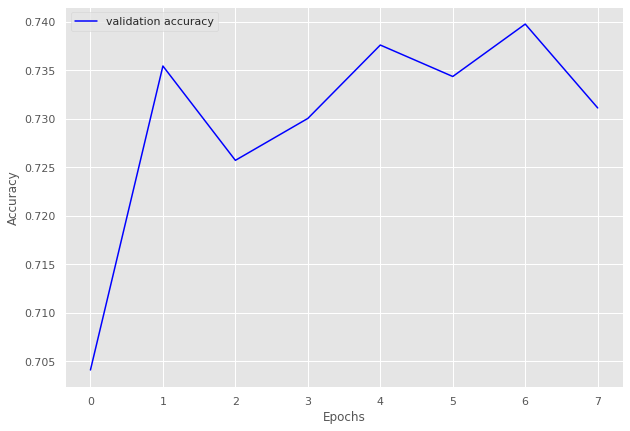

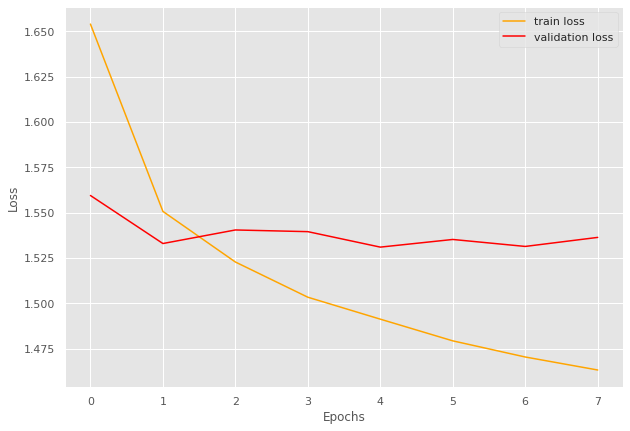

{'0': {'coarse': {'00': 0.8344144759303517, '10': 0.7350631614885627, '20': 0.6717065795249476, '30': 0.587328683607277, '50': 0.4409598595327513, '80': 0.2362093352192362}, 'fine': {'00': {'0': 0.9762140733399405, '1': 0.9764150943396226, '2': 0.9572277227722772, '3': 0.973404255319149, '4': 0.99644128113879, '5': 0.9815242494226328, '7': 0.9389619883040936, '8': 0.9871175523349437, '9': 0.8673469387755102, '11': 0.9451642060861706, '12': 0.9523012552301255, '14': 0.9555808656036446, '15': 0.9640077821011673}, '10': {'0': 0.8848780487804878, '1': 0.8422535211267606, '2': 0.8879103282626101, '3': 0.9231638418079096, '4': 0.9256505576208178, '5': 0.906885758998435, '7': 0.8858381502890174, '8': 0.9591503267973857, '9': 0.7749469214437368, '11': 0.8723911747167561, '12': 0.9203319502074688, '14': 0.8818380743982495, '15': 0.8033088235294118}, '20': {'0': 0.8442064264849075, '1': 0.7038567493112947, '2': 0.8205027494108406, '3': 0.8527889591719379, '4': 0.8386075949367089, '5': 0.80940794

100%|██████████| 118/118 [01:21<00:00,  1.44batch/s, loss=1.71]


train loss 1.7088845877324121, validation loss 1.69356369972229, validation accuracy 0.6046901172529313
Coarse label 5 Epoch 2
-------------------------------


100%|██████████| 118/118 [00:41<00:00,  2.82batch/s, loss=1.6]


train loss 1.6026471752231404, validation loss 1.6871152877807618, validation accuracy 0.5862646566164154
Coarse label 5 Epoch 3
-------------------------------


100%|██████████| 118/118 [00:42<00:00,  2.77batch/s, loss=1.57]


INFO: Early stopping counter 1 of 5
train loss 1.5665322602805445, validation loss 1.6952865481376649, validation accuracy 0.5812395309882747
Coarse label 5 Epoch 4
-------------------------------


100%|██████████| 118/118 [00:42<00:00,  2.77batch/s, loss=1.54]


INFO: Early stopping counter 2 of 5
train loss 1.5435711458577948, validation loss 1.6906981468200684, validation accuracy 0.5912897822445561
Coarse label 5 Epoch 5
-------------------------------


100%|██████████| 118/118 [00:42<00:00,  2.79batch/s, loss=1.53]


INFO: Early stopping counter 3 of 5
train loss 1.5257381867554227, validation loss 1.6920332312583923, validation accuracy 0.5896147403685092
Coarse label 5 Epoch 6
-------------------------------


100%|██████████| 118/118 [00:42<00:00,  2.80batch/s, loss=1.51]


INFO: Early stopping counter 4 of 5
train loss 1.5116475770028972, validation loss 1.7007357239723206, validation accuracy 0.5812395309882747
Coarse label 5 Epoch 7
-------------------------------


100%|██████████| 118/118 [00:42<00:00,  2.79batch/s, loss=1.49]


INFO: Early stopping counter 5 of 5
INFO: Early stopping
Done! Saved model with test accuracy 0.6485943775100401 and loss 1.615917240579923


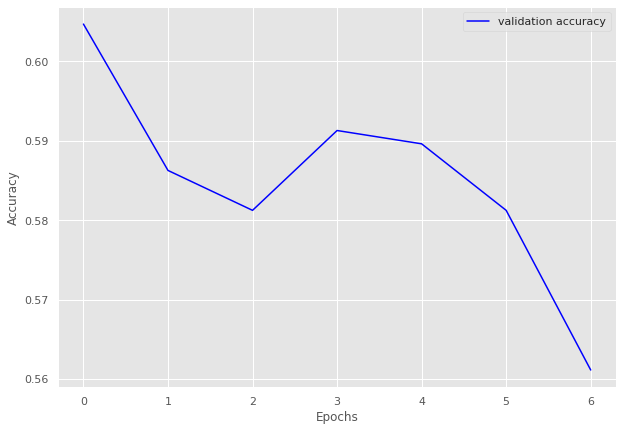

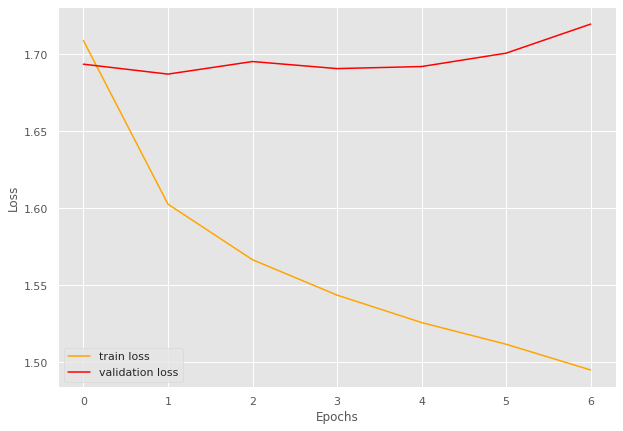

{'0': {'coarse': {'00': 0.8344144759303517, '10': 0.7350631614885627, '20': 0.6717065795249476, '30': 0.587328683607277, '50': 0.4409598595327513, '80': 0.2362093352192362}, 'fine': {'00': {'0': 0.9762140733399405, '1': 0.9764150943396226, '2': 0.9572277227722772, '3': 0.973404255319149, '4': 0.99644128113879, '5': 0.9815242494226328, '7': 0.9389619883040936, '8': 0.9871175523349437, '9': 0.8673469387755102, '11': 0.9451642060861706, '12': 0.9523012552301255, '14': 0.9555808656036446, '15': 0.9640077821011673}, '10': {'0': 0.8848780487804878, '1': 0.8422535211267606, '2': 0.8879103282626101, '3': 0.9231638418079096, '4': 0.9256505576208178, '5': 0.906885758998435, '7': 0.8858381502890174, '8': 0.9591503267973857, '9': 0.7749469214437368, '11': 0.8723911747167561, '12': 0.9203319502074688, '14': 0.8818380743982495, '15': 0.8033088235294118}, '20': {'0': 0.8442064264849075, '1': 0.7038567493112947, '2': 0.8205027494108406, '3': 0.8527889591719379, '4': 0.8386075949367089, '5': 0.80940794

100%|██████████| 26/26 [00:09<00:00,  2.83batch/s, loss=0.517]


train loss 0.5171338640726529, validation loss 0.4583221475283305, validation accuracy 0.8315217391304348
Coarse label 6 Epoch 2
-------------------------------


100%|██████████| 26/26 [00:09<00:00,  2.81batch/s, loss=0.389]


INFO: Early stopping counter 1 of 5
train loss 0.3887752741575241, validation loss 0.4789310892422994, validation accuracy 0.8152173913043478
Coarse label 6 Epoch 3
-------------------------------


100%|██████████| 26/26 [00:09<00:00,  2.76batch/s, loss=0.348]


train loss 0.34760435957175034, validation loss 0.4506388207276662, validation accuracy 0.842391304347826
Coarse label 6 Epoch 4
-------------------------------


100%|██████████| 26/26 [00:09<00:00,  2.82batch/s, loss=0.34] 


INFO: Early stopping counter 2 of 5
train loss 0.3395128892018245, validation loss 0.4702153503894806, validation accuracy 0.8260869565217391
Coarse label 6 Epoch 5
-------------------------------


100%|██████████| 26/26 [00:09<00:00,  2.78batch/s, loss=0.332]


INFO: Early stopping counter 3 of 5
train loss 0.332354690019901, validation loss 0.4572952588399251, validation accuracy 0.842391304347826
Coarse label 6 Epoch 6
-------------------------------


100%|██████████| 26/26 [00:09<00:00,  2.80batch/s, loss=0.327]


INFO: Early stopping counter 4 of 5
train loss 0.32680262052095854, validation loss 0.45428962508837384, validation accuracy 0.8532608695652174
Coarse label 6 Epoch 7
-------------------------------


100%|██████████| 26/26 [00:09<00:00,  2.88batch/s, loss=0.326]


INFO: Early stopping counter 5 of 5
INFO: Early stopping
Done! Saved model with test accuracy 0.7967213114754098 and loss 0.5257015943527221


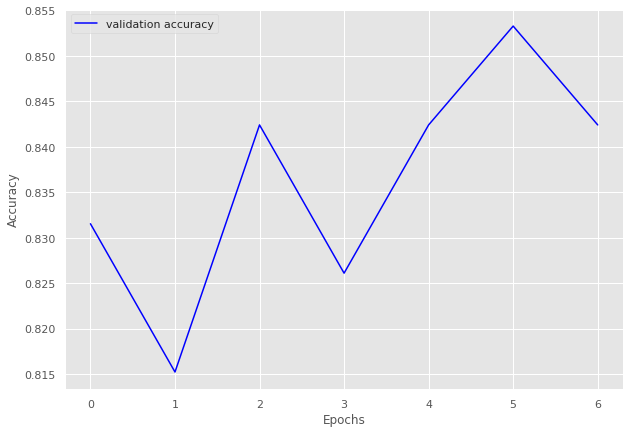

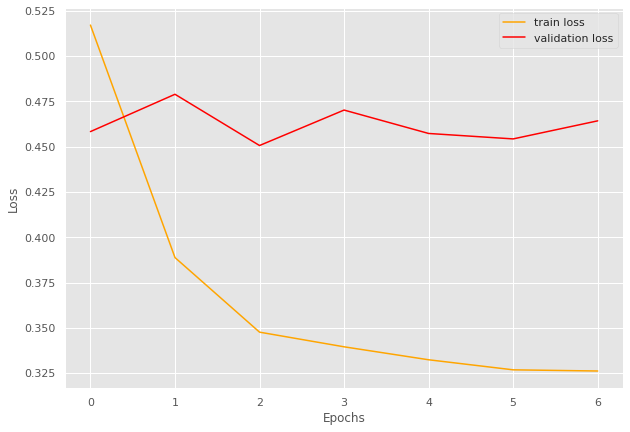

{'0': {'coarse': {'00': 0.8344144759303517, '10': 0.7350631614885627, '20': 0.6717065795249476, '30': 0.587328683607277, '50': 0.4409598595327513, '80': 0.2362093352192362}, 'fine': {'00': {'0': 0.9762140733399405, '1': 0.9764150943396226, '2': 0.9572277227722772, '3': 0.973404255319149, '4': 0.99644128113879, '5': 0.9815242494226328, '7': 0.9389619883040936, '8': 0.9871175523349437, '9': 0.8673469387755102, '11': 0.9451642060861706, '12': 0.9523012552301255, '14': 0.9555808656036446, '15': 0.9640077821011673}, '10': {'0': 0.8848780487804878, '1': 0.8422535211267606, '2': 0.8879103282626101, '3': 0.9231638418079096, '4': 0.9256505576208178, '5': 0.906885758998435, '7': 0.8858381502890174, '8': 0.9591503267973857, '9': 0.7749469214437368, '11': 0.8723911747167561, '12': 0.9203319502074688, '14': 0.8818380743982495, '15': 0.8033088235294118}, '20': {'0': 0.8442064264849075, '1': 0.7038567493112947, '2': 0.8205027494108406, '3': 0.8527889591719379, '4': 0.8386075949367089, '5': 0.80940794

100%|██████████| 68/68 [00:24<00:00,  2.78batch/s, loss=1.02]


train loss 1.0236879648531185, validation loss 0.9701617189816066, validation accuracy 0.7455470737913485
Coarse label 7 Epoch 2
-------------------------------


100%|██████████| 68/68 [00:24<00:00,  2.76batch/s, loss=0.921]


train loss 0.9210065138690612, validation loss 0.9471409661429269, validation accuracy 0.7709923664122137
Coarse label 7 Epoch 3
-------------------------------


100%|██████████| 68/68 [00:24<00:00,  2.81batch/s, loss=0.875]


train loss 0.8746397837119944, validation loss 0.9422709686415536, validation accuracy 0.7760814249363868
Coarse label 7 Epoch 4
-------------------------------


100%|██████████| 68/68 [00:24<00:00,  2.81batch/s, loss=0.843]


train loss 0.8432977252146777, validation loss 0.9281264884131295, validation accuracy 0.7913486005089059
Coarse label 7 Epoch 5
-------------------------------


100%|██████████| 68/68 [00:24<00:00,  2.77batch/s, loss=0.835]


INFO: Early stopping counter 1 of 5
train loss 0.8348036566201378, validation loss 0.9498728343418666, validation accuracy 0.7709923664122137
Coarse label 7 Epoch 6
-------------------------------


100%|██████████| 68/68 [00:24<00:00,  2.79batch/s, loss=0.829]


INFO: Early stopping counter 2 of 5
train loss 0.8291629947283689, validation loss 0.9524819425174168, validation accuracy 0.7659033078880407
Coarse label 7 Epoch 7
-------------------------------


100%|██████████| 68/68 [00:24<00:00,  2.81batch/s, loss=0.825]


INFO: Early stopping counter 3 of 5
train loss 0.8250228438307258, validation loss 0.9328652705465045, validation accuracy 0.7811704834605598
Coarse label 7 Epoch 8
-------------------------------


100%|██████████| 68/68 [00:24<00:00,  2.81batch/s, loss=0.816]


INFO: Early stopping counter 4 of 5
train loss 0.8164259142735425, validation loss 0.9446344716208321, validation accuracy 0.7786259541984732
Coarse label 7 Epoch 9
-------------------------------


100%|██████████| 68/68 [00:24<00:00,  2.82batch/s, loss=0.808]


INFO: Early stopping counter 5 of 5
INFO: Early stopping
Done! Saved model with test accuracy 0.758659217877095 and loss 0.9753814552511487


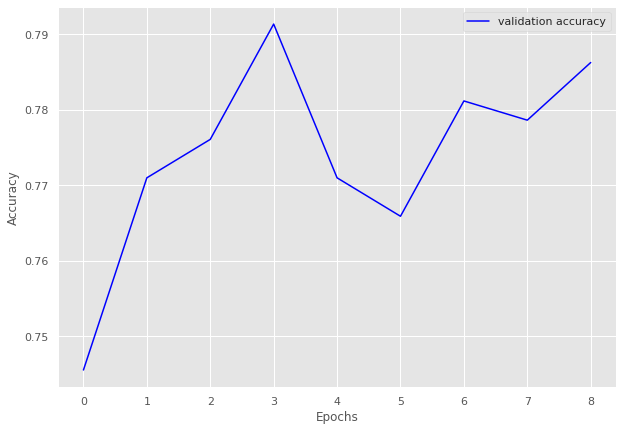

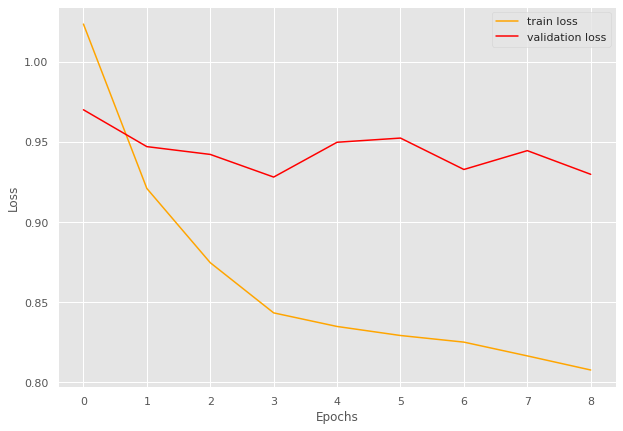

{'0': {'coarse': {'00': 0.8344144759303517, '10': 0.7350631614885627, '20': 0.6717065795249476, '30': 0.587328683607277, '50': 0.4409598595327513, '80': 0.2362093352192362}, 'fine': {'00': {'0': 0.9762140733399405, '1': 0.9764150943396226, '2': 0.9572277227722772, '3': 0.973404255319149, '4': 0.99644128113879, '5': 0.9815242494226328, '7': 0.9389619883040936, '8': 0.9871175523349437, '9': 0.8673469387755102, '11': 0.9451642060861706, '12': 0.9523012552301255, '14': 0.9555808656036446, '15': 0.9640077821011673}, '10': {'0': 0.8848780487804878, '1': 0.8422535211267606, '2': 0.8879103282626101, '3': 0.9231638418079096, '4': 0.9256505576208178, '5': 0.906885758998435, '7': 0.8858381502890174, '8': 0.9591503267973857, '9': 0.7749469214437368, '11': 0.8723911747167561, '12': 0.9203319502074688, '14': 0.8818380743982495, '15': 0.8033088235294118}, '20': {'0': 0.8442064264849075, '1': 0.7038567493112947, '2': 0.8205027494108406, '3': 0.8527889591719379, '4': 0.8386075949367089, '5': 0.80940794

100%|██████████| 89/89 [00:31<00:00,  2.81batch/s, loss=1.42]


train loss 1.4172105494509921, validation loss 1.3212987184524536, validation accuracy 0.7022058823529411
Coarse label 8 Epoch 2
-------------------------------


100%|██████████| 89/89 [00:31<00:00,  2.81batch/s, loss=1.31]


train loss 1.3111158100406775, validation loss 1.295058912701077, validation accuracy 0.7389705882352942
Coarse label 8 Epoch 3
-------------------------------


100%|██████████| 89/89 [00:31<00:00,  2.83batch/s, loss=1.27]


INFO: Early stopping counter 1 of 5
train loss 1.2703346201543058, validation loss 1.2952114873462253, validation accuracy 0.7408088235294118
Coarse label 8 Epoch 4
-------------------------------


100%|██████████| 89/89 [00:36<00:00,  2.45batch/s, loss=1.24]


INFO: Early stopping counter 2 of 5
train loss 1.238824639427528, validation loss 1.306180516878764, validation accuracy 0.7297794117647058
Coarse label 8 Epoch 5
-------------------------------


100%|██████████| 89/89 [00:32<00:00,  2.76batch/s, loss=1.22]


INFO: Early stopping counter 3 of 5
train loss 1.215896603766452, validation loss 1.3019583887524075, validation accuracy 0.7316176470588235
Coarse label 8 Epoch 6
-------------------------------


100%|██████████| 89/89 [00:31<00:00,  2.80batch/s, loss=1.21]


INFO: Early stopping counter 4 of 5
train loss 1.2146700915325894, validation loss 1.3018179072274103, validation accuracy 0.7334558823529411
Coarse label 8 Epoch 7
-------------------------------


100%|██████████| 89/89 [00:31<00:00,  2.81batch/s, loss=1.19]


INFO: Early stopping counter 5 of 5
INFO: Early stopping
Done! Saved model with test accuracy 0.7021883920076119 and loss 1.3543528388528263


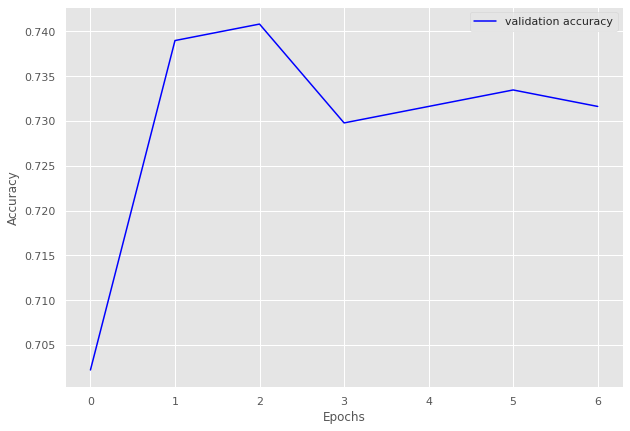

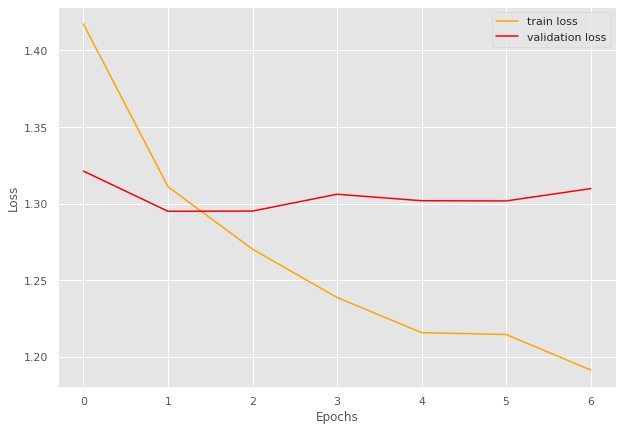

{'0': {'coarse': {'00': 0.8344144759303517, '10': 0.7350631614885627, '20': 0.6717065795249476, '30': 0.587328683607277, '50': 0.4409598595327513, '80': 0.2362093352192362}, 'fine': {'00': {'0': 0.9762140733399405, '1': 0.9764150943396226, '2': 0.9572277227722772, '3': 0.973404255319149, '4': 0.99644128113879, '5': 0.9815242494226328, '7': 0.9389619883040936, '8': 0.9871175523349437, '9': 0.8673469387755102, '11': 0.9451642060861706, '12': 0.9523012552301255, '14': 0.9555808656036446, '15': 0.9640077821011673}, '10': {'0': 0.8848780487804878, '1': 0.8422535211267606, '2': 0.8879103282626101, '3': 0.9231638418079096, '4': 0.9256505576208178, '5': 0.906885758998435, '7': 0.8858381502890174, '8': 0.9591503267973857, '9': 0.7749469214437368, '11': 0.8723911747167561, '12': 0.9203319502074688, '14': 0.8818380743982495, '15': 0.8033088235294118}, '20': {'0': 0.8442064264849075, '1': 0.7038567493112947, '2': 0.8205027494108406, '3': 0.8527889591719379, '4': 0.8386075949367089, '5': 0.80940794

100%|██████████| 113/113 [00:43<00:00,  2.61batch/s, loss=1.36]


train loss 1.3600744262205815, validation loss 1.3042950100368924, validation accuracy 0.7323688969258589
Coarse label 9 Epoch 2
-------------------------------


100%|██████████| 113/113 [01:20<00:00,  1.41batch/s, loss=1.27]


train loss 1.2749075720795489, validation loss 1.282646616299947, validation accuracy 0.7576853526220615
Coarse label 9 Epoch 3
-------------------------------


100%|██████████| 113/113 [01:28<00:00,  1.28batch/s, loss=1.25]


INFO: Early stopping counter 1 of 5
train loss 1.2467096031239602, validation loss 1.2845657401614718, validation accuracy 0.7486437613019892
Coarse label 9 Epoch 4
-------------------------------


100%|██████████| 113/113 [00:58<00:00,  1.93batch/s, loss=1.22]


train loss 1.2188824098722069, validation loss 1.2737339337666829, validation accuracy 0.7649186256781193
Coarse label 9 Epoch 5
-------------------------------


100%|██████████| 113/113 [00:40<00:00,  2.78batch/s, loss=1.2]


INFO: Early stopping counter 2 of 5
train loss 1.2009769889105737, validation loss 1.2754007312986586, validation accuracy 0.759493670886076
Coarse label 9 Epoch 6
-------------------------------


100%|██████████| 113/113 [00:40<00:00,  2.78batch/s, loss=1.19]


INFO: Early stopping counter 3 of 5
train loss 1.1895392457995795, validation loss 1.2962530321545072, validation accuracy 0.7359855334538878
Coarse label 9 Epoch 7
-------------------------------


100%|██████████| 113/113 [00:40<00:00,  2.77batch/s, loss=1.18]


INFO: Early stopping counter 4 of 5
train loss 1.1774603466017057, validation loss 1.2892252736621432, validation accuracy 0.755877034358047
Coarse label 9 Epoch 8
-------------------------------


100%|██████████| 113/113 [00:41<00:00,  2.73batch/s, loss=1.17]


INFO: Early stopping counter 5 of 5
INFO: Early stopping
Done! Saved model with test accuracy 0.7509051412020276 and loss 1.2886738126928157


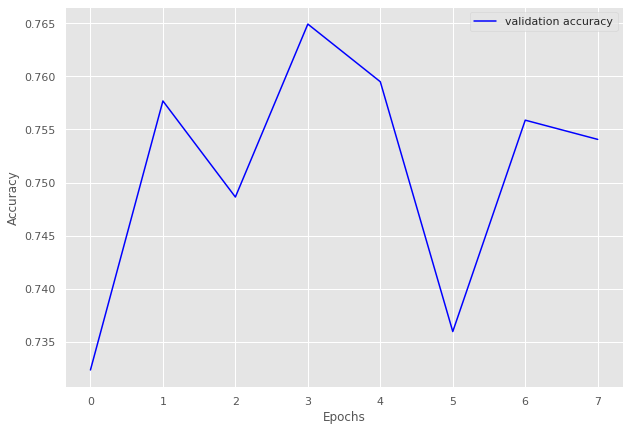

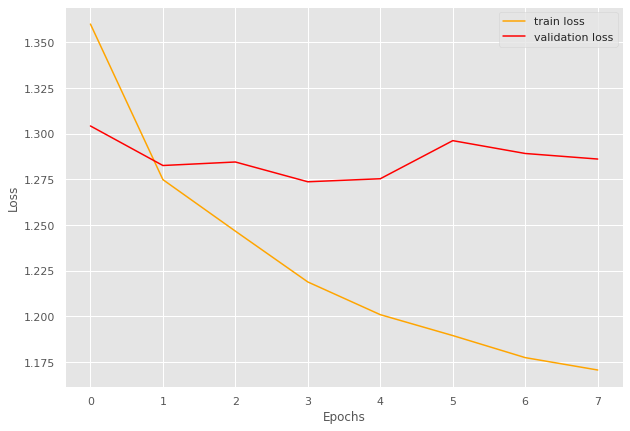

{'0': {'coarse': {'00': 0.8344144759303517, '10': 0.7350631614885627, '20': 0.6717065795249476, '30': 0.587328683607277, '50': 0.4409598595327513, '80': 0.2362093352192362}, 'fine': {'00': {'0': 0.9762140733399405, '1': 0.9764150943396226, '2': 0.9572277227722772, '3': 0.973404255319149, '4': 0.99644128113879, '5': 0.9815242494226328, '7': 0.9389619883040936, '8': 0.9871175523349437, '9': 0.8673469387755102, '11': 0.9451642060861706, '12': 0.9523012552301255, '14': 0.9555808656036446, '15': 0.9640077821011673}, '10': {'0': 0.8848780487804878, '1': 0.8422535211267606, '2': 0.8879103282626101, '3': 0.9231638418079096, '4': 0.9256505576208178, '5': 0.906885758998435, '7': 0.8858381502890174, '8': 0.9591503267973857, '9': 0.7749469214437368, '11': 0.8723911747167561, '12': 0.9203319502074688, '14': 0.8818380743982495, '15': 0.8033088235294118}, '20': {'0': 0.8442064264849075, '1': 0.7038567493112947, '2': 0.8205027494108406, '3': 0.8527889591719379, '4': 0.8386075949367089, '5': 0.80940794

100%|██████████| 95/95 [00:34<00:00,  2.76batch/s, loss=1.19]


train loss 1.1856006446637606, validation loss 1.0898739207874646, validation accuracy 0.8054711246200608
Coarse label 11 Epoch 2
-------------------------------


100%|██████████| 95/95 [00:34<00:00,  2.79batch/s, loss=1.1] 


train loss 1.0965558183820625, validation loss 1.074719168923118, validation accuracy 0.8145896656534954
Coarse label 11 Epoch 3
-------------------------------


100%|██████████| 95/95 [00:33<00:00,  2.81batch/s, loss=1.07]


INFO: Early stopping counter 1 of 5
train loss 1.0712889188214352, validation loss 1.102810176936063, validation accuracy 0.790273556231003
Coarse label 11 Epoch 4
-------------------------------


100%|██████████| 95/95 [00:34<00:00,  2.76batch/s, loss=1.05]


INFO: Early stopping counter 2 of 5
train loss 1.0531832236992686, validation loss 1.0920243642546914, validation accuracy 0.8054711246200608
Coarse label 11 Epoch 5
-------------------------------


100%|██████████| 95/95 [00:33<00:00,  2.80batch/s, loss=1.04]


INFO: Early stopping counter 3 of 5
train loss 1.0414874547406248, validation loss 1.091707706451416, validation accuracy 0.8085106382978723
Coarse label 11 Epoch 6
-------------------------------


100%|██████████| 95/95 [00:33<00:00,  2.80batch/s, loss=1.03]


INFO: Early stopping counter 4 of 5
train loss 1.0305930507810492, validation loss 1.0882535034959966, validation accuracy 0.8085106382978723
Coarse label 11 Epoch 7
-------------------------------


100%|██████████| 95/95 [00:33<00:00,  2.82batch/s, loss=1.02]


INFO: Early stopping counter 5 of 5
INFO: Early stopping
Done! Saved model with test accuracy 0.7843137254901961 and loss 1.1399902939796447


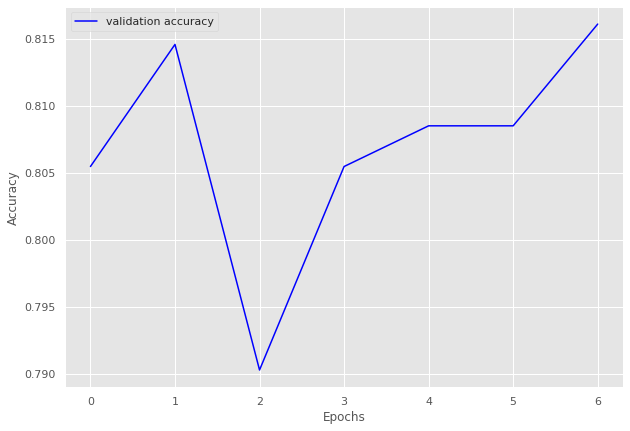

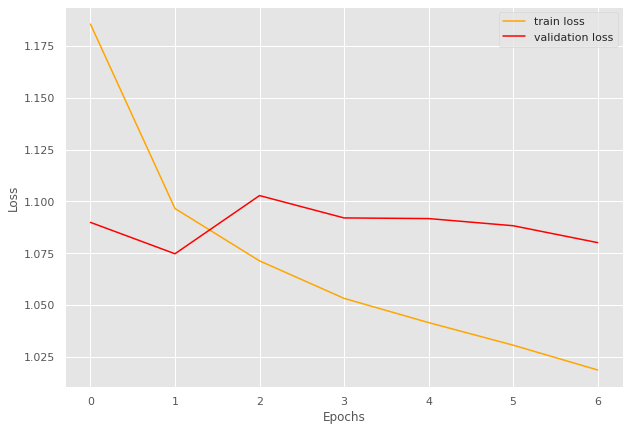

{'0': {'coarse': {'00': 0.8344144759303517, '10': 0.7350631614885627, '20': 0.6717065795249476, '30': 0.587328683607277, '50': 0.4409598595327513, '80': 0.2362093352192362}, 'fine': {'00': {'0': 0.9762140733399405, '1': 0.9764150943396226, '2': 0.9572277227722772, '3': 0.973404255319149, '4': 0.99644128113879, '5': 0.9815242494226328, '7': 0.9389619883040936, '8': 0.9871175523349437, '9': 0.8673469387755102, '11': 0.9451642060861706, '12': 0.9523012552301255, '14': 0.9555808656036446, '15': 0.9640077821011673}, '10': {'0': 0.8848780487804878, '1': 0.8422535211267606, '2': 0.8879103282626101, '3': 0.9231638418079096, '4': 0.9256505576208178, '5': 0.906885758998435, '7': 0.8858381502890174, '8': 0.9591503267973857, '9': 0.7749469214437368, '11': 0.8723911747167561, '12': 0.9203319502074688, '14': 0.8818380743982495, '15': 0.8033088235294118}, '20': {'0': 0.8442064264849075, '1': 0.7038567493112947, '2': 0.8205027494108406, '3': 0.8527889591719379, '4': 0.8386075949367089, '5': 0.80940794

100%|██████████| 44/44 [00:15<00:00,  2.80batch/s, loss=0.792]


train loss 0.7921605733307925, validation loss 0.794150447845459, validation accuracy 0.7315436241610739
Coarse label 12 Epoch 2
-------------------------------


100%|██████████| 44/44 [00:15<00:00,  2.82batch/s, loss=0.68] 


INFO: Early stopping counter 1 of 5
train loss 0.6795202385295521, validation loss 0.7975053071975708, validation accuracy 0.7281879194630873
Coarse label 12 Epoch 3
-------------------------------


100%|██████████| 44/44 [00:15<00:00,  2.78batch/s, loss=0.634]


INFO: Early stopping counter 2 of 5
train loss 0.6341164030812003, validation loss 0.8009444952011109, validation accuracy 0.7348993288590604
Coarse label 12 Epoch 4
-------------------------------


100%|██████████| 44/44 [00:15<00:00,  2.80batch/s, loss=0.615]


INFO: Early stopping counter 3 of 5
train loss 0.615469835021279, validation loss 0.7956641793251038, validation accuracy 0.7315436241610739
Coarse label 12 Epoch 5
-------------------------------


100%|██████████| 44/44 [00:15<00:00,  2.82batch/s, loss=0.601]


INFO: Early stopping counter 4 of 5
train loss 0.6013184677470814, validation loss 0.7952999591827392, validation accuracy 0.7583892617449665
Coarse label 12 Epoch 6
-------------------------------


100%|██████████| 44/44 [00:15<00:00,  2.78batch/s, loss=0.594]


INFO: Early stopping counter 5 of 5
INFO: Early stopping
Done! Saved model with test accuracy 0.7958833619210978 and loss 0.7920961976051331


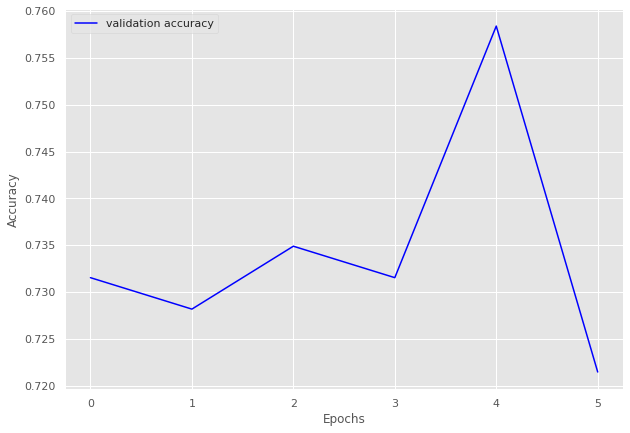

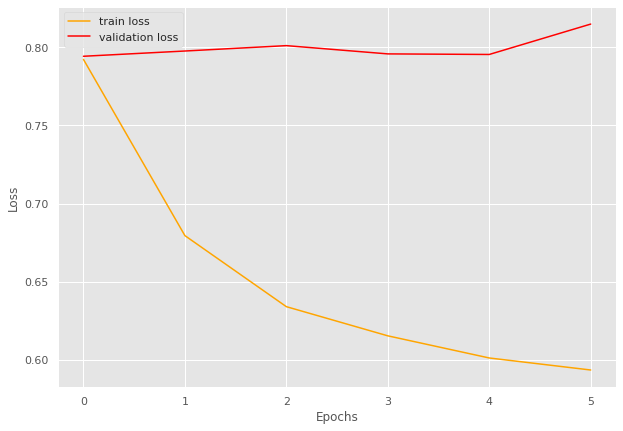

{'0': {'coarse': {'00': 0.8344144759303517, '10': 0.7350631614885627, '20': 0.6717065795249476, '30': 0.587328683607277, '50': 0.4409598595327513, '80': 0.2362093352192362}, 'fine': {'00': {'0': 0.9762140733399405, '1': 0.9764150943396226, '2': 0.9572277227722772, '3': 0.973404255319149, '4': 0.99644128113879, '5': 0.9815242494226328, '7': 0.9389619883040936, '8': 0.9871175523349437, '9': 0.8673469387755102, '11': 0.9451642060861706, '12': 0.9523012552301255, '14': 0.9555808656036446, '15': 0.9640077821011673}, '10': {'0': 0.8848780487804878, '1': 0.8422535211267606, '2': 0.8879103282626101, '3': 0.9231638418079096, '4': 0.9256505576208178, '5': 0.906885758998435, '7': 0.8858381502890174, '8': 0.9591503267973857, '9': 0.7749469214437368, '11': 0.8723911747167561, '12': 0.9203319502074688, '14': 0.8818380743982495, '15': 0.8033088235294118}, '20': {'0': 0.8442064264849075, '1': 0.7038567493112947, '2': 0.8205027494108406, '3': 0.8527889591719379, '4': 0.8386075949367089, '5': 0.80940794

100%|██████████| 205/205 [01:15<00:00,  2.72batch/s, loss=1.68]


train loss 1.675993815282496, validation loss 1.6799405097961426, validation accuracy 0.6853685368536854
Coarse label 13 Epoch 2
-------------------------------


100%|██████████| 205/205 [01:13<00:00,  2.77batch/s, loss=1.6] 


train loss 1.6046069313840168, validation loss 1.662174121538798, validation accuracy 0.7051705170517052
Coarse label 13 Epoch 3
-------------------------------


100%|██████████| 205/205 [01:14<00:00,  2.76batch/s, loss=1.59]


INFO: Early stopping counter 1 of 5
train loss 1.5911672935253236, validation loss 1.665134104092916, validation accuracy 0.6996699669966997
Coarse label 13 Epoch 4
-------------------------------


100%|██████████| 205/205 [01:13<00:00,  2.78batch/s, loss=1.57]


train loss 1.5731190262771235, validation loss 1.6559768279393514, validation accuracy 0.7095709570957096
Coarse label 13 Epoch 5
-------------------------------


100%|██████████| 205/205 [01:14<00:00,  2.77batch/s, loss=1.57]


train loss 1.568938142497365, validation loss 1.6483647187550863, validation accuracy 0.7216721672167217
Coarse label 13 Epoch 6
-------------------------------


100%|██████████| 205/205 [01:13<00:00,  2.79batch/s, loss=1.56]


train loss 1.5633904590839294, validation loss 1.6448238213857016, validation accuracy 0.7304730473047305
Coarse label 13 Epoch 7
-------------------------------


100%|██████████| 205/205 [01:13<00:00,  2.78batch/s, loss=1.55]


INFO: Early stopping counter 2 of 5
train loss 1.554858047787736, validation loss 1.6614002148310343, validation accuracy 0.7062706270627063
Coarse label 13 Epoch 8
-------------------------------


100%|██████████| 205/205 [01:13<00:00,  2.78batch/s, loss=1.55]


INFO: Early stopping counter 3 of 5
train loss 1.5490976909311807, validation loss 1.6493002414703368, validation accuracy 0.7183718371837183
Coarse label 13 Epoch 9
-------------------------------


100%|██████████| 205/205 [01:13<00:00,  2.78batch/s, loss=1.54]


INFO: Early stopping counter 4 of 5
train loss 1.5434004004408675, validation loss 1.6524935801823935, validation accuracy 0.7216721672167217
Coarse label 13 Epoch 10
-------------------------------


100%|██████████| 205/205 [01:13<00:00,  2.79batch/s, loss=1.54]


INFO: Early stopping counter 5 of 5
INFO: Early stopping
Done! Saved model with test accuracy 0.7595356550580431 and loss 1.6081773293645758


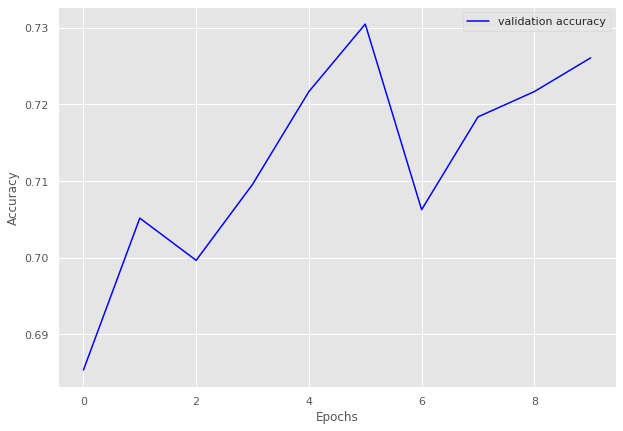

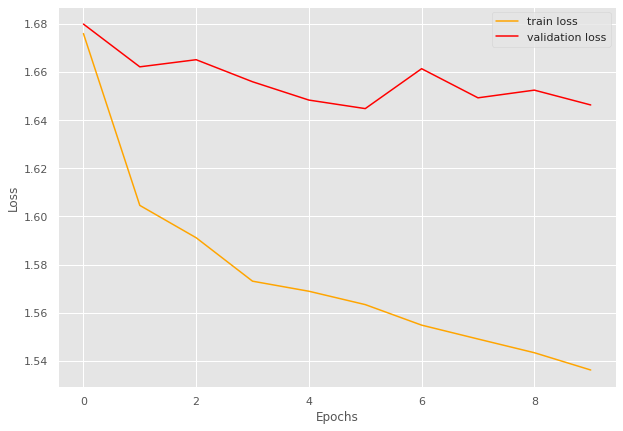

{'0': {'coarse': {'00': 0.8344144759303517, '10': 0.7350631614885627, '20': 0.6717065795249476, '30': 0.587328683607277, '50': 0.4409598595327513, '80': 0.2362093352192362}, 'fine': {'00': {'0': 0.9762140733399405, '1': 0.9764150943396226, '2': 0.9572277227722772, '3': 0.973404255319149, '4': 0.99644128113879, '5': 0.9815242494226328, '7': 0.9389619883040936, '8': 0.9871175523349437, '9': 0.8673469387755102, '11': 0.9451642060861706, '12': 0.9523012552301255, '14': 0.9555808656036446, '15': 0.9640077821011673}, '10': {'0': 0.8848780487804878, '1': 0.8422535211267606, '2': 0.8879103282626101, '3': 0.9231638418079096, '4': 0.9256505576208178, '5': 0.906885758998435, '7': 0.8858381502890174, '8': 0.9591503267973857, '9': 0.7749469214437368, '11': 0.8723911747167561, '12': 0.9203319502074688, '14': 0.8818380743982495, '15': 0.8033088235294118}, '20': {'0': 0.8442064264849075, '1': 0.7038567493112947, '2': 0.8205027494108406, '3': 0.8527889591719379, '4': 0.8386075949367089, '5': 0.80940794

100%|██████████| 39/39 [00:13<00:00,  2.86batch/s, loss=0.888]


train loss 0.8879074393174587, validation loss 0.7865473330020905, validation accuracy 0.7185929648241206
Coarse label 14 Epoch 2
-------------------------------


100%|██████████| 39/39 [00:13<00:00,  2.80batch/s, loss=0.739]


INFO: Early stopping counter 1 of 5
train loss 0.7388255397478739, validation loss 0.8406745791435242, validation accuracy 0.6934673366834171
Coarse label 14 Epoch 3
-------------------------------


100%|██████████| 39/39 [00:13<00:00,  2.87batch/s, loss=0.658]


INFO: Early stopping counter 2 of 5
train loss 0.6583921435551766, validation loss 0.8103446513414383, validation accuracy 0.6984924623115578
Coarse label 14 Epoch 4
-------------------------------


100%|██████████| 39/39 [00:13<00:00,  2.82batch/s, loss=0.633]


INFO: Early stopping counter 3 of 5
train loss 0.6326659016120129, validation loss 0.8123917877674103, validation accuracy 0.7035175879396985
Coarse label 14 Epoch 5
-------------------------------


100%|██████████| 39/39 [00:13<00:00,  2.83batch/s, loss=0.619]


INFO: Early stopping counter 4 of 5
train loss 0.6191812875943307, validation loss 0.8170562237501144, validation accuracy 0.7035175879396985
Coarse label 14 Epoch 6
-------------------------------


100%|██████████| 39/39 [00:13<00:00,  2.81batch/s, loss=0.614]


INFO: Early stopping counter 5 of 5
INFO: Early stopping
Done! Saved model with test accuracy 0.6889848812095032 and loss 0.8292658776044846


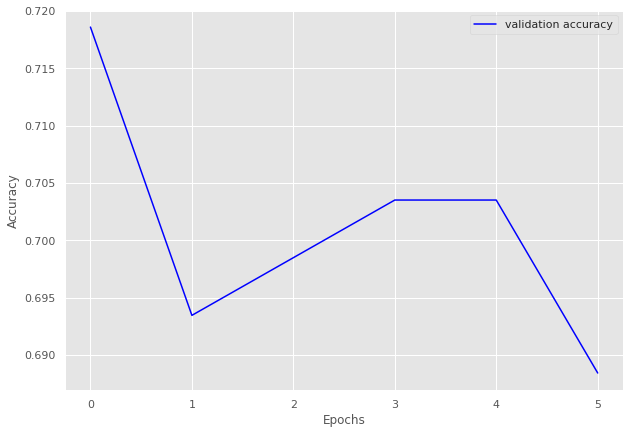

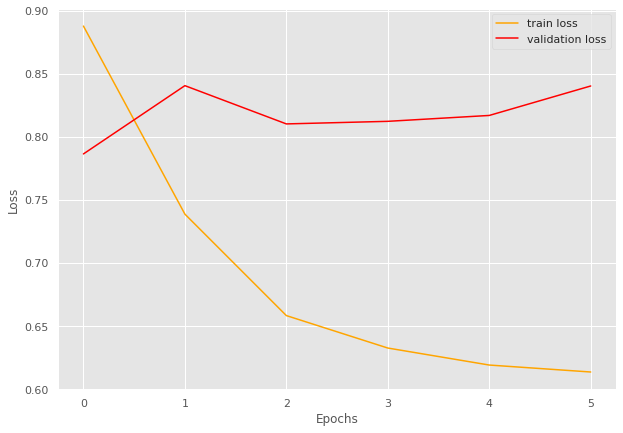

{'0': {'coarse': {'00': 0.8344144759303517, '10': 0.7350631614885627, '20': 0.6717065795249476, '30': 0.587328683607277, '50': 0.4409598595327513, '80': 0.2362093352192362}, 'fine': {'00': {'0': 0.9762140733399405, '1': 0.9764150943396226, '2': 0.9572277227722772, '3': 0.973404255319149, '4': 0.99644128113879, '5': 0.9815242494226328, '7': 0.9389619883040936, '8': 0.9871175523349437, '9': 0.8673469387755102, '11': 0.9451642060861706, '12': 0.9523012552301255, '14': 0.9555808656036446, '15': 0.9640077821011673}, '10': {'0': 0.8848780487804878, '1': 0.8422535211267606, '2': 0.8879103282626101, '3': 0.9231638418079096, '4': 0.9256505576208178, '5': 0.906885758998435, '7': 0.8858381502890174, '8': 0.9591503267973857, '9': 0.7749469214437368, '11': 0.8723911747167561, '12': 0.9203319502074688, '14': 0.8818380743982495, '15': 0.8033088235294118}, '20': {'0': 0.8442064264849075, '1': 0.7038567493112947, '2': 0.8205027494108406, '3': 0.8527889591719379, '4': 0.8386075949367089, '5': 0.80940794

100%|██████████| 85/85 [00:31<00:00,  2.74batch/s, loss=0.985]


train loss 0.9846685928456923, validation loss 0.8892744647132026, validation accuracy 0.8597449908925319
Coarse label 15 Epoch 2
-------------------------------


100%|██████████| 85/85 [00:30<00:00,  2.80batch/s, loss=0.9]  


INFO: Early stopping counter 1 of 5
train loss 0.9004709257799036, validation loss 0.8968037565549215, validation accuracy 0.8451730418943534
Coarse label 15 Epoch 3
-------------------------------


100%|██████████| 85/85 [00:30<00:00,  2.81batch/s, loss=0.874]


train loss 0.874021321885726, validation loss 0.8863640096452501, validation accuracy 0.8542805100182149
Coarse label 15 Epoch 4
-------------------------------


100%|██████████| 85/85 [00:30<00:00,  2.80batch/s, loss=0.856]


INFO: Early stopping counter 2 of 5
train loss 0.8561049391241634, validation loss 0.8874053623941209, validation accuracy 0.848816029143898
Coarse label 15 Epoch 5
-------------------------------


100%|██████████| 85/85 [00:30<00:00,  2.81batch/s, loss=0.842]


INFO: Early stopping counter 3 of 5
train loss 0.841684640155119, validation loss 0.8926296499040391, validation accuracy 0.8506375227686703
Coarse label 15 Epoch 6
-------------------------------


100%|██████████| 85/85 [00:30<00:00,  2.81batch/s, loss=0.833]


INFO: Early stopping counter 4 of 5
train loss 0.8333476024515488, validation loss 0.8999925785594516, validation accuracy 0.848816029143898
Coarse label 15 Epoch 7
-------------------------------


100%|██████████| 85/85 [00:30<00:00,  2.79batch/s, loss=0.829]


INFO: Early stopping counter 5 of 5
INFO: Early stopping
Done! Saved model with test accuracy 0.7791239515377446 and loss 0.9630460633951075


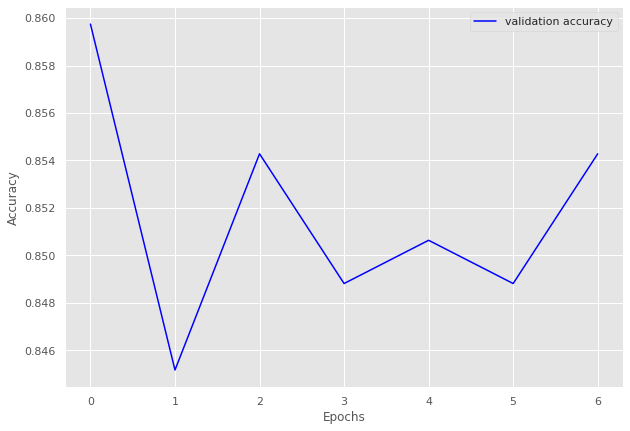

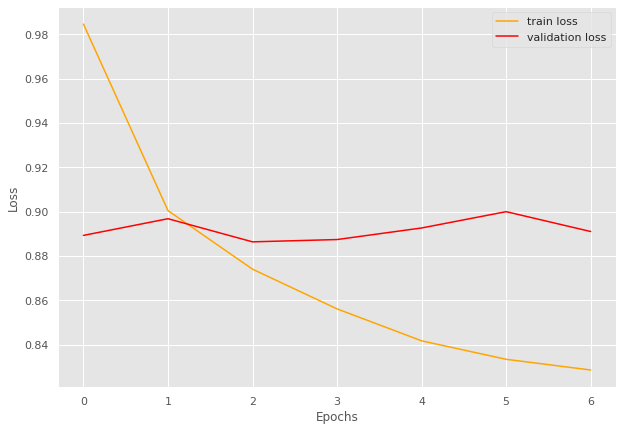

{'0': {'coarse': {'00': 0.8344144759303517, '10': 0.7350631614885627, '20': 0.6717065795249476, '30': 0.587328683607277, '50': 0.4409598595327513, '80': 0.2362093352192362}, 'fine': {'00': {'0': 0.9762140733399405, '1': 0.9764150943396226, '2': 0.9572277227722772, '3': 0.973404255319149, '4': 0.99644128113879, '5': 0.9815242494226328, '7': 0.9389619883040936, '8': 0.9871175523349437, '9': 0.8673469387755102, '11': 0.9451642060861706, '12': 0.9523012552301255, '14': 0.9555808656036446, '15': 0.9640077821011673}, '10': {'0': 0.8848780487804878, '1': 0.8422535211267606, '2': 0.8879103282626101, '3': 0.9231638418079096, '4': 0.9256505576208178, '5': 0.906885758998435, '7': 0.8858381502890174, '8': 0.9591503267973857, '9': 0.7749469214437368, '11': 0.8723911747167561, '12': 0.9203319502074688, '14': 0.8818380743982495, '15': 0.8033088235294118}, '20': {'0': 0.8442064264849075, '1': 0.7038567493112947, '2': 0.8205027494108406, '3': 0.8527889591719379, '4': 0.8386075949367089, '5': 0.80940794

100%|██████████| 118/118 [00:43<00:00,  2.73batch/s, loss=1.33]


train loss 1.3307359986386056, validation loss 1.3715377002954483, validation accuracy 0.6719367588932806
Coarse label 16 Epoch 2
-------------------------------


100%|██████████| 118/118 [00:42<00:00,  2.78batch/s, loss=1.25]


train loss 1.2500871914928242, validation loss 1.3520461022853851, validation accuracy 0.6857707509881423
Coarse label 16 Epoch 3
-------------------------------


100%|██████████| 118/118 [00:42<00:00,  2.77batch/s, loss=1.22]


INFO: Early stopping counter 1 of 5
train loss 1.2215390185178336, validation loss 1.3898732364177704, validation accuracy 0.6482213438735178
Coarse label 16 Epoch 4
-------------------------------


100%|██████████| 118/118 [00:42<00:00,  2.79batch/s, loss=1.21]


INFO: Early stopping counter 2 of 5
train loss 1.2094303622084148, validation loss 1.378439024090767, validation accuracy 0.6541501976284585
Coarse label 16 Epoch 5
-------------------------------


100%|██████████| 118/118 [00:42<00:00,  2.79batch/s, loss=1.2]


INFO: Early stopping counter 3 of 5
train loss 1.2010029786724155, validation loss 1.3769447058439255, validation accuracy 0.658102766798419
Coarse label 16 Epoch 6
-------------------------------


100%|██████████| 118/118 [00:42<00:00,  2.79batch/s, loss=1.19]


INFO: Early stopping counter 4 of 5
train loss 1.1872150796954914, validation loss 1.3635499030351639, validation accuracy 0.6679841897233202
Coarse label 16 Epoch 7
-------------------------------


100%|██████████| 118/118 [00:42<00:00,  2.79batch/s, loss=1.18]


INFO: Early stopping counter 5 of 5
INFO: Early stopping
Done! Saved model with test accuracy 0.7573426573426574 and loss 1.2965078457542087


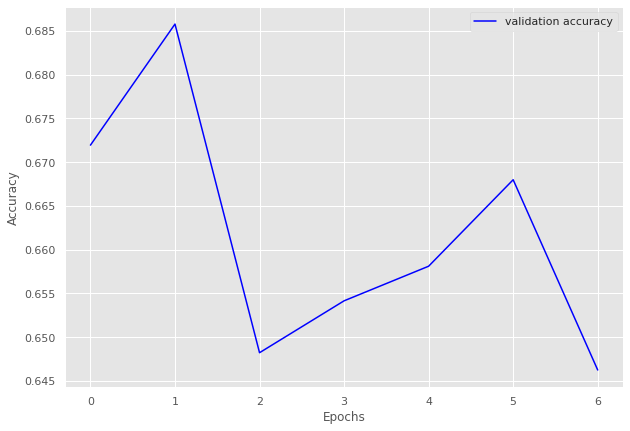

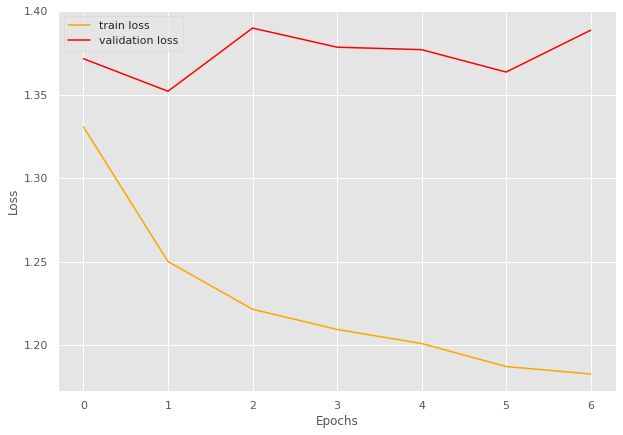

{'0': {'coarse': {'00': 0.8344144759303517, '10': 0.7350631614885627, '20': 0.6717065795249476, '30': 0.587328683607277, '50': 0.4409598595327513, '80': 0.2362093352192362}, 'fine': {'00': {'0': 0.9762140733399405, '1': 0.9764150943396226, '2': 0.9572277227722772, '3': 0.973404255319149, '4': 0.99644128113879, '5': 0.9815242494226328, '7': 0.9389619883040936, '8': 0.9871175523349437, '9': 0.8673469387755102, '11': 0.9451642060861706, '12': 0.9523012552301255, '14': 0.9555808656036446, '15': 0.9640077821011673}, '10': {'0': 0.8848780487804878, '1': 0.8422535211267606, '2': 0.8879103282626101, '3': 0.9231638418079096, '4': 0.9256505576208178, '5': 0.906885758998435, '7': 0.8858381502890174, '8': 0.9591503267973857, '9': 0.7749469214437368, '11': 0.8723911747167561, '12': 0.9203319502074688, '14': 0.8818380743982495, '15': 0.8033088235294118}, '20': {'0': 0.8442064264849075, '1': 0.7038567493112947, '2': 0.8205027494108406, '3': 0.8527889591719379, '4': 0.8386075949367089, '5': 0.80940794

100%|██████████| 73/73 [00:27<00:00,  2.69batch/s, loss=1.04]


train loss 1.0370762070564374, validation loss 0.9336152598261833, validation accuracy 0.8075313807531381
Coarse label 17 Epoch 2
-------------------------------


100%|██████████| 73/73 [00:26<00:00,  2.80batch/s, loss=0.926]


train loss 0.9260991354511209, validation loss 0.930507242679596, validation accuracy 0.8096234309623431
Coarse label 17 Epoch 3
-------------------------------


100%|██████████| 73/73 [00:26<00:00,  2.80batch/s, loss=0.881]


INFO: Early stopping counter 1 of 5
train loss 0.8808799083918741, validation loss 0.9402556642889977, validation accuracy 0.7949790794979079
Coarse label 17 Epoch 4
-------------------------------


100%|██████████| 73/73 [00:26<00:00,  2.79batch/s, loss=0.863]


INFO: Early stopping counter 2 of 5
train loss 0.8628983277164094, validation loss 0.9415498897433281, validation accuracy 0.801255230125523
Coarse label 17 Epoch 5
-------------------------------


100%|██████████| 73/73 [00:26<00:00,  2.78batch/s, loss=0.861]


INFO: Early stopping counter 3 of 5
train loss 0.8606868378103596, validation loss 0.9416879341006279, validation accuracy 0.7949790794979079
Coarse label 17 Epoch 6
-------------------------------


100%|██████████| 73/73 [00:26<00:00,  2.77batch/s, loss=0.844]


INFO: Early stopping counter 4 of 5
train loss 0.84396464204135, validation loss 0.9313927814364433, validation accuracy 0.805439330543933
Coarse label 17 Epoch 7
-------------------------------


100%|██████████| 73/73 [00:31<00:00,  2.32batch/s, loss=0.835]


INFO: Early stopping counter 5 of 5
INFO: Early stopping
Done! Saved model with test accuracy 0.7769709543568465 and loss 0.9790935479104519


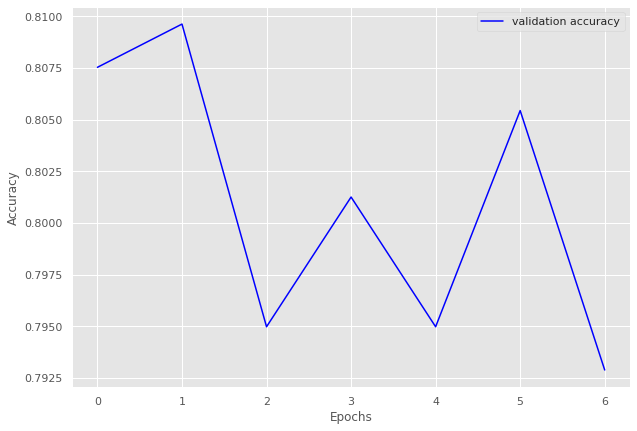

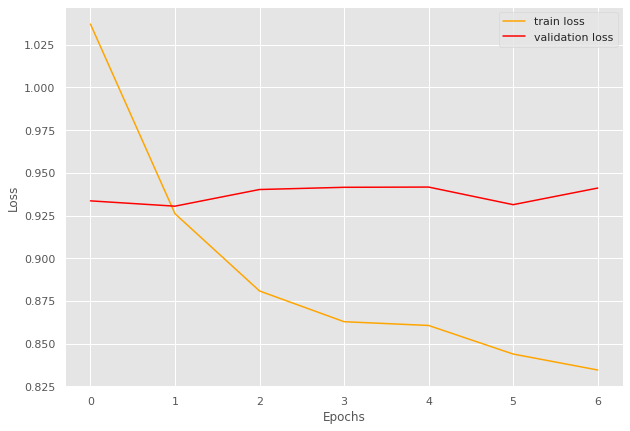

{'0': {'coarse': {'00': 0.8344144759303517, '10': 0.7350631614885627, '20': 0.6717065795249476, '30': 0.587328683607277, '50': 0.4409598595327513, '80': 0.2362093352192362}, 'fine': {'00': {'0': 0.9762140733399405, '1': 0.9764150943396226, '2': 0.9572277227722772, '3': 0.973404255319149, '4': 0.99644128113879, '5': 0.9815242494226328, '7': 0.9389619883040936, '8': 0.9871175523349437, '9': 0.8673469387755102, '11': 0.9451642060861706, '12': 0.9523012552301255, '14': 0.9555808656036446, '15': 0.9640077821011673}, '10': {'0': 0.8848780487804878, '1': 0.8422535211267606, '2': 0.8879103282626101, '3': 0.9231638418079096, '4': 0.9256505576208178, '5': 0.906885758998435, '7': 0.8858381502890174, '8': 0.9591503267973857, '9': 0.7749469214437368, '11': 0.8723911747167561, '12': 0.9203319502074688, '14': 0.8818380743982495, '15': 0.8033088235294118}, '20': {'0': 0.8442064264849075, '1': 0.7038567493112947, '2': 0.8205027494108406, '3': 0.8527889591719379, '4': 0.8386075949367089, '5': 0.80940794

100%|██████████| 18/18 [00:10<00:00,  1.64batch/s, loss=0.577]


train loss 0.5765040235386955, validation loss 0.5191449224948883, validation accuracy 0.7850467289719626
Coarse label 18 Epoch 2
-------------------------------


100%|██████████| 18/18 [00:11<00:00,  1.51batch/s, loss=0.416]


INFO: Early stopping counter 1 of 5
train loss 0.4156743023130629, validation loss 0.5277360677719116, validation accuracy 0.7850467289719626
Coarse label 18 Epoch 3
-------------------------------


100%|██████████| 18/18 [00:13<00:00,  1.33batch/s, loss=0.338]


INFO: Early stopping counter 2 of 5
train loss 0.3379106885857052, validation loss 0.53040412068367, validation accuracy 0.7570093457943925
Coarse label 18 Epoch 4
-------------------------------


100%|██████████| 18/18 [00:12<00:00,  1.46batch/s, loss=0.324]


INFO: Early stopping counter 3 of 5
train loss 0.3238689916001426, validation loss 0.5401915907859802, validation accuracy 0.7289719626168224
Coarse label 18 Epoch 5
-------------------------------


100%|██████████| 18/18 [00:16<00:00,  1.09batch/s, loss=0.318]


INFO: Early stopping counter 4 of 5
train loss 0.3184412916501363, validation loss 0.5378532111644745, validation accuracy 0.7383177570093458
Coarse label 18 Epoch 6
-------------------------------


100%|██████████| 18/18 [00:12<00:00,  1.41batch/s, loss=0.317]


INFO: Early stopping counter 5 of 5
INFO: Early stopping
Done! Saved model with test accuracy 0.7688888888888888 and loss 0.5834513828158379


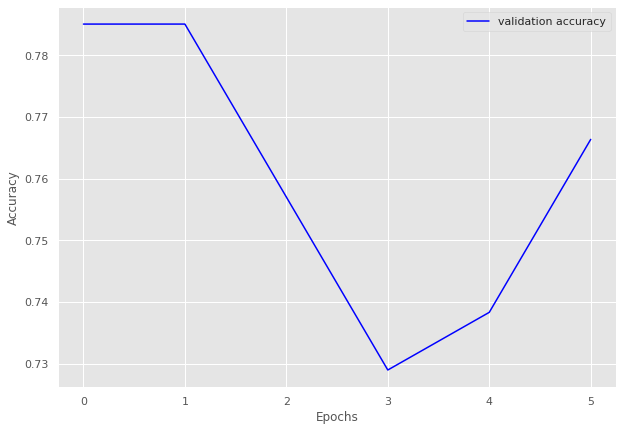

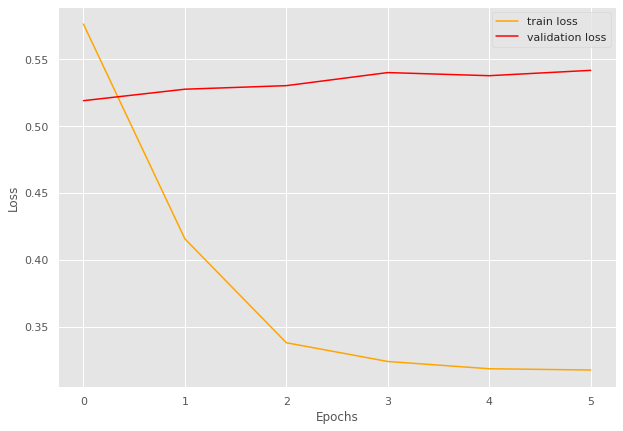

{'0': {'coarse': {'00': 0.8344144759303517, '10': 0.7350631614885627, '20': 0.6717065795249476, '30': 0.587328683607277, '50': 0.4409598595327513, '80': 0.2362093352192362}, 'fine': {'00': {'0': 0.9762140733399405, '1': 0.9764150943396226, '2': 0.9572277227722772, '3': 0.973404255319149, '4': 0.99644128113879, '5': 0.9815242494226328, '7': 0.9389619883040936, '8': 0.9871175523349437, '9': 0.8673469387755102, '11': 0.9451642060861706, '12': 0.9523012552301255, '14': 0.9555808656036446, '15': 0.9640077821011673}, '10': {'0': 0.8848780487804878, '1': 0.8422535211267606, '2': 0.8879103282626101, '3': 0.9231638418079096, '4': 0.9256505576208178, '5': 0.906885758998435, '7': 0.8858381502890174, '8': 0.9591503267973857, '9': 0.7749469214437368, '11': 0.8723911747167561, '12': 0.9203319502074688, '14': 0.8818380743982495, '15': 0.8033088235294118}, '20': {'0': 0.8442064264849075, '1': 0.7038567493112947, '2': 0.8205027494108406, '3': 0.8527889591719379, '4': 0.8386075949367089, '5': 0.80940794

100%|██████████| 26/26 [00:19<00:00,  1.31batch/s, loss=0.955]


train loss 0.9545318232132838, validation loss 1.0090868175029755, validation accuracy 0.46875
Coarse label 19 Epoch 2
-------------------------------


100%|██████████| 26/26 [00:19<00:00,  1.33batch/s, loss=0.763]


INFO: Early stopping counter 1 of 5
train loss 0.762661642753161, validation loss 1.0357232093811035, validation accuracy 0.4479166666666667
Coarse label 19 Epoch 3
-------------------------------


100%|██████████| 26/26 [00:21<00:00,  1.22batch/s, loss=0.656]


train loss 0.6564691616938665, validation loss 0.9596004784107208, validation accuracy 0.59375
Coarse label 19 Epoch 4
-------------------------------


100%|██████████| 26/26 [00:20<00:00,  1.26batch/s, loss=0.616]


INFO: Early stopping counter 2 of 5
train loss 0.6164730787277222, validation loss 1.012553334236145, validation accuracy 0.5208333333333334
Coarse label 19 Epoch 5
-------------------------------


100%|██████████| 26/26 [00:16<00:00,  1.57batch/s, loss=0.599]


INFO: Early stopping counter 3 of 5
train loss 0.5994211572867173, validation loss 1.07277113199234, validation accuracy 0.4479166666666667
Coarse label 19 Epoch 6
-------------------------------


100%|██████████| 26/26 [00:09<00:00,  2.87batch/s, loss=0.589]


INFO: Early stopping counter 4 of 5
train loss 0.5893880128860474, validation loss 1.0451873540878296, validation accuracy 0.4791666666666667
Coarse label 19 Epoch 7
-------------------------------


100%|██████████| 26/26 [00:09<00:00,  2.84batch/s, loss=0.581]


INFO: Early stopping counter 5 of 5
INFO: Early stopping
Done! Saved model with test accuracy 0.5684523809523809 and loss 0.9822398126125336


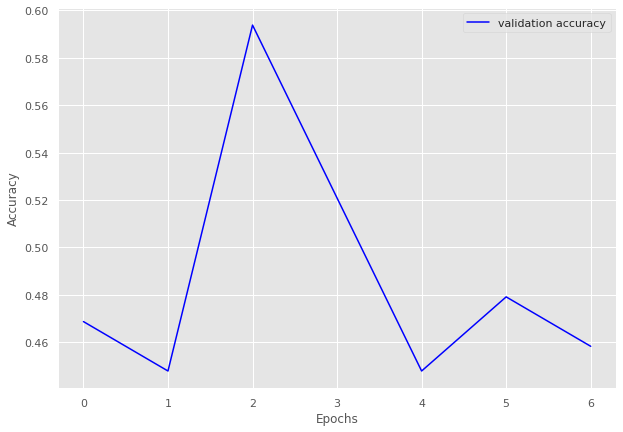

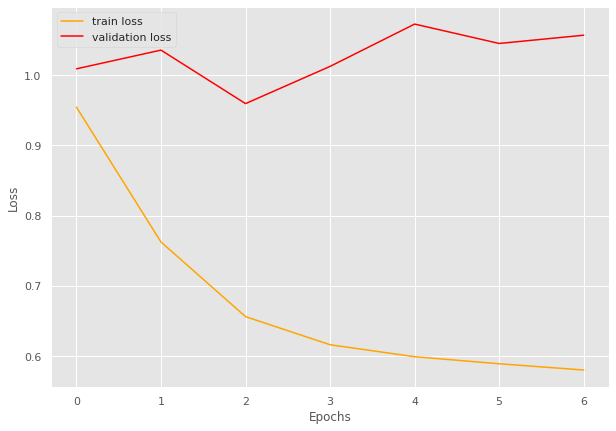

{'0': {'coarse': {'00': 0.8344144759303517, '10': 0.7350631614885627, '20': 0.6717065795249476, '30': 0.587328683607277, '50': 0.4409598595327513, '80': 0.2362093352192362}, 'fine': {'00': {'0': 0.9762140733399405, '1': 0.9764150943396226, '2': 0.9572277227722772, '3': 0.973404255319149, '4': 0.99644128113879, '5': 0.9815242494226328, '7': 0.9389619883040936, '8': 0.9871175523349437, '9': 0.8673469387755102, '11': 0.9451642060861706, '12': 0.9523012552301255, '14': 0.9555808656036446, '15': 0.9640077821011673}, '10': {'0': 0.8848780487804878, '1': 0.8422535211267606, '2': 0.8879103282626101, '3': 0.9231638418079096, '4': 0.9256505576208178, '5': 0.906885758998435, '7': 0.8858381502890174, '8': 0.9591503267973857, '9': 0.7749469214437368, '11': 0.8723911747167561, '12': 0.9203319502074688, '14': 0.8818380743982495, '15': 0.8033088235294118}, '20': {'0': 0.8442064264849075, '1': 0.7038567493112947, '2': 0.8205027494108406, '3': 0.8527889591719379, '4': 0.8386075949367089, '5': 0.80940794

Calculating for label_noise 50
split_50_1
Start training a coarse model
Epoch 1
-------------------------------


100%|██████████| 1641/1641 [11:47<00:00,  2.32batch/s, loss=2.74]


train loss 2.743694246287465, validation loss 2.7006468606161906, validation accuracy 0.37574094401756314
Epoch 2
-------------------------------


100%|██████████| 1641/1641 [09:52<00:00,  2.77batch/s, loss=2.68]


train loss 2.6816213751333215, validation loss 2.6840720826929267, validation accuracy 0.39330406147091107
Epoch 3
-------------------------------


100%|██████████| 1641/1641 [09:52<00:00,  2.77batch/s, loss=2.66]


train loss 2.661882033223135, validation loss 2.6598041874545437, validation accuracy 0.416794731064764
Epoch 4
-------------------------------


100%|██████████| 1641/1641 [11:40<00:00,  2.34batch/s, loss=2.65]


train loss 2.6491853112785066, validation loss 2.65787608473451, validation accuracy 0.4194291986827662
Epoch 5
-------------------------------


100%|██████████| 1641/1641 [09:56<00:00,  2.75batch/s, loss=2.64]


train loss 2.640282490862208, validation loss 2.6520986873786767, validation accuracy 0.424807903402854
Epoch 6
-------------------------------


100%|██████████| 1641/1641 [09:53<00:00,  2.77batch/s, loss=2.63]


train loss 2.631246547884944, validation loss 2.6408620247474084, validation accuracy 0.4358946212952799
Epoch 7
-------------------------------


100%|██████████| 1641/1641 [11:24<00:00,  2.40batch/s, loss=2.62]


train loss 2.622367508595924, validation loss 2.640371466016436, validation accuracy 0.43688254665203075
Epoch 8
-------------------------------


100%|██████████| 1641/1641 [09:54<00:00,  2.76batch/s, loss=2.62]


train loss 2.621161353653484, validation loss 2.637680662261856, validation accuracy 0.4392974753018661
Epoch 9
-------------------------------


100%|██████████| 1641/1641 [11:43<00:00,  2.33batch/s, loss=2.62]


train loss 2.6152567198042607, validation loss 2.6352150240144527, validation accuracy 0.44193194291986826
Epoch 10
-------------------------------


100%|██████████| 1641/1641 [09:51<00:00,  2.77batch/s, loss=2.61]


train loss 2.6111123837907457, validation loss 2.6314835181603065, validation accuracy 0.44588364434687155
Epoch 11
-------------------------------


100%|██████████| 1641/1641 [09:55<00:00,  2.75batch/s, loss=2.61]


INFO: Early stopping counter 1 of 5
train loss 2.6069982019885876, validation loss 2.6424698329472043, validation accuracy 0.43512623490669594
Epoch 12
-------------------------------


100%|██████████| 1641/1641 [11:46<00:00,  2.32batch/s, loss=2.6] 


INFO: Early stopping counter 2 of 5
train loss 2.60489061676388, validation loss 2.6333977909354895, validation accuracy 0.4433589462129528
Epoch 13
-------------------------------


100%|██████████| 1641/1641 [09:53<00:00,  2.76batch/s, loss=2.6]


INFO: Early stopping counter 3 of 5
train loss 2.6014589253610985, validation loss 2.634132083479341, validation accuracy 0.44270032930845227
Epoch 14
-------------------------------


100%|██████████| 1641/1641 [09:54<00:00,  2.76batch/s, loss=2.6]


INFO: Early stopping counter 4 of 5
train loss 2.6008426428277054, validation loss 2.6323762323472883, validation accuracy 0.4442371020856202
Epoch 15
-------------------------------


100%|██████████| 1641/1641 [11:47<00:00,  2.32batch/s, loss=2.6] 


INFO: Early stopping counter 5 of 5
INFO: Early stopping
Done! Saved model with test accuracy 0.45403111739745405 and loss 2.623738115821672


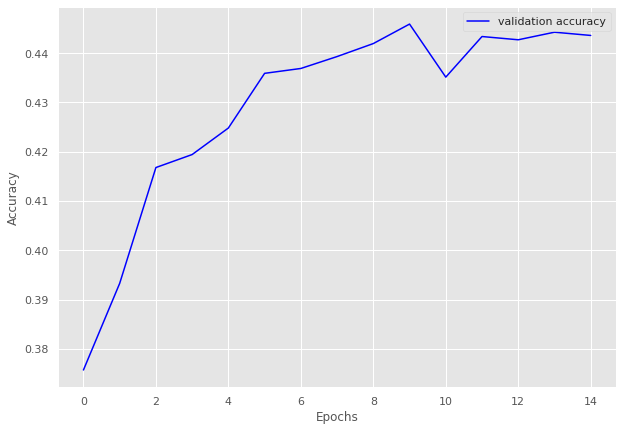

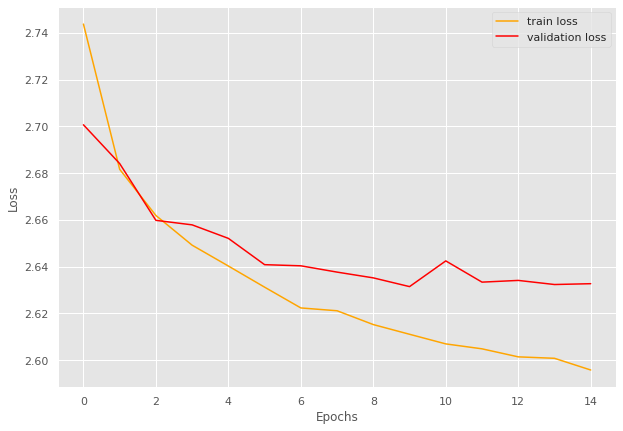

{'0': {'coarse': {'00': 0.8344144759303517, '10': 0.7350631614885627, '20': 0.6717065795249476, '30': 0.587328683607277, '50': 0.4409598595327513, '80': 0.2362093352192362}, 'fine': {'00': {'0': 0.9762140733399405, '1': 0.9764150943396226, '2': 0.9572277227722772, '3': 0.973404255319149, '4': 0.99644128113879, '5': 0.9815242494226328, '7': 0.9389619883040936, '8': 0.9871175523349437, '9': 0.8673469387755102, '11': 0.9451642060861706, '12': 0.9523012552301255, '14': 0.9555808656036446, '15': 0.9640077821011673}, '10': {'0': 0.8848780487804878, '1': 0.8422535211267606, '2': 0.8879103282626101, '3': 0.9231638418079096, '4': 0.9256505576208178, '5': 0.906885758998435, '7': 0.8858381502890174, '8': 0.9591503267973857, '9': 0.7749469214437368, '11': 0.8723911747167561, '12': 0.9203319502074688, '14': 0.8818380743982495, '15': 0.8033088235294118}, '20': {'0': 0.8442064264849075, '1': 0.7038567493112947, '2': 0.8205027494108406, '3': 0.8527889591719379, '4': 0.8386075949367089, '5': 0.80940794

100%|██████████| 91/91 [00:32<00:00,  2.80batch/s, loss=1.33]


train loss 1.3308938021188255, validation loss 1.2409475803375245, validation accuracy 0.655
Coarse label 0 Epoch 2
-------------------------------


100%|██████████| 91/91 [00:32<00:00,  2.80batch/s, loss=1.22]


INFO: Early stopping counter 1 of 5
train loss 1.2220642632180518, validation loss 1.259306502342224, validation accuracy 0.6383333333333333
Coarse label 0 Epoch 3
-------------------------------


100%|██████████| 91/91 [00:33<00:00,  2.74batch/s, loss=1.18]


INFO: Early stopping counter 2 of 5
train loss 1.1757766283475435, validation loss 1.2519639015197754, validation accuracy 0.65
Coarse label 0 Epoch 4
-------------------------------


100%|██████████| 91/91 [00:32<00:00,  2.77batch/s, loss=1.14]


INFO: Early stopping counter 3 of 5
train loss 1.1413714872611749, validation loss 1.2468970537185669, validation accuracy 0.655
Coarse label 0 Epoch 5
-------------------------------


100%|██████████| 91/91 [00:32<00:00,  2.79batch/s, loss=1.12]


train loss 1.1186225427376044, validation loss 1.2322183966636657, validation accuracy 0.6633333333333333
Coarse label 0 Epoch 6
-------------------------------


100%|██████████| 91/91 [00:32<00:00,  2.77batch/s, loss=1.1] 


INFO: Early stopping counter 4 of 5
train loss 1.1015717144850845, validation loss 1.2467493295669556, validation accuracy 0.6533333333333333
Coarse label 0 Epoch 7
-------------------------------


100%|██████████| 91/91 [00:32<00:00,  2.78batch/s, loss=1.08]


INFO: Early stopping counter 5 of 5
INFO: Early stopping
Done! Saved model with test accuracy 0.6115992970123023 and loss 1.2892958886093564


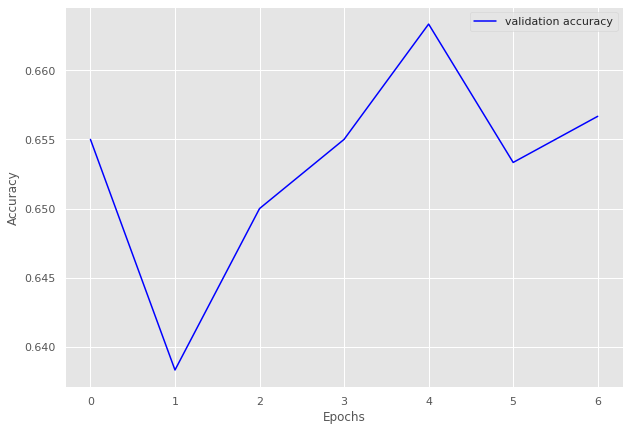

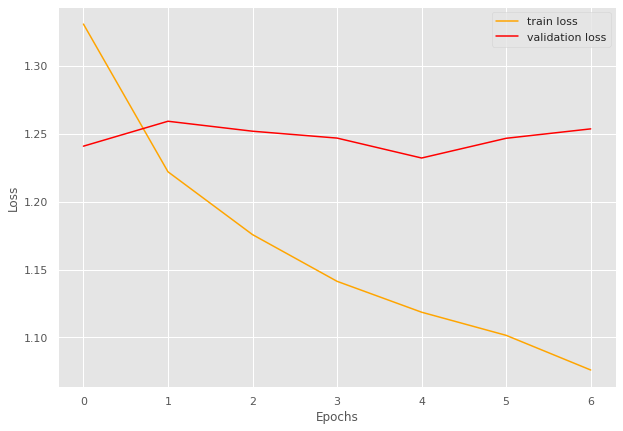

{'0': {'coarse': {'00': 0.8344144759303517, '10': 0.7350631614885627, '20': 0.6717065795249476, '30': 0.587328683607277, '50': 0.4409598595327513, '80': 0.2362093352192362}, 'fine': {'00': {'0': 0.9762140733399405, '1': 0.9764150943396226, '2': 0.9572277227722772, '3': 0.973404255319149, '4': 0.99644128113879, '5': 0.9815242494226328, '7': 0.9389619883040936, '8': 0.9871175523349437, '9': 0.8673469387755102, '11': 0.9451642060861706, '12': 0.9523012552301255, '14': 0.9555808656036446, '15': 0.9640077821011673}, '10': {'0': 0.8848780487804878, '1': 0.8422535211267606, '2': 0.8879103282626101, '3': 0.9231638418079096, '4': 0.9256505576208178, '5': 0.906885758998435, '7': 0.8858381502890174, '8': 0.9591503267973857, '9': 0.7749469214437368, '11': 0.8723911747167561, '12': 0.9203319502074688, '14': 0.8818380743982495, '15': 0.8033088235294118}, '20': {'0': 0.8442064264849075, '1': 0.7038567493112947, '2': 0.8205027494108406, '3': 0.8527889591719379, '4': 0.8386075949367089, '5': 0.80940794

100%|██████████| 63/63 [00:22<00:00,  2.75batch/s, loss=0.847]


train loss 0.8471255207818652, validation loss 0.9331323951482773, validation accuracy 0.5857142857142857
Coarse label 1 Epoch 2
-------------------------------


100%|██████████| 63/63 [00:22<00:00,  2.78batch/s, loss=0.748]


train loss 0.7480350061068459, validation loss 0.9310608357191086, validation accuracy 0.6
Coarse label 1 Epoch 3
-------------------------------


100%|██████████| 63/63 [00:22<00:00,  2.80batch/s, loss=0.693]


INFO: Early stopping counter 1 of 5
train loss 0.6927611080427019, validation loss 0.9493523240089417, validation accuracy 0.5761904761904761
Coarse label 1 Epoch 4
-------------------------------


100%|██████████| 63/63 [00:22<00:00,  2.80batch/s, loss=0.673]


train loss 0.6725684697665866, validation loss 0.9304483234882355, validation accuracy 0.5666666666666667
Coarse label 1 Epoch 5
-------------------------------


100%|██████████| 63/63 [00:22<00:00,  2.77batch/s, loss=0.655]


INFO: Early stopping counter 2 of 5
train loss 0.654650698578547, validation loss 0.9670740813016891, validation accuracy 0.5714285714285714
Coarse label 1 Epoch 6
-------------------------------


100%|██████████| 63/63 [00:22<00:00,  2.78batch/s, loss=0.645]


INFO: Early stopping counter 3 of 5
train loss 0.6451897081874666, validation loss 0.9350419789552689, validation accuracy 0.5714285714285714
Coarse label 1 Epoch 7
-------------------------------


100%|██████████| 63/63 [00:22<00:00,  2.80batch/s, loss=0.637]


INFO: Early stopping counter 4 of 5
train loss 0.6368142215032426, validation loss 0.9695032387971878, validation accuracy 0.5666666666666667
Coarse label 1 Epoch 8
-------------------------------


100%|██████████| 63/63 [00:24<00:00,  2.60batch/s, loss=0.627]


INFO: Early stopping counter 5 of 5
INFO: Early stopping
Done! Saved model with test accuracy 0.7276214833759591 and loss 0.827567288508782


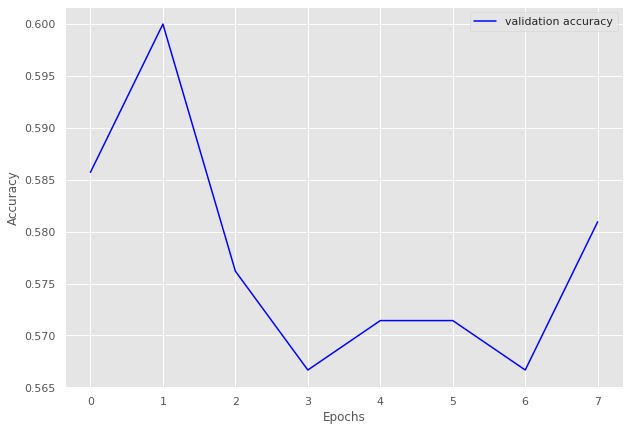

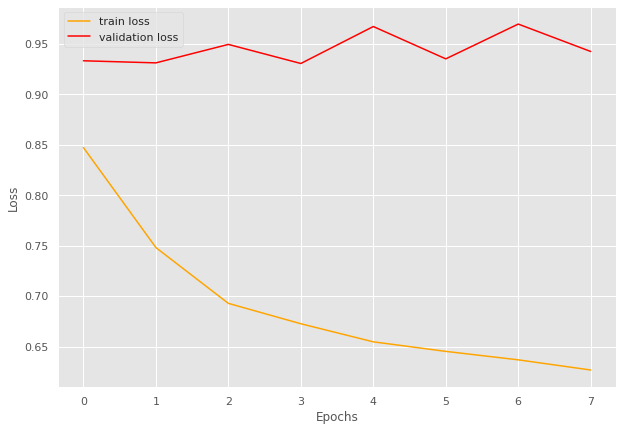

{'0': {'coarse': {'00': 0.8344144759303517, '10': 0.7350631614885627, '20': 0.6717065795249476, '30': 0.587328683607277, '50': 0.4409598595327513, '80': 0.2362093352192362}, 'fine': {'00': {'0': 0.9762140733399405, '1': 0.9764150943396226, '2': 0.9572277227722772, '3': 0.973404255319149, '4': 0.99644128113879, '5': 0.9815242494226328, '7': 0.9389619883040936, '8': 0.9871175523349437, '9': 0.8673469387755102, '11': 0.9451642060861706, '12': 0.9523012552301255, '14': 0.9555808656036446, '15': 0.9640077821011673}, '10': {'0': 0.8848780487804878, '1': 0.8422535211267606, '2': 0.8879103282626101, '3': 0.9231638418079096, '4': 0.9256505576208178, '5': 0.906885758998435, '7': 0.8858381502890174, '8': 0.9591503267973857, '9': 0.7749469214437368, '11': 0.8723911747167561, '12': 0.9203319502074688, '14': 0.8818380743982495, '15': 0.8033088235294118}, '20': {'0': 0.8442064264849075, '1': 0.7038567493112947, '2': 0.8205027494108406, '3': 0.8527889591719379, '4': 0.8386075949367089, '5': 0.80940794

100%|██████████| 200/200 [01:12<00:00,  2.75batch/s, loss=2.09]


train loss 2.093091291189194, validation loss 2.0162841545210943, validation accuracy 0.515527950310559
Coarse label 2 Epoch 2
-------------------------------


100%|██████████| 200/200 [01:11<00:00,  2.78batch/s, loss=2]   


train loss 2.003913679718971, validation loss 2.004355311393738, validation accuracy 0.5297249334516415
Coarse label 2 Epoch 3
-------------------------------


100%|██████████| 200/200 [01:12<00:00,  2.77batch/s, loss=1.98]


INFO: Early stopping counter 1 of 5
train loss 1.9786213767528533, validation loss 2.0122421185175576, validation accuracy 0.5279503105590062
Coarse label 2 Epoch 4
-------------------------------


100%|██████████| 200/200 [01:11<00:00,  2.78batch/s, loss=1.96]


INFO: Early stopping counter 2 of 5
train loss 1.9596586924791337, validation loss 2.004683276017507, validation accuracy 0.5332741792369121
Coarse label 2 Epoch 5
-------------------------------


100%|██████████| 200/200 [01:12<00:00,  2.76batch/s, loss=1.94]


train loss 1.9404004830121995, validation loss 1.9908811648686726, validation accuracy 0.5474711623779946
Coarse label 2 Epoch 6
-------------------------------


100%|██████████| 200/200 [01:51<00:00,  1.80batch/s, loss=1.92]


INFO: Early stopping counter 3 of 5
train loss 1.9236548417806625, validation loss 1.9940875503751967, validation accuracy 0.543921916592724
Coarse label 2 Epoch 7
-------------------------------


100%|██████████| 200/200 [02:21<00:00,  1.42batch/s, loss=1.91]


INFO: Early stopping counter 4 of 5
train loss 1.9144094514846801, validation loss 2.007816261715359, validation accuracy 0.5297249334516415
Coarse label 2 Epoch 8
-------------------------------


100%|██████████| 200/200 [01:12<00:00,  2.76batch/s, loss=1.9] 


INFO: Early stopping counter 5 of 5
INFO: Early stopping
Done! Saved model with test accuracy 0.5313773431132844 and loss 2.013149435703571


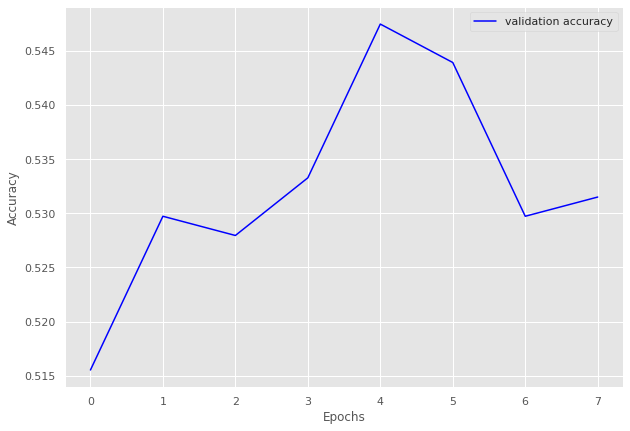

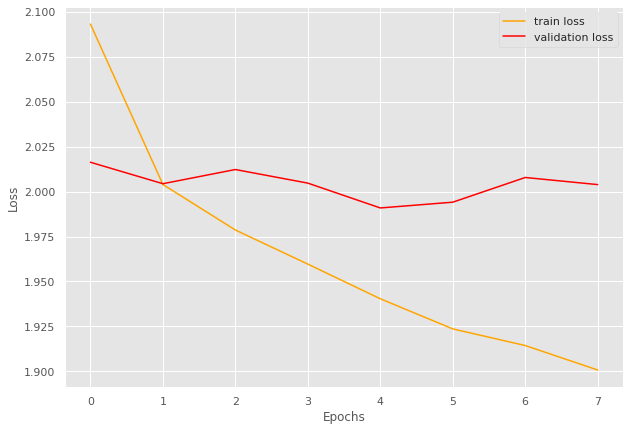

{'0': {'coarse': {'00': 0.8344144759303517, '10': 0.7350631614885627, '20': 0.6717065795249476, '30': 0.587328683607277, '50': 0.4409598595327513, '80': 0.2362093352192362}, 'fine': {'00': {'0': 0.9762140733399405, '1': 0.9764150943396226, '2': 0.9572277227722772, '3': 0.973404255319149, '4': 0.99644128113879, '5': 0.9815242494226328, '7': 0.9389619883040936, '8': 0.9871175523349437, '9': 0.8673469387755102, '11': 0.9451642060861706, '12': 0.9523012552301255, '14': 0.9555808656036446, '15': 0.9640077821011673}, '10': {'0': 0.8848780487804878, '1': 0.8422535211267606, '2': 0.8879103282626101, '3': 0.9231638418079096, '4': 0.9256505576208178, '5': 0.906885758998435, '7': 0.8858381502890174, '8': 0.9591503267973857, '9': 0.7749469214437368, '11': 0.8723911747167561, '12': 0.9203319502074688, '14': 0.8818380743982495, '15': 0.8033088235294118}, '20': {'0': 0.8442064264849075, '1': 0.7038567493112947, '2': 0.8205027494108406, '3': 0.8527889591719379, '4': 0.8386075949367089, '5': 0.80940794

100%|██████████| 140/140 [00:50<00:00,  2.75batch/s, loss=1.78]


train loss 1.7769178305353437, validation loss 1.6924188137054443, validation accuracy 0.5754824063564131
Coarse label 4 Epoch 2
-------------------------------


100%|██████████| 140/140 [00:50<00:00,  2.78batch/s, loss=1.68]


train loss 1.6815632462501526, validation loss 1.6788147262164526, validation accuracy 0.5856980703745743
Coarse label 4 Epoch 3
-------------------------------


100%|██████████| 140/140 [00:50<00:00,  2.78batch/s, loss=1.64]


train loss 1.638619382892336, validation loss 1.67814929996218, validation accuracy 0.5913734392735528
Coarse label 4 Epoch 4
-------------------------------


100%|██████████| 140/140 [00:50<00:00,  2.77batch/s, loss=1.61]


INFO: Early stopping counter 1 of 5
train loss 1.6127784814153399, validation loss 1.695089612688337, validation accuracy 0.5720771850170261
Coarse label 4 Epoch 5
-------------------------------


100%|██████████| 140/140 [00:50<00:00,  2.77batch/s, loss=1.59]


INFO: Early stopping counter 2 of 5
train loss 1.589555287361145, validation loss 1.6825909444264002, validation accuracy 0.5800227014755959
Coarse label 4 Epoch 6
-------------------------------


100%|██████████| 140/140 [00:50<00:00,  2.80batch/s, loss=1.57]


INFO: Early stopping counter 3 of 5
train loss 1.5698867746761866, validation loss 1.6830989377839225, validation accuracy 0.5845629965947786
Coarse label 4 Epoch 7
-------------------------------


100%|██████████| 140/140 [00:50<00:00,  2.77batch/s, loss=1.55]


train loss 1.55469309091568, validation loss 1.6746843457221985, validation accuracy 0.5902383654937571
Coarse label 4 Epoch 8
-------------------------------


100%|██████████| 140/140 [00:50<00:00,  2.75batch/s, loss=1.54]


INFO: Early stopping counter 4 of 5
train loss 1.5427062145301274, validation loss 1.6851116503987993, validation accuracy 0.5777525539160046
Coarse label 4 Epoch 9
-------------------------------


100%|██████████| 140/140 [00:50<00:00,  2.79batch/s, loss=1.53]


INFO: Early stopping counter 5 of 5
INFO: Early stopping
Done! Saved model with test accuracy 0.5708727070594775 and loss 1.708977592402491


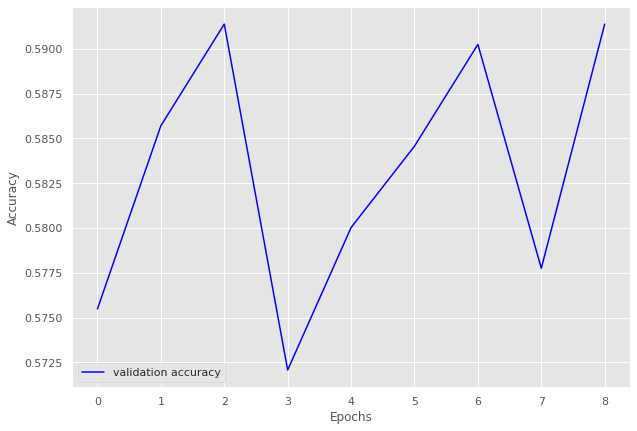

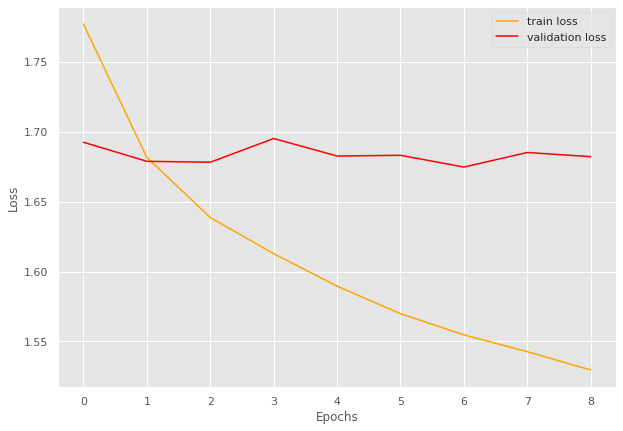

{'0': {'coarse': {'00': 0.8344144759303517, '10': 0.7350631614885627, '20': 0.6717065795249476, '30': 0.587328683607277, '50': 0.4409598595327513, '80': 0.2362093352192362}, 'fine': {'00': {'0': 0.9762140733399405, '1': 0.9764150943396226, '2': 0.9572277227722772, '3': 0.973404255319149, '4': 0.99644128113879, '5': 0.9815242494226328, '7': 0.9389619883040936, '8': 0.9871175523349437, '9': 0.8673469387755102, '11': 0.9451642060861706, '12': 0.9523012552301255, '14': 0.9555808656036446, '15': 0.9640077821011673}, '10': {'0': 0.8848780487804878, '1': 0.8422535211267606, '2': 0.8879103282626101, '3': 0.9231638418079096, '4': 0.9256505576208178, '5': 0.906885758998435, '7': 0.8858381502890174, '8': 0.9591503267973857, '9': 0.7749469214437368, '11': 0.8723911747167561, '12': 0.9203319502074688, '14': 0.8818380743982495, '15': 0.8033088235294118}, '20': {'0': 0.8442064264849075, '1': 0.7038567493112947, '2': 0.8205027494108406, '3': 0.8527889591719379, '4': 0.8386075949367089, '5': 0.80940794

100%|██████████| 123/123 [00:43<00:00,  2.80batch/s, loss=1.83]


train loss 1.825555479623438, validation loss 1.7937801642851396, validation accuracy 0.4763358778625954
Coarse label 5 Epoch 2
-------------------------------


100%|██████████| 123/123 [00:44<00:00,  2.77batch/s, loss=1.74]


INFO: Early stopping counter 1 of 5
train loss 1.7367448041109534, validation loss 1.8034043095328591, validation accuracy 0.4580152671755725
Coarse label 5 Epoch 3
-------------------------------


100%|██████████| 123/123 [00:44<00:00,  2.79batch/s, loss=1.69]


INFO: Early stopping counter 2 of 5
train loss 1.6864803777477606, validation loss 1.7979128144004128, validation accuracy 0.4732824427480916
Coarse label 5 Epoch 4
-------------------------------


100%|██████████| 123/123 [00:44<00:00,  2.79batch/s, loss=1.65]


INFO: Early stopping counter 3 of 5
train loss 1.6528300182606146, validation loss 1.7997809106653386, validation accuracy 0.467175572519084
Coarse label 5 Epoch 5
-------------------------------


100%|██████████| 123/123 [00:44<00:00,  2.74batch/s, loss=1.62]


INFO: Early stopping counter 4 of 5
train loss 1.6218365014083986, validation loss 1.8006125146692449, validation accuracy 0.4687022900763359
Coarse label 5 Epoch 6
-------------------------------


100%|██████████| 123/123 [00:43<00:00,  2.82batch/s, loss=1.59]


INFO: Early stopping counter 5 of 5
INFO: Early stopping
Done! Saved model with test accuracy 0.48881789137380194 and loss 1.7753526830673219


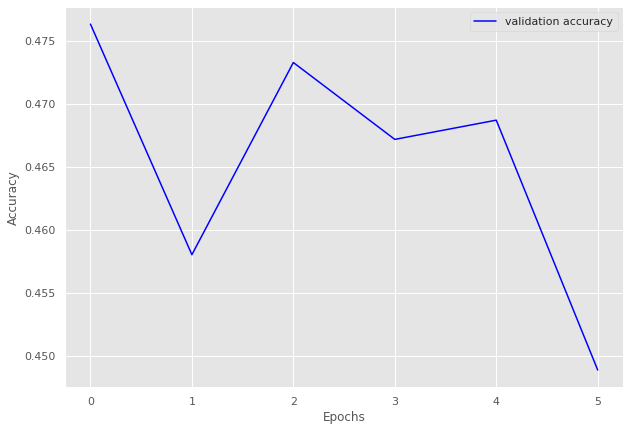

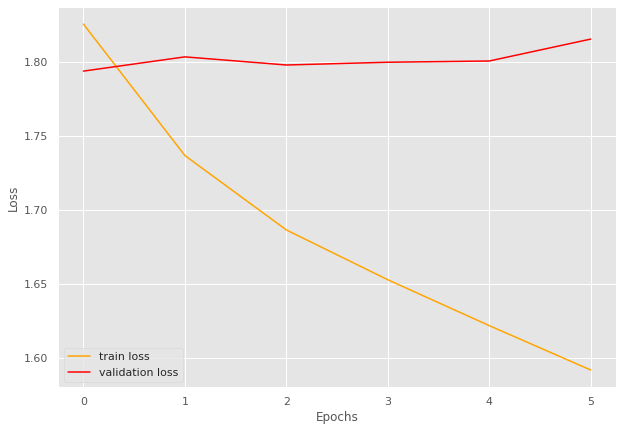

{'0': {'coarse': {'00': 0.8344144759303517, '10': 0.7350631614885627, '20': 0.6717065795249476, '30': 0.587328683607277, '50': 0.4409598595327513, '80': 0.2362093352192362}, 'fine': {'00': {'0': 0.9762140733399405, '1': 0.9764150943396226, '2': 0.9572277227722772, '3': 0.973404255319149, '4': 0.99644128113879, '5': 0.9815242494226328, '7': 0.9389619883040936, '8': 0.9871175523349437, '9': 0.8673469387755102, '11': 0.9451642060861706, '12': 0.9523012552301255, '14': 0.9555808656036446, '15': 0.9640077821011673}, '10': {'0': 0.8848780487804878, '1': 0.8422535211267606, '2': 0.8879103282626101, '3': 0.9231638418079096, '4': 0.9256505576208178, '5': 0.906885758998435, '7': 0.8858381502890174, '8': 0.9591503267973857, '9': 0.7749469214437368, '11': 0.8723911747167561, '12': 0.9203319502074688, '14': 0.8818380743982495, '15': 0.8033088235294118}, '20': {'0': 0.8442064264849075, '1': 0.7038567493112947, '2': 0.8205027494108406, '3': 0.8527889591719379, '4': 0.8386075949367089, '5': 0.80940794

100%|██████████| 29/29 [00:09<00:00,  2.91batch/s, loss=0.603]


train loss 0.6033309965298094, validation loss 0.5832551121711731, validation accuracy 0.6941176470588235
Coarse label 6 Epoch 2
-------------------------------


100%|██████████| 29/29 [00:09<00:00,  2.92batch/s, loss=0.445]


INFO: Early stopping counter 1 of 5
train loss 0.44491115006907234, validation loss 0.6149746775627136, validation accuracy 0.6882352941176471
Coarse label 6 Epoch 3
-------------------------------


100%|██████████| 29/29 [00:10<00:00,  2.87batch/s, loss=0.364]


INFO: Early stopping counter 2 of 5
train loss 0.36447100187170095, validation loss 0.6112431486447653, validation accuracy 0.6764705882352942
Coarse label 6 Epoch 4
-------------------------------


100%|██████████| 29/29 [00:10<00:00,  2.81batch/s, loss=0.35] 


INFO: Early stopping counter 3 of 5
train loss 0.3500014255786764, validation loss 0.6321028470993042, validation accuracy 0.6470588235294118
Coarse label 6 Epoch 5
-------------------------------


100%|██████████| 29/29 [00:10<00:00,  2.90batch/s, loss=0.338]


INFO: Early stopping counter 4 of 5
train loss 0.33830853680084494, validation loss 0.6342598994572958, validation accuracy 0.6647058823529411
Coarse label 6 Epoch 6
-------------------------------


100%|██████████| 29/29 [00:10<00:00,  2.86batch/s, loss=0.34] 


INFO: Early stopping counter 5 of 5
INFO: Early stopping
Done! Saved model with test accuracy 0.6987012987012987 and loss 0.5483417127813611


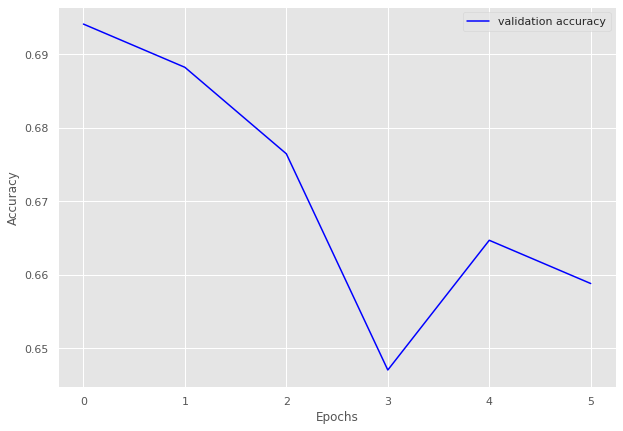

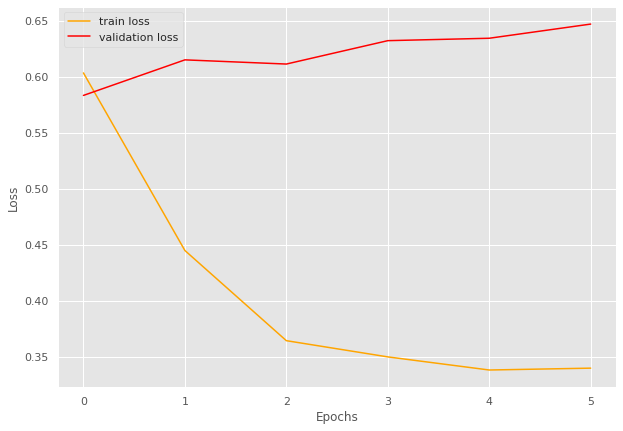

{'0': {'coarse': {'00': 0.8344144759303517, '10': 0.7350631614885627, '20': 0.6717065795249476, '30': 0.587328683607277, '50': 0.4409598595327513, '80': 0.2362093352192362}, 'fine': {'00': {'0': 0.9762140733399405, '1': 0.9764150943396226, '2': 0.9572277227722772, '3': 0.973404255319149, '4': 0.99644128113879, '5': 0.9815242494226328, '7': 0.9389619883040936, '8': 0.9871175523349437, '9': 0.8673469387755102, '11': 0.9451642060861706, '12': 0.9523012552301255, '14': 0.9555808656036446, '15': 0.9640077821011673}, '10': {'0': 0.8848780487804878, '1': 0.8422535211267606, '2': 0.8879103282626101, '3': 0.9231638418079096, '4': 0.9256505576208178, '5': 0.906885758998435, '7': 0.8858381502890174, '8': 0.9591503267973857, '9': 0.7749469214437368, '11': 0.8723911747167561, '12': 0.9203319502074688, '14': 0.8818380743982495, '15': 0.8033088235294118}, '20': {'0': 0.8442064264849075, '1': 0.7038567493112947, '2': 0.8205027494108406, '3': 0.8527889591719379, '4': 0.8386075949367089, '5': 0.80940794

100%|██████████| 70/70 [00:25<00:00,  2.78batch/s, loss=1.14]


train loss 1.1360459753445216, validation loss 1.1106969118118286, validation accuracy 0.6461538461538462
Coarse label 7 Epoch 2
-------------------------------


100%|██████████| 70/70 [00:25<00:00,  2.77batch/s, loss=1.02]


train loss 1.0242289074829647, validation loss 1.1093044366155351, validation accuracy 0.6435897435897436
Coarse label 7 Epoch 3
-------------------------------


100%|██████████| 70/70 [00:25<00:00,  2.71batch/s, loss=0.945]


INFO: Early stopping counter 1 of 5
train loss 0.94490310890334, validation loss 1.1379646403448922, validation accuracy 0.6333333333333333
Coarse label 7 Epoch 4
-------------------------------


100%|██████████| 70/70 [00:25<00:00,  2.76batch/s, loss=0.908]


INFO: Early stopping counter 2 of 5
train loss 0.9083093481404441, validation loss 1.1321523700441634, validation accuracy 0.6230769230769231
Coarse label 7 Epoch 5
-------------------------------


100%|██████████| 70/70 [00:25<00:00,  2.76batch/s, loss=0.889]


INFO: Early stopping counter 3 of 5
train loss 0.8892884595053536, validation loss 1.1394936442375183, validation accuracy 0.6282051282051282
Coarse label 7 Epoch 6
-------------------------------


100%|██████████| 70/70 [00:25<00:00,  2.77batch/s, loss=0.88] 


INFO: Early stopping counter 4 of 5
train loss 0.8796511735234942, validation loss 1.152331871645791, validation accuracy 0.6307692307692307
Coarse label 7 Epoch 7
-------------------------------


100%|██████████| 70/70 [00:25<00:00,  2.79batch/s, loss=0.862]


train loss 0.8620887577533722, validation loss 1.1081812211445399, validation accuracy 0.658974358974359
Coarse label 7 Epoch 8
-------------------------------


100%|██████████| 70/70 [00:25<00:00,  2.77batch/s, loss=0.85] 


INFO: Early stopping counter 5 of 5
INFO: Early stopping
Done! Saved model with test accuracy 0.64 and loss 1.10310760140419


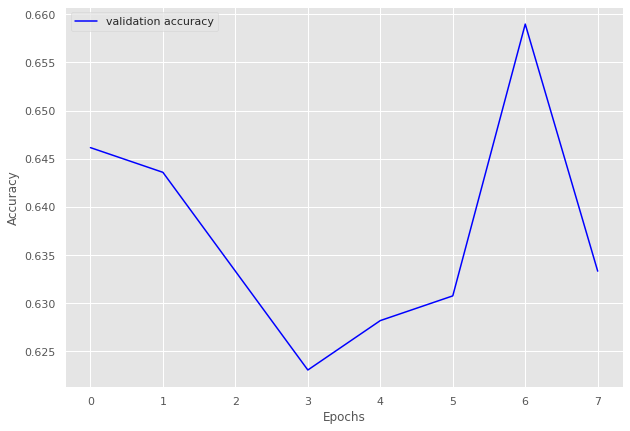

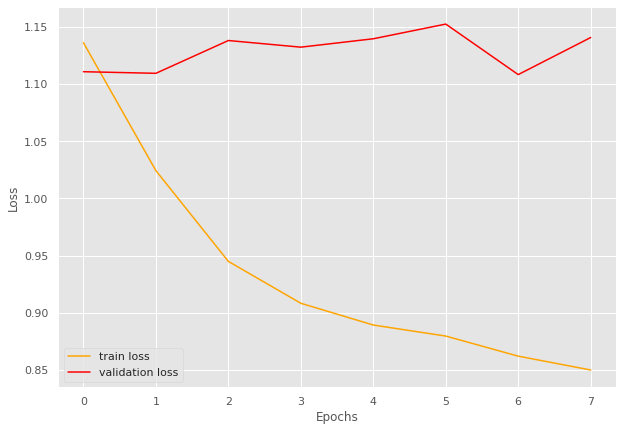

{'0': {'coarse': {'00': 0.8344144759303517, '10': 0.7350631614885627, '20': 0.6717065795249476, '30': 0.587328683607277, '50': 0.4409598595327513, '80': 0.2362093352192362}, 'fine': {'00': {'0': 0.9762140733399405, '1': 0.9764150943396226, '2': 0.9572277227722772, '3': 0.973404255319149, '4': 0.99644128113879, '5': 0.9815242494226328, '7': 0.9389619883040936, '8': 0.9871175523349437, '9': 0.8673469387755102, '11': 0.9451642060861706, '12': 0.9523012552301255, '14': 0.9555808656036446, '15': 0.9640077821011673}, '10': {'0': 0.8848780487804878, '1': 0.8422535211267606, '2': 0.8879103282626101, '3': 0.9231638418079096, '4': 0.9256505576208178, '5': 0.906885758998435, '7': 0.8858381502890174, '8': 0.9591503267973857, '9': 0.7749469214437368, '11': 0.8723911747167561, '12': 0.9203319502074688, '14': 0.8818380743982495, '15': 0.8033088235294118}, '20': {'0': 0.8442064264849075, '1': 0.7038567493112947, '2': 0.8205027494108406, '3': 0.8527889591719379, '4': 0.8386075949367089, '5': 0.80940794

100%|██████████| 95/95 [00:34<00:00,  2.76batch/s, loss=1.54]


train loss 1.5438413419221577, validation loss 1.4439232746760051, validation accuracy 0.5949820788530465
Coarse label 8 Epoch 2
-------------------------------


100%|██████████| 95/95 [00:33<00:00,  2.81batch/s, loss=1.45]


INFO: Early stopping counter 1 of 5
train loss 1.4453376657084416, validation loss 1.463955773247613, validation accuracy 0.5752688172043011
Coarse label 8 Epoch 3
-------------------------------


100%|██████████| 95/95 [00:33<00:00,  2.81batch/s, loss=1.38]


INFO: Early stopping counter 2 of 5
train loss 1.3813209646626523, validation loss 1.4757144053777058, validation accuracy 0.553763440860215
Coarse label 8 Epoch 4
-------------------------------


100%|██████████| 95/95 [00:46<00:00,  2.06batch/s, loss=1.34]


INFO: Early stopping counter 3 of 5
train loss 1.342099014081453, validation loss 1.463036020596822, validation accuracy 0.568100358422939
Coarse label 8 Epoch 5
-------------------------------


100%|██████████| 95/95 [01:12<00:00,  1.31batch/s, loss=1.31]


INFO: Early stopping counter 4 of 5
train loss 1.3081780672073364, validation loss 1.4460670948028564, validation accuracy 0.5860215053763441
Coarse label 8 Epoch 6
-------------------------------


100%|██████████| 95/95 [01:10<00:00,  1.34batch/s, loss=1.27]


train loss 1.2722783578069587, validation loss 1.4406468470891316, validation accuracy 0.5913978494623656
Coarse label 8 Epoch 7
-------------------------------


100%|██████████| 95/95 [00:49<00:00,  1.94batch/s, loss=1.26]


INFO: Early stopping counter 5 of 5
INFO: Early stopping
Done! Saved model with test accuracy 0.5205479452054794 and loss 1.527248828034652


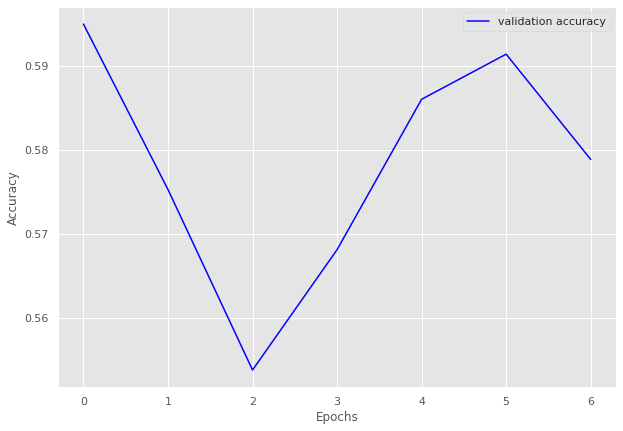

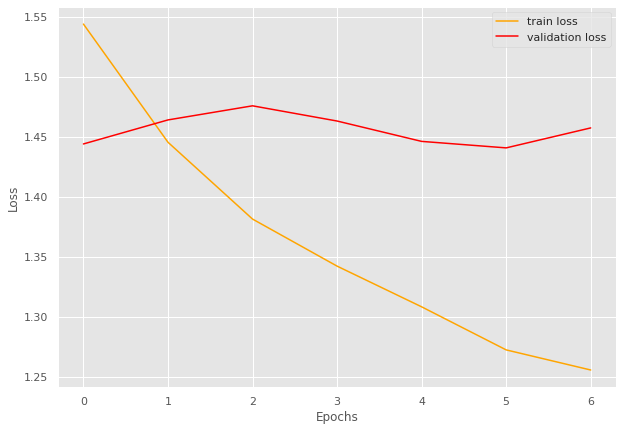

{'0': {'coarse': {'00': 0.8344144759303517, '10': 0.7350631614885627, '20': 0.6717065795249476, '30': 0.587328683607277, '50': 0.4409598595327513, '80': 0.2362093352192362}, 'fine': {'00': {'0': 0.9762140733399405, '1': 0.9764150943396226, '2': 0.9572277227722772, '3': 0.973404255319149, '4': 0.99644128113879, '5': 0.9815242494226328, '7': 0.9389619883040936, '8': 0.9871175523349437, '9': 0.8673469387755102, '11': 0.9451642060861706, '12': 0.9523012552301255, '14': 0.9555808656036446, '15': 0.9640077821011673}, '10': {'0': 0.8848780487804878, '1': 0.8422535211267606, '2': 0.8879103282626101, '3': 0.9231638418079096, '4': 0.9256505576208178, '5': 0.906885758998435, '7': 0.8858381502890174, '8': 0.9591503267973857, '9': 0.7749469214437368, '11': 0.8723911747167561, '12': 0.9203319502074688, '14': 0.8818380743982495, '15': 0.8033088235294118}, '20': {'0': 0.8442064264849075, '1': 0.7038567493112947, '2': 0.8205027494108406, '3': 0.8527889591719379, '4': 0.8386075949367089, '5': 0.80940794

100%|██████████| 111/111 [00:39<00:00,  2.78batch/s, loss=1.48]


train loss 1.4831573082520082, validation loss 1.4782882809638977, validation accuracy 0.542314335060449
Coarse label 9 Epoch 2
-------------------------------


100%|██████████| 111/111 [00:39<00:00,  2.80batch/s, loss=1.38]


train loss 1.3801184484550544, validation loss 1.4726213812828064, validation accuracy 0.533678756476684
Coarse label 9 Epoch 3
-------------------------------


100%|██████████| 111/111 [00:39<00:00,  2.80batch/s, loss=1.34]


INFO: Early stopping counter 1 of 5
train loss 1.3398859189437315, validation loss 1.4826337695121765, validation accuracy 0.5544041450777202
Coarse label 9 Epoch 4
-------------------------------


100%|██████████| 111/111 [00:39<00:00,  2.78batch/s, loss=1.32]


INFO: Early stopping counter 2 of 5
train loss 1.3152324004216238, validation loss 1.4826061964035033, validation accuracy 0.542314335060449
Coarse label 9 Epoch 5
-------------------------------


100%|██████████| 111/111 [00:40<00:00,  2.77batch/s, loss=1.29]


INFO: Early stopping counter 3 of 5
train loss 1.2920907886178643, validation loss 1.4844998478889466, validation accuracy 0.5302245250431779
Coarse label 9 Epoch 6
-------------------------------


100%|██████████| 111/111 [00:39<00:00,  2.80batch/s, loss=1.27]


INFO: Early stopping counter 4 of 5
train loss 1.2703310927829228, validation loss 1.4902861714363098, validation accuracy 0.531951640759931
Coarse label 9 Epoch 7
-------------------------------


100%|██████████| 111/111 [00:39<00:00,  2.80batch/s, loss=1.25]


INFO: Early stopping counter 5 of 5
INFO: Early stopping
Done! Saved model with test accuracy 0.6020170674941815 and loss 1.4236847729909987


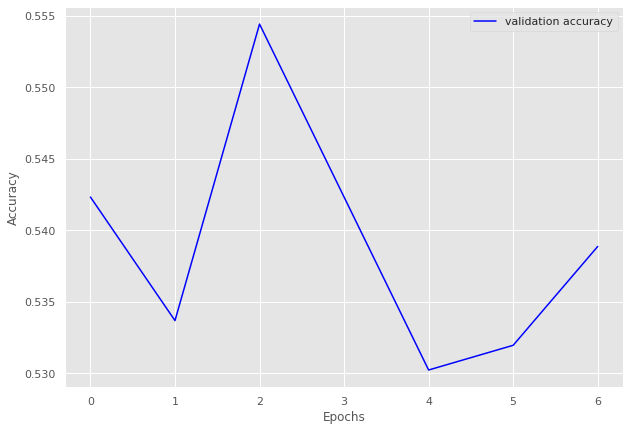

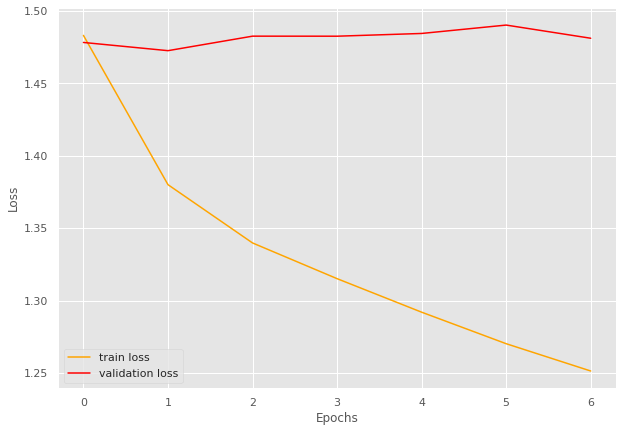

{'0': {'coarse': {'00': 0.8344144759303517, '10': 0.7350631614885627, '20': 0.6717065795249476, '30': 0.587328683607277, '50': 0.4409598595327513, '80': 0.2362093352192362}, 'fine': {'00': {'0': 0.9762140733399405, '1': 0.9764150943396226, '2': 0.9572277227722772, '3': 0.973404255319149, '4': 0.99644128113879, '5': 0.9815242494226328, '7': 0.9389619883040936, '8': 0.9871175523349437, '9': 0.8673469387755102, '11': 0.9451642060861706, '12': 0.9523012552301255, '14': 0.9555808656036446, '15': 0.9640077821011673}, '10': {'0': 0.8848780487804878, '1': 0.8422535211267606, '2': 0.8879103282626101, '3': 0.9231638418079096, '4': 0.9256505576208178, '5': 0.906885758998435, '7': 0.8858381502890174, '8': 0.9591503267973857, '9': 0.7749469214437368, '11': 0.8723911747167561, '12': 0.9203319502074688, '14': 0.8818380743982495, '15': 0.8033088235294118}, '20': {'0': 0.8442064264849075, '1': 0.7038567493112947, '2': 0.8205027494108406, '3': 0.8527889591719379, '4': 0.8386075949367089, '5': 0.80940794

100%|██████████| 93/93 [00:33<00:00,  2.80batch/s, loss=1.31]


train loss 1.3077130715052288, validation loss 1.2259679238001506, validation accuracy 0.6600361663652803
Coarse label 11 Epoch 2
-------------------------------


100%|██████████| 93/93 [00:33<00:00,  2.77batch/s, loss=1.21]


INFO: Early stopping counter 1 of 5
train loss 1.2113370126293552, validation loss 1.2312695052888658, validation accuracy 0.6600361663652803
Coarse label 11 Epoch 3
-------------------------------


100%|██████████| 93/93 [00:33<00:00,  2.77batch/s, loss=1.16]


INFO: Early stopping counter 2 of 5
train loss 1.1594202838918215, validation loss 1.230722016758389, validation accuracy 0.6473779385171791
Coarse label 11 Epoch 4
-------------------------------


100%|██████████| 93/93 [00:33<00:00,  2.78batch/s, loss=1.12]


INFO: Early stopping counter 3 of 5
train loss 1.1218083596998645, validation loss 1.2332746452755399, validation accuracy 0.6618444846292948
Coarse label 11 Epoch 5
-------------------------------


100%|██████████| 93/93 [00:33<00:00,  2.76batch/s, loss=1.1] 


INFO: Early stopping counter 4 of 5
train loss 1.1037444747904295, validation loss 1.2391102313995361, validation accuracy 0.6582278481012658
Coarse label 11 Epoch 6
-------------------------------


100%|██████████| 93/93 [00:33<00:00,  2.79batch/s, loss=1.09]


INFO: Early stopping counter 5 of 5
INFO: Early stopping
Done! Saved model with test accuracy 0.6529126213592233 and loss 1.2612300723791123


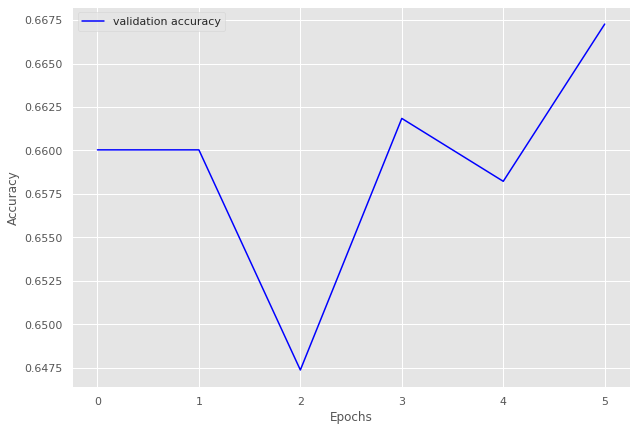

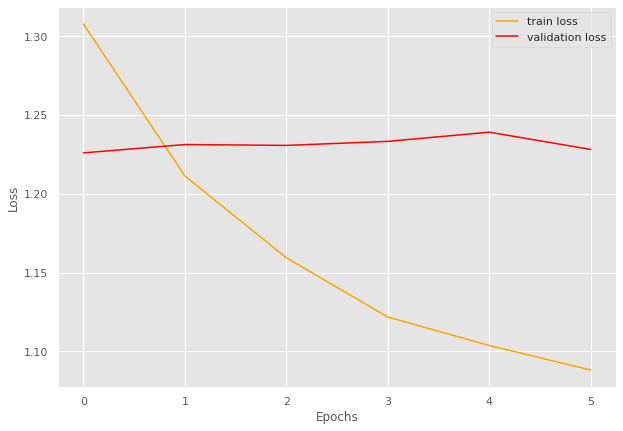

{'0': {'coarse': {'00': 0.8344144759303517, '10': 0.7350631614885627, '20': 0.6717065795249476, '30': 0.587328683607277, '50': 0.4409598595327513, '80': 0.2362093352192362}, 'fine': {'00': {'0': 0.9762140733399405, '1': 0.9764150943396226, '2': 0.9572277227722772, '3': 0.973404255319149, '4': 0.99644128113879, '5': 0.9815242494226328, '7': 0.9389619883040936, '8': 0.9871175523349437, '9': 0.8673469387755102, '11': 0.9451642060861706, '12': 0.9523012552301255, '14': 0.9555808656036446, '15': 0.9640077821011673}, '10': {'0': 0.8848780487804878, '1': 0.8422535211267606, '2': 0.8879103282626101, '3': 0.9231638418079096, '4': 0.9256505576208178, '5': 0.906885758998435, '7': 0.8858381502890174, '8': 0.9591503267973857, '9': 0.7749469214437368, '11': 0.8723911747167561, '12': 0.9203319502074688, '14': 0.8818380743982495, '15': 0.8033088235294118}, '20': {'0': 0.8442064264849075, '1': 0.7038567493112947, '2': 0.8205027494108406, '3': 0.8527889591719379, '4': 0.8386075949367089, '5': 0.80940794

100%|██████████| 47/47 [00:16<00:00,  2.79batch/s, loss=0.889]


train loss 0.8892753035464185, validation loss 0.8661994338035583, validation accuracy 0.6512345679012346
Coarse label 12 Epoch 2
-------------------------------


100%|██████████| 47/47 [00:16<00:00,  2.83batch/s, loss=0.767]


train loss 0.7666817383563265, validation loss 0.8573415776093801, validation accuracy 0.6388888888888888
Coarse label 12 Epoch 3
-------------------------------


100%|██████████| 47/47 [00:16<00:00,  2.83batch/s, loss=0.684]


INFO: Early stopping counter 1 of 5
train loss 0.683683785986393, validation loss 0.9074371059735616, validation accuracy 0.6419753086419753
Coarse label 12 Epoch 4
-------------------------------


100%|██████████| 47/47 [00:16<00:00,  2.82batch/s, loss=0.648]


INFO: Early stopping counter 2 of 5
train loss 0.648205965123278, validation loss 0.8972566723823547, validation accuracy 0.6450617283950617
Coarse label 12 Epoch 5
-------------------------------


100%|██████████| 47/47 [00:16<00:00,  2.82batch/s, loss=0.642]


INFO: Early stopping counter 3 of 5
train loss 0.6420569889088894, validation loss 0.9540867805480957, validation accuracy 0.6358024691358025
Coarse label 12 Epoch 6
-------------------------------


100%|██████████| 47/47 [00:16<00:00,  2.82batch/s, loss=0.621]


INFO: Early stopping counter 4 of 5
train loss 0.6214324400780049, validation loss 0.8917535642782847, validation accuracy 0.6697530864197531
Coarse label 12 Epoch 7
-------------------------------


100%|██████████| 47/47 [00:17<00:00,  2.73batch/s, loss=0.619]


INFO: Early stopping counter 5 of 5
INFO: Early stopping
Done! Saved model with test accuracy 0.6637323943661971 and loss 0.8743207719590929


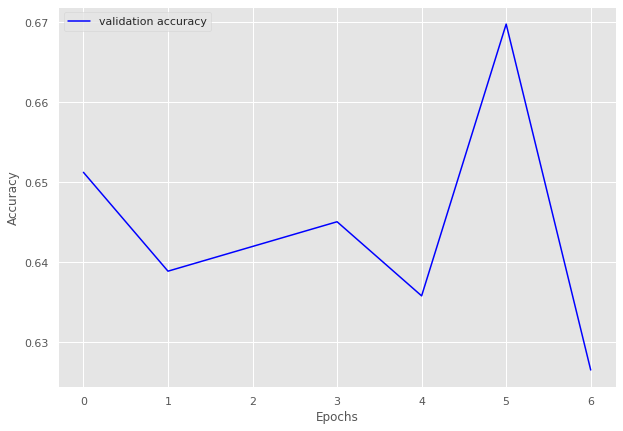

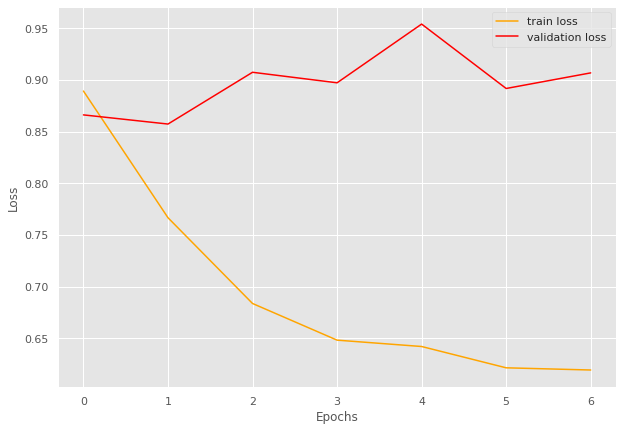

{'0': {'coarse': {'00': 0.8344144759303517, '10': 0.7350631614885627, '20': 0.6717065795249476, '30': 0.587328683607277, '50': 0.4409598595327513, '80': 0.2362093352192362}, 'fine': {'00': {'0': 0.9762140733399405, '1': 0.9764150943396226, '2': 0.9572277227722772, '3': 0.973404255319149, '4': 0.99644128113879, '5': 0.9815242494226328, '7': 0.9389619883040936, '8': 0.9871175523349437, '9': 0.8673469387755102, '11': 0.9451642060861706, '12': 0.9523012552301255, '14': 0.9555808656036446, '15': 0.9640077821011673}, '10': {'0': 0.8848780487804878, '1': 0.8422535211267606, '2': 0.8879103282626101, '3': 0.9231638418079096, '4': 0.9256505576208178, '5': 0.906885758998435, '7': 0.8858381502890174, '8': 0.9591503267973857, '9': 0.7749469214437368, '11': 0.8723911747167561, '12': 0.9203319502074688, '14': 0.8818380743982495, '15': 0.8033088235294118}, '20': {'0': 0.8442064264849075, '1': 0.7038567493112947, '2': 0.8205027494108406, '3': 0.8527889591719379, '4': 0.8386075949367089, '5': 0.80940794

100%|██████████| 192/192 [01:09<00:00,  2.77batch/s, loss=1.8] 


train loss 1.7959630799790223, validation loss 1.7915369697979517, validation accuracy 0.5632698768197089
Coarse label 13 Epoch 2
-------------------------------


100%|██████████| 192/192 [01:09<00:00,  2.77batch/s, loss=1.72]


INFO: Early stopping counter 1 of 5
train loss 1.7234113675852616, validation loss 1.8012885536466325, validation accuracy 0.5621500559910414
Coarse label 13 Epoch 3
-------------------------------


100%|██████████| 192/192 [01:09<00:00,  2.77batch/s, loss=1.7] 


INFO: Early stopping counter 2 of 5
train loss 1.6991132361193497, validation loss 1.8061864716666085, validation accuracy 0.561030235162374
Coarse label 13 Epoch 4
-------------------------------


100%|██████████| 192/192 [01:09<00:00,  2.77batch/s, loss=1.68]


INFO: Early stopping counter 3 of 5
train loss 1.6813301711032789, validation loss 1.795712649822235, validation accuracy 0.5655095184770437
Coarse label 13 Epoch 5
-------------------------------


100%|██████████| 192/192 [01:09<00:00,  2.76batch/s, loss=1.67]


train loss 1.6708268448710442, validation loss 1.787421430860247, validation accuracy 0.5733482642777156
Coarse label 13 Epoch 6
-------------------------------


100%|██████████| 192/192 [01:09<00:00,  2.77batch/s, loss=1.66]


INFO: Early stopping counter 4 of 5
train loss 1.657272123421232, validation loss 1.7924538850784302, validation accuracy 0.5722284434490481
Coarse label 13 Epoch 7
-------------------------------


100%|██████████| 192/192 [01:09<00:00,  2.76batch/s, loss=1.65]


train loss 1.6495406658699114, validation loss 1.7804922035762243, validation accuracy 0.5901455767077267
Coarse label 13 Epoch 8
-------------------------------


100%|██████████| 192/192 [01:09<00:00,  2.76batch/s, loss=1.64]


INFO: Early stopping counter 5 of 5
INFO: Early stopping
Done! Saved model with test accuracy 0.6074362300043233 and loss 1.7690550282194808


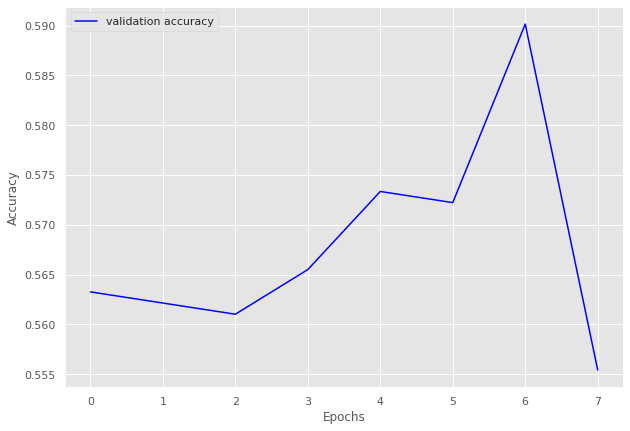

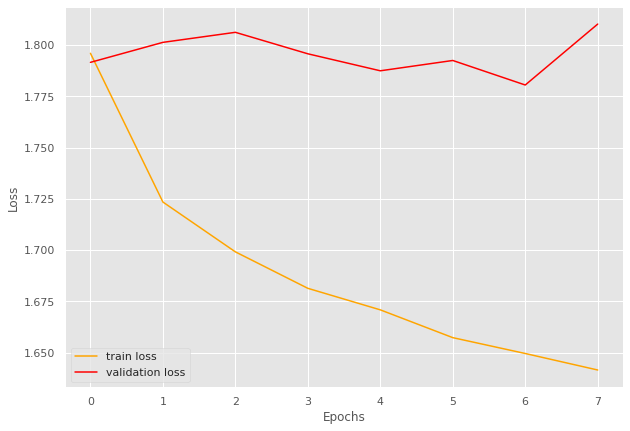

{'0': {'coarse': {'00': 0.8344144759303517, '10': 0.7350631614885627, '20': 0.6717065795249476, '30': 0.587328683607277, '50': 0.4409598595327513, '80': 0.2362093352192362}, 'fine': {'00': {'0': 0.9762140733399405, '1': 0.9764150943396226, '2': 0.9572277227722772, '3': 0.973404255319149, '4': 0.99644128113879, '5': 0.9815242494226328, '7': 0.9389619883040936, '8': 0.9871175523349437, '9': 0.8673469387755102, '11': 0.9451642060861706, '12': 0.9523012552301255, '14': 0.9555808656036446, '15': 0.9640077821011673}, '10': {'0': 0.8848780487804878, '1': 0.8422535211267606, '2': 0.8879103282626101, '3': 0.9231638418079096, '4': 0.9256505576208178, '5': 0.906885758998435, '7': 0.8858381502890174, '8': 0.9591503267973857, '9': 0.7749469214437368, '11': 0.8723911747167561, '12': 0.9203319502074688, '14': 0.8818380743982495, '15': 0.8033088235294118}, '20': {'0': 0.8442064264849075, '1': 0.7038567493112947, '2': 0.8205027494108406, '3': 0.8527889591719379, '4': 0.8386075949367089, '5': 0.80940794

100%|██████████| 42/42 [00:14<00:00,  2.85batch/s, loss=0.96] 


train loss 0.9602115977378118, validation loss 0.963675007224083, validation accuracy 0.5377358490566038
Coarse label 14 Epoch 2
-------------------------------


100%|██████████| 42/42 [00:14<00:00,  2.82batch/s, loss=0.806]


INFO: Early stopping counter 1 of 5
train loss 0.8059201283114297, validation loss 0.9884787350893021, validation accuracy 0.5235849056603774
Coarse label 14 Epoch 3
-------------------------------


100%|██████████| 42/42 [00:14<00:00,  2.87batch/s, loss=0.704]


INFO: Early stopping counter 2 of 5
train loss 0.704404048976444, validation loss 0.9860897213220596, validation accuracy 0.5283018867924528
Coarse label 14 Epoch 4
-------------------------------


100%|██████████| 42/42 [00:14<00:00,  2.81batch/s, loss=0.663]


INFO: Early stopping counter 3 of 5
train loss 0.6633713174433935, validation loss 1.0078205168247223, validation accuracy 0.5141509433962265
Coarse label 14 Epoch 5
-------------------------------


100%|██████████| 42/42 [00:14<00:00,  2.85batch/s, loss=0.646]


INFO: Early stopping counter 4 of 5
train loss 0.646416615872156, validation loss 1.019214615225792, validation accuracy 0.5141509433962265
Coarse label 14 Epoch 6
-------------------------------


100%|██████████| 42/42 [00:14<00:00,  2.86batch/s, loss=0.629]


INFO: Early stopping counter 5 of 5
INFO: Early stopping
Done! Saved model with test accuracy 0.584 and loss 0.9405800700187683


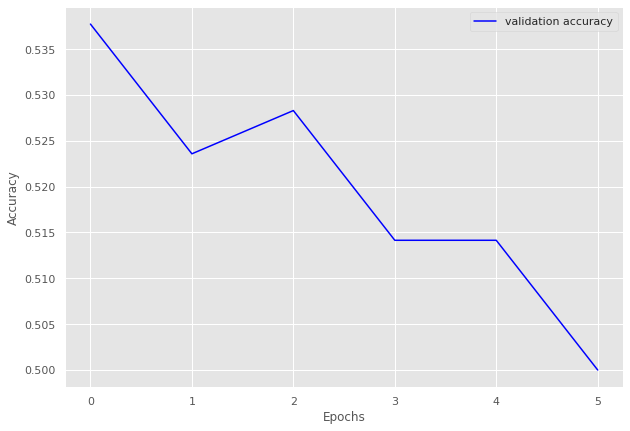

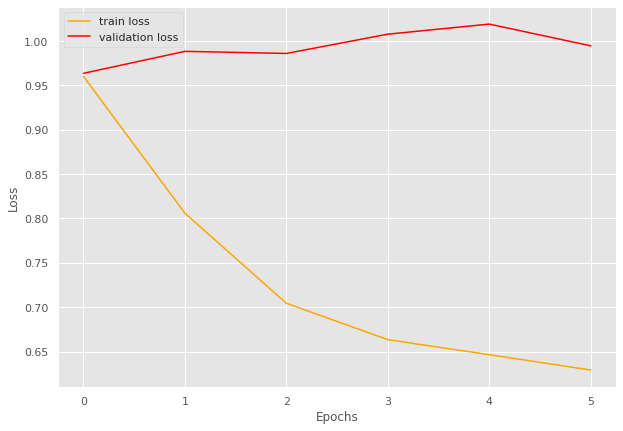

{'0': {'coarse': {'00': 0.8344144759303517, '10': 0.7350631614885627, '20': 0.6717065795249476, '30': 0.587328683607277, '50': 0.4409598595327513, '80': 0.2362093352192362}, 'fine': {'00': {'0': 0.9762140733399405, '1': 0.9764150943396226, '2': 0.9572277227722772, '3': 0.973404255319149, '4': 0.99644128113879, '5': 0.9815242494226328, '7': 0.9389619883040936, '8': 0.9871175523349437, '9': 0.8673469387755102, '11': 0.9451642060861706, '12': 0.9523012552301255, '14': 0.9555808656036446, '15': 0.9640077821011673}, '10': {'0': 0.8848780487804878, '1': 0.8422535211267606, '2': 0.8879103282626101, '3': 0.9231638418079096, '4': 0.9256505576208178, '5': 0.906885758998435, '7': 0.8858381502890174, '8': 0.9591503267973857, '9': 0.7749469214437368, '11': 0.8723911747167561, '12': 0.9203319502074688, '14': 0.8818380743982495, '15': 0.8033088235294118}, '20': {'0': 0.8442064264849075, '1': 0.7038567493112947, '2': 0.8205027494108406, '3': 0.8527889591719379, '4': 0.8386075949367089, '5': 0.80940794

100%|██████████| 79/79 [00:28<00:00,  2.79batch/s, loss=1.09]


train loss 1.0856239969217325, validation loss 0.9921396672725677, validation accuracy 0.7194860813704497
Coarse label 15 Epoch 2
-------------------------------


100%|██████████| 79/79 [00:28<00:00,  2.75batch/s, loss=0.986]


INFO: Early stopping counter 1 of 5
train loss 0.9862857008282142, validation loss 1.012873888015747, validation accuracy 0.7173447537473233
Coarse label 15 Epoch 3
-------------------------------


100%|██████████| 79/79 [00:28<00:00,  2.78batch/s, loss=0.935]


INFO: Early stopping counter 2 of 5
train loss 0.9353636752201032, validation loss 1.0220537185668945, validation accuracy 0.702355460385439
Coarse label 15 Epoch 4
-------------------------------


100%|██████████| 79/79 [00:31<00:00,  2.50batch/s, loss=0.902]


INFO: Early stopping counter 3 of 5
train loss 0.9020438066011742, validation loss 1.0332990437746048, validation accuracy 0.69593147751606
Coarse label 15 Epoch 5
-------------------------------


100%|██████████| 79/79 [00:28<00:00,  2.82batch/s, loss=0.881]


INFO: Early stopping counter 4 of 5
train loss 0.8809035473232028, validation loss 1.0300570204854012, validation accuracy 0.708779443254818
Coarse label 15 Epoch 6
-------------------------------


100%|██████████| 79/79 [00:28<00:00,  2.80batch/s, loss=0.864]


INFO: Early stopping counter 5 of 5
INFO: Early stopping
Done! Saved model with test accuracy 0.6676470588235294 and loss 1.0684840194880962


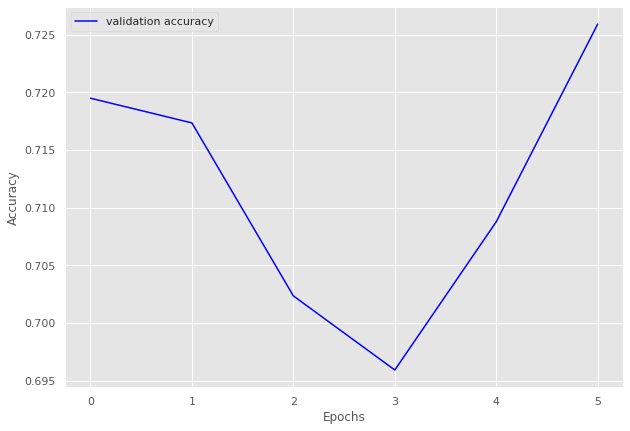

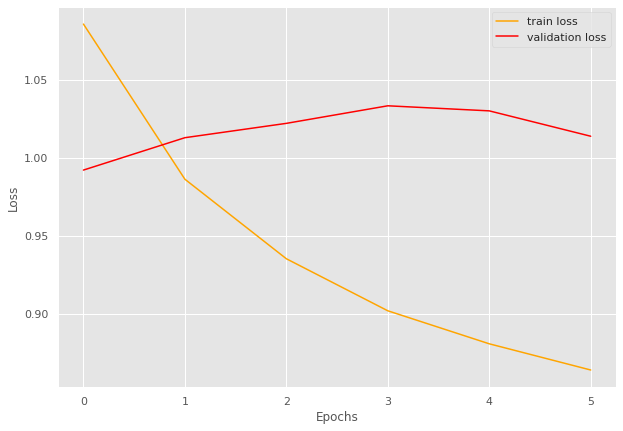

{'0': {'coarse': {'00': 0.8344144759303517, '10': 0.7350631614885627, '20': 0.6717065795249476, '30': 0.587328683607277, '50': 0.4409598595327513, '80': 0.2362093352192362}, 'fine': {'00': {'0': 0.9762140733399405, '1': 0.9764150943396226, '2': 0.9572277227722772, '3': 0.973404255319149, '4': 0.99644128113879, '5': 0.9815242494226328, '7': 0.9389619883040936, '8': 0.9871175523349437, '9': 0.8673469387755102, '11': 0.9451642060861706, '12': 0.9523012552301255, '14': 0.9555808656036446, '15': 0.9640077821011673}, '10': {'0': 0.8848780487804878, '1': 0.8422535211267606, '2': 0.8879103282626101, '3': 0.9231638418079096, '4': 0.9256505576208178, '5': 0.906885758998435, '7': 0.8858381502890174, '8': 0.9591503267973857, '9': 0.7749469214437368, '11': 0.8723911747167561, '12': 0.9203319502074688, '14': 0.8818380743982495, '15': 0.8033088235294118}, '20': {'0': 0.8442064264849075, '1': 0.7038567493112947, '2': 0.8205027494108406, '3': 0.8527889591719379, '4': 0.8386075949367089, '5': 0.80940794

100%|██████████| 112/112 [00:44<00:00,  2.50batch/s, loss=1.46]


train loss 1.4561968296766281, validation loss 1.5290418995751276, validation accuracy 0.4897196261682243
Coarse label 16 Epoch 2
-------------------------------


100%|██████████| 112/112 [01:22<00:00,  1.35batch/s, loss=1.37]


INFO: Early stopping counter 1 of 5
train loss 1.3747278239045824, validation loss 1.5420983632405598, validation accuracy 0.4785046728971963
Coarse label 16 Epoch 3
-------------------------------


100%|██████████| 112/112 [01:24<00:00,  1.32batch/s, loss=1.34]


INFO: Early stopping counter 2 of 5
train loss 1.3391293532082014, validation loss 1.5360394451353285, validation accuracy 0.4897196261682243
Coarse label 16 Epoch 4
-------------------------------


100%|██████████| 112/112 [00:52<00:00,  2.14batch/s, loss=1.32]


INFO: Early stopping counter 3 of 5
train loss 1.3157376561846053, validation loss 1.5402835342619154, validation accuracy 0.497196261682243
Coarse label 16 Epoch 5
-------------------------------


100%|██████████| 112/112 [00:40<00:00,  2.73batch/s, loss=1.29]


INFO: Early stopping counter 4 of 5
train loss 1.292469868702548, validation loss 1.538887209362454, validation accuracy 0.4953271028037383
Coarse label 16 Epoch 6
-------------------------------


100%|██████████| 112/112 [00:40<00:00,  2.78batch/s, loss=1.28]


INFO: Early stopping counter 5 of 5
INFO: Early stopping
Done! Saved model with test accuracy 0.6138328530259366 and loss 1.4251768589019775


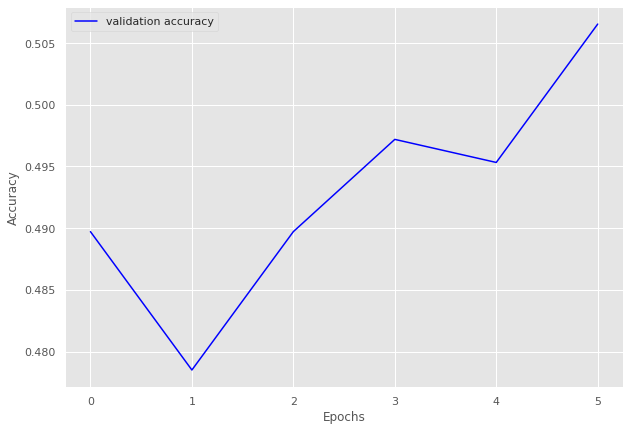

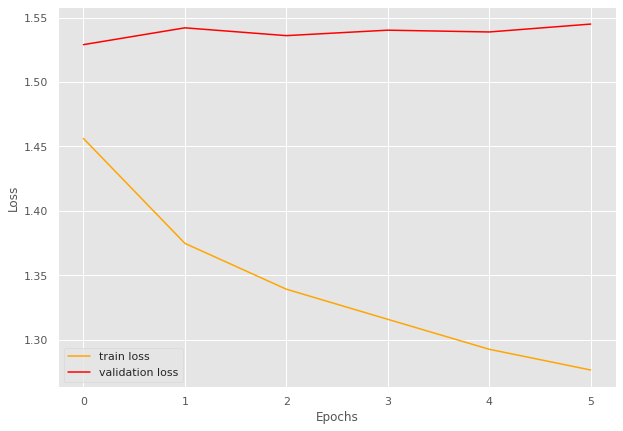

{'0': {'coarse': {'00': 0.8344144759303517, '10': 0.7350631614885627, '20': 0.6717065795249476, '30': 0.587328683607277, '50': 0.4409598595327513, '80': 0.2362093352192362}, 'fine': {'00': {'0': 0.9762140733399405, '1': 0.9764150943396226, '2': 0.9572277227722772, '3': 0.973404255319149, '4': 0.99644128113879, '5': 0.9815242494226328, '7': 0.9389619883040936, '8': 0.9871175523349437, '9': 0.8673469387755102, '11': 0.9451642060861706, '12': 0.9523012552301255, '14': 0.9555808656036446, '15': 0.9640077821011673}, '10': {'0': 0.8848780487804878, '1': 0.8422535211267606, '2': 0.8879103282626101, '3': 0.9231638418079096, '4': 0.9256505576208178, '5': 0.906885758998435, '7': 0.8858381502890174, '8': 0.9591503267973857, '9': 0.7749469214437368, '11': 0.8723911747167561, '12': 0.9203319502074688, '14': 0.8818380743982495, '15': 0.8033088235294118}, '20': {'0': 0.8442064264849075, '1': 0.7038567493112947, '2': 0.8205027494108406, '3': 0.8527889591719379, '4': 0.8386075949367089, '5': 0.80940794

100%|██████████| 71/71 [00:25<00:00,  2.79batch/s, loss=1.15]


train loss 1.1494764828346145, validation loss 1.057253509759903, validation accuracy 0.6572668112798264
Coarse label 17 Epoch 2
-------------------------------


100%|██████████| 71/71 [00:25<00:00,  2.82batch/s, loss=1.03]


train loss 1.0272499759432296, validation loss 1.0391701459884644, validation accuracy 0.6767895878524945
Coarse label 17 Epoch 3
-------------------------------


100%|██████████| 71/71 [00:25<00:00,  2.83batch/s, loss=0.963]


INFO: Early stopping counter 1 of 5
train loss 0.96318794136316, validation loss 1.0695761442184448, validation accuracy 0.6637744034707158
Coarse label 17 Epoch 4
-------------------------------


100%|██████████| 71/71 [00:25<00:00,  2.79batch/s, loss=0.93] 


INFO: Early stopping counter 2 of 5
train loss 0.9295975557515319, validation loss 1.0438139215111732, validation accuracy 0.6746203904555315
Coarse label 17 Epoch 5
-------------------------------


100%|██████████| 71/71 [00:25<00:00,  2.83batch/s, loss=0.902]


INFO: Early stopping counter 3 of 5
train loss 0.9015331209545404, validation loss 1.0518883615732193, validation accuracy 0.6702819956616052
Coarse label 17 Epoch 6
-------------------------------


100%|██████████| 71/71 [00:25<00:00,  2.81batch/s, loss=0.888]


INFO: Early stopping counter 4 of 5
train loss 0.8875425474744447, validation loss 1.0697061568498611, validation accuracy 0.6594360086767896
Coarse label 17 Epoch 7
-------------------------------


100%|██████████| 71/71 [00:25<00:00,  2.83batch/s, loss=0.869]


INFO: Early stopping counter 5 of 5
INFO: Early stopping
Done! Saved model with test accuracy 0.6454741379310345 and loss 1.1004087885220846


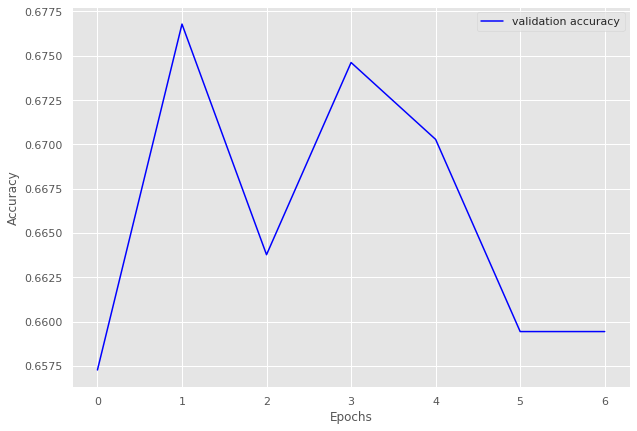

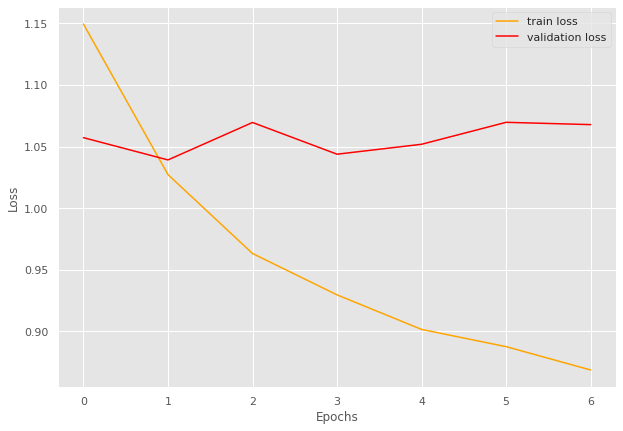

{'0': {'coarse': {'00': 0.8344144759303517, '10': 0.7350631614885627, '20': 0.6717065795249476, '30': 0.587328683607277, '50': 0.4409598595327513, '80': 0.2362093352192362}, 'fine': {'00': {'0': 0.9762140733399405, '1': 0.9764150943396226, '2': 0.9572277227722772, '3': 0.973404255319149, '4': 0.99644128113879, '5': 0.9815242494226328, '7': 0.9389619883040936, '8': 0.9871175523349437, '9': 0.8673469387755102, '11': 0.9451642060861706, '12': 0.9523012552301255, '14': 0.9555808656036446, '15': 0.9640077821011673}, '10': {'0': 0.8848780487804878, '1': 0.8422535211267606, '2': 0.8879103282626101, '3': 0.9231638418079096, '4': 0.9256505576208178, '5': 0.906885758998435, '7': 0.8858381502890174, '8': 0.9591503267973857, '9': 0.7749469214437368, '11': 0.8723911747167561, '12': 0.9203319502074688, '14': 0.8818380743982495, '15': 0.8033088235294118}, '20': {'0': 0.8442064264849075, '1': 0.7038567493112947, '2': 0.8205027494108406, '3': 0.8527889591719379, '4': 0.8386075949367089, '5': 0.80940794

100%|██████████| 23/23 [00:08<00:00,  2.79batch/s, loss=0.634]


train loss 0.6339830833932628, validation loss 0.6224806010723114, validation accuracy 0.628099173553719
Coarse label 18 Epoch 2
-------------------------------


100%|██████████| 23/23 [00:08<00:00,  2.83batch/s, loss=0.449]


INFO: Early stopping counter 1 of 5
train loss 0.4490153361921725, validation loss 0.6454174816608429, validation accuracy 0.6115702479338843
Coarse label 18 Epoch 3
-------------------------------


100%|██████████| 23/23 [00:07<00:00,  2.89batch/s, loss=0.351]


INFO: Early stopping counter 2 of 5
train loss 0.3507917005082835, validation loss 0.6679908037185669, validation accuracy 0.6198347107438017
Coarse label 18 Epoch 4
-------------------------------


100%|██████████| 23/23 [00:07<00:00,  2.91batch/s, loss=0.336]


INFO: Early stopping counter 3 of 5
train loss 0.3357226744942043, validation loss 0.6250824332237244, validation accuracy 0.6694214876033058
Coarse label 18 Epoch 5
-------------------------------


100%|██████████| 23/23 [00:08<00:00,  2.81batch/s, loss=0.335]


INFO: Early stopping counter 4 of 5
train loss 0.335480369951414, validation loss 0.6246107518672943, validation accuracy 0.6776859504132231
Coarse label 18 Epoch 6
-------------------------------


100%|██████████| 23/23 [00:08<00:00,  2.81batch/s, loss=0.339]


train loss 0.3389341299948485, validation loss 0.6079753339290619, validation accuracy 0.6776859504132231
Coarse label 18 Epoch 7
-------------------------------


100%|██████████| 23/23 [00:08<00:00,  2.85batch/s, loss=0.33] 


INFO: Early stopping counter 5 of 5
INFO: Early stopping
Done! Saved model with test accuracy 0.6083650190114068 and loss 0.7444296836853027


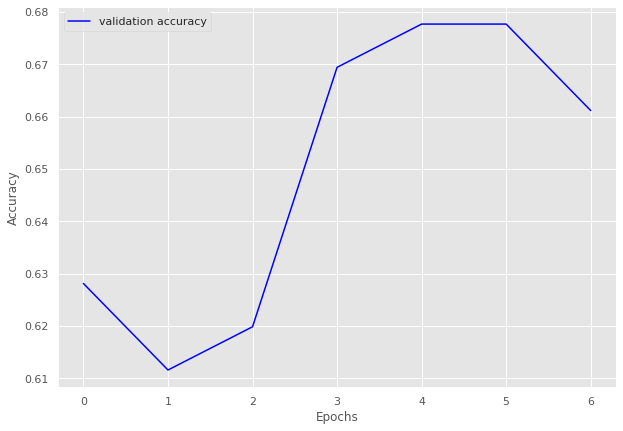

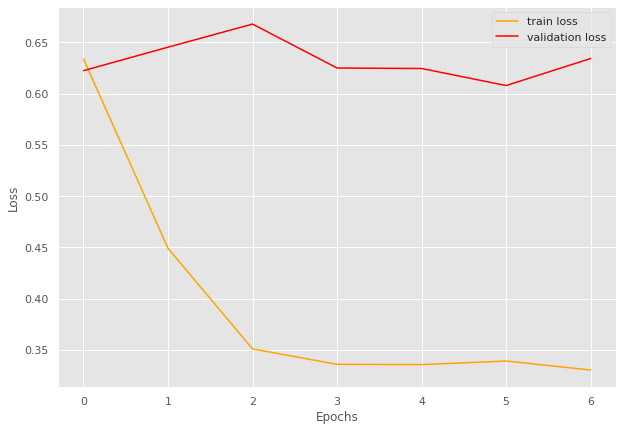

{'0': {'coarse': {'00': 0.8344144759303517, '10': 0.7350631614885627, '20': 0.6717065795249476, '30': 0.587328683607277, '50': 0.4409598595327513, '80': 0.2362093352192362}, 'fine': {'00': {'0': 0.9762140733399405, '1': 0.9764150943396226, '2': 0.9572277227722772, '3': 0.973404255319149, '4': 0.99644128113879, '5': 0.9815242494226328, '7': 0.9389619883040936, '8': 0.9871175523349437, '9': 0.8673469387755102, '11': 0.9451642060861706, '12': 0.9523012552301255, '14': 0.9555808656036446, '15': 0.9640077821011673}, '10': {'0': 0.8848780487804878, '1': 0.8422535211267606, '2': 0.8879103282626101, '3': 0.9231638418079096, '4': 0.9256505576208178, '5': 0.906885758998435, '7': 0.8858381502890174, '8': 0.9591503267973857, '9': 0.7749469214437368, '11': 0.8723911747167561, '12': 0.9203319502074688, '14': 0.8818380743982495, '15': 0.8033088235294118}, '20': {'0': 0.8442064264849075, '1': 0.7038567493112947, '2': 0.8205027494108406, '3': 0.8527889591719379, '4': 0.8386075949367089, '5': 0.80940794

100%|██████████| 32/32 [00:11<00:00,  2.84batch/s, loss=1.03]


train loss 1.0282397754490376, validation loss 1.074200431505839, validation accuracy 0.4057142857142857
Coarse label 19 Epoch 2
-------------------------------


100%|██████████| 32/32 [00:11<00:00,  2.77batch/s, loss=0.838]


train loss 0.8375053908675909, validation loss 1.0518771807352703, validation accuracy 0.44571428571428573
Coarse label 19 Epoch 3
-------------------------------


100%|██████████| 32/32 [00:11<00:00,  2.86batch/s, loss=0.684]


INFO: Early stopping counter 1 of 5
train loss 0.6841539908200502, validation loss 1.089798927307129, validation accuracy 0.4
Coarse label 19 Epoch 4
-------------------------------


100%|██████████| 32/32 [00:11<00:00,  2.82batch/s, loss=0.625]


INFO: Early stopping counter 2 of 5
train loss 0.6253410745412111, validation loss 1.0978100697199504, validation accuracy 0.4057142857142857
Coarse label 19 Epoch 5
-------------------------------


100%|██████████| 32/32 [00:11<00:00,  2.77batch/s, loss=0.609]


INFO: Early stopping counter 3 of 5
train loss 0.6085073780268431, validation loss 1.0982331832249959, validation accuracy 0.4114285714285714
Coarse label 19 Epoch 6
-------------------------------


100%|██████████| 32/32 [00:11<00:00,  2.84batch/s, loss=0.598]


INFO: Early stopping counter 4 of 5
train loss 0.5982119757682085, validation loss 1.0839365323384602, validation accuracy 0.42857142857142855
Coarse label 19 Epoch 7
-------------------------------


100%|██████████| 32/32 [00:11<00:00,  2.80batch/s, loss=0.596]


train loss 0.5957984291017056, validation loss 1.039636254310608, validation accuracy 0.45714285714285713
Coarse label 19 Epoch 8
-------------------------------


100%|██████████| 32/32 [00:11<00:00,  2.85batch/s, loss=0.586]


INFO: Early stopping counter 5 of 5
INFO: Early stopping
Done! Saved model with test accuracy 0.5171568627450981 and loss 1.0224039213997977


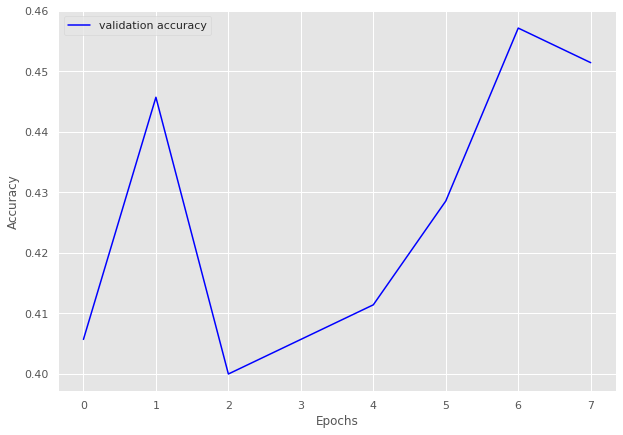

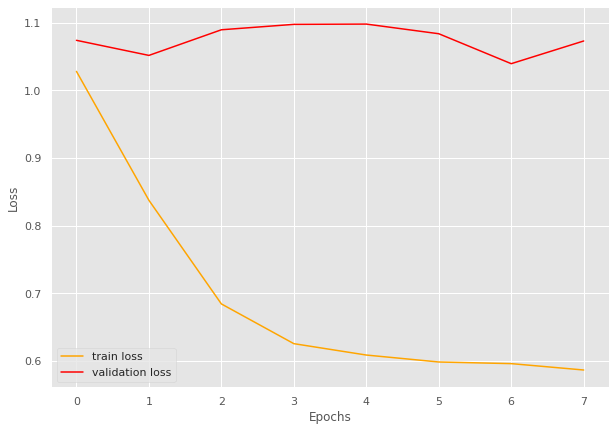

{'0': {'coarse': {'00': 0.8344144759303517, '10': 0.7350631614885627, '20': 0.6717065795249476, '30': 0.587328683607277, '50': 0.4409598595327513, '80': 0.2362093352192362}, 'fine': {'00': {'0': 0.9762140733399405, '1': 0.9764150943396226, '2': 0.9572277227722772, '3': 0.973404255319149, '4': 0.99644128113879, '5': 0.9815242494226328, '7': 0.9389619883040936, '8': 0.9871175523349437, '9': 0.8673469387755102, '11': 0.9451642060861706, '12': 0.9523012552301255, '14': 0.9555808656036446, '15': 0.9640077821011673}, '10': {'0': 0.8848780487804878, '1': 0.8422535211267606, '2': 0.8879103282626101, '3': 0.9231638418079096, '4': 0.9256505576208178, '5': 0.906885758998435, '7': 0.8858381502890174, '8': 0.9591503267973857, '9': 0.7749469214437368, '11': 0.8723911747167561, '12': 0.9203319502074688, '14': 0.8818380743982495, '15': 0.8033088235294118}, '20': {'0': 0.8442064264849075, '1': 0.7038567493112947, '2': 0.8205027494108406, '3': 0.8527889591719379, '4': 0.8386075949367089, '5': 0.80940794

Calculating for label_noise 80
split_80_1
Start training a coarse model
Epoch 1
-------------------------------


100%|██████████| 1639/1639 [09:53<00:00,  2.76batch/s, loss=2.92]


train loss 2.919289349054985, validation loss 2.9044496059417724, validation accuracy 0.17012042964088098
Epoch 2
-------------------------------


100%|██████████| 1639/1639 [11:45<00:00,  2.32batch/s, loss=2.89]


train loss 2.894603123528118, validation loss 2.886296773778981, validation accuracy 0.18986655093848323
Epoch 3
-------------------------------


100%|██████████| 1639/1639 [09:55<00:00,  2.75batch/s, loss=2.88]


train loss 2.8809008169203287, validation loss 2.878949124237587, validation accuracy 0.19724422263209287
Epoch 4
-------------------------------


 96%|█████████▌| 1567/1639 [11:21<00:26,  2.74batch/s, loss=2.87]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

100%|██████████| 1639/1639 [11:38<00:00,  2.35batch/s, loss=2.86]


train loss 2.8573138950946055, validation loss 2.8651339530944826, validation accuracy 0.21134859498752306
Epoch 7
-------------------------------


 78%|███████▊  | 1274/1639 [07:37<02:11,  2.77batch/s, loss=2.85]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

100%|██████████| 1639/1639 [12:55<00:00,  2.11batch/s, loss=2.84]


INFO: Early stopping counter 2 of 5
train loss 2.837878698834273, validation loss 2.8579178234626506, validation accuracy 0.21905175219702724
Epoch 10
-------------------------------


 34%|███▍      | 554/1639 [03:18<06:26,  2.81batch/s, loss=2.83]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

100%|██████████| 1639/1639 [09:47<00:00,  2.79batch/s, loss=2.82]


train loss 2.8227997902619397, validation loss 2.850213826935867, validation accuracy 0.22751437561028534
Epoch 13
-------------------------------


  1%|          | 20/1639 [00:07<09:49,  2.75batch/s, loss=2.81]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

100%|██████████| 1639/1639 [09:54<00:00,  2.76batch/s, loss=2.81]


train loss 2.81339772392003, validation loss 2.8485807599692508, validation accuracy 0.2288163176738635
Epoch 15
-------------------------------


 83%|████████▎ | 1364/1639 [10:06<01:37,  2.83batch/s, loss=2.81]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

100%|██████████| 140/140 [00:50<00:00,  2.79batch/s, loss=1.83]


INFO: Early stopping counter 1 of 5
train loss 1.8258711687156133, validation loss 1.8651012948581152, validation accuracy 0.39227166276346603
Coarse label 4 Epoch 4
-------------------------------


100%|██████████| 140/140 [00:50<00:00,  2.79batch/s, loss=1.79]


INFO: Early stopping counter 2 of 5
train loss 1.7861018751348767, validation loss 1.8637391584260123, validation accuracy 0.3981264637002342
Coarse label 4 Epoch 5
-------------------------------


100%|██████████| 140/140 [00:53<00:00,  2.63batch/s, loss=1.75]


INFO: Early stopping counter 3 of 5
train loss 1.7512536321367536, validation loss 1.8702636701720101, validation accuracy 0.3911007025761124
Coarse label 4 Epoch 6
-------------------------------


100%|██████████| 140/140 [01:40<00:00,  1.39batch/s, loss=1.72]


INFO: Early stopping counter 4 of 5
train loss 1.7184579568249838, validation loss 1.8670011758804321, validation accuracy 0.3840749414519906
Coarse label 4 Epoch 7
-------------------------------


100%|██████████| 140/140 [01:41<00:00,  1.38batch/s, loss=1.68]


INFO: Early stopping counter 5 of 5
INFO: Early stopping
Done! Saved model with test accuracy 0.32806324110671936 and loss 1.9311290681362152


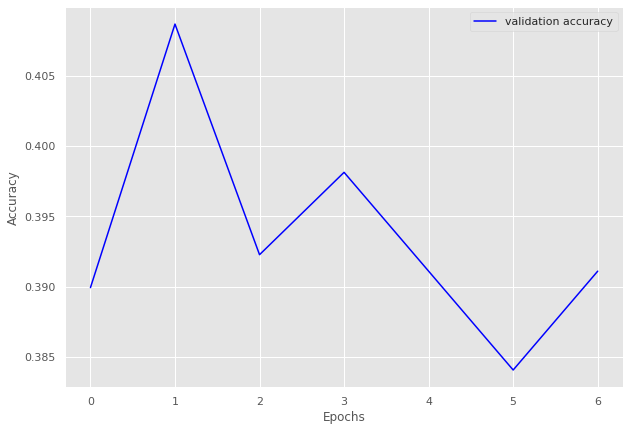

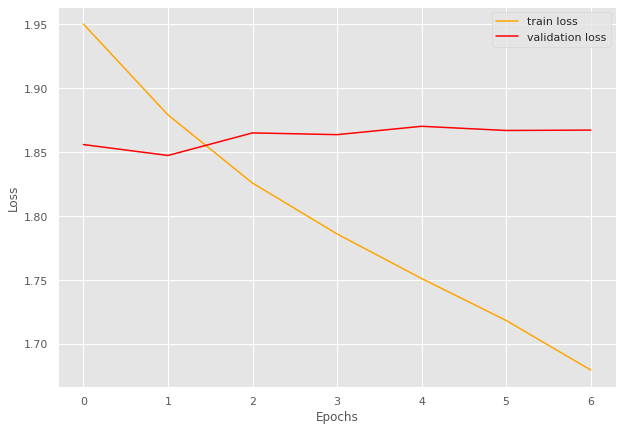

{'0': {'coarse': {'00': 0.8344144759303517, '10': 0.7350631614885627, '20': 0.6717065795249476, '30': 0.587328683607277, '50': 0.4409598595327513, '80': 0.2362093352192362}, 'fine': {'00': {'0': 0.9762140733399405, '1': 0.9764150943396226, '2': 0.9572277227722772, '3': 0.973404255319149, '4': 0.99644128113879, '5': 0.9815242494226328, '7': 0.9389619883040936, '8': 0.9871175523349437, '9': 0.8673469387755102, '11': 0.9451642060861706, '12': 0.9523012552301255, '14': 0.9555808656036446, '15': 0.9640077821011673}, '10': {'0': 0.8848780487804878, '1': 0.8422535211267606, '2': 0.8879103282626101, '3': 0.9231638418079096, '4': 0.9256505576208178, '5': 0.906885758998435, '7': 0.8858381502890174, '8': 0.9591503267973857, '9': 0.7749469214437368, '11': 0.8723911747167561, '12': 0.9203319502074688, '14': 0.8818380743982495, '15': 0.8033088235294118}, '20': {'0': 0.8442064264849075, '1': 0.7038567493112947, '2': 0.8205027494108406, '3': 0.8527889591719379, '4': 0.8386075949367089, '5': 0.80940794

100%|██████████| 130/130 [00:46<00:00,  2.82batch/s, loss=1.97]


train loss 1.9744287059857295, validation loss 1.958756836977872, validation accuracy 0.27729885057471265
Coarse label 5 Epoch 2
-------------------------------


100%|██████████| 130/130 [00:46<00:00,  2.82batch/s, loss=1.92]


INFO: Early stopping counter 1 of 5
train loss 1.9159030538338881, validation loss 1.967132720080289, validation accuracy 0.27729885057471265
Coarse label 5 Epoch 3
-------------------------------


100%|██████████| 130/130 [00:46<00:00,  2.78batch/s, loss=1.86]


INFO: Early stopping counter 2 of 5
train loss 1.8624311639712408, validation loss 1.980359966104681, validation accuracy 0.2672413793103448
Coarse label 5 Epoch 4
-------------------------------


100%|██████████| 130/130 [00:47<00:00,  2.76batch/s, loss=1.81]


INFO: Early stopping counter 3 of 5
train loss 1.8138242666537945, validation loss 1.978050622073087, validation accuracy 0.27298850574712646
Coarse label 5 Epoch 5
-------------------------------


100%|██████████| 130/130 [00:46<00:00,  2.79batch/s, loss=1.77]


INFO: Early stopping counter 4 of 5
train loss 1.7681508724506085, validation loss 1.9789598313244907, validation accuracy 0.2859195402298851
Coarse label 5 Epoch 6
-------------------------------


100%|██████████| 130/130 [00:46<00:00,  2.82batch/s, loss=1.73]


INFO: Early stopping counter 5 of 5
INFO: Early stopping
Done! Saved model with test accuracy 0.269811320754717 and loss 1.9859436082839965


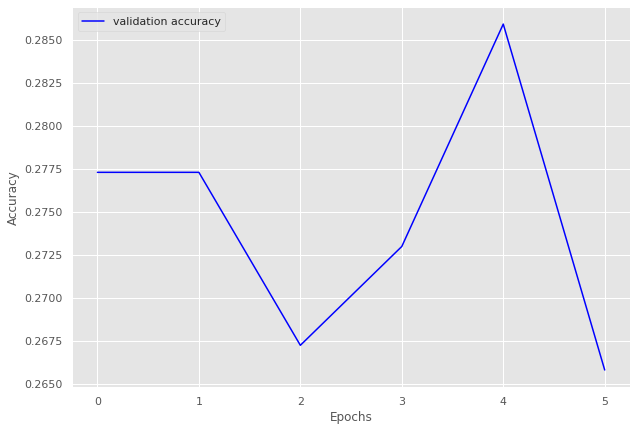

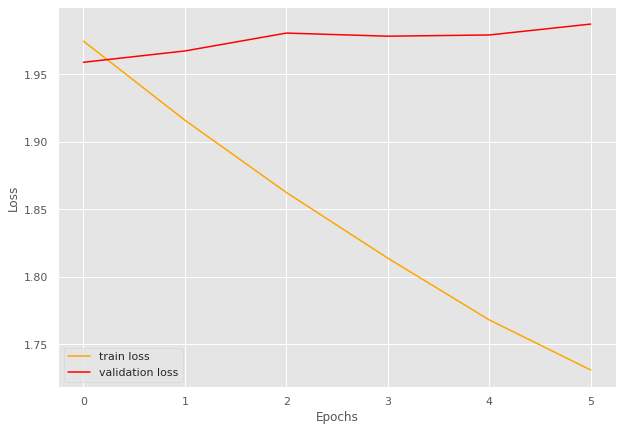

{'0': {'coarse': {'00': 0.8344144759303517, '10': 0.7350631614885627, '20': 0.6717065795249476, '30': 0.587328683607277, '50': 0.4409598595327513, '80': 0.2362093352192362}, 'fine': {'00': {'0': 0.9762140733399405, '1': 0.9764150943396226, '2': 0.9572277227722772, '3': 0.973404255319149, '4': 0.99644128113879, '5': 0.9815242494226328, '7': 0.9389619883040936, '8': 0.9871175523349437, '9': 0.8673469387755102, '11': 0.9451642060861706, '12': 0.9523012552301255, '14': 0.9555808656036446, '15': 0.9640077821011673}, '10': {'0': 0.8848780487804878, '1': 0.8422535211267606, '2': 0.8879103282626101, '3': 0.9231638418079096, '4': 0.9256505576208178, '5': 0.906885758998435, '7': 0.8858381502890174, '8': 0.9591503267973857, '9': 0.7749469214437368, '11': 0.8723911747167561, '12': 0.9203319502074688, '14': 0.8818380743982495, '15': 0.8033088235294118}, '20': {'0': 0.8442064264849075, '1': 0.7038567493112947, '2': 0.8205027494108406, '3': 0.8527889591719379, '4': 0.8386075949367089, '5': 0.80940794

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

100%|██████████| 175/175 [01:02<00:00,  2.80batch/s, loss=1.94]


train loss 1.942862274306161, validation loss 1.9941058244024004, validation accuracy 0.3526627218934911
Coarse label 13 Epoch 3
-------------------------------


100%|██████████| 175/175 [01:02<00:00,  2.79batch/s, loss=1.91]


INFO: Early stopping counter 1 of 5
train loss 1.913370579310826, validation loss 2.016859131199973, validation accuracy 0.3337278106508876
Coarse label 13 Epoch 4
-------------------------------


100%|██████████| 175/175 [01:03<00:00,  2.76batch/s, loss=1.89]


INFO: Early stopping counter 2 of 5
train loss 1.8900484030587332, validation loss 2.0163665499006, validation accuracy 0.3337278106508876
Coarse label 13 Epoch 5
-------------------------------


100%|██████████| 175/175 [01:06<00:00,  2.64batch/s, loss=1.86]


INFO: Early stopping counter 3 of 5
train loss 1.863607324872698, validation loss 2.0214897649628774, validation accuracy 0.33254437869822484
Coarse label 13 Epoch 6
-------------------------------


100%|██████████| 175/175 [01:03<00:00,  2.77batch/s, loss=1.84]


INFO: Early stopping counter 4 of 5
train loss 1.8382750919886999, validation loss 2.0139595525605336, validation accuracy 0.3337278106508876
Coarse label 13 Epoch 7
-------------------------------


100%|██████████| 175/175 [01:03<00:00,  2.76batch/s, loss=1.82]


INFO: Early stopping counter 5 of 5
INFO: Early stopping
Done! Saved model with test accuracy 0.3678899082568807 and loss 1.9969639369419643


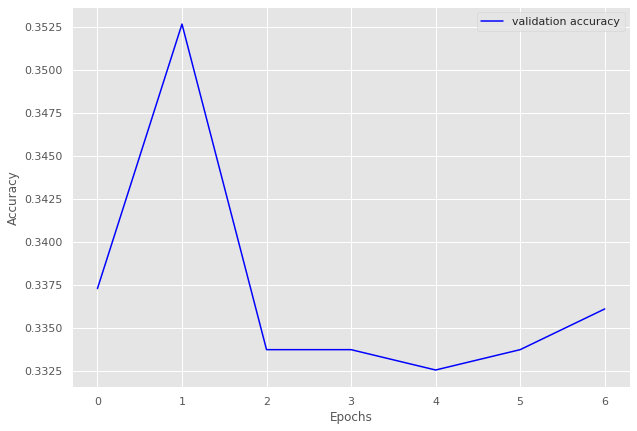

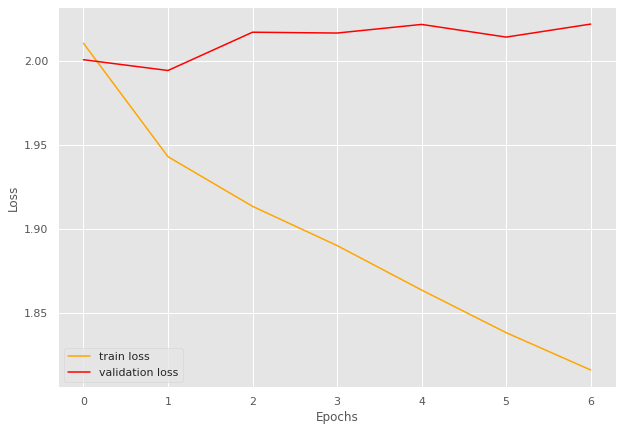

{'0': {'coarse': {'00': 0.8344144759303517, '10': 0.7350631614885627, '20': 0.6717065795249476, '30': 0.587328683607277, '50': 0.4409598595327513, '80': 0.2362093352192362}, 'fine': {'00': {'0': 0.9762140733399405, '1': 0.9764150943396226, '2': 0.9572277227722772, '3': 0.973404255319149, '4': 0.99644128113879, '5': 0.9815242494226328, '7': 0.9389619883040936, '8': 0.9871175523349437, '9': 0.8673469387755102, '11': 0.9451642060861706, '12': 0.9523012552301255, '14': 0.9555808656036446, '15': 0.9640077821011673}, '10': {'0': 0.8848780487804878, '1': 0.8422535211267606, '2': 0.8879103282626101, '3': 0.9231638418079096, '4': 0.9256505576208178, '5': 0.906885758998435, '7': 0.8858381502890174, '8': 0.9591503267973857, '9': 0.7749469214437368, '11': 0.8723911747167561, '12': 0.9203319502074688, '14': 0.8818380743982495, '15': 0.8033088235294118}, '20': {'0': 0.8442064264849075, '1': 0.7038567493112947, '2': 0.8205027494108406, '3': 0.8527889591719379, '4': 0.8386075949367089, '5': 0.80940794

100%|██████████| 46/46 [00:16<00:00,  2.80batch/s, loss=1.07]


train loss 1.0736563503742218, validation loss 1.057256555557251, validation accuracy 0.4247104247104247
Coarse label 14 Epoch 2
-------------------------------


100%|██████████| 46/46 [00:16<00:00,  2.76batch/s, loss=0.922]


INFO: Early stopping counter 1 of 5
train loss 0.9222696928874307, validation loss 1.1165742874145508, validation accuracy 0.40540540540540543
Coarse label 14 Epoch 3
-------------------------------


100%|██████████| 46/46 [00:16<00:00,  2.83batch/s, loss=0.784]


INFO: Early stopping counter 2 of 5
train loss 0.7844425323216812, validation loss 1.1276074409484864, validation accuracy 0.3745173745173745
Coarse label 14 Epoch 4
-------------------------------


100%|██████████| 46/46 [00:16<00:00,  2.83batch/s, loss=0.689]


INFO: Early stopping counter 3 of 5
train loss 0.6892604711263076, validation loss 1.0845934629440308, validation accuracy 0.43243243243243246
Coarse label 14 Epoch 5
-------------------------------


100%|██████████| 46/46 [00:16<00:00,  2.83batch/s, loss=0.657]


INFO: Early stopping counter 4 of 5
train loss 0.6569213620994402, validation loss 1.067839801311493, validation accuracy 0.42857142857142855
Coarse label 14 Epoch 6
-------------------------------


100%|██████████| 46/46 [00:16<00:00,  2.84batch/s, loss=0.643]


INFO: Early stopping counter 5 of 5
INFO: Early stopping
Done! Saved model with test accuracy 0.42474916387959866 and loss 1.0896344900131225


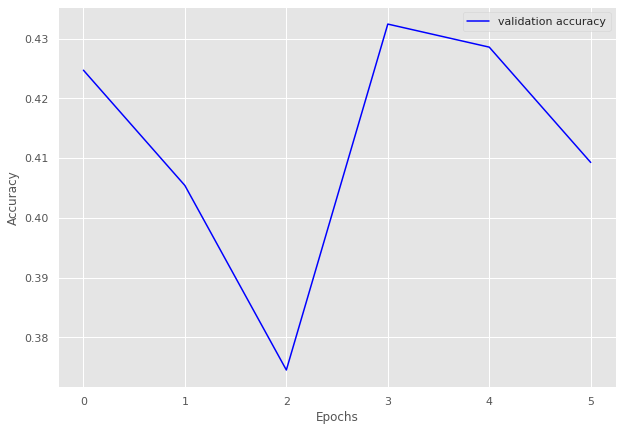

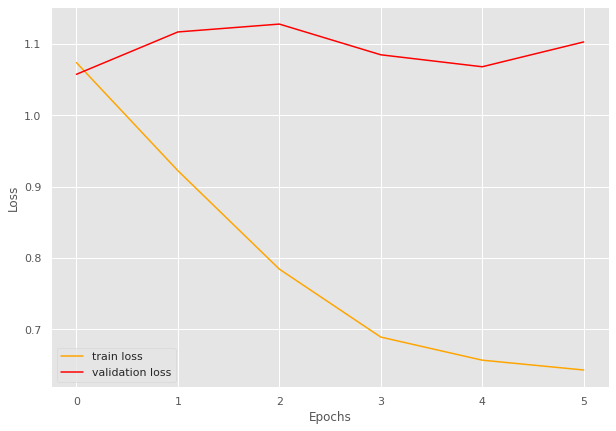

{'0': {'coarse': {'00': 0.8344144759303517, '10': 0.7350631614885627, '20': 0.6717065795249476, '30': 0.587328683607277, '50': 0.4409598595327513, '80': 0.2362093352192362}, 'fine': {'00': {'0': 0.9762140733399405, '1': 0.9764150943396226, '2': 0.9572277227722772, '3': 0.973404255319149, '4': 0.99644128113879, '5': 0.9815242494226328, '7': 0.9389619883040936, '8': 0.9871175523349437, '9': 0.8673469387755102, '11': 0.9451642060861706, '12': 0.9523012552301255, '14': 0.9555808656036446, '15': 0.9640077821011673}, '10': {'0': 0.8848780487804878, '1': 0.8422535211267606, '2': 0.8879103282626101, '3': 0.9231638418079096, '4': 0.9256505576208178, '5': 0.906885758998435, '7': 0.8858381502890174, '8': 0.9591503267973857, '9': 0.7749469214437368, '11': 0.8723911747167561, '12': 0.9203319502074688, '14': 0.8818380743982495, '15': 0.8033088235294118}, '20': {'0': 0.8442064264849075, '1': 0.7038567493112947, '2': 0.8205027494108406, '3': 0.8527889591719379, '4': 0.8386075949367089, '5': 0.80940794

100%|██████████| 76/76 [00:26<00:00,  2.82batch/s, loss=1.25]


train loss 1.2526208538758128, validation loss 1.1955264508724213, validation accuracy 0.5176715176715176
Coarse label 15 Epoch 2
-------------------------------


100%|██████████| 76/76 [00:26<00:00,  2.82batch/s, loss=1.14]


INFO: Early stopping counter 1 of 5
train loss 1.1383688481230485, validation loss 1.2159811407327652, validation accuracy 0.5093555093555093
Coarse label 15 Epoch 3
-------------------------------


 50%|█████     | 38/76 [00:13<00:13,  2.84batch/s, loss=1.05]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

100%|██████████| 1641/1641 [09:47<00:00,  2.79batch/s, loss=2.42]


train loss 2.418966309607283, validation loss 2.3216415535319936, validation accuracy 0.7569436820726754
Epoch 2
-------------------------------


 66%|██████▌   | 1081/1641 [06:25<03:20,  2.79batch/s, loss=2.33]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

100%|██████████| 1641/1641 [09:50<00:00,  2.78batch/s, loss=2.3]


train loss 2.2979122411180457, validation loss 2.2740157500847236, validation accuracy 0.8045888681523767
Epoch 5
-------------------------------


 46%|████▌     | 752/1641 [06:13<05:15,  2.82batch/s, loss=2.28]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

100%|██████████| 1641/1641 [09:47<00:00,  2.80batch/s, loss=2.26]


train loss 2.257373429739497, validation loss 2.2542484856985667, validation accuracy 0.8238006367329015
Epoch 8
-------------------------------


 20%|██        | 331/1641 [01:58<07:28,  2.92batch/s, loss=2.25]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

 99%|█████████▉| 1631/1641 [11:31<00:03,  2.80batch/s, loss=2.23]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

100%|██████████| 1641/1641 [09:48<00:00,  2.79batch/s, loss=2.22]


train loss 2.223032721944294, validation loss 2.2282368236488397, validation accuracy 0.8499286420024152
Epoch 13
-------------------------------


 65%|██████▌   | 1073/1641 [08:11<03:20,  2.84batch/s, loss=2.22]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

100%|██████████| 1641/1641 [09:48<00:00,  2.79batch/s, loss=2.21]


train loss 2.213203092525094, validation loss 2.2255851422156487, validation accuracy 0.8527829619058075
Epoch 16
-------------------------------


 39%|███▉      | 646/1641 [05:44<05:51,  2.83batch/s, loss=2.21]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

100%|██████████| 1641/1641 [11:40<00:00,  2.34batch/s, loss=2.21]


train loss 2.2079093873246567, validation loss 2.216143056229278, validation accuracy 0.8624437369634428
Epoch 19
-------------------------------


 16%|█▋        | 268/1641 [01:35<07:51,  2.91batch/s, loss=2.21]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

100%|██████████| 211/211 [01:15<00:00,  2.79batch/s, loss=1.53]


train loss 1.525669679822515, validation loss 1.5181501170863276, validation accuracy 0.9418026969481902
Coarse label 2 Epoch 3
-------------------------------


100%|██████████| 211/211 [01:15<00:00,  2.79batch/s, loss=1.51]


INFO: Early stopping counter 1 of 5
train loss 1.5144751953287712, validation loss 1.543093784995701, validation accuracy 0.9524485450674237
Coarse label 2 Epoch 4
-------------------------------


100%|██████████| 211/211 [01:15<00:00,  2.79batch/s, loss=1.5]


train loss 1.5014790138362144, validation loss 1.5177802728570027, validation accuracy 0.9425124201561391
Coarse label 2 Epoch 5
-------------------------------


100%|██████████| 211/211 [01:15<00:00,  2.81batch/s, loss=1.5]


train loss 1.5010822785409141, validation loss 1.5049452522526616, validation accuracy 0.9545777146912704
Coarse label 2 Epoch 6
-------------------------------


100%|██████████| 211/211 [02:34<00:00,  1.37batch/s, loss=1.5]


INFO: Early stopping counter 2 of 5
train loss 1.4970731164606828, validation loss 1.5093930596890657, validation accuracy 0.950319375443577
Coarse label 2 Epoch 7
-------------------------------


100%|██████████| 211/211 [01:41<00:00,  2.09batch/s, loss=1.49]


train loss 1.4888047849962496, validation loss 1.497779105020606, validation accuracy 0.9623846699787083
Coarse label 2 Epoch 8
-------------------------------


100%|██████████| 211/211 [01:15<00:00,  2.78batch/s, loss=1.49]


INFO: Early stopping counter 3 of 5
train loss 1.4862550282365339, validation loss 1.49871826171875, validation accuracy 0.9638041163946061
Coarse label 2 Epoch 9
-------------------------------


 28%|██▊       | 59/211 [00:21<00:56,  2.70batch/s, loss=1.49]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

100%|██████████| 112/112 [00:39<00:00,  2.80batch/s, loss=1.19]


train loss 1.1929998333965028, validation loss 1.2025340994199116, validation accuracy 0.9632063074901446
Coarse label 6 Epoch 6
-------------------------------


100%|██████████| 1641/1641 [10:39<00:00,  2.57batch/s, loss=2.34]


train loss 2.33787616965685, validation loss 2.316330629628855, validation accuracy 0.7613985094256905
Epoch 7
-------------------------------


100%|██████████| 1641/1641 [11:46<00:00,  2.32batch/s, loss=2.33]


INFO: Early stopping counter 1 of 5
train loss 2.3300800419376797, validation loss 2.3196481891445346, validation accuracy 0.758658483121438
Epoch 8
-------------------------------


100%|██████████| 1641/1641 [09:53<00:00,  2.76batch/s, loss=2.32]


train loss 2.32421443536469, validation loss 2.3109909421080475, validation accuracy 0.7669881630863656
Epoch 9
-------------------------------


100%|██████████| 1641/1641 [09:52<00:00,  2.77batch/s, loss=2.32]


train loss 2.319065834094227, validation loss 2.307300065780853, validation accuracy 0.770714598860149
Epoch 10
-------------------------------


100%|██████████| 1641/1641 [11:48<00:00,  2.32batch/s, loss=2.31]


train loss 2.3141357180986515, validation loss 2.306992402443519, validation accuracy 0.7717010083296799
Epoch 11
-------------------------------


100%|██████████| 1641/1641 [09:50<00:00,  2.78batch/s, loss=2.31]


INFO: Early stopping counter 2 of 5
train loss 2.311693698730794, validation loss 2.309903103154856, validation accuracy 0.7679745725558965
Epoch 12
-------------------------------


100%|██████████| 1641/1641 [11:56<00:00,  2.29batch/s, loss=2.31]


train loss 2.306852436443424, validation loss 2.2908888863516856, validation accuracy 0.7871547566856641
Epoch 13
-------------------------------


100%|██████████| 1641/1641 [09:58<00:00,  2.74batch/s, loss=2.29]


train loss 2.2940043416566636, validation loss 2.287698315573739, validation accuracy 0.7898947829899167
Epoch 14
-------------------------------


100%|██████████| 1641/1641 [09:51<00:00,  2.78batch/s, loss=2.29]


INFO: Early stopping counter 3 of 5
train loss 2.291847252540658, validation loss 2.2942989922903636, validation accuracy 0.7835379219640508
Epoch 15
-------------------------------


100%|██████████| 1641/1641 [11:46<00:00,  2.32batch/s, loss=2.29]


INFO: Early stopping counter 4 of 5
train loss 2.2907815052197518, validation loss 2.294954553350702, validation accuracy 0.7825515124945199
Epoch 16
-------------------------------


100%|██████████| 1641/1641 [09:53<00:00,  2.77batch/s, loss=2.29]


train loss 2.286005554222465, validation loss 2.2849652000240512, validation accuracy 0.7934020166593599
Epoch 17
-------------------------------


100%|██████████| 1641/1641 [10:18<00:00,  2.65batch/s, loss=2.28]


INFO: Early stopping counter 5 of 5
INFO: Early stopping
Done! Saved model with test accuracy 0.7621811442227967 and loss 2.3169874825581585


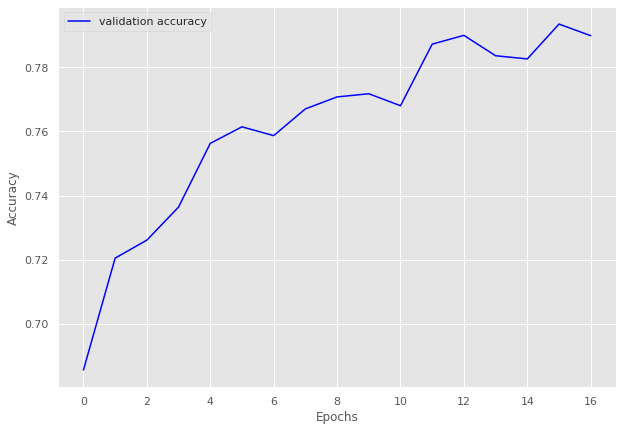

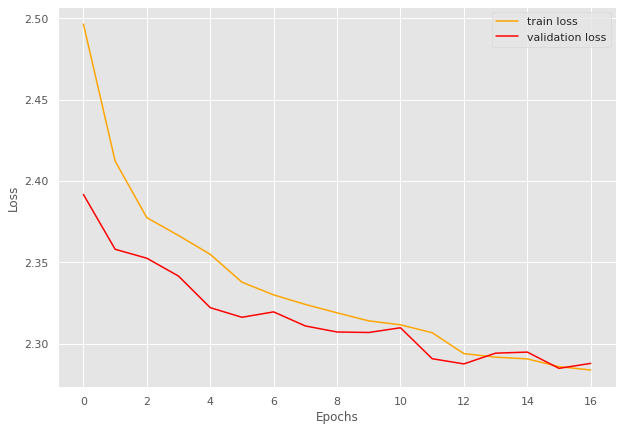

{'0': {'coarse': {'00': 0.8344144759303517, '10': 0.7350631614885627, '20': 0.6717065795249476, '30': 0.587328683607277, '50': 0.4409598595327513, '80': 0.2362093352192362}, 'fine': {'00': {'0': 0.9762140733399405, '1': 0.9764150943396226, '2': 0.9572277227722772, '3': 0.973404255319149, '4': 0.99644128113879, '5': 0.9815242494226328, '7': 0.9389619883040936, '8': 0.9871175523349437, '9': 0.8673469387755102, '11': 0.9451642060861706, '12': 0.9523012552301255, '14': 0.9555808656036446, '15': 0.9640077821011673}, '10': {'0': 0.8848780487804878, '1': 0.8422535211267606, '2': 0.8879103282626101, '3': 0.9231638418079096, '4': 0.9256505576208178, '5': 0.906885758998435, '7': 0.8858381502890174, '8': 0.9591503267973857, '9': 0.7749469214437368, '11': 0.8723911747167561, '12': 0.9203319502074688, '14': 0.8818380743982495, '15': 0.8033088235294118}, '20': {'0': 0.8442064264849075, '1': 0.7038567493112947, '2': 0.8205027494108406, '3': 0.8527889591719379, '4': 0.8386075949367089, '5': 0.80940794

100%|██████████| 102/102 [00:36<00:00,  2.79batch/s, loss=1.09]


train loss 1.0899452432697894, validation loss 1.0285617817531933, validation accuracy 0.8757142857142857
Coarse label 0 Epoch 2
-------------------------------


100%|██████████| 102/102 [00:36<00:00,  2.79batch/s, loss=1]   


train loss 1.0043421527918648, validation loss 1.020993335680528, validation accuracy 0.8814285714285715
Coarse label 0 Epoch 3
-------------------------------


100%|██████████| 102/102 [00:36<00:00,  2.77batch/s, loss=0.993]


train loss 0.9930369894878537, validation loss 1.0104447332295505, validation accuracy 0.8942857142857142
Coarse label 0 Epoch 4
-------------------------------


100%|██████████| 102/102 [00:36<00:00,  2.80batch/s, loss=0.984]


train loss 0.9842462790947334, validation loss 1.0089634277603843, validation accuracy 0.8942857142857142
Coarse label 0 Epoch 5
-------------------------------


100%|██████████| 102/102 [00:36<00:00,  2.81batch/s, loss=0.977]


train loss 0.9773073231472689, validation loss 1.0068509687076916, validation accuracy 0.8957142857142857
Coarse label 0 Epoch 6
-------------------------------


100%|██████████| 102/102 [00:37<00:00,  2.76batch/s, loss=0.977]


INFO: Early stopping counter 1 of 5
train loss 0.9772187862910476, validation loss 1.0093458945100957, validation accuracy 0.8928571428571429
Coarse label 0 Epoch 7
-------------------------------


100%|██████████| 102/102 [00:36<00:00,  2.77batch/s, loss=0.971]


train loss 0.9706906746415531, validation loss 1.0031322945247998, validation accuracy 0.9
Coarse label 0 Epoch 8
-------------------------------


100%|██████████| 102/102 [00:36<00:00,  2.76batch/s, loss=0.972]


train loss 0.9718331671228596, validation loss 0.9974098313938488, validation accuracy 0.9085714285714286
Coarse label 0 Epoch 9
-------------------------------


100%|██████████| 102/102 [00:36<00:00,  2.79batch/s, loss=0.968]


INFO: Early stopping counter 2 of 5
train loss 0.9676652410451103, validation loss 1.0005551034753972, validation accuracy 0.9014285714285715
Coarse label 0 Epoch 10
-------------------------------


100%|██████████| 102/102 [00:37<00:00,  2.76batch/s, loss=0.963]


INFO: Early stopping counter 3 of 5
train loss 0.962676104961657, validation loss 1.0018153461542996, validation accuracy 0.9014285714285715
Coarse label 0 Epoch 11
-------------------------------


100%|██████████| 102/102 [00:36<00:00,  2.78batch/s, loss=0.96]


INFO: Early stopping counter 4 of 5
train loss 0.9597165064484465, validation loss 0.9998582872477445, validation accuracy 0.9057142857142857
Coarse label 0 Epoch 12
-------------------------------


100%|██████████| 102/102 [00:39<00:00,  2.56batch/s, loss=0.956]


INFO: Early stopping counter 5 of 5
INFO: Early stopping
Done! Saved model with test accuracy 0.9049079754601227 and loss 1.0192326789810544


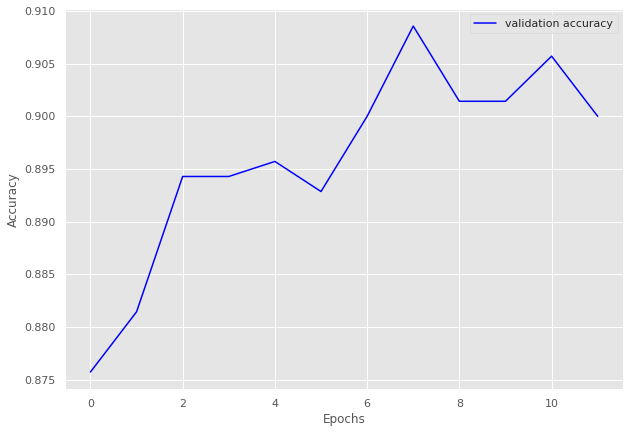

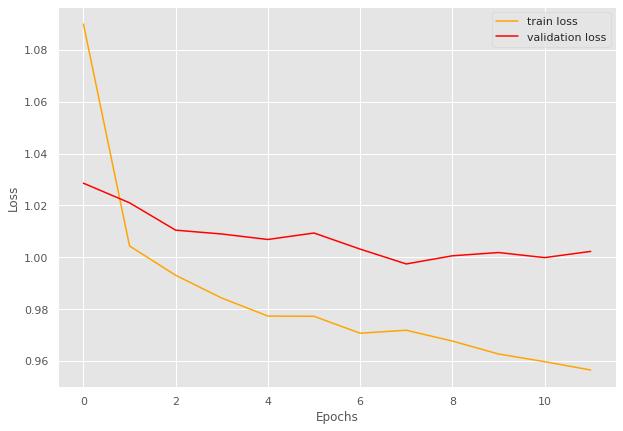

{'0': {'coarse': {'00': 0.8344144759303517, '10': 0.7350631614885627, '20': 0.6717065795249476, '30': 0.587328683607277, '50': 0.4409598595327513, '80': 0.2362093352192362}, 'fine': {'00': {'0': 0.9762140733399405, '1': 0.9764150943396226, '2': 0.9572277227722772, '3': 0.973404255319149, '4': 0.99644128113879, '5': 0.9815242494226328, '7': 0.9389619883040936, '8': 0.9871175523349437, '9': 0.8673469387755102, '11': 0.9451642060861706, '12': 0.9523012552301255, '14': 0.9555808656036446, '15': 0.9640077821011673}, '10': {'0': 0.8848780487804878, '1': 0.8422535211267606, '2': 0.8879103282626101, '3': 0.9231638418079096, '4': 0.9256505576208178, '5': 0.906885758998435, '7': 0.8858381502890174, '8': 0.9591503267973857, '9': 0.7749469214437368, '11': 0.8723911747167561, '12': 0.9203319502074688, '14': 0.8818380743982495, '15': 0.8033088235294118}, '20': {'0': 0.8442064264849075, '1': 0.7038567493112947, '2': 0.8205027494108406, '3': 0.8527889591719379, '4': 0.8386075949367089, '5': 0.80940794

100%|██████████| 53/53 [00:18<00:00,  2.81batch/s, loss=1.34]


train loss 1.3370593718762667, validation loss 1.247492003440857, validation accuracy 0.7431906614785992
Coarse label 1 Epoch 2
-------------------------------


100%|██████████| 53/53 [00:19<00:00,  2.74batch/s, loss=1.21]


train loss 1.2093338089169197, validation loss 1.2370193481445313, validation accuracy 0.7509727626459144
Coarse label 1 Epoch 3
-------------------------------


100%|██████████| 53/53 [00:18<00:00,  2.81batch/s, loss=1.17]


train loss 1.1748400566712864, validation loss 1.2293195486068726, validation accuracy 0.7587548638132295
Coarse label 1 Epoch 4
-------------------------------


100%|██████████| 53/53 [00:18<00:00,  2.81batch/s, loss=1.15]


INFO: Early stopping counter 1 of 5
train loss 1.1516131162643433, validation loss 1.233875036239624, validation accuracy 0.754863813229572
Coarse label 1 Epoch 5
-------------------------------


100%|██████████| 53/53 [00:18<00:00,  2.82batch/s, loss=1.14]


train loss 1.1404803698917605, validation loss 1.221623134613037, validation accuracy 0.7665369649805448
Coarse label 1 Epoch 6
-------------------------------


100%|██████████| 53/53 [00:18<00:00,  2.80batch/s, loss=1.13]


INFO: Early stopping counter 2 of 5
train loss 1.1308676319302253, validation loss 1.234300684928894, validation accuracy 0.77431906614786
Coarse label 1 Epoch 7
-------------------------------


100%|██████████| 53/53 [00:18<00:00,  2.79batch/s, loss=1.12]


train loss 1.1186050266589758, validation loss 1.219598364830017, validation accuracy 0.77431906614786
Coarse label 1 Epoch 8
-------------------------------


100%|██████████| 53/53 [00:19<00:00,  2.79batch/s, loss=1.11]


train loss 1.1146421882341493, validation loss 1.215773344039917, validation accuracy 0.7859922178988327
Coarse label 1 Epoch 9
-------------------------------


100%|██████████| 53/53 [00:18<00:00,  2.80batch/s, loss=1.11]


INFO: Early stopping counter 3 of 5
train loss 1.1131812379045307, validation loss 1.2414173841476441, validation accuracy 0.754863813229572
Coarse label 1 Epoch 10
-------------------------------


100%|██████████| 53/53 [00:18<00:00,  2.80batch/s, loss=1.11]


INFO: Early stopping counter 4 of 5
train loss 1.1123903539945494, validation loss 1.2464695692062377, validation accuracy 0.7431906614785992
Coarse label 1 Epoch 11
-------------------------------


100%|██████████| 53/53 [00:18<00:00,  2.82batch/s, loss=1.11]


INFO: Early stopping counter 5 of 5
INFO: Early stopping
Done! Saved model with test accuracy 0.8133561643835616 and loss 1.2870875120162963


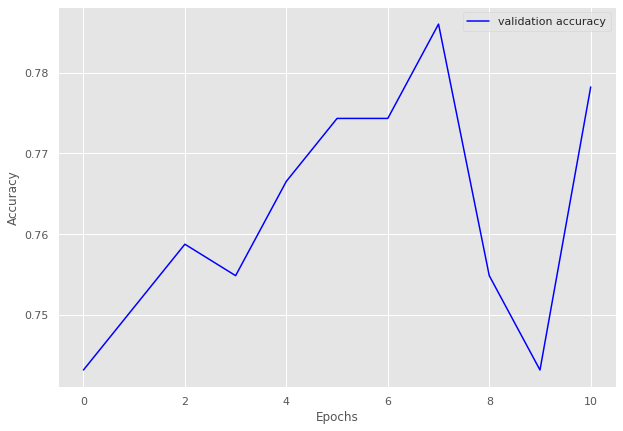

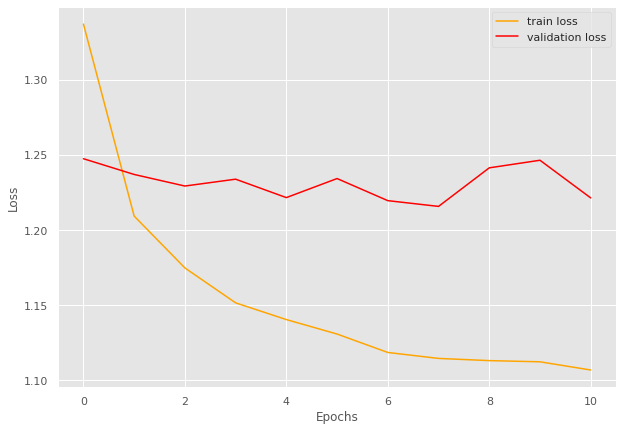

{'0': {'coarse': {'00': 0.8344144759303517, '10': 0.7350631614885627, '20': 0.6717065795249476, '30': 0.587328683607277, '50': 0.4409598595327513, '80': 0.2362093352192362}, 'fine': {'00': {'0': 0.9762140733399405, '1': 0.9764150943396226, '2': 0.9572277227722772, '3': 0.973404255319149, '4': 0.99644128113879, '5': 0.9815242494226328, '7': 0.9389619883040936, '8': 0.9871175523349437, '9': 0.8673469387755102, '11': 0.9451642060861706, '12': 0.9523012552301255, '14': 0.9555808656036446, '15': 0.9640077821011673}, '10': {'0': 0.8848780487804878, '1': 0.8422535211267606, '2': 0.8879103282626101, '3': 0.9231638418079096, '4': 0.9256505576208178, '5': 0.906885758998435, '7': 0.8858381502890174, '8': 0.9591503267973857, '9': 0.7749469214437368, '11': 0.8723911747167561, '12': 0.9203319502074688, '14': 0.8818380743982495, '15': 0.8033088235294118}, '20': {'0': 0.8442064264849075, '1': 0.7038567493112947, '2': 0.8205027494108406, '3': 0.8527889591719379, '4': 0.8386075949367089, '5': 0.80940794

100%|██████████| 207/207 [01:14<00:00,  2.78batch/s, loss=1.68]


train loss 1.6805318196614583, validation loss 1.5923874491737002, validation accuracy 0.8692077727952168
Coarse label 2 Epoch 2
-------------------------------


100%|██████████| 207/207 [01:14<00:00,  2.77batch/s, loss=1.59]


train loss 1.5885646233812047, validation loss 1.5670388312566847, validation accuracy 0.8961136023916293
Coarse label 2 Epoch 3
-------------------------------


100%|██████████| 207/207 [01:14<00:00,  2.77batch/s, loss=1.57]


INFO: Early stopping counter 1 of 5
train loss 1.5746691261512646, validation loss 1.577856529326666, validation accuracy 0.8849028400597907
Coarse label 2 Epoch 4
-------------------------------


100%|██████████| 207/207 [01:14<00:00,  2.79batch/s, loss=1.56]


INFO: Early stopping counter 2 of 5
train loss 1.5628177906580016, validation loss 1.5770863805498396, validation accuracy 0.882660687593423
Coarse label 2 Epoch 5
-------------------------------


100%|██████████| 207/207 [01:15<00:00,  2.75batch/s, loss=1.55]


train loss 1.5534823844974168, validation loss 1.5592720678874425, validation accuracy 0.9020926756352765
Coarse label 2 Epoch 6
-------------------------------


100%|██████████| 207/207 [01:14<00:00,  2.78batch/s, loss=1.55]


train loss 1.5464170554985748, validation loss 1.5573829525992984, validation accuracy 0.9050822122571002
Coarse label 2 Epoch 7
-------------------------------


100%|██████████| 207/207 [01:14<00:00,  2.78batch/s, loss=1.54]


train loss 1.5447713280645545, validation loss 1.5534394979476929, validation accuracy 0.9073243647234679
Coarse label 2 Epoch 8
-------------------------------


100%|██████████| 207/207 [01:18<00:00,  2.64batch/s, loss=1.54]


INFO: Early stopping counter 3 of 5
train loss 1.5425726106201394, validation loss 1.5536519175484067, validation accuracy 0.906576980568012
Coarse label 2 Epoch 9
-------------------------------


100%|██████████| 207/207 [02:35<00:00,  1.33batch/s, loss=1.54]


train loss 1.5380693299758836, validation loss 1.547935922940572, validation accuracy 0.9133034379671151
Coarse label 2 Epoch 10
-------------------------------


100%|██████████| 207/207 [01:31<00:00,  2.26batch/s, loss=1.54]


INFO: Early stopping counter 4 of 5
train loss 1.5365023411414473, validation loss 1.5508688461212885, validation accuracy 0.9103139013452914
Coarse label 2 Epoch 11
-------------------------------


100%|██████████| 207/207 [01:14<00:00,  2.78batch/s, loss=1.53]


INFO: Early stopping counter 5 of 5
INFO: Early stopping
Done! Saved model with test accuracy 0.8734828981243105 and loss 1.5923606600872307


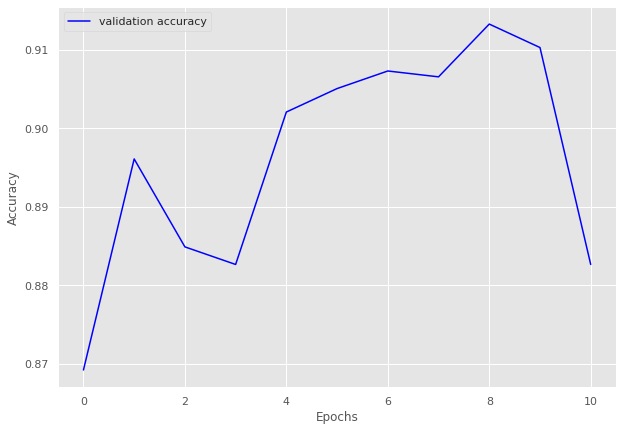

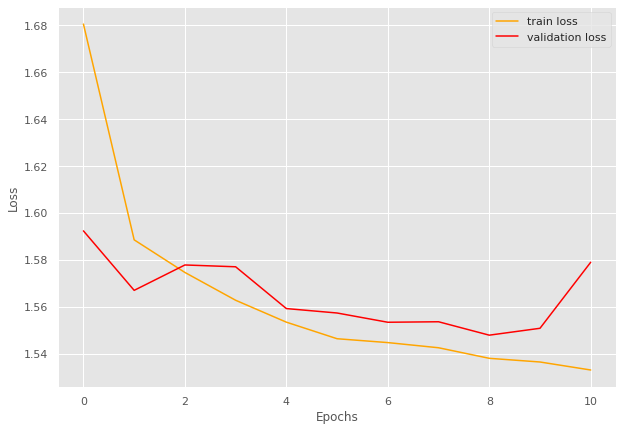

{'0': {'coarse': {'00': 0.8344144759303517, '10': 0.7350631614885627, '20': 0.6717065795249476, '30': 0.587328683607277, '50': 0.4409598595327513, '80': 0.2362093352192362}, 'fine': {'00': {'0': 0.9762140733399405, '1': 0.9764150943396226, '2': 0.9572277227722772, '3': 0.973404255319149, '4': 0.99644128113879, '5': 0.9815242494226328, '7': 0.9389619883040936, '8': 0.9871175523349437, '9': 0.8673469387755102, '11': 0.9451642060861706, '12': 0.9523012552301255, '14': 0.9555808656036446, '15': 0.9640077821011673}, '10': {'0': 0.8848780487804878, '1': 0.8422535211267606, '2': 0.8879103282626101, '3': 0.9231638418079096, '4': 0.9256505576208178, '5': 0.906885758998435, '7': 0.8858381502890174, '8': 0.9591503267973857, '9': 0.7749469214437368, '11': 0.8723911747167561, '12': 0.9203319502074688, '14': 0.8818380743982495, '15': 0.8033088235294118}, '20': {'0': 0.8442064264849075, '1': 0.7038567493112947, '2': 0.8205027494108406, '3': 0.8527889591719379, '4': 0.8386075949367089, '5': 0.80940794

100%|██████████| 100/100 [00:35<00:00,  2.81batch/s, loss=1.29]


train loss 1.289940766096115, validation loss 1.15484619140625, validation accuracy 0.8938714499252616
Coarse label 4 Epoch 2
-------------------------------


100%|██████████| 100/100 [00:36<00:00,  2.74batch/s, loss=1.18]


train loss 1.175653110742569, validation loss 1.1461528973145918, validation accuracy 0.8968609865470852
Coarse label 4 Epoch 3
-------------------------------


100%|██████████| 100/100 [00:35<00:00,  2.80batch/s, loss=1.14]


train loss 1.1434103238582611, validation loss 1.1445431275801226, validation accuracy 0.9043348281016442
Coarse label 4 Epoch 4
-------------------------------


100%|██████████| 100/100 [00:35<00:00,  2.81batch/s, loss=1.14]


train loss 1.1352792906761169, validation loss 1.134516802701083, validation accuracy 0.905829596412556
Coarse label 4 Epoch 5
-------------------------------


100%|██████████| 100/100 [00:35<00:00,  2.80batch/s, loss=1.13]


INFO: Early stopping counter 1 of 5
train loss 1.1251587963104248, validation loss 1.1374893188476562, validation accuracy 0.9088191330343797
Coarse label 4 Epoch 6
-------------------------------


100%|██████████| 100/100 [00:35<00:00,  2.84batch/s, loss=1.12]


INFO: Early stopping counter 2 of 5
train loss 1.1206719744205476, validation loss 1.1430153413252397, validation accuracy 0.9013452914798207
Coarse label 4 Epoch 7
-------------------------------


100%|██████████| 100/100 [00:35<00:00,  2.81batch/s, loss=1.12]


INFO: Early stopping counter 3 of 5
train loss 1.1175786328315735, validation loss 1.1415701129219749, validation accuracy 0.9043348281016442
Coarse label 4 Epoch 8
-------------------------------


100%|██████████| 100/100 [00:35<00:00,  2.81batch/s, loss=1.11]


INFO: Early stopping counter 4 of 5
train loss 1.1125040137767792, validation loss 1.140274622223594, validation accuracy 0.9028400597907325
Coarse label 4 Epoch 9
-------------------------------


100%|██████████| 100/100 [00:35<00:00,  2.84batch/s, loss=1.11]


INFO: Early stopping counter 5 of 5
INFO: Early stopping
Done! Saved model with test accuracy 0.8889763779527559 and loss 1.155607932806015


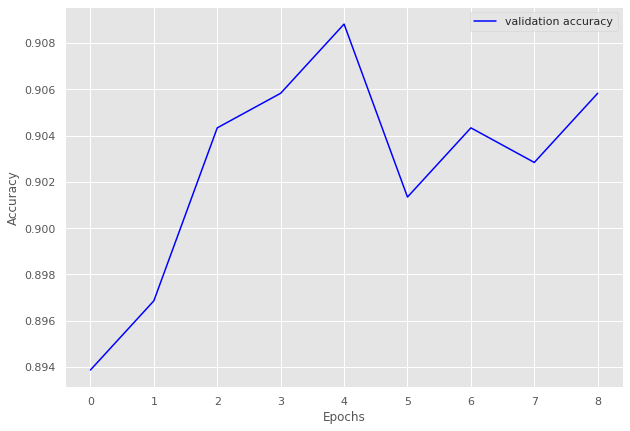

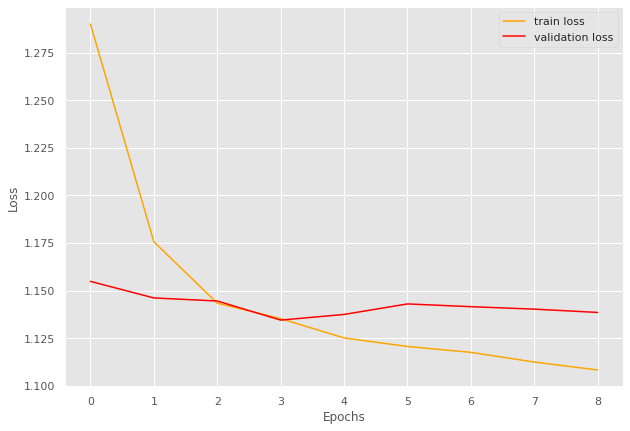

{'0': {'coarse': {'00': 0.8344144759303517, '10': 0.7350631614885627, '20': 0.6717065795249476, '30': 0.587328683607277, '50': 0.4409598595327513, '80': 0.2362093352192362}, 'fine': {'00': {'0': 0.9762140733399405, '1': 0.9764150943396226, '2': 0.9572277227722772, '3': 0.973404255319149, '4': 0.99644128113879, '5': 0.9815242494226328, '7': 0.9389619883040936, '8': 0.9871175523349437, '9': 0.8673469387755102, '11': 0.9451642060861706, '12': 0.9523012552301255, '14': 0.9555808656036446, '15': 0.9640077821011673}, '10': {'0': 0.8848780487804878, '1': 0.8422535211267606, '2': 0.8879103282626101, '3': 0.9231638418079096, '4': 0.9256505576208178, '5': 0.906885758998435, '7': 0.8858381502890174, '8': 0.9591503267973857, '9': 0.7749469214437368, '11': 0.8723911747167561, '12': 0.9203319502074688, '14': 0.8818380743982495, '15': 0.8033088235294118}, '20': {'0': 0.8442064264849075, '1': 0.7038567493112947, '2': 0.8205027494108406, '3': 0.8527889591719379, '4': 0.8386075949367089, '5': 0.80940794

100%|██████████| 40/40 [00:14<00:00,  2.77batch/s, loss=0.411]


train loss 0.411350354552269, validation loss 0.3585231403509776, validation accuracy 0.952054794520548
Coarse label 5 Epoch 2
-------------------------------


100%|██████████| 40/40 [00:14<00:00,  2.83batch/s, loss=0.348]


INFO: Early stopping counter 1 of 5
train loss 0.3482062160968781, validation loss 0.3628040949503581, validation accuracy 0.9452054794520548
Coarse label 5 Epoch 3
-------------------------------


100%|██████████| 40/40 [00:14<00:00,  2.80batch/s, loss=0.339]


train loss 0.33864285200834277, validation loss 0.3559045195579529, validation accuracy 0.9452054794520548
Coarse label 5 Epoch 4
-------------------------------


100%|██████████| 40/40 [00:14<00:00,  2.80batch/s, loss=0.332]


INFO: Early stopping counter 2 of 5
train loss 0.33229908496141436, validation loss 0.3681456844011943, validation accuracy 0.9246575342465754
Coarse label 5 Epoch 5
-------------------------------


100%|██████████| 40/40 [00:14<00:00,  2.85batch/s, loss=0.333]


INFO: Early stopping counter 3 of 5
train loss 0.33303327485919, validation loss 0.3599156041940053, validation accuracy 0.9452054794520548
Coarse label 5 Epoch 6
-------------------------------


100%|██████████| 40/40 [00:14<00:00,  2.83batch/s, loss=0.331]


INFO: Early stopping counter 4 of 5
train loss 0.3312836691737175, validation loss 0.3625500798225403, validation accuracy 0.9315068493150684
Coarse label 5 Epoch 7
-------------------------------


100%|██████████| 40/40 [00:14<00:00,  2.84batch/s, loss=0.332]


INFO: Early stopping counter 5 of 5
INFO: Early stopping
Done! Saved model with test accuracy 0.9408033826638478 and loss 0.3827257826924324


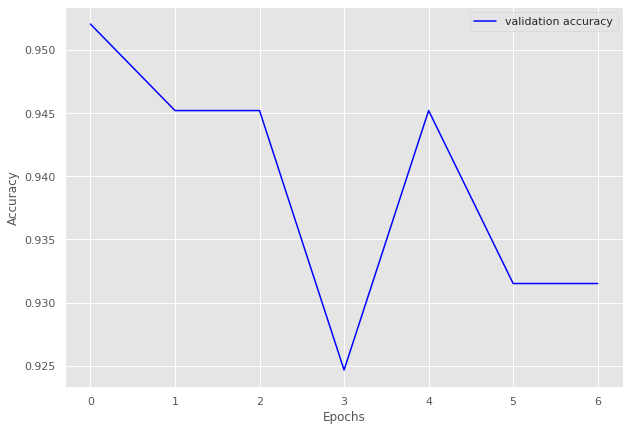

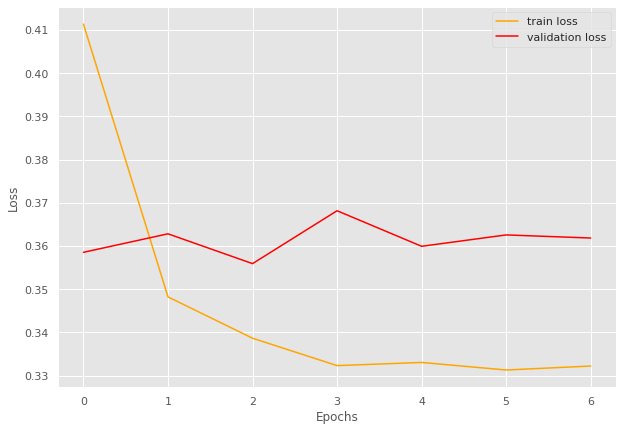

{'0': {'coarse': {'00': 0.8344144759303517, '10': 0.7350631614885627, '20': 0.6717065795249476, '30': 0.587328683607277, '50': 0.4409598595327513, '80': 0.2362093352192362}, 'fine': {'00': {'0': 0.9762140733399405, '1': 0.9764150943396226, '2': 0.9572277227722772, '3': 0.973404255319149, '4': 0.99644128113879, '5': 0.9815242494226328, '7': 0.9389619883040936, '8': 0.9871175523349437, '9': 0.8673469387755102, '11': 0.9451642060861706, '12': 0.9523012552301255, '14': 0.9555808656036446, '15': 0.9640077821011673}, '10': {'0': 0.8848780487804878, '1': 0.8422535211267606, '2': 0.8879103282626101, '3': 0.9231638418079096, '4': 0.9256505576208178, '5': 0.906885758998435, '7': 0.8858381502890174, '8': 0.9591503267973857, '9': 0.7749469214437368, '11': 0.8723911747167561, '12': 0.9203319502074688, '14': 0.8818380743982495, '15': 0.8033088235294118}, '20': {'0': 0.8442064264849075, '1': 0.7038567493112947, '2': 0.8205027494108406, '3': 0.8527889591719379, '4': 0.8386075949367089, '5': 0.80940794

100%|██████████| 111/111 [00:39<00:00,  2.81batch/s, loss=1.38]


train loss 1.3795673202823948, validation loss 1.2874904229090764, validation accuracy 0.8719898605830165
Coarse label 6 Epoch 2
-------------------------------


100%|██████████| 111/111 [00:39<00:00,  2.79batch/s, loss=1.29]


train loss 1.2920607672081337, validation loss 1.2639730710249681, validation accuracy 0.9036755386565273
Coarse label 6 Epoch 3
-------------------------------


100%|██████████| 111/111 [00:40<00:00,  2.74batch/s, loss=1.27]


INFO: Early stopping counter 1 of 5
train loss 1.2710089189512235, validation loss 1.278236563389118, validation accuracy 0.8846641318124208
Coarse label 6 Epoch 4
-------------------------------


100%|██████████| 111/111 [00:40<00:00,  2.77batch/s, loss=1.26]


INFO: Early stopping counter 2 of 5
train loss 1.262125165612848, validation loss 1.2677713907681978, validation accuracy 0.8948035487959443
Coarse label 6 Epoch 5
-------------------------------


100%|██████████| 111/111 [00:40<00:00,  2.75batch/s, loss=1.25]


INFO: Early stopping counter 3 of 5
train loss 1.2544472271257692, validation loss 1.2775770425796509, validation accuracy 0.8846641318124208
Coarse label 6 Epoch 6
-------------------------------


100%|██████████| 111/111 [00:39<00:00,  2.78batch/s, loss=1.25]


INFO: Early stopping counter 4 of 5
train loss 1.246691023981249, validation loss 1.267680626649123, validation accuracy 0.8935361216730038
Coarse label 6 Epoch 7
-------------------------------


100%|██████████| 111/111 [00:40<00:00,  2.73batch/s, loss=1.24]


INFO: Early stopping counter 5 of 5
INFO: Early stopping
Done! Saved model with test accuracy 0.8600964851826327 and loss 1.3163096438283506


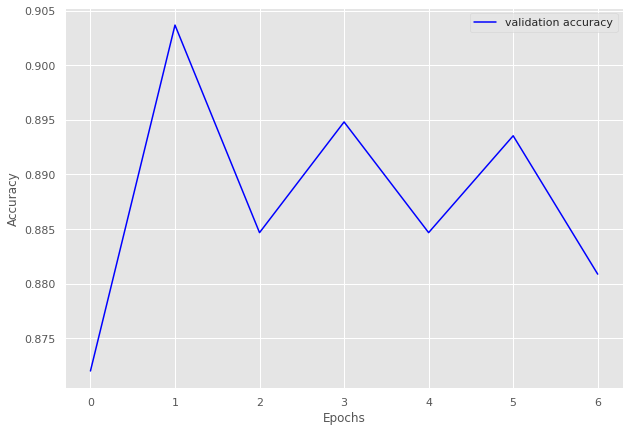

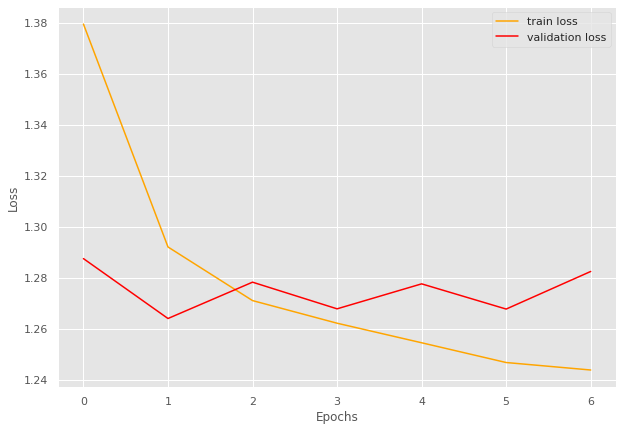

{'0': {'coarse': {'00': 0.8344144759303517, '10': 0.7350631614885627, '20': 0.6717065795249476, '30': 0.587328683607277, '50': 0.4409598595327513, '80': 0.2362093352192362}, 'fine': {'00': {'0': 0.9762140733399405, '1': 0.9764150943396226, '2': 0.9572277227722772, '3': 0.973404255319149, '4': 0.99644128113879, '5': 0.9815242494226328, '7': 0.9389619883040936, '8': 0.9871175523349437, '9': 0.8673469387755102, '11': 0.9451642060861706, '12': 0.9523012552301255, '14': 0.9555808656036446, '15': 0.9640077821011673}, '10': {'0': 0.8848780487804878, '1': 0.8422535211267606, '2': 0.8879103282626101, '3': 0.9231638418079096, '4': 0.9256505576208178, '5': 0.906885758998435, '7': 0.8858381502890174, '8': 0.9591503267973857, '9': 0.7749469214437368, '11': 0.8723911747167561, '12': 0.9203319502074688, '14': 0.8818380743982495, '15': 0.8033088235294118}, '20': {'0': 0.8442064264849075, '1': 0.7038567493112947, '2': 0.8205027494108406, '3': 0.8527889591719379, '4': 0.8386075949367089, '5': 0.80940794

100%|██████████| 86/86 [00:30<00:00,  2.79batch/s, loss=0.871]


train loss 0.8709717968175578, validation loss 0.7981285572052002, validation accuracy 0.940068493150685
Coarse label 7 Epoch 2
-------------------------------


100%|██████████| 86/86 [00:32<00:00,  2.67batch/s, loss=0.809]


INFO: Early stopping counter 1 of 5
train loss 0.809398177751275, validation loss 0.802220630645752, validation accuracy 0.9315068493150684
Coarse label 7 Epoch 3
-------------------------------


100%|██████████| 86/86 [00:30<00:00,  2.80batch/s, loss=0.799]


train loss 0.7986285596392876, validation loss 0.78885537981987, validation accuracy 0.952054794520548
Coarse label 7 Epoch 4
-------------------------------


100%|██████████| 86/86 [00:31<00:00,  2.69batch/s, loss=0.793]


INFO: Early stopping counter 2 of 5
train loss 0.792641413073207, validation loss 0.7945349335670471, validation accuracy 0.9417808219178082
Coarse label 7 Epoch 5
-------------------------------


100%|██████████| 86/86 [00:30<00:00,  2.80batch/s, loss=0.784]


INFO: Early stopping counter 3 of 5
train loss 0.7838787900847058, validation loss 0.7944847702980041, validation accuracy 0.946917808219178
Coarse label 7 Epoch 6
-------------------------------


100%|██████████| 86/86 [00:30<00:00,  2.80batch/s, loss=0.783]


INFO: Early stopping counter 4 of 5
train loss 0.7830045950967212, validation loss 0.7936863720417022, validation accuracy 0.9452054794520548
Coarse label 7 Epoch 7
-------------------------------


100%|██████████| 86/86 [00:34<00:00,  2.46batch/s, loss=0.78] 


INFO: Early stopping counter 5 of 5
INFO: Early stopping
Done! Saved model with test accuracy 0.9155188246097337 and loss 0.8761871324645149


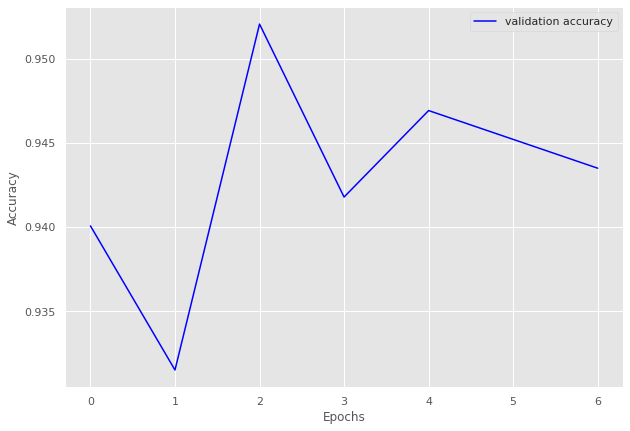

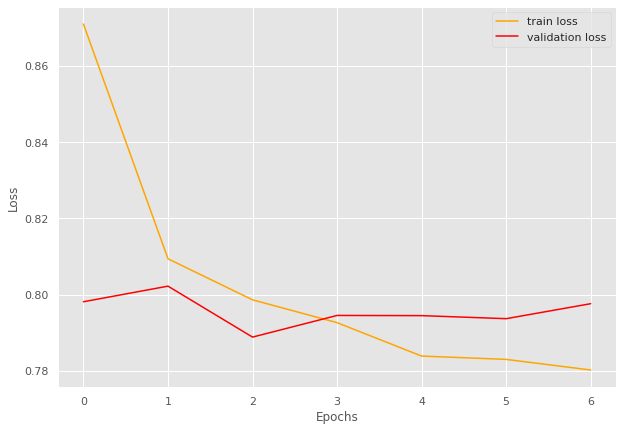

{'0': {'coarse': {'00': 0.8344144759303517, '10': 0.7350631614885627, '20': 0.6717065795249476, '30': 0.587328683607277, '50': 0.4409598595327513, '80': 0.2362093352192362}, 'fine': {'00': {'0': 0.9762140733399405, '1': 0.9764150943396226, '2': 0.9572277227722772, '3': 0.973404255319149, '4': 0.99644128113879, '5': 0.9815242494226328, '7': 0.9389619883040936, '8': 0.9871175523349437, '9': 0.8673469387755102, '11': 0.9451642060861706, '12': 0.9523012552301255, '14': 0.9555808656036446, '15': 0.9640077821011673}, '10': {'0': 0.8848780487804878, '1': 0.8422535211267606, '2': 0.8879103282626101, '3': 0.9231638418079096, '4': 0.9256505576208178, '5': 0.906885758998435, '7': 0.8858381502890174, '8': 0.9591503267973857, '9': 0.7749469214437368, '11': 0.8723911747167561, '12': 0.9203319502074688, '14': 0.8818380743982495, '15': 0.8033088235294118}, '20': {'0': 0.8442064264849075, '1': 0.7038567493112947, '2': 0.8205027494108406, '3': 0.8527889591719379, '4': 0.8386075949367089, '5': 0.80940794

100%|██████████| 130/130 [00:47<00:00,  2.74batch/s, loss=1.38]


train loss 1.3824708140813387, validation loss 1.3526456554730732, validation accuracy 0.8162162162162162
Coarse label 8 Epoch 2
-------------------------------


100%|██████████| 130/130 [00:47<00:00,  2.74batch/s, loss=1.29]


train loss 1.2890266079169053, validation loss 1.3263094623883565, validation accuracy 0.8351351351351352
Coarse label 8 Epoch 3
-------------------------------


100%|██████████| 130/130 [00:46<00:00,  2.79batch/s, loss=1.27]


INFO: Early stopping counter 1 of 5
train loss 1.2694604800297664, validation loss 1.3283589680989583, validation accuracy 0.8297297297297297
Coarse label 8 Epoch 4
-------------------------------


100%|██████████| 130/130 [00:46<00:00,  2.78batch/s, loss=1.26]


train loss 1.255788972744575, validation loss 1.3223429322242737, validation accuracy 0.8405405405405405
Coarse label 8 Epoch 5
-------------------------------


100%|██████████| 130/130 [00:47<00:00,  2.76batch/s, loss=1.25]


train loss 1.2491240721482497, validation loss 1.3122596144676208, validation accuracy 0.8567567567567568
Coarse label 8 Epoch 6
-------------------------------


100%|██████████| 130/130 [00:46<00:00,  2.78batch/s, loss=1.25]


train loss 1.24589446416268, validation loss 1.3028920491536458, validation accuracy 0.8594594594594595
Coarse label 8 Epoch 7
-------------------------------


100%|██████████| 130/130 [00:46<00:00,  2.78batch/s, loss=1.25]


INFO: Early stopping counter 2 of 5
train loss 1.2492119303116431, validation loss 1.3030473987261455, validation accuracy 0.8594594594594595
Coarse label 8 Epoch 8
-------------------------------


100%|██████████| 130/130 [00:46<00:00,  2.79batch/s, loss=1.24]


INFO: Early stopping counter 3 of 5
train loss 1.2405332079300513, validation loss 1.3190101782480876, validation accuracy 0.8432432432432433
Coarse label 8 Epoch 9
-------------------------------


100%|██████████| 130/130 [00:46<00:00,  2.79batch/s, loss=1.24]


INFO: Early stopping counter 4 of 5
train loss 1.236391690144172, validation loss 1.320999523003896, validation accuracy 0.8378378378378378
Coarse label 8 Epoch 10
-------------------------------


100%|██████████| 130/130 [00:46<00:00,  2.79batch/s, loss=1.23]


INFO: Early stopping counter 5 of 5
INFO: Early stopping
Done! Saved model with test accuracy 0.8759351620947631 and loss 1.3186639959995563


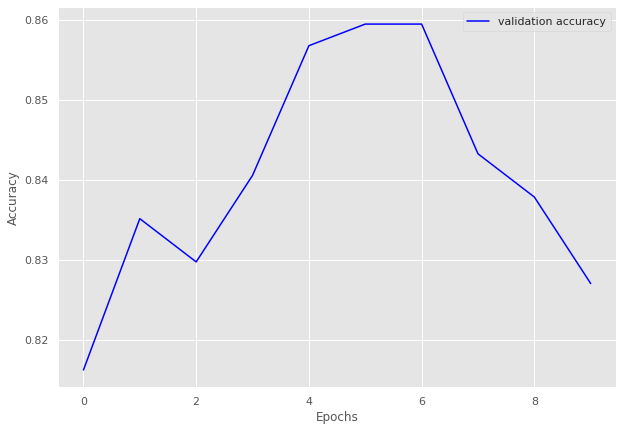

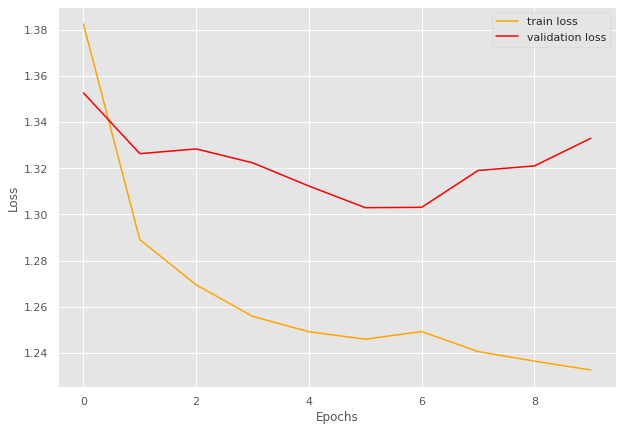

{'0': {'coarse': {'00': 0.8344144759303517, '10': 0.7350631614885627, '20': 0.6717065795249476, '30': 0.587328683607277, '50': 0.4409598595327513, '80': 0.2362093352192362}, 'fine': {'00': {'0': 0.9762140733399405, '1': 0.9764150943396226, '2': 0.9572277227722772, '3': 0.973404255319149, '4': 0.99644128113879, '5': 0.9815242494226328, '7': 0.9389619883040936, '8': 0.9871175523349437, '9': 0.8673469387755102, '11': 0.9451642060861706, '12': 0.9523012552301255, '14': 0.9555808656036446, '15': 0.9640077821011673}, '10': {'0': 0.8848780487804878, '1': 0.8422535211267606, '2': 0.8879103282626101, '3': 0.9231638418079096, '4': 0.9256505576208178, '5': 0.906885758998435, '7': 0.8858381502890174, '8': 0.9591503267973857, '9': 0.7749469214437368, '11': 0.8723911747167561, '12': 0.9203319502074688, '14': 0.8818380743982495, '15': 0.8033088235294118}, '20': {'0': 0.8442064264849075, '1': 0.7038567493112947, '2': 0.8205027494108406, '3': 0.8527889591719379, '4': 0.8386075949367089, '5': 0.80940794

100%|██████████| 161/161 [00:58<00:00,  2.75batch/s, loss=1.69]


train loss 1.6901325794480602, validation loss 1.6083899310656957, validation accuracy 0.8465974625144176
Coarse label 9 Epoch 2
-------------------------------


100%|██████████| 161/161 [01:18<00:00,  2.05batch/s, loss=1.6]


train loss 1.5968671341120086, validation loss 1.5956650546618871, validation accuracy 0.8615916955017301
Coarse label 9 Epoch 3
-------------------------------


100%|██████████| 161/161 [02:13<00:00,  1.21batch/s, loss=1.58]


train loss 1.5777010258680546, validation loss 1.5859060287475586, validation accuracy 0.8708189158016147
Coarse label 9 Epoch 4
-------------------------------


100%|██████████| 161/161 [01:05<00:00,  2.46batch/s, loss=1.57]


INFO: Early stopping counter 1 of 5
train loss 1.5664153824681821, validation loss 1.592449196747371, validation accuracy 0.8662053056516724
Coarse label 9 Epoch 5
-------------------------------


100%|██████████| 161/161 [00:58<00:00,  2.76batch/s, loss=1.56]


train loss 1.5584333061431506, validation loss 1.5785396099090576, validation accuracy 0.8800461361014994
Coarse label 9 Epoch 6
-------------------------------


100%|██████████| 161/161 [00:58<00:00,  2.77batch/s, loss=1.56]


INFO: Early stopping counter 2 of 5
train loss 1.5559420689292576, validation loss 1.5789983442851476, validation accuracy 0.8788927335640139
Coarse label 9 Epoch 7
-------------------------------


100%|██████████| 161/161 [00:57<00:00,  2.79batch/s, loss=1.55]


INFO: Early stopping counter 3 of 5
train loss 1.5470845617862963, validation loss 1.5843808565820967, validation accuracy 0.8754325259515571
Coarse label 9 Epoch 8
-------------------------------


100%|██████████| 161/161 [00:58<00:00,  2.73batch/s, loss=1.55]


train loss 1.5501350616075977, validation loss 1.5763458013534546, validation accuracy 0.8800461361014994
Coarse label 9 Epoch 9
-------------------------------


100%|██████████| 161/161 [00:57<00:00,  2.78batch/s, loss=1.54]


INFO: Early stopping counter 4 of 5
train loss 1.5397587074256092, validation loss 1.5785529528345381, validation accuracy 0.881199538638985
Coarse label 9 Epoch 10
-------------------------------


100%|██████████| 161/161 [00:57<00:00,  2.78batch/s, loss=1.54]


INFO: Early stopping counter 5 of 5
INFO: Early stopping
Done! Saved model with test accuracy 0.8671717171717171 and loss 1.5939620233351184


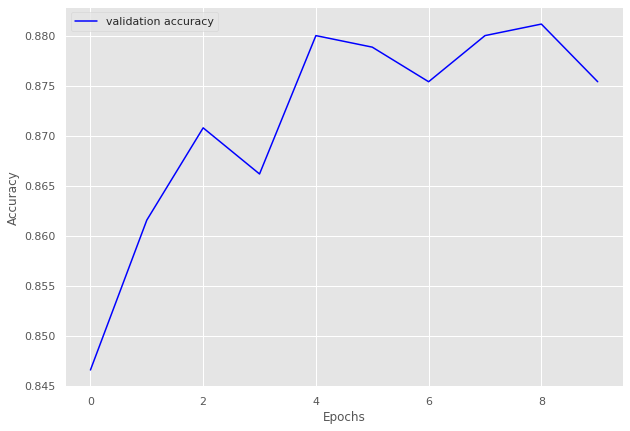

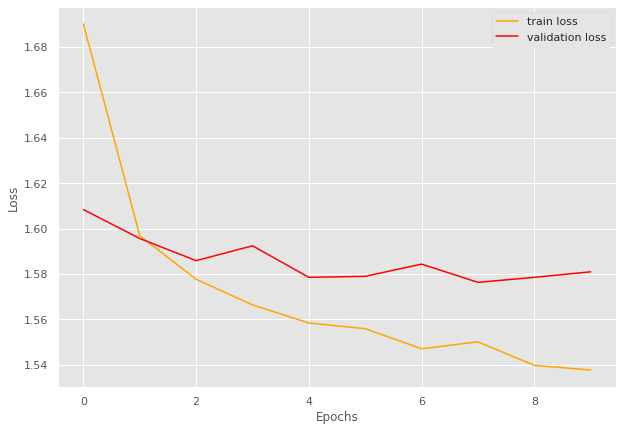

{'0': {'coarse': {'00': 0.8344144759303517, '10': 0.7350631614885627, '20': 0.6717065795249476, '30': 0.587328683607277, '50': 0.4409598595327513, '80': 0.2362093352192362}, 'fine': {'00': {'0': 0.9762140733399405, '1': 0.9764150943396226, '2': 0.9572277227722772, '3': 0.973404255319149, '4': 0.99644128113879, '5': 0.9815242494226328, '7': 0.9389619883040936, '8': 0.9871175523349437, '9': 0.8673469387755102, '11': 0.9451642060861706, '12': 0.9523012552301255, '14': 0.9555808656036446, '15': 0.9640077821011673}, '10': {'0': 0.8848780487804878, '1': 0.8422535211267606, '2': 0.8879103282626101, '3': 0.9231638418079096, '4': 0.9256505576208178, '5': 0.906885758998435, '7': 0.8858381502890174, '8': 0.9591503267973857, '9': 0.7749469214437368, '11': 0.8723911747167561, '12': 0.9203319502074688, '14': 0.8818380743982495, '15': 0.8033088235294118}, '20': {'0': 0.8442064264849075, '1': 0.7038567493112947, '2': 0.8205027494108406, '3': 0.8527889591719379, '4': 0.8386075949367089, '5': 0.80940794

100%|██████████| 73/73 [00:26<00:00,  2.79batch/s, loss=0.893]


train loss 0.8931511240462734, validation loss 0.8126261606812477, validation accuracy 0.9321357285429142
Coarse label 11 Epoch 2
-------------------------------


100%|██████████| 73/73 [00:26<00:00,  2.76batch/s, loss=0.811]


train loss 0.8107100153622562, validation loss 0.8048048764467239, validation accuracy 0.936127744510978
Coarse label 11 Epoch 3
-------------------------------


100%|██████████| 73/73 [00:26<00:00,  2.78batch/s, loss=0.797]


INFO: Early stopping counter 1 of 5
train loss 0.796754826421607, validation loss 0.8122842460870743, validation accuracy 0.9321357285429142
Coarse label 11 Epoch 4
-------------------------------


100%|██████████| 73/73 [00:26<00:00,  2.78batch/s, loss=0.787]


INFO: Early stopping counter 2 of 5
train loss 0.7868792553470559, validation loss 0.8076776340603828, validation accuracy 0.936127744510978
Coarse label 11 Epoch 5
-------------------------------


100%|██████████| 73/73 [00:29<00:00,  2.48batch/s, loss=0.782]


INFO: Early stopping counter 3 of 5
train loss 0.7815502147151999, validation loss 0.8060069605708122, validation accuracy 0.936127744510978
Coarse label 11 Epoch 6
-------------------------------


100%|██████████| 73/73 [00:26<00:00,  2.80batch/s, loss=0.778]


train loss 0.7777925313335575, validation loss 0.8029173910617828, validation accuracy 0.9401197604790419
Coarse label 11 Epoch 7
-------------------------------


100%|██████████| 73/73 [00:26<00:00,  2.75batch/s, loss=0.777]


INFO: Early stopping counter 4 of 5
train loss 0.7766053970545939, validation loss 0.8080610409379005, validation accuracy 0.936127744510978
Coarse label 11 Epoch 8
-------------------------------


100%|██████████| 73/73 [00:26<00:00,  2.76batch/s, loss=0.771]


INFO: Early stopping counter 5 of 5
INFO: Early stopping
Done! Saved model with test accuracy 0.9150837988826815 and loss 0.8252186732632774


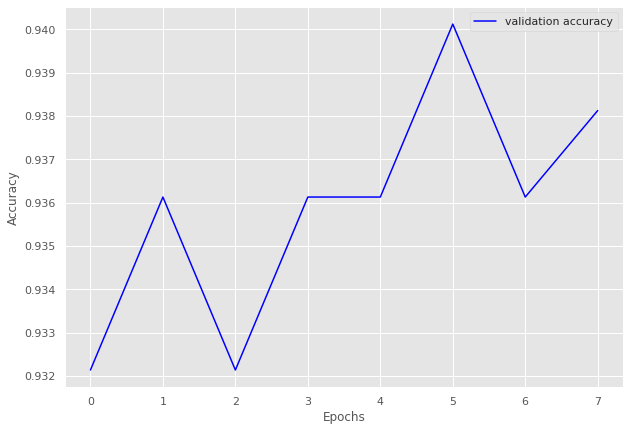

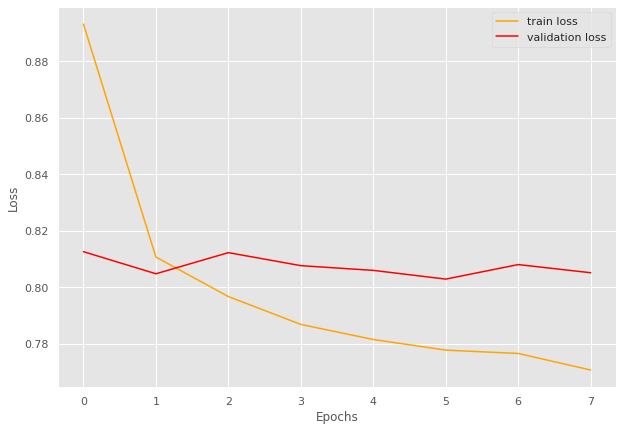

{'0': {'coarse': {'00': 0.8344144759303517, '10': 0.7350631614885627, '20': 0.6717065795249476, '30': 0.587328683607277, '50': 0.4409598595327513, '80': 0.2362093352192362}, 'fine': {'00': {'0': 0.9762140733399405, '1': 0.9764150943396226, '2': 0.9572277227722772, '3': 0.973404255319149, '4': 0.99644128113879, '5': 0.9815242494226328, '7': 0.9389619883040936, '8': 0.9871175523349437, '9': 0.8673469387755102, '11': 0.9451642060861706, '12': 0.9523012552301255, '14': 0.9555808656036446, '15': 0.9640077821011673}, '10': {'0': 0.8848780487804878, '1': 0.8422535211267606, '2': 0.8879103282626101, '3': 0.9231638418079096, '4': 0.9256505576208178, '5': 0.906885758998435, '7': 0.8858381502890174, '8': 0.9591503267973857, '9': 0.7749469214437368, '11': 0.8723911747167561, '12': 0.9203319502074688, '14': 0.8818380743982495, '15': 0.8033088235294118}, '20': {'0': 0.8442064264849075, '1': 0.7038567493112947, '2': 0.8205027494108406, '3': 0.8527889591719379, '4': 0.8386075949367089, '5': 0.80940794

100%|██████████| 75/75 [00:26<00:00,  2.80batch/s, loss=1.32]


train loss 1.3209971650441488, validation loss 1.2240358080182756, validation accuracy 0.8200455580865603
Coarse label 12 Epoch 2
-------------------------------


100%|██████████| 75/75 [00:26<00:00,  2.82batch/s, loss=1.2] 


train loss 1.2029152202606201, validation loss 1.2147227014814104, validation accuracy 0.8223234624145785
Coarse label 12 Epoch 3
-------------------------------


100%|██████████| 75/75 [00:27<00:00,  2.75batch/s, loss=1.17]


train loss 1.1725255393981933, validation loss 1.2085975749152047, validation accuracy 0.835990888382688
Coarse label 12 Epoch 4
-------------------------------


100%|██████████| 75/75 [00:26<00:00,  2.79batch/s, loss=1.15]


train loss 1.1531746451059977, validation loss 1.199869189943586, validation accuracy 0.8428246013667426
Coarse label 12 Epoch 5
-------------------------------


100%|██████████| 75/75 [00:26<00:00,  2.82batch/s, loss=1.14]


INFO: Early stopping counter 1 of 5
train loss 1.1358860985438028, validation loss 1.202826874596732, validation accuracy 0.8382687927107062
Coarse label 12 Epoch 6
-------------------------------


100%|██████████| 75/75 [00:26<00:00,  2.85batch/s, loss=1.13]


train loss 1.1339345328013102, validation loss 1.1985792773110526, validation accuracy 0.8473804100227791
Coarse label 12 Epoch 7
-------------------------------


100%|██████████| 75/75 [00:26<00:00,  2.82batch/s, loss=1.13]


INFO: Early stopping counter 2 of 5
train loss 1.1323429044087727, validation loss 1.2065623998641968, validation accuracy 0.8382687927107062
Coarse label 12 Epoch 8
-------------------------------


100%|██████████| 75/75 [00:26<00:00,  2.85batch/s, loss=1.13]


INFO: Early stopping counter 3 of 5
train loss 1.1256801986694336, validation loss 1.208190952028547, validation accuracy 0.835990888382688
Coarse label 12 Epoch 9
-------------------------------


100%|██████████| 75/75 [00:26<00:00,  2.83batch/s, loss=1.12]


INFO: Early stopping counter 4 of 5
train loss 1.115969786643982, validation loss 1.2084335429327828, validation accuracy 0.835990888382688
Coarse label 12 Epoch 10
-------------------------------


100%|██████████| 75/75 [00:26<00:00,  2.85batch/s, loss=1.12]


INFO: Early stopping counter 5 of 5
INFO: Early stopping
Done! Saved model with test accuracy 0.8518111964873765 and loss 1.1826098044713338


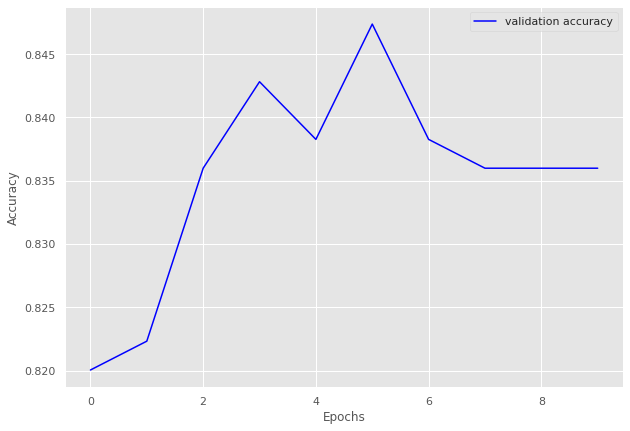

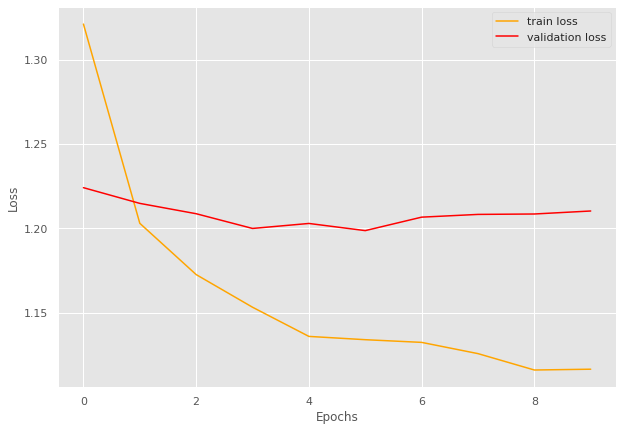

{'0': {'coarse': {'00': 0.8344144759303517, '10': 0.7350631614885627, '20': 0.6717065795249476, '30': 0.587328683607277, '50': 0.4409598595327513, '80': 0.2362093352192362}, 'fine': {'00': {'0': 0.9762140733399405, '1': 0.9764150943396226, '2': 0.9572277227722772, '3': 0.973404255319149, '4': 0.99644128113879, '5': 0.9815242494226328, '7': 0.9389619883040936, '8': 0.9871175523349437, '9': 0.8673469387755102, '11': 0.9451642060861706, '12': 0.9523012552301255, '14': 0.9555808656036446, '15': 0.9640077821011673}, '10': {'0': 0.8848780487804878, '1': 0.8422535211267606, '2': 0.8879103282626101, '3': 0.9231638418079096, '4': 0.9256505576208178, '5': 0.906885758998435, '7': 0.8858381502890174, '8': 0.9591503267973857, '9': 0.7749469214437368, '11': 0.8723911747167561, '12': 0.9203319502074688, '14': 0.8818380743982495, '15': 0.8033088235294118}, '20': {'0': 0.8442064264849075, '1': 0.7038567493112947, '2': 0.8205027494108406, '3': 0.8527889591719379, '4': 0.8386075949367089, '5': 0.80940794

100%|██████████| 65/65 [00:23<00:00,  2.73batch/s, loss=0.697]


train loss 0.6967486042242784, validation loss 0.6765482723712921, validation accuracy 0.859375
Coarse label 13 Epoch 2
-------------------------------


100%|██████████| 65/65 [00:22<00:00,  2.85batch/s, loss=0.626]


train loss 0.6256507360018216, validation loss 0.6675565242767334, validation accuracy 0.8828125
Coarse label 13 Epoch 3
-------------------------------


100%|██████████| 65/65 [00:23<00:00,  2.79batch/s, loss=0.605]


INFO: Early stopping counter 1 of 5
train loss 0.6050538283128005, validation loss 0.6735524088144302, validation accuracy 0.875
Coarse label 13 Epoch 4
-------------------------------


100%|██████████| 65/65 [00:23<00:00,  2.81batch/s, loss=0.597]


train loss 0.5974104881286622, validation loss 0.6530552953481674, validation accuracy 0.890625
Coarse label 13 Epoch 5
-------------------------------


100%|██████████| 65/65 [00:23<00:00,  2.80batch/s, loss=0.595]


INFO: Early stopping counter 2 of 5
train loss 0.5954264778357286, validation loss 0.6650745123624802, validation accuracy 0.8828125
Coarse label 13 Epoch 6
-------------------------------


100%|██████████| 65/65 [00:23<00:00,  2.79batch/s, loss=0.595]


INFO: Early stopping counter 3 of 5
train loss 0.5948694412524883, validation loss 0.659863144159317, validation accuracy 0.88671875
Coarse label 13 Epoch 7
-------------------------------


100%|██████████| 65/65 [00:23<00:00,  2.81batch/s, loss=0.585]


train loss 0.5853139721430265, validation loss 0.6407440155744553, validation accuracy 0.90234375
Coarse label 13 Epoch 8
-------------------------------


100%|██████████| 65/65 [00:23<00:00,  2.76batch/s, loss=0.582]


train loss 0.5823819857377273, validation loss 0.6384535431861877, validation accuracy 0.9140625
Coarse label 13 Epoch 9
-------------------------------


100%|██████████| 65/65 [00:23<00:00,  2.80batch/s, loss=0.58] 


INFO: Early stopping counter 4 of 5
train loss 0.5801277710841253, validation loss 0.6431564837694168, validation accuracy 0.8984375
Coarse label 13 Epoch 10
-------------------------------


100%|██████████| 65/65 [00:23<00:00,  2.83batch/s, loss=0.582]


INFO: Early stopping counter 5 of 5
INFO: Early stopping
Done! Saved model with test accuracy 0.9122340425531915 and loss 0.6396865248680115


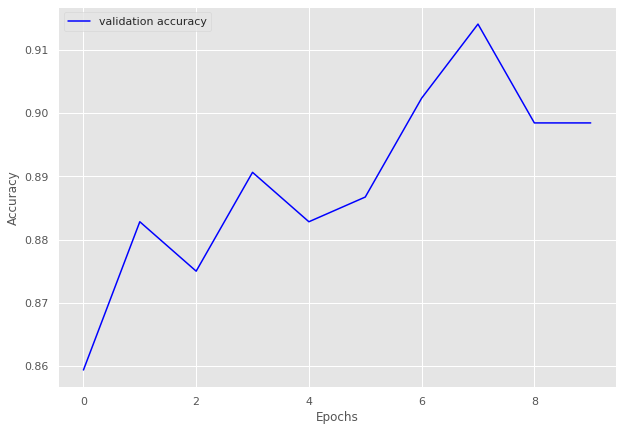

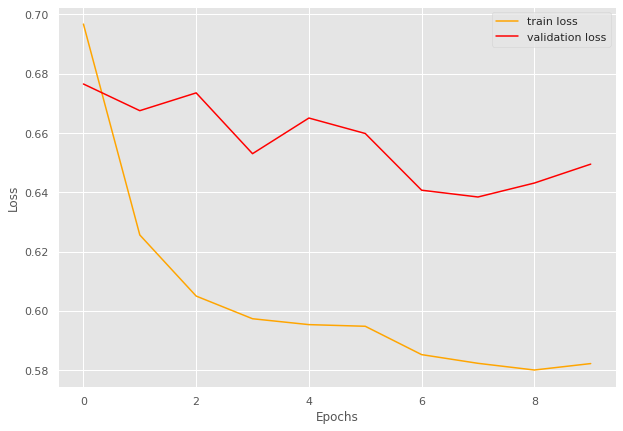

{'0': {'coarse': {'00': 0.8344144759303517, '10': 0.7350631614885627, '20': 0.6717065795249476, '30': 0.587328683607277, '50': 0.4409598595327513, '80': 0.2362093352192362}, 'fine': {'00': {'0': 0.9762140733399405, '1': 0.9764150943396226, '2': 0.9572277227722772, '3': 0.973404255319149, '4': 0.99644128113879, '5': 0.9815242494226328, '7': 0.9389619883040936, '8': 0.9871175523349437, '9': 0.8673469387755102, '11': 0.9451642060861706, '12': 0.9523012552301255, '14': 0.9555808656036446, '15': 0.9640077821011673}, '10': {'0': 0.8848780487804878, '1': 0.8422535211267606, '2': 0.8879103282626101, '3': 0.9231638418079096, '4': 0.9256505576208178, '5': 0.906885758998435, '7': 0.8858381502890174, '8': 0.9591503267973857, '9': 0.7749469214437368, '11': 0.8723911747167561, '12': 0.9203319502074688, '14': 0.8818380743982495, '15': 0.8033088235294118}, '20': {'0': 0.8442064264849075, '1': 0.7038567493112947, '2': 0.8205027494108406, '3': 0.8527889591719379, '4': 0.8386075949367089, '5': 0.80940794

100%|██████████| 146/146 [00:52<00:00,  2.77batch/s, loss=1.19]


train loss 1.193803556977886, validation loss 1.172865903377533, validation accuracy 0.865625
Coarse label 14 Epoch 2
-------------------------------


100%|██████████| 146/146 [00:52<00:00,  2.80batch/s, loss=1.13]


train loss 1.132396496322057, validation loss 1.14967782497406, validation accuracy 0.896875
Coarse label 14 Epoch 3
-------------------------------


100%|██████████| 146/146 [00:52<00:00,  2.78batch/s, loss=1.12]


INFO: Early stopping counter 1 of 5
train loss 1.1187928996674001, validation loss 1.1648599624633789, validation accuracy 0.8765625
Coarse label 14 Epoch 4
-------------------------------


100%|██████████| 146/146 [00:52<00:00,  2.78batch/s, loss=1.11]


INFO: Early stopping counter 2 of 5
train loss 1.1085139782461402, validation loss 1.1585774540901184, validation accuracy 0.884375
Coarse label 14 Epoch 5
-------------------------------


100%|██████████| 146/146 [00:52<00:00,  2.80batch/s, loss=1.11]


INFO: Early stopping counter 3 of 5
train loss 1.1066109962659338, validation loss 1.1559496998786927, validation accuracy 0.884375
Coarse label 14 Epoch 6
-------------------------------


100%|██████████| 146/146 [00:52<00:00,  2.78batch/s, loss=1.1] 


INFO: Early stopping counter 4 of 5
train loss 1.0999986749805817, validation loss 1.1579272389411925, validation accuracy 0.8828125
Coarse label 14 Epoch 7
-------------------------------


100%|██████████| 146/146 [00:52<00:00,  2.77batch/s, loss=1.1]


INFO: Early stopping counter 5 of 5
INFO: Early stopping
Done! Saved model with test accuracy 0.9102272727272728 and loss 1.1320795459406716


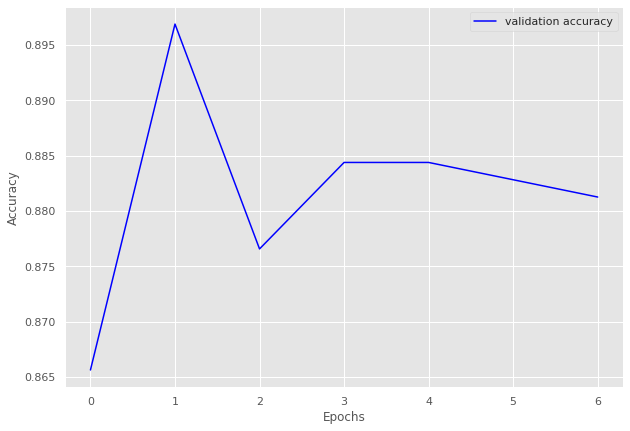

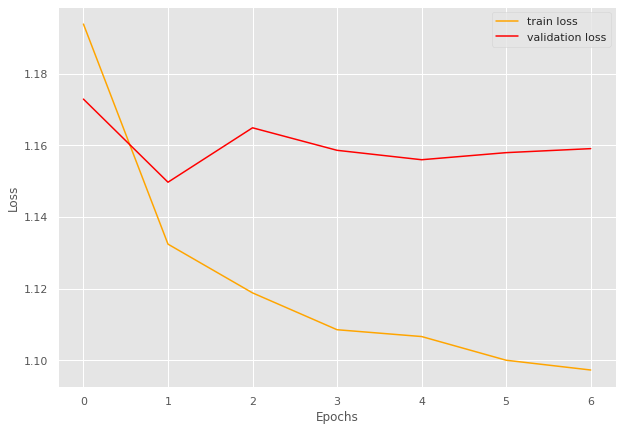

{'0': {'coarse': {'00': 0.8344144759303517, '10': 0.7350631614885627, '20': 0.6717065795249476, '30': 0.587328683607277, '50': 0.4409598595327513, '80': 0.2362093352192362}, 'fine': {'00': {'0': 0.9762140733399405, '1': 0.9764150943396226, '2': 0.9572277227722772, '3': 0.973404255319149, '4': 0.99644128113879, '5': 0.9815242494226328, '7': 0.9389619883040936, '8': 0.9871175523349437, '9': 0.8673469387755102, '11': 0.9451642060861706, '12': 0.9523012552301255, '14': 0.9555808656036446, '15': 0.9640077821011673}, '10': {'0': 0.8848780487804878, '1': 0.8422535211267606, '2': 0.8879103282626101, '3': 0.9231638418079096, '4': 0.9256505576208178, '5': 0.906885758998435, '7': 0.8858381502890174, '8': 0.9591503267973857, '9': 0.7749469214437368, '11': 0.8723911747167561, '12': 0.9203319502074688, '14': 0.8818380743982495, '15': 0.8033088235294118}, '20': {'0': 0.8442064264849075, '1': 0.7038567493112947, '2': 0.8205027494108406, '3': 0.8527889591719379, '4': 0.8386075949367089, '5': 0.80940794

100%|██████████| 71/71 [00:25<00:00,  2.77batch/s, loss=0.921]


train loss 0.9209724362467376, validation loss 0.8469352647662163, validation accuracy 0.896414342629482
Coarse label 15 Epoch 2
-------------------------------


100%|██████████| 71/71 [00:25<00:00,  2.80batch/s, loss=0.825]


train loss 0.8254425063939161, validation loss 0.838123083114624, validation accuracy 0.900398406374502
Coarse label 15 Epoch 3
-------------------------------


100%|██████████| 71/71 [00:25<00:00,  2.78batch/s, loss=0.803]


INFO: Early stopping counter 1 of 5
train loss 0.8027605775376441, validation loss 0.8403244689106941, validation accuracy 0.898406374501992
Coarse label 15 Epoch 4
-------------------------------


100%|██████████| 71/71 [00:25<00:00,  2.79batch/s, loss=0.796]


train loss 0.7958958467967073, validation loss 0.8341230899095535, validation accuracy 0.9083665338645418
Coarse label 15 Epoch 5
-------------------------------


100%|██████████| 71/71 [00:25<00:00,  2.76batch/s, loss=0.791]


INFO: Early stopping counter 2 of 5
train loss 0.7907607597364507, validation loss 0.8394509181380272, validation accuracy 0.898406374501992
Coarse label 15 Epoch 6
-------------------------------


100%|██████████| 71/71 [00:25<00:00,  2.80batch/s, loss=0.786]


INFO: Early stopping counter 3 of 5
train loss 0.7864573371242469, validation loss 0.8416807651519775, validation accuracy 0.900398406374502
Coarse label 15 Epoch 7
-------------------------------


100%|██████████| 71/71 [00:25<00:00,  2.81batch/s, loss=0.784]


train loss 0.7835739389271803, validation loss 0.8319729045033455, validation accuracy 0.9143426294820717
Coarse label 15 Epoch 8
-------------------------------


100%|██████████| 71/71 [00:25<00:00,  2.81batch/s, loss=0.786]


INFO: Early stopping counter 4 of 5
train loss 0.785783954069648, validation loss 0.8435203582048416, validation accuracy 0.896414342629482
Coarse label 15 Epoch 9
-------------------------------


100%|██████████| 71/71 [00:25<00:00,  2.77batch/s, loss=0.781]


INFO: Early stopping counter 5 of 5
INFO: Early stopping
Done! Saved model with test accuracy 0.8969072164948454 and loss 0.8556143258299146


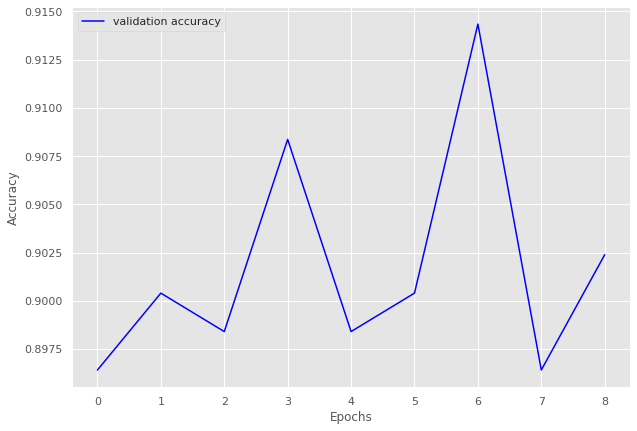

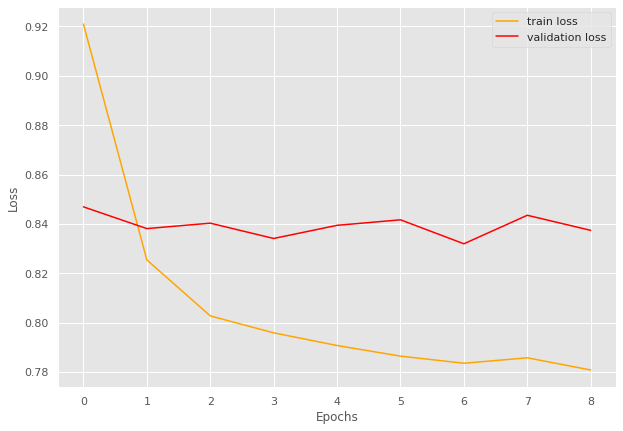

{'0': {'coarse': {'00': 0.8344144759303517, '10': 0.7350631614885627, '20': 0.6717065795249476, '30': 0.587328683607277, '50': 0.4409598595327513, '80': 0.2362093352192362}, 'fine': {'00': {'0': 0.9762140733399405, '1': 0.9764150943396226, '2': 0.9572277227722772, '3': 0.973404255319149, '4': 0.99644128113879, '5': 0.9815242494226328, '7': 0.9389619883040936, '8': 0.9871175523349437, '9': 0.8673469387755102, '11': 0.9451642060861706, '12': 0.9523012552301255, '14': 0.9555808656036446, '15': 0.9640077821011673}, '10': {'0': 0.8848780487804878, '1': 0.8422535211267606, '2': 0.8879103282626101, '3': 0.9231638418079096, '4': 0.9256505576208178, '5': 0.906885758998435, '7': 0.8858381502890174, '8': 0.9591503267973857, '9': 0.7749469214437368, '11': 0.8723911747167561, '12': 0.9203319502074688, '14': 0.8818380743982495, '15': 0.8033088235294118}, '20': {'0': 0.8442064264849075, '1': 0.7038567493112947, '2': 0.8205027494108406, '3': 0.8527889591719379, '4': 0.8386075949367089, '5': 0.80940794

100%|██████████| 68/68 [00:24<00:00,  2.78batch/s, loss=0.689]


train loss 0.6888787676306332, validation loss 0.6084310909112295, validation accuracy 0.9441340782122905
Coarse label 16 Epoch 2
-------------------------------


100%|██████████| 68/68 [00:25<00:00,  2.72batch/s, loss=0.612]


train loss 0.6118398948627359, validation loss 0.6019230087598165, validation accuracy 0.946927374301676
Coarse label 16 Epoch 3
-------------------------------


100%|██████████| 68/68 [00:23<00:00,  2.84batch/s, loss=0.599]


INFO: Early stopping counter 1 of 5
train loss 0.5990301747532452, validation loss 0.6295107503732046, validation accuracy 0.9162011173184358
Coarse label 16 Epoch 4
-------------------------------


100%|██████████| 68/68 [00:24<00:00,  2.81batch/s, loss=0.595]


INFO: Early stopping counter 2 of 5
train loss 0.5950865657890544, validation loss 0.6205623348553976, validation accuracy 0.9217877094972067
Coarse label 16 Epoch 5
-------------------------------


100%|██████████| 68/68 [00:24<00:00,  2.77batch/s, loss=0.587]


INFO: Early stopping counter 3 of 5
train loss 0.5873943646164501, validation loss 0.6019833485285441, validation accuracy 0.9441340782122905
Coarse label 16 Epoch 6
-------------------------------


100%|██████████| 68/68 [00:24<00:00,  2.79batch/s, loss=0.583]


INFO: Early stopping counter 4 of 5
train loss 0.5825949372614131, validation loss 0.6117412050565084, validation accuracy 0.9329608938547486
Coarse label 16 Epoch 7
-------------------------------


100%|██████████| 68/68 [00:24<00:00,  2.80batch/s, loss=0.579]


INFO: Early stopping counter 5 of 5
INFO: Early stopping
Done! Saved model with test accuracy 0.9201388888888888 and loss 0.6346970455987113


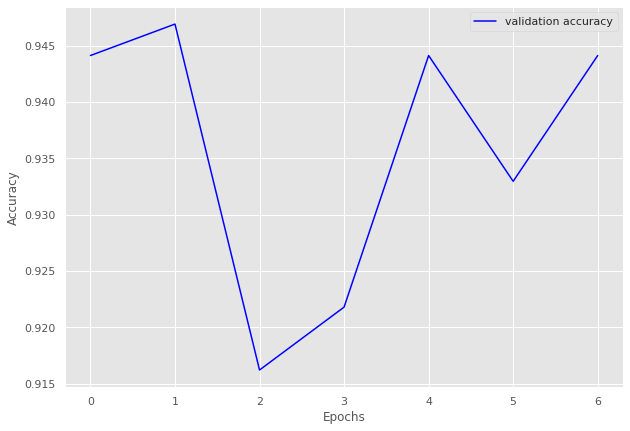

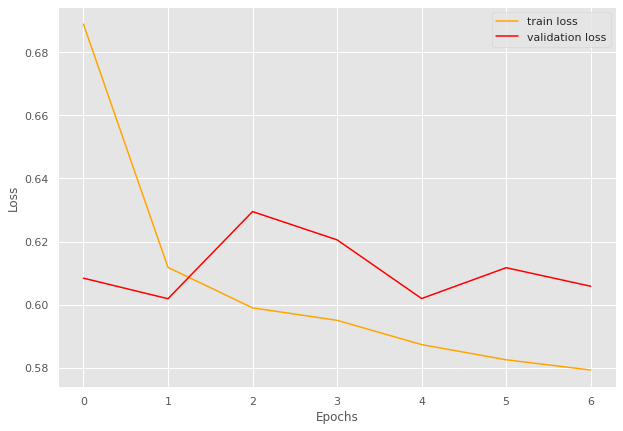

{'0': {'coarse': {'00': 0.8344144759303517, '10': 0.7350631614885627, '20': 0.6717065795249476, '30': 0.587328683607277, '50': 0.4409598595327513, '80': 0.2362093352192362}, 'fine': {'00': {'0': 0.9762140733399405, '1': 0.9764150943396226, '2': 0.9572277227722772, '3': 0.973404255319149, '4': 0.99644128113879, '5': 0.9815242494226328, '7': 0.9389619883040936, '8': 0.9871175523349437, '9': 0.8673469387755102, '11': 0.9451642060861706, '12': 0.9523012552301255, '14': 0.9555808656036446, '15': 0.9640077821011673}, '10': {'0': 0.8848780487804878, '1': 0.8422535211267606, '2': 0.8879103282626101, '3': 0.9231638418079096, '4': 0.9256505576208178, '5': 0.906885758998435, '7': 0.8858381502890174, '8': 0.9591503267973857, '9': 0.7749469214437368, '11': 0.8723911747167561, '12': 0.9203319502074688, '14': 0.8818380743982495, '15': 0.8033088235294118}, '20': {'0': 0.8442064264849075, '1': 0.7038567493112947, '2': 0.8205027494108406, '3': 0.8527889591719379, '4': 0.8386075949367089, '5': 0.80940794

100%|██████████| 77/77 [00:27<00:00,  2.78batch/s, loss=0.945]


train loss 0.944921536879106, validation loss 0.8691361645857493, validation accuracy 0.8732782369146006
Coarse label 17 Epoch 2
-------------------------------


100%|██████████| 77/77 [00:27<00:00,  2.81batch/s, loss=0.845]


train loss 0.8448645356413605, validation loss 0.8493660787741343, validation accuracy 0.8842975206611571
Coarse label 17 Epoch 3
-------------------------------


100%|██████████| 77/77 [00:27<00:00,  2.78batch/s, loss=0.82] 


train loss 0.8197136962568605, validation loss 0.8418517212073008, validation accuracy 0.8980716253443526
Coarse label 17 Epoch 4
-------------------------------


100%|██████████| 77/77 [00:49<00:00,  1.56batch/s, loss=0.807]


INFO: Early stopping counter 1 of 5
train loss 0.8066053305353437, validation loss 0.8425479928652445, validation accuracy 0.8980716253443526
Coarse label 17 Epoch 5
-------------------------------


100%|██████████| 77/77 [01:00<00:00,  1.27batch/s, loss=0.8]  


INFO: Early stopping counter 2 of 5
train loss 0.8003236241154856, validation loss 0.844490776459376, validation accuracy 0.8980716253443526
Coarse label 17 Epoch 6
-------------------------------


100%|██████████| 77/77 [00:58<00:00,  1.32batch/s, loss=0.792]


INFO: Early stopping counter 3 of 5
train loss 0.7924703096414542, validation loss 0.8495022257169088, validation accuracy 0.8953168044077136
Coarse label 17 Epoch 7
-------------------------------


100%|██████████| 77/77 [00:48<00:00,  1.59batch/s, loss=0.791]


INFO: Early stopping counter 4 of 5
train loss 0.7907400332488023, validation loss 0.8546583950519562, validation accuracy 0.8787878787878788
Coarse label 17 Epoch 8
-------------------------------


100%|██████████| 77/77 [00:27<00:00,  2.80batch/s, loss=0.785]


train loss 0.7847612399559516, validation loss 0.8295591473579407, validation accuracy 0.9090909090909091
Coarse label 17 Epoch 9
-------------------------------


100%|██████████| 77/77 [00:27<00:00,  2.82batch/s, loss=0.78] 


train loss 0.7803635736564537, validation loss 0.8205608328183492, validation accuracy 0.9228650137741047
Coarse label 17 Epoch 10
-------------------------------


100%|██████████| 77/77 [00:28<00:00,  2.72batch/s, loss=0.78] 


INFO: Early stopping counter 5 of 5
INFO: Early stopping
Done! Saved model with test accuracy 0.8888888888888888 and loss 0.8517242630322774


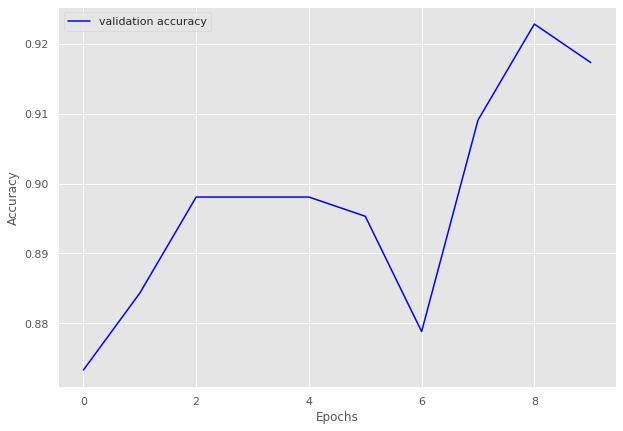

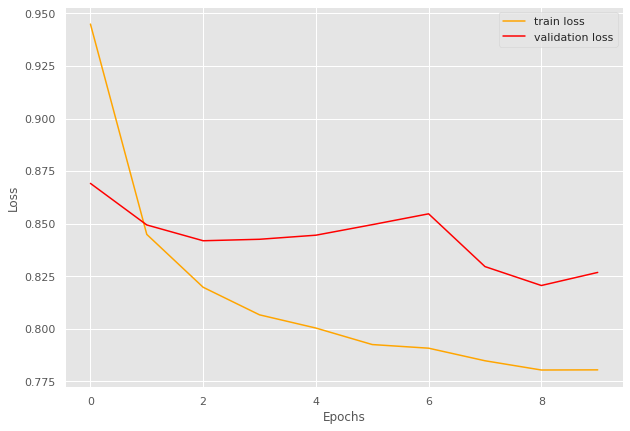

{'0': {'coarse': {'00': 0.8344144759303517, '10': 0.7350631614885627, '20': 0.6717065795249476, '30': 0.587328683607277, '50': 0.4409598595327513, '80': 0.2362093352192362}, 'fine': {'00': {'0': 0.9762140733399405, '1': 0.9764150943396226, '2': 0.9572277227722772, '3': 0.973404255319149, '4': 0.99644128113879, '5': 0.9815242494226328, '7': 0.9389619883040936, '8': 0.9871175523349437, '9': 0.8673469387755102, '11': 0.9451642060861706, '12': 0.9523012552301255, '14': 0.9555808656036446, '15': 0.9640077821011673}, '10': {'0': 0.8848780487804878, '1': 0.8422535211267606, '2': 0.8879103282626101, '3': 0.9231638418079096, '4': 0.9256505576208178, '5': 0.906885758998435, '7': 0.8858381502890174, '8': 0.9591503267973857, '9': 0.7749469214437368, '11': 0.8723911747167561, '12': 0.9203319502074688, '14': 0.8818380743982495, '15': 0.8033088235294118}, '20': {'0': 0.8442064264849075, '1': 0.7038567493112947, '2': 0.8205027494108406, '3': 0.8527889591719379, '4': 0.8386075949367089, '5': 0.80940794

100%|██████████| 29/29 [00:10<00:00,  2.77batch/s, loss=1.06]


train loss 1.060251533985138, validation loss 1.1864484548568726, validation accuracy 0.53125
Coarse label 19 Epoch 2
-------------------------------


100%|██████████| 29/29 [00:10<00:00,  2.77batch/s, loss=0.887]


train loss 0.8865809235079535, validation loss 1.1230162382125854, validation accuracy 0.59375
Coarse label 19 Epoch 3
-------------------------------


100%|██████████| 29/29 [00:10<00:00,  2.80batch/s, loss=0.835]


INFO: Early stopping counter 1 of 5
train loss 0.8346379296532993, validation loss 1.1281485557556152, validation accuracy 0.5625
Coarse label 19 Epoch 4
-------------------------------


100%|██████████| 29/29 [00:10<00:00,  2.81batch/s, loss=0.808]


INFO: Early stopping counter 2 of 5
train loss 0.8080109131747278, validation loss 1.1358287334442139, validation accuracy 0.5625
Coarse label 19 Epoch 5
-------------------------------


100%|██████████| 29/29 [00:10<00:00,  2.83batch/s, loss=0.792]


INFO: Early stopping counter 3 of 5
train loss 0.7922582297489561, validation loss 1.1378909349441528, validation accuracy 0.5625
Coarse label 19 Epoch 6
-------------------------------


100%|██████████| 29/29 [00:10<00:00,  2.82batch/s, loss=0.785]


train loss 0.7851032388621363, validation loss 1.1107172966003418, validation accuracy 0.625
Coarse label 19 Epoch 7
-------------------------------


100%|██████████| 29/29 [00:10<00:00,  2.80batch/s, loss=0.778]


train loss 0.7775889511766105, validation loss 1.108114242553711, validation accuracy 0.59375
Coarse label 19 Epoch 8
-------------------------------


100%|██████████| 29/29 [00:10<00:00,  2.83batch/s, loss=0.777]


INFO: Early stopping counter 4 of 5
train loss 0.776679554889942, validation loss 1.1231433153152466, validation accuracy 0.578125
Coarse label 19 Epoch 9
-------------------------------


100%|██████████| 29/29 [00:10<00:00,  2.83batch/s, loss=0.779]


INFO: Early stopping counter 5 of 5
INFO: Early stopping
Done! Saved model with test accuracy 0.7994186046511628 and loss 0.9389180938402811


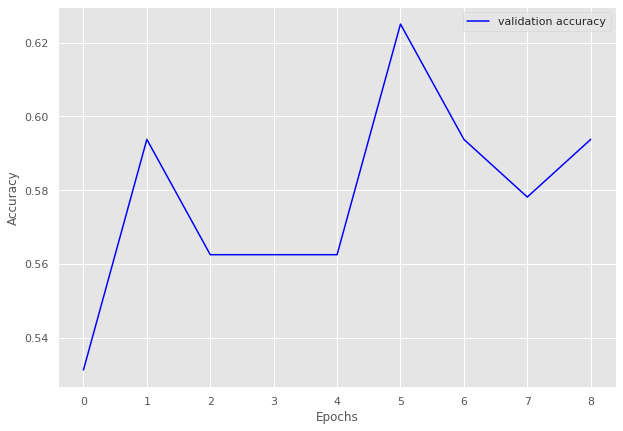

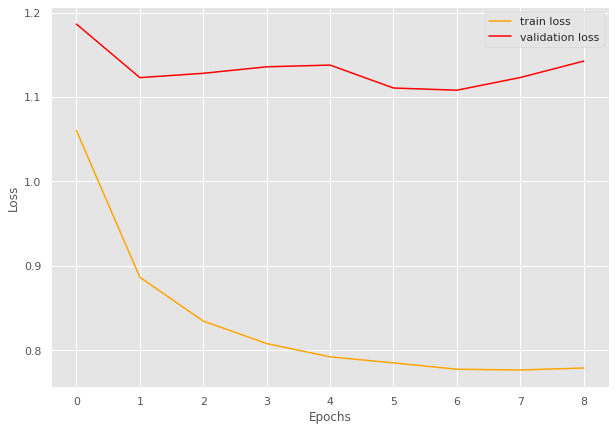

{'0': {'coarse': {'00': 0.8344144759303517, '10': 0.7350631614885627, '20': 0.6717065795249476, '30': 0.587328683607277, '50': 0.4409598595327513, '80': 0.2362093352192362}, 'fine': {'00': {'0': 0.9762140733399405, '1': 0.9764150943396226, '2': 0.9572277227722772, '3': 0.973404255319149, '4': 0.99644128113879, '5': 0.9815242494226328, '7': 0.9389619883040936, '8': 0.9871175523349437, '9': 0.8673469387755102, '11': 0.9451642060861706, '12': 0.9523012552301255, '14': 0.9555808656036446, '15': 0.9640077821011673}, '10': {'0': 0.8848780487804878, '1': 0.8422535211267606, '2': 0.8879103282626101, '3': 0.9231638418079096, '4': 0.9256505576208178, '5': 0.906885758998435, '7': 0.8858381502890174, '8': 0.9591503267973857, '9': 0.7749469214437368, '11': 0.8723911747167561, '12': 0.9203319502074688, '14': 0.8818380743982495, '15': 0.8033088235294118}, '20': {'0': 0.8442064264849075, '1': 0.7038567493112947, '2': 0.8205027494108406, '3': 0.8527889591719379, '4': 0.8386075949367089, '5': 0.80940794

Calculating for label_noise 20
split_20_2
Start training a coarse model
Epoch 1
-------------------------------


100%|██████████| 1641/1641 [11:35<00:00,  2.36batch/s, loss=2.56]


train loss 2.55543421522137, validation loss 2.4616282286343876, validation accuracy 0.6165644171779141
Epoch 2
-------------------------------


100%|██████████| 1641/1641 [09:51<00:00,  2.77batch/s, loss=2.48]


train loss 2.476642062066896, validation loss 2.436489353646765, validation accuracy 0.642418930762489
Epoch 3
-------------------------------


100%|██████████| 1641/1641 [11:45<00:00,  2.33batch/s, loss=2.46]


train loss 2.457295756162775, validation loss 2.434155075700133, validation accuracy 0.6437335670464505
Epoch 4
-------------------------------


100%|██████████| 1641/1641 [09:53<00:00,  2.77batch/s, loss=2.45]


train loss 2.4505504172869674, validation loss 2.428229298624959, validation accuracy 0.6492112182296231
Epoch 5
-------------------------------


100%|██████████| 1641/1641 [09:58<00:00,  2.74batch/s, loss=2.44]


train loss 2.440092471225606, validation loss 2.419208965101442, validation accuracy 0.6602760736196319
Epoch 6
-------------------------------


100%|██████████| 1641/1641 [11:07<00:00,  2.46batch/s, loss=2.43]


train loss 2.4281750864404357, validation loss 2.4169246883659095, validation accuracy 0.660056967572305
Epoch 7
-------------------------------


100%|██████████| 1641/1641 [09:54<00:00,  2.76batch/s, loss=2.41]


train loss 2.4126847785540573, validation loss 2.3952916185339013, validation accuracy 0.6835013146362839
Epoch 8
-------------------------------


100%|██████████| 1641/1641 [09:51<00:00,  2.77batch/s, loss=2.4]


train loss 2.397719027718562, validation loss 2.391227662146508, validation accuracy 0.6878834355828221
Epoch 9
-------------------------------


100%|██████████| 1641/1641 [11:44<00:00,  2.33batch/s, loss=2.38]


train loss 2.381344321150376, validation loss 2.376141663197871, validation accuracy 0.7017966695880806
Epoch 10
-------------------------------


100%|██████████| 1641/1641 [09:52<00:00,  2.77batch/s, loss=2.38]


train loss 2.3780032761717336, validation loss 2.37073807116155, validation accuracy 0.7078220858895705
Epoch 11
-------------------------------


100%|██████████| 1641/1641 [09:51<00:00,  2.77batch/s, loss=2.38]


INFO: Early stopping counter 1 of 5
train loss 2.37523298885385, validation loss 2.378567854007641, validation accuracy 0.6991673970201577
Epoch 12
-------------------------------


100%|██████████| 1641/1641 [11:45<00:00,  2.32batch/s, loss=2.37]


train loss 2.37064493596009, validation loss 2.3693716576049377, validation accuracy 0.7082602979842244
Epoch 13
-------------------------------


100%|██████████| 1641/1641 [09:53<00:00,  2.77batch/s, loss=2.37]


INFO: Early stopping counter 2 of 5
train loss 2.369256101535051, validation loss 2.373789545539376, validation accuracy 0.7053023663453112
Epoch 14
-------------------------------


100%|██████████| 1641/1641 [11:50<00:00,  2.31batch/s, loss=2.36]


INFO: Early stopping counter 3 of 5
train loss 2.3646104122210683, validation loss 2.3697859073852325, validation accuracy 0.709136722173532
Epoch 15
-------------------------------


100%|██████████| 1641/1641 [09:52<00:00,  2.77batch/s, loss=2.36]


INFO: Early stopping counter 4 of 5
train loss 2.3617688960087584, validation loss 2.3706456797939914, validation accuracy 0.7084794040315513
Epoch 16
-------------------------------


100%|██████████| 1641/1641 [11:43<00:00,  2.33batch/s, loss=2.36]


train loss 2.3593241228409325, validation loss 2.367143811045827, validation accuracy 0.7112182296231376
Epoch 17
-------------------------------


100%|██████████| 1641/1641 [09:51<00:00,  2.78batch/s, loss=2.36]


train loss 2.3564113816569883, validation loss 2.3632241495839366, validation accuracy 0.7147239263803681
Epoch 18
-------------------------------


100%|██████████| 1641/1641 [09:55<00:00,  2.76batch/s, loss=2.36]


INFO: Early stopping counter 5 of 5
INFO: Early stopping
Done! Saved model with test accuracy 0.6976540018533873 and loss 2.380678781467806


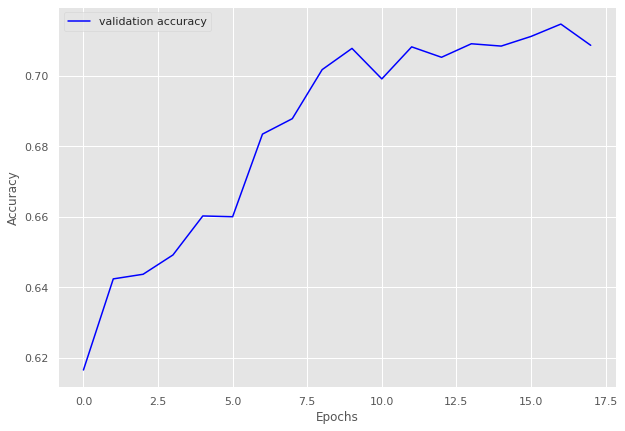

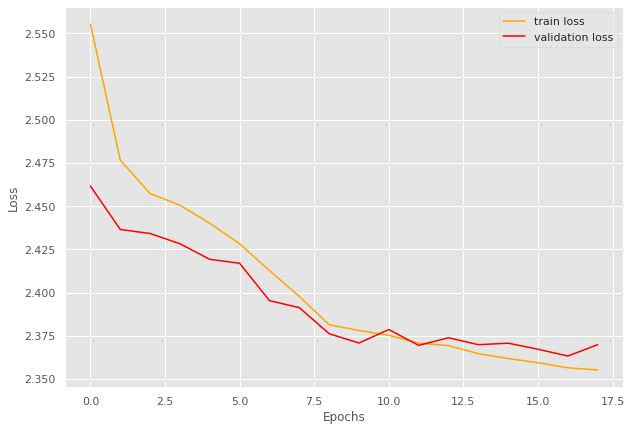

{'0': {'coarse': {'00': 0.8344144759303517, '10': 0.7350631614885627, '20': 0.6717065795249476, '30': 0.587328683607277, '50': 0.4409598595327513, '80': 0.2362093352192362}, 'fine': {'00': {'0': 0.9762140733399405, '1': 0.9764150943396226, '2': 0.9572277227722772, '3': 0.973404255319149, '4': 0.99644128113879, '5': 0.9815242494226328, '7': 0.9389619883040936, '8': 0.9871175523349437, '9': 0.8673469387755102, '11': 0.9451642060861706, '12': 0.9523012552301255, '14': 0.9555808656036446, '15': 0.9640077821011673}, '10': {'0': 0.8848780487804878, '1': 0.8422535211267606, '2': 0.8879103282626101, '3': 0.9231638418079096, '4': 0.9256505576208178, '5': 0.906885758998435, '7': 0.8858381502890174, '8': 0.9591503267973857, '9': 0.7749469214437368, '11': 0.8723911747167561, '12': 0.9203319502074688, '14': 0.8818380743982495, '15': 0.8033088235294118}, '20': {'0': 0.8442064264849075, '1': 0.7038567493112947, '2': 0.8205027494108406, '3': 0.8527889591719379, '4': 0.8386075949367089, '5': 0.80940794

100%|██████████| 101/101 [00:36<00:00,  2.78batch/s, loss=1.15]


train loss 1.14864982944904, validation loss 1.0499576059254734, validation accuracy 0.8543833580980683
Coarse label 0 Epoch 2
-------------------------------


100%|██████████| 101/101 [00:35<00:00,  2.81batch/s, loss=1.06]


train loss 1.0556800884775597, validation loss 1.037082466212186, validation accuracy 0.8677563150074294
Coarse label 0 Epoch 3
-------------------------------


100%|██████████| 101/101 [00:36<00:00,  2.79batch/s, loss=1.04]


train loss 1.037963374416427, validation loss 1.0346424742178484, validation accuracy 0.8692421991084696
Coarse label 0 Epoch 4
-------------------------------


100%|██████████| 101/101 [00:36<00:00,  2.74batch/s, loss=1.02]


INFO: Early stopping counter 1 of 5
train loss 1.0228889944529769, validation loss 1.0434180118820884, validation accuracy 0.8647845468053492
Coarse label 0 Epoch 5
-------------------------------


100%|██████████| 101/101 [00:36<00:00,  2.78batch/s, loss=1.02]


INFO: Early stopping counter 2 of 5
train loss 1.0204857050782383, validation loss 1.046714555133473, validation accuracy 0.8573551263001485
Coarse label 0 Epoch 6
-------------------------------


100%|██████████| 101/101 [00:36<00:00,  2.80batch/s, loss=1.01]


INFO: Early stopping counter 3 of 5
train loss 1.0130839206204556, validation loss 1.0467966307293286, validation accuracy 0.8573551263001485
Coarse label 0 Epoch 7
-------------------------------


100%|██████████| 101/101 [00:36<00:00,  2.76batch/s, loss=1.01]


INFO: Early stopping counter 4 of 5
train loss 1.0050872446286796, validation loss 1.0545916178009727, validation accuracy 0.8514115898959881
Coarse label 0 Epoch 8
-------------------------------


100%|██████████| 101/101 [00:52<00:00,  1.94batch/s, loss=1.01]


INFO: Early stopping counter 5 of 5
INFO: Early stopping
Done! Saved model with test accuracy 0.8462757527733756 and loss 1.0662606567144395


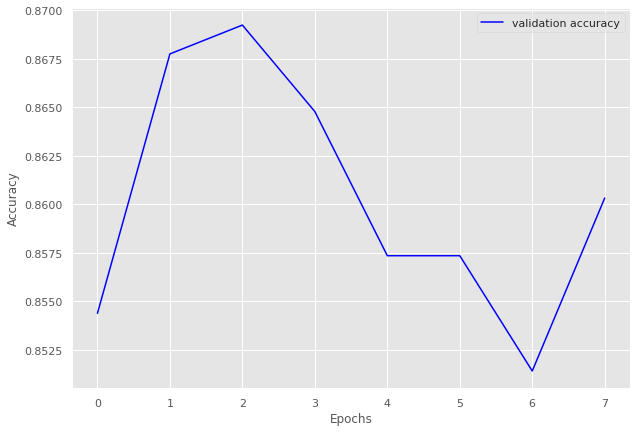

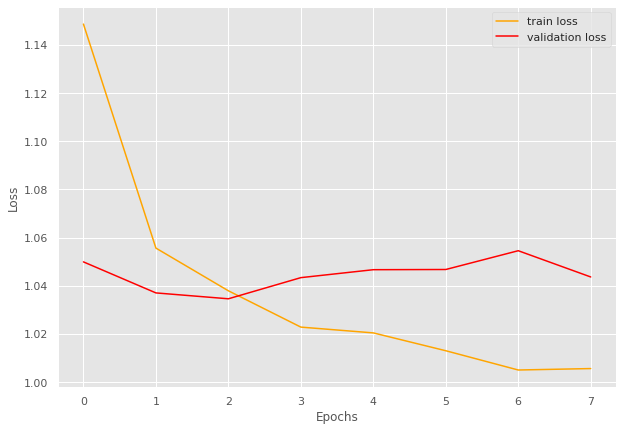

{'0': {'coarse': {'00': 0.8344144759303517, '10': 0.7350631614885627, '20': 0.6717065795249476, '30': 0.587328683607277, '50': 0.4409598595327513, '80': 0.2362093352192362}, 'fine': {'00': {'0': 0.9762140733399405, '1': 0.9764150943396226, '2': 0.9572277227722772, '3': 0.973404255319149, '4': 0.99644128113879, '5': 0.9815242494226328, '7': 0.9389619883040936, '8': 0.9871175523349437, '9': 0.8673469387755102, '11': 0.9451642060861706, '12': 0.9523012552301255, '14': 0.9555808656036446, '15': 0.9640077821011673}, '10': {'0': 0.8848780487804878, '1': 0.8422535211267606, '2': 0.8879103282626101, '3': 0.9231638418079096, '4': 0.9256505576208178, '5': 0.906885758998435, '7': 0.8858381502890174, '8': 0.9591503267973857, '9': 0.7749469214437368, '11': 0.8723911747167561, '12': 0.9203319502074688, '14': 0.8818380743982495, '15': 0.8033088235294118}, '20': {'0': 0.8442064264849075, '1': 0.7038567493112947, '2': 0.8205027494108406, '3': 0.8527889591719379, '4': 0.8386075949367089, '5': 0.80940794

100%|██████████| 57/57 [00:46<00:00,  1.22batch/s, loss=1.43]


train loss 1.428589994447273, validation loss 1.4022379636764526, validation accuracy 0.643598615916955
Coarse label 1 Epoch 2
-------------------------------


100%|██████████| 57/57 [00:43<00:00,  1.33batch/s, loss=1.31]


INFO: Early stopping counter 1 of 5
train loss 1.3066986882895755, validation loss 1.402341365814209, validation accuracy 0.629757785467128
Coarse label 1 Epoch 3
-------------------------------


100%|██████████| 57/57 [00:48<00:00,  1.17batch/s, loss=1.25]


INFO: Early stopping counter 2 of 5
train loss 1.2463846185751128, validation loss 1.4027531623840332, validation accuracy 0.6262975778546713
Coarse label 1 Epoch 4
-------------------------------


100%|██████████| 57/57 [00:31<00:00,  1.82batch/s, loss=1.21]


train loss 1.2149350099396288, validation loss 1.3951739072799683, validation accuracy 0.6505190311418685
Coarse label 1 Epoch 5
-------------------------------


100%|██████████| 57/57 [00:20<00:00,  2.81batch/s, loss=1.19]


train loss 1.1859256928427178, validation loss 1.3944690465927123, validation accuracy 0.643598615916955
Coarse label 1 Epoch 6
-------------------------------


100%|██████████| 57/57 [00:20<00:00,  2.81batch/s, loss=1.17]


INFO: Early stopping counter 3 of 5
train loss 1.1685648696464406, validation loss 1.401686930656433, validation accuracy 0.629757785467128
Coarse label 1 Epoch 7
-------------------------------


100%|██████████| 57/57 [00:20<00:00,  2.77batch/s, loss=1.16]


INFO: Early stopping counter 4 of 5
train loss 1.1564846728977405, validation loss 1.4106859683990478, validation accuracy 0.6332179930795848
Coarse label 1 Epoch 8
-------------------------------


100%|██████████| 57/57 [00:20<00:00,  2.77batch/s, loss=1.15]


INFO: Early stopping counter 5 of 5
INFO: Early stopping
Done! Saved model with test accuracy 0.6992805755395683 and loss 1.3388955376364968


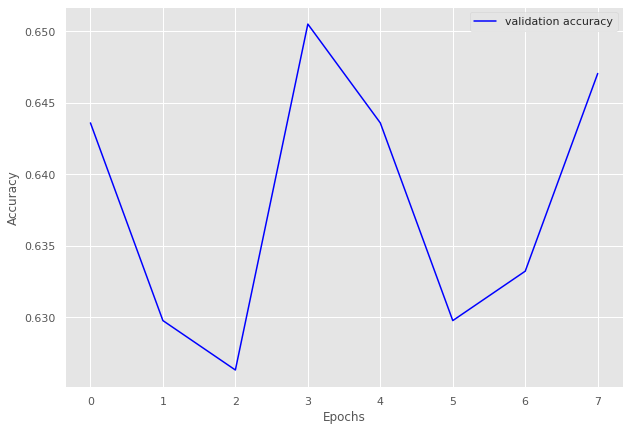

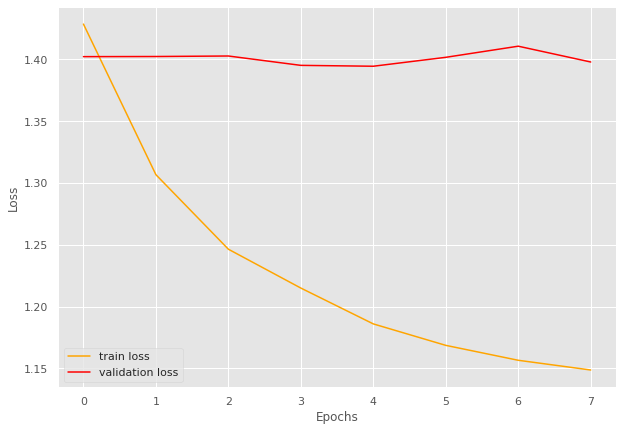

{'0': {'coarse': {'00': 0.8344144759303517, '10': 0.7350631614885627, '20': 0.6717065795249476, '30': 0.587328683607277, '50': 0.4409598595327513, '80': 0.2362093352192362}, 'fine': {'00': {'0': 0.9762140733399405, '1': 0.9764150943396226, '2': 0.9572277227722772, '3': 0.973404255319149, '4': 0.99644128113879, '5': 0.9815242494226328, '7': 0.9389619883040936, '8': 0.9871175523349437, '9': 0.8673469387755102, '11': 0.9451642060861706, '12': 0.9523012552301255, '14': 0.9555808656036446, '15': 0.9640077821011673}, '10': {'0': 0.8848780487804878, '1': 0.8422535211267606, '2': 0.8879103282626101, '3': 0.9231638418079096, '4': 0.9256505576208178, '5': 0.906885758998435, '7': 0.8858381502890174, '8': 0.9591503267973857, '9': 0.7749469214437368, '11': 0.8723911747167561, '12': 0.9203319502074688, '14': 0.8818380743982495, '15': 0.8033088235294118}, '20': {'0': 0.8442064264849075, '1': 0.7038567493112947, '2': 0.8205027494108406, '3': 0.8527889591719379, '4': 0.8386075949367089, '5': 0.80940794

100%|██████████| 205/205 [01:14<00:00,  2.74batch/s, loss=1.75]


train loss 1.7470792217952449, validation loss 1.6654990400586809, validation accuracy 0.795198799699925
Coarse label 2 Epoch 2
-------------------------------


100%|██████████| 205/205 [01:13<00:00,  2.78batch/s, loss=1.65]


train loss 1.6528797126397854, validation loss 1.643547705241612, validation accuracy 0.8162040510127532
Coarse label 2 Epoch 3
-------------------------------


100%|██████████| 205/205 [01:13<00:00,  2.78batch/s, loss=1.64]


train loss 1.6358366820870376, validation loss 1.6351840950193859, validation accuracy 0.827456864216054
Coarse label 2 Epoch 4
-------------------------------


100%|██████████| 205/205 [01:13<00:00,  2.79batch/s, loss=1.62]


train loss 1.6240897748528458, validation loss 1.6324569157191686, validation accuracy 0.827456864216054
Coarse label 2 Epoch 5
-------------------------------


100%|██████████| 205/205 [01:13<00:00,  2.77batch/s, loss=1.62]


train loss 1.615131849195899, validation loss 1.6247959591093517, validation accuracy 0.8342085521380345
Coarse label 2 Epoch 6
-------------------------------


100%|██████████| 205/205 [01:13<00:00,  2.79batch/s, loss=1.61]


INFO: Early stopping counter 1 of 5
train loss 1.6064627635769728, validation loss 1.6323500247228713, validation accuracy 0.8297074268567142
Coarse label 2 Epoch 7
-------------------------------


100%|██████████| 205/205 [01:14<00:00,  2.75batch/s, loss=1.6] 


INFO: Early stopping counter 2 of 5
train loss 1.603734607812835, validation loss 1.633242584410168, validation accuracy 0.8252063015753939
Coarse label 2 Epoch 8
-------------------------------


100%|██████████| 205/205 [01:14<00:00,  2.74batch/s, loss=1.6] 


INFO: Early stopping counter 3 of 5
train loss 1.6029895264927934, validation loss 1.63217218149276, validation accuracy 0.8282070517629407
Coarse label 2 Epoch 9
-------------------------------


100%|██████████| 205/205 [01:14<00:00,  2.76batch/s, loss=1.59]


INFO: Early stopping counter 4 of 5
train loss 1.5934794117764728, validation loss 1.6276301599684215, validation accuracy 0.832708177044261
Coarse label 2 Epoch 10
-------------------------------


100%|██████████| 205/205 [01:13<00:00,  2.77batch/s, loss=1.59]


train loss 1.591322724993636, validation loss 1.6235881135577248, validation accuracy 0.8387096774193549
Coarse label 2 Epoch 11
-------------------------------


100%|██████████| 205/205 [01:14<00:00,  2.76batch/s, loss=1.59]


INFO: Early stopping counter 5 of 5
INFO: Early stopping
Done! Saved model with test accuracy 0.830174081237911 and loss 1.6408679892377156


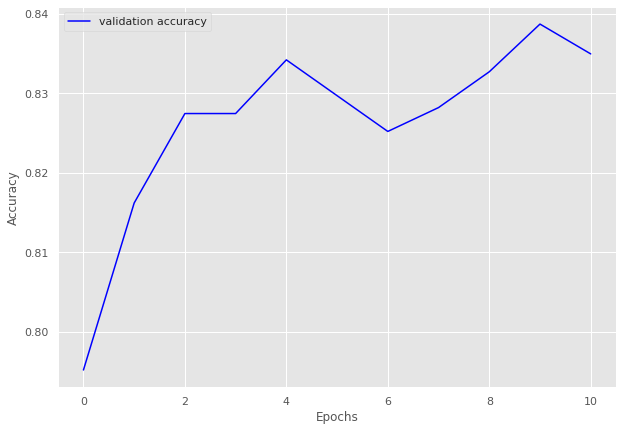

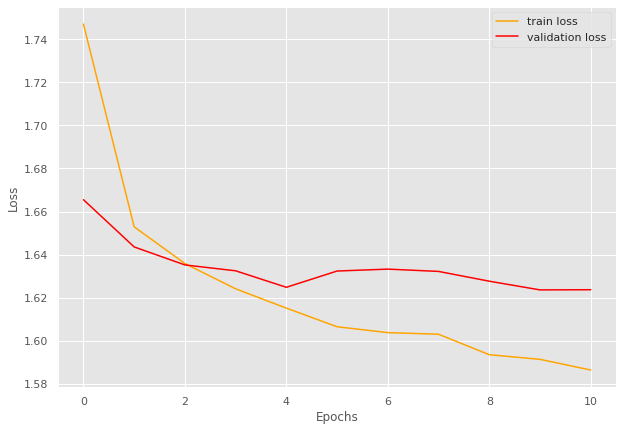

{'0': {'coarse': {'00': 0.8344144759303517, '10': 0.7350631614885627, '20': 0.6717065795249476, '30': 0.587328683607277, '50': 0.4409598595327513, '80': 0.2362093352192362}, 'fine': {'00': {'0': 0.9762140733399405, '1': 0.9764150943396226, '2': 0.9572277227722772, '3': 0.973404255319149, '4': 0.99644128113879, '5': 0.9815242494226328, '7': 0.9389619883040936, '8': 0.9871175523349437, '9': 0.8673469387755102, '11': 0.9451642060861706, '12': 0.9523012552301255, '14': 0.9555808656036446, '15': 0.9640077821011673}, '10': {'0': 0.8848780487804878, '1': 0.8422535211267606, '2': 0.8879103282626101, '3': 0.9231638418079096, '4': 0.9256505576208178, '5': 0.906885758998435, '7': 0.8858381502890174, '8': 0.9591503267973857, '9': 0.7749469214437368, '11': 0.8723911747167561, '12': 0.9203319502074688, '14': 0.8818380743982495, '15': 0.8033088235294118}, '20': {'0': 0.8442064264849075, '1': 0.7038567493112947, '2': 0.8205027494108406, '3': 0.8527889591719379, '4': 0.8386075949367089, '5': 0.80940794

100%|██████████| 100/100 [00:35<00:00,  2.83batch/s, loss=1.34]


train loss 1.3384929168224335, validation loss 1.2298796827142888, validation accuracy 0.8177777777777778
Coarse label 4 Epoch 2
-------------------------------


100%|██████████| 100/100 [00:36<00:00,  2.78batch/s, loss=1.22]


train loss 1.2247234511375427, validation loss 1.2039575576782227, validation accuracy 0.8340740740740741
Coarse label 4 Epoch 3
-------------------------------


100%|██████████| 100/100 [00:35<00:00,  2.82batch/s, loss=1.19]


INFO: Early stopping counter 1 of 5
train loss 1.1949135315418244, validation loss 1.2135724804618142, validation accuracy 0.8325925925925926
Coarse label 4 Epoch 4
-------------------------------


100%|██████████| 100/100 [00:35<00:00,  2.79batch/s, loss=1.18]


train loss 1.1783512699604035, validation loss 1.1930764263326472, validation accuracy 0.8488888888888889
Coarse label 4 Epoch 5
-------------------------------


100%|██████████| 100/100 [00:35<00:00,  2.82batch/s, loss=1.17]


INFO: Early stopping counter 2 of 5
train loss 1.1650220239162445, validation loss 1.1985047297044233, validation accuracy 0.845925925925926
Coarse label 4 Epoch 6
-------------------------------


100%|██████████| 100/100 [00:35<00:00,  2.81batch/s, loss=1.16]


INFO: Early stopping counter 3 of 5
train loss 1.1586169326305389, validation loss 1.1957184184681287, validation accuracy 0.8474074074074074
Coarse label 4 Epoch 7
-------------------------------


100%|██████████| 100/100 [00:35<00:00,  2.82batch/s, loss=1.16]


INFO: Early stopping counter 4 of 5
train loss 1.1564551973342896, validation loss 1.209288477897644, validation accuracy 0.8325925925925926
Coarse label 4 Epoch 8
-------------------------------


100%|██████████| 100/100 [00:35<00:00,  2.81batch/s, loss=1.15]


INFO: Early stopping counter 5 of 5
INFO: Early stopping
Done! Saved model with test accuracy 0.7943706020328382 and loss 1.247874391078949


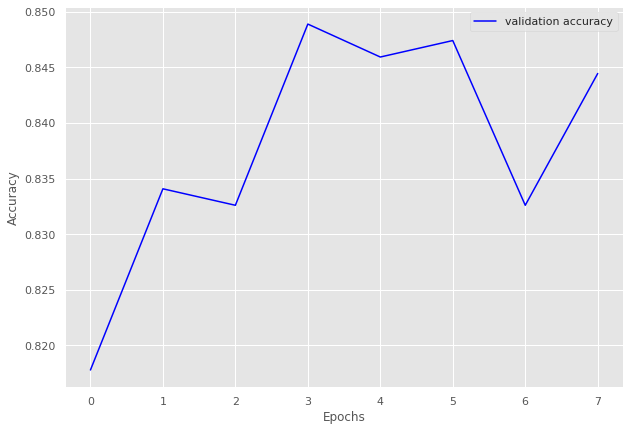

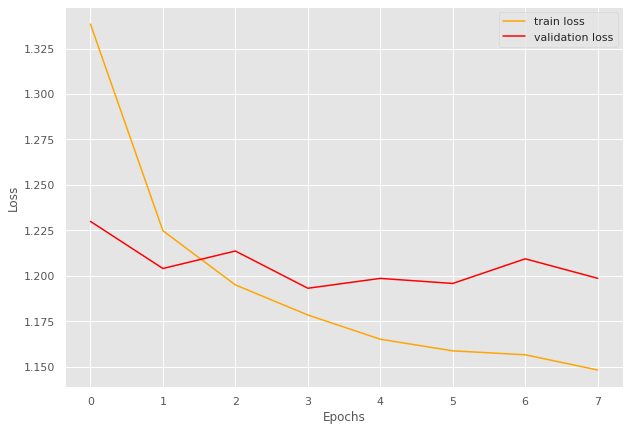

{'0': {'coarse': {'00': 0.8344144759303517, '10': 0.7350631614885627, '20': 0.6717065795249476, '30': 0.587328683607277, '50': 0.4409598595327513, '80': 0.2362093352192362}, 'fine': {'00': {'0': 0.9762140733399405, '1': 0.9764150943396226, '2': 0.9572277227722772, '3': 0.973404255319149, '4': 0.99644128113879, '5': 0.9815242494226328, '7': 0.9389619883040936, '8': 0.9871175523349437, '9': 0.8673469387755102, '11': 0.9451642060861706, '12': 0.9523012552301255, '14': 0.9555808656036446, '15': 0.9640077821011673}, '10': {'0': 0.8848780487804878, '1': 0.8422535211267606, '2': 0.8879103282626101, '3': 0.9231638418079096, '4': 0.9256505576208178, '5': 0.906885758998435, '7': 0.8858381502890174, '8': 0.9591503267973857, '9': 0.7749469214437368, '11': 0.8723911747167561, '12': 0.9203319502074688, '14': 0.8818380743982495, '15': 0.8033088235294118}, '20': {'0': 0.8442064264849075, '1': 0.7038567493112947, '2': 0.8205027494108406, '3': 0.8527889591719379, '4': 0.8386075949367089, '5': 0.80940794

100%|██████████| 39/39 [00:13<00:00,  2.81batch/s, loss=0.439]


train loss 0.4388146828382443, validation loss 0.4220271706581116, validation accuracy 0.8987341772151899
Coarse label 5 Epoch 2
-------------------------------


100%|██████████| 39/39 [00:13<00:00,  2.81batch/s, loss=0.367]


INFO: Early stopping counter 1 of 5
train loss 0.3674274721206763, validation loss 0.4339404304822286, validation accuracy 0.879746835443038
Coarse label 5 Epoch 3
-------------------------------


100%|██████████| 39/39 [00:13<00:00,  2.79batch/s, loss=0.346]


INFO: Early stopping counter 2 of 5
train loss 0.3459341694147159, validation loss 0.4357595046361287, validation accuracy 0.8734177215189873
Coarse label 5 Epoch 4
-------------------------------


100%|██████████| 39/39 [00:13<00:00,  2.79batch/s, loss=0.336]


INFO: Early stopping counter 3 of 5
train loss 0.3359476006948031, validation loss 0.4394269784291585, validation accuracy 0.8670886075949367
Coarse label 5 Epoch 5
-------------------------------


100%|██████████| 39/39 [00:14<00:00,  2.78batch/s, loss=0.333]


INFO: Early stopping counter 4 of 5
train loss 0.33305616715015507, validation loss 0.42721347014109295, validation accuracy 0.8734177215189873
Coarse label 5 Epoch 6
-------------------------------


100%|██████████| 39/39 [00:13<00:00,  2.81batch/s, loss=0.331]


INFO: Early stopping counter 5 of 5
INFO: Early stopping
Done! Saved model with test accuracy 0.9208333333333333 and loss 0.3999277241528034


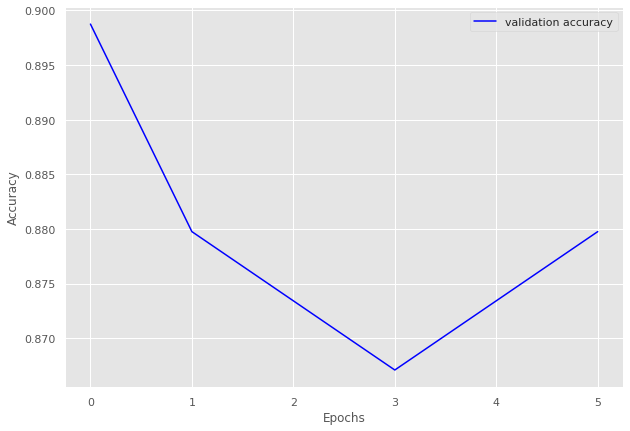

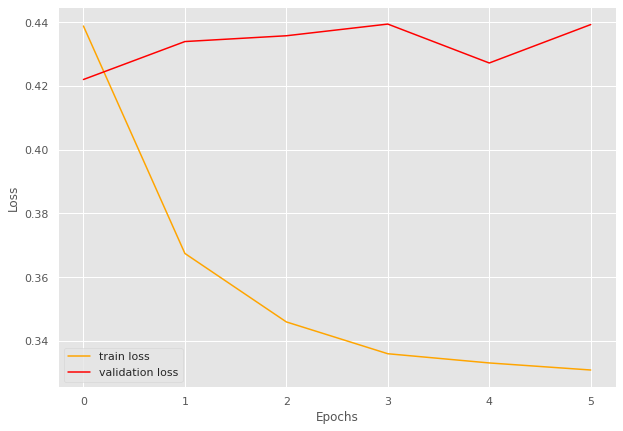

{'0': {'coarse': {'00': 0.8344144759303517, '10': 0.7350631614885627, '20': 0.6717065795249476, '30': 0.587328683607277, '50': 0.4409598595327513, '80': 0.2362093352192362}, 'fine': {'00': {'0': 0.9762140733399405, '1': 0.9764150943396226, '2': 0.9572277227722772, '3': 0.973404255319149, '4': 0.99644128113879, '5': 0.9815242494226328, '7': 0.9389619883040936, '8': 0.9871175523349437, '9': 0.8673469387755102, '11': 0.9451642060861706, '12': 0.9523012552301255, '14': 0.9555808656036446, '15': 0.9640077821011673}, '10': {'0': 0.8848780487804878, '1': 0.8422535211267606, '2': 0.8879103282626101, '3': 0.9231638418079096, '4': 0.9256505576208178, '5': 0.906885758998435, '7': 0.8858381502890174, '8': 0.9591503267973857, '9': 0.7749469214437368, '11': 0.8723911747167561, '12': 0.9203319502074688, '14': 0.8818380743982495, '15': 0.8033088235294118}, '20': {'0': 0.8442064264849075, '1': 0.7038567493112947, '2': 0.8205027494108406, '3': 0.8527889591719379, '4': 0.8386075949367089, '5': 0.80940794

100%|██████████| 113/113 [00:40<00:00,  2.79batch/s, loss=1.46]


train loss 1.4566161854077229, validation loss 1.362797498703003, validation accuracy 0.8090909090909091
Coarse label 6 Epoch 2
-------------------------------


100%|██████████| 113/113 [00:40<00:00,  2.80batch/s, loss=1.36]


INFO: Early stopping counter 1 of 5
train loss 1.359004683199182, validation loss 1.3713557169987605, validation accuracy 0.8025974025974026
Coarse label 6 Epoch 3
-------------------------------


100%|██████████| 113/113 [00:40<00:00,  2.77batch/s, loss=1.33]


INFO: Early stopping counter 2 of 5
train loss 1.3347979794561335, validation loss 1.371576767701369, validation accuracy 0.8038961038961039
Coarse label 6 Epoch 4
-------------------------------


100%|██████████| 113/113 [00:40<00:00,  2.78batch/s, loss=1.32]


INFO: Early stopping counter 3 of 5
train loss 1.3180848771491938, validation loss 1.364570636015672, validation accuracy 0.8220779220779221
Coarse label 6 Epoch 5
-------------------------------


100%|██████████| 113/113 [00:40<00:00,  2.80batch/s, loss=1.31]


train loss 1.3050016017086739, validation loss 1.3229286303887, validation accuracy 0.825974025974026
Coarse label 6 Epoch 6
-------------------------------


100%|██████████| 113/113 [00:40<00:00,  2.78batch/s, loss=1.3]


INFO: Early stopping counter 4 of 5
train loss 1.2972354298144315, validation loss 1.3490591324292696, validation accuracy 0.812987012987013
Coarse label 6 Epoch 7
-------------------------------


100%|██████████| 113/113 [00:41<00:00,  2.74batch/s, loss=1.29]


INFO: Early stopping counter 5 of 5
INFO: Early stopping
Done! Saved model with test accuracy 0.8005677785663591 and loss 1.3945815511371777


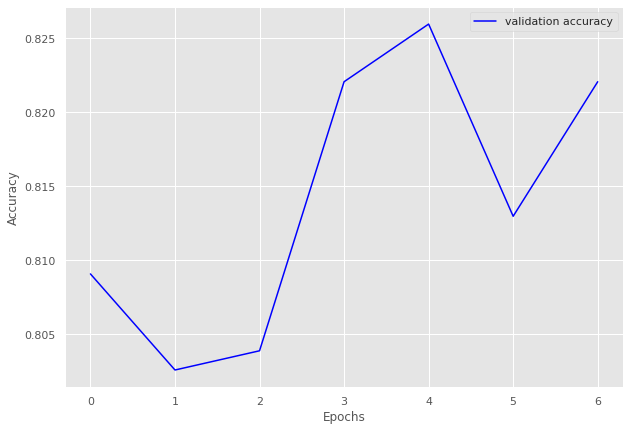

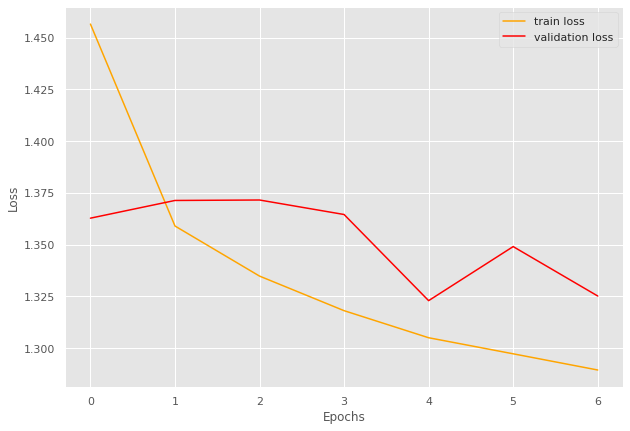

{'0': {'coarse': {'00': 0.8344144759303517, '10': 0.7350631614885627, '20': 0.6717065795249476, '30': 0.587328683607277, '50': 0.4409598595327513, '80': 0.2362093352192362}, 'fine': {'00': {'0': 0.9762140733399405, '1': 0.9764150943396226, '2': 0.9572277227722772, '3': 0.973404255319149, '4': 0.99644128113879, '5': 0.9815242494226328, '7': 0.9389619883040936, '8': 0.9871175523349437, '9': 0.8673469387755102, '11': 0.9451642060861706, '12': 0.9523012552301255, '14': 0.9555808656036446, '15': 0.9640077821011673}, '10': {'0': 0.8848780487804878, '1': 0.8422535211267606, '2': 0.8879103282626101, '3': 0.9231638418079096, '4': 0.9256505576208178, '5': 0.906885758998435, '7': 0.8858381502890174, '8': 0.9591503267973857, '9': 0.7749469214437368, '11': 0.8723911747167561, '12': 0.9203319502074688, '14': 0.8818380743982495, '15': 0.8033088235294118}, '20': {'0': 0.8442064264849075, '1': 0.7038567493112947, '2': 0.8205027494108406, '3': 0.8527889591719379, '4': 0.8386075949367089, '5': 0.80940794

100%|██████████| 85/85 [00:44<00:00,  1.90batch/s, loss=0.929]


train loss 0.9294458866119385, validation loss 0.8580849236912198, validation accuracy 0.8838028169014085
Coarse label 7 Epoch 2
-------------------------------


100%|██████████| 85/85 [01:03<00:00,  1.34batch/s, loss=0.854]


INFO: Early stopping counter 1 of 5
train loss 0.8540870778700884, validation loss 0.8685512741406759, validation accuracy 0.8732394366197183
Coarse label 7 Epoch 3
-------------------------------


100%|██████████| 85/85 [01:05<00:00,  1.30batch/s, loss=0.838]


INFO: Early stopping counter 2 of 5
train loss 0.8379079531220829, validation loss 0.8692355023490058, validation accuracy 0.8661971830985915
Coarse label 7 Epoch 4
-------------------------------


100%|██████████| 85/85 [00:53<00:00,  1.59batch/s, loss=0.831]


INFO: Early stopping counter 3 of 5
train loss 0.8305117873584523, validation loss 0.8595232235060798, validation accuracy 0.8785211267605634
Coarse label 7 Epoch 5
-------------------------------


100%|██████████| 85/85 [00:30<00:00,  2.75batch/s, loss=0.818]


INFO: Early stopping counter 4 of 5
train loss 0.818135032934301, validation loss 0.868832078244951, validation accuracy 0.8697183098591549
Coarse label 7 Epoch 6
-------------------------------


100%|██████████| 85/85 [00:30<00:00,  2.79batch/s, loss=0.818]


train loss 0.8182272581493153, validation loss 0.8577972054481506, validation accuracy 0.8820422535211268
Coarse label 7 Epoch 7
-------------------------------


100%|██████████| 85/85 [00:30<00:00,  2.77batch/s, loss=0.814]


INFO: Early stopping counter 5 of 5
INFO: Early stopping
Done! Saved model with test accuracy 0.8580413297394429 and loss 0.9054075082143148


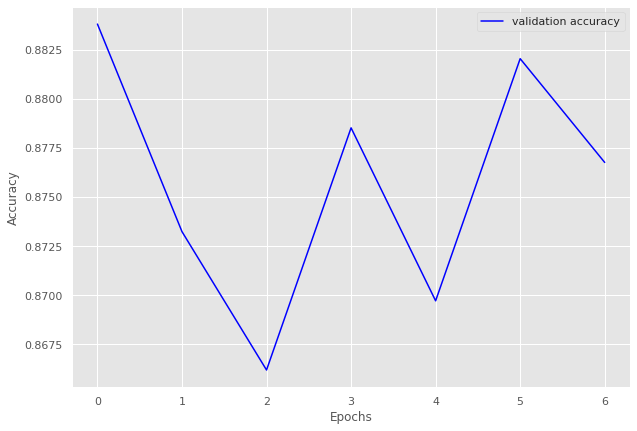

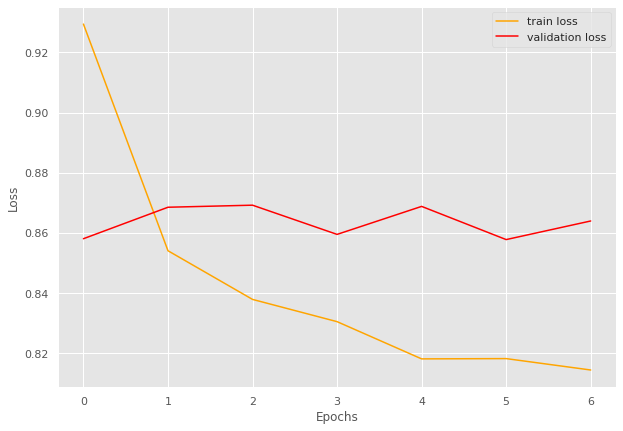

{'0': {'coarse': {'00': 0.8344144759303517, '10': 0.7350631614885627, '20': 0.6717065795249476, '30': 0.587328683607277, '50': 0.4409598595327513, '80': 0.2362093352192362}, 'fine': {'00': {'0': 0.9762140733399405, '1': 0.9764150943396226, '2': 0.9572277227722772, '3': 0.973404255319149, '4': 0.99644128113879, '5': 0.9815242494226328, '7': 0.9389619883040936, '8': 0.9871175523349437, '9': 0.8673469387755102, '11': 0.9451642060861706, '12': 0.9523012552301255, '14': 0.9555808656036446, '15': 0.9640077821011673}, '10': {'0': 0.8848780487804878, '1': 0.8422535211267606, '2': 0.8879103282626101, '3': 0.9231638418079096, '4': 0.9256505576208178, '5': 0.906885758998435, '7': 0.8858381502890174, '8': 0.9591503267973857, '9': 0.7749469214437368, '11': 0.8723911747167561, '12': 0.9203319502074688, '14': 0.8818380743982495, '15': 0.8033088235294118}, '20': {'0': 0.8442064264849075, '1': 0.7038567493112947, '2': 0.8205027494108406, '3': 0.8527889591719379, '4': 0.8386075949367089, '5': 0.80940794

100%|██████████| 129/129 [00:46<00:00,  2.75batch/s, loss=1.45]


train loss 1.4527836197106414, validation loss 1.448505197252546, validation accuracy 0.7035175879396985
Coarse label 8 Epoch 2
-------------------------------


100%|██████████| 129/129 [00:46<00:00,  2.78batch/s, loss=1.35]


train loss 1.349402898041777, validation loss 1.4482917104448592, validation accuracy 0.7060301507537688
Coarse label 8 Epoch 3
-------------------------------


100%|██████████| 129/129 [00:46<00:00,  2.78batch/s, loss=1.33]


INFO: Early stopping counter 1 of 5
train loss 1.3336507174395775, validation loss 1.4504810912268502, validation accuracy 0.7110552763819096
Coarse label 8 Epoch 4
-------------------------------


100%|██████████| 129/129 [00:46<00:00,  2.78batch/s, loss=1.32]


INFO: Early stopping counter 2 of 5
train loss 1.3161786461985387, validation loss 1.4525162322180611, validation accuracy 0.7110552763819096
Coarse label 8 Epoch 5
-------------------------------


100%|██████████| 129/129 [00:46<00:00,  2.77batch/s, loss=1.3]


train loss 1.3024150585943415, validation loss 1.4391394002096993, validation accuracy 0.7361809045226131
Coarse label 8 Epoch 6
-------------------------------


100%|██████████| 129/129 [00:46<00:00,  2.78batch/s, loss=1.3] 


INFO: Early stopping counter 3 of 5
train loss 1.2965886075367299, validation loss 1.4502339703696114, validation accuracy 0.7211055276381909
Coarse label 8 Epoch 7
-------------------------------


100%|██████████| 129/129 [00:47<00:00,  2.74batch/s, loss=1.29]


train loss 1.2872858879178068, validation loss 1.4222759349005563, validation accuracy 0.7311557788944724
Coarse label 8 Epoch 8
-------------------------------


100%|██████████| 129/129 [00:46<00:00,  2.78batch/s, loss=1.28]


train loss 1.2820017079050228, validation loss 1.411271401814052, validation accuracy 0.7462311557788944
Coarse label 8 Epoch 9
-------------------------------


100%|██████████| 129/129 [00:46<00:00,  2.78batch/s, loss=1.28]


INFO: Early stopping counter 4 of 5
train loss 1.2784891304119612, validation loss 1.434840270451137, validation accuracy 0.7336683417085427
Coarse label 8 Epoch 10
-------------------------------


100%|██████████| 129/129 [00:49<00:00,  2.61batch/s, loss=1.28]


INFO: Early stopping counter 5 of 5
INFO: Early stopping
Done! Saved model with test accuracy 0.8039735099337748 and loss 1.3669648468494415


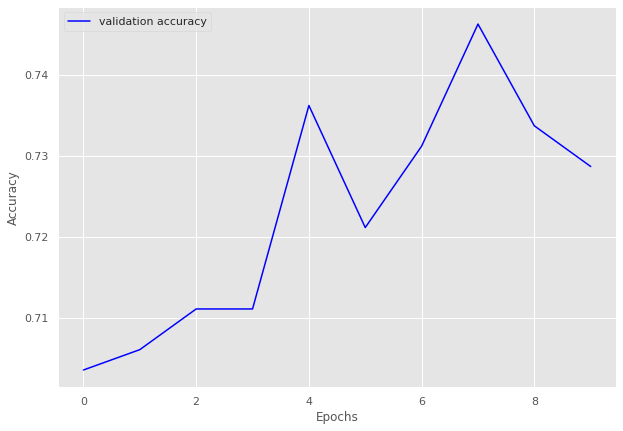

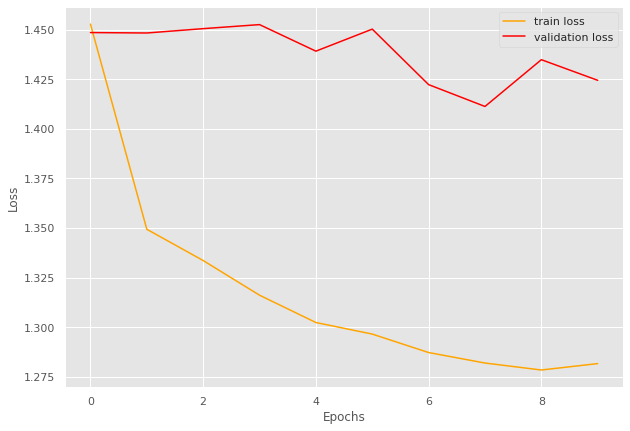

{'0': {'coarse': {'00': 0.8344144759303517, '10': 0.7350631614885627, '20': 0.6717065795249476, '30': 0.587328683607277, '50': 0.4409598595327513, '80': 0.2362093352192362}, 'fine': {'00': {'0': 0.9762140733399405, '1': 0.9764150943396226, '2': 0.9572277227722772, '3': 0.973404255319149, '4': 0.99644128113879, '5': 0.9815242494226328, '7': 0.9389619883040936, '8': 0.9871175523349437, '9': 0.8673469387755102, '11': 0.9451642060861706, '12': 0.9523012552301255, '14': 0.9555808656036446, '15': 0.9640077821011673}, '10': {'0': 0.8848780487804878, '1': 0.8422535211267606, '2': 0.8879103282626101, '3': 0.9231638418079096, '4': 0.9256505576208178, '5': 0.906885758998435, '7': 0.8858381502890174, '8': 0.9591503267973857, '9': 0.7749469214437368, '11': 0.8723911747167561, '12': 0.9203319502074688, '14': 0.8818380743982495, '15': 0.8033088235294118}, '20': {'0': 0.8442064264849075, '1': 0.7038567493112947, '2': 0.8205027494108406, '3': 0.8527889591719379, '4': 0.8386075949367089, '5': 0.80940794

100%|██████████| 162/162 [00:58<00:00,  2.76batch/s, loss=1.77]


train loss 1.7700781174647955, validation loss 1.6838465758732386, validation accuracy 0.778698224852071
Coarse label 9 Epoch 2
-------------------------------


100%|██████████| 162/162 [00:58<00:00,  2.77batch/s, loss=1.68]


train loss 1.6751901610398, validation loss 1.6768624101366316, validation accuracy 0.7869822485207101
Coarse label 9 Epoch 3
-------------------------------


100%|██████████| 162/162 [00:58<00:00,  2.77batch/s, loss=1.66]


INFO: Early stopping counter 1 of 5
train loss 1.6556845336784551, validation loss 1.6829743215015955, validation accuracy 0.7810650887573964
Coarse label 9 Epoch 4
-------------------------------


100%|██████████| 162/162 [00:58<00:00,  2.78batch/s, loss=1.64]


train loss 1.6418440253646285, validation loss 1.668003831590925, validation accuracy 0.7928994082840237
Coarse label 9 Epoch 5
-------------------------------


100%|██████████| 162/162 [00:58<00:00,  2.78batch/s, loss=1.63]


INFO: Early stopping counter 2 of 5
train loss 1.630054223684617, validation loss 1.6748962487493242, validation accuracy 0.7822485207100591
Coarse label 9 Epoch 6
-------------------------------


100%|██████████| 162/162 [00:58<00:00,  2.76batch/s, loss=1.62]


INFO: Early stopping counter 3 of 5
train loss 1.6220073972219302, validation loss 1.6884128621646337, validation accuracy 0.7763313609467456
Coarse label 9 Epoch 7
-------------------------------


100%|██████████| 162/162 [00:58<00:00,  2.79batch/s, loss=1.62]


INFO: Early stopping counter 4 of 5
train loss 1.6165367048463704, validation loss 1.6743423768452235, validation accuracy 0.7893491124260354
Coarse label 9 Epoch 8
-------------------------------


100%|██████████| 162/162 [00:58<00:00,  2.78batch/s, loss=1.61]


train loss 1.6106086866355236, validation loss 1.6668043221746172, validation accuracy 0.7917159763313609
Coarse label 9 Epoch 9
-------------------------------


100%|██████████| 162/162 [00:58<00:00,  2.78batch/s, loss=1.61]


INFO: Early stopping counter 5 of 5
INFO: Early stopping
Done! Saved model with test accuracy 0.7995037220843673 and loss 1.6583771742880344


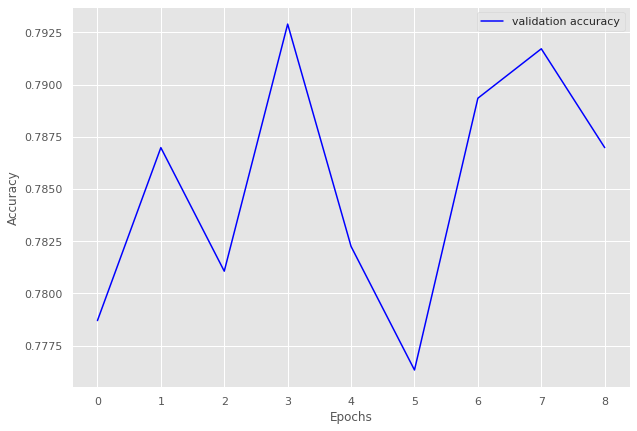

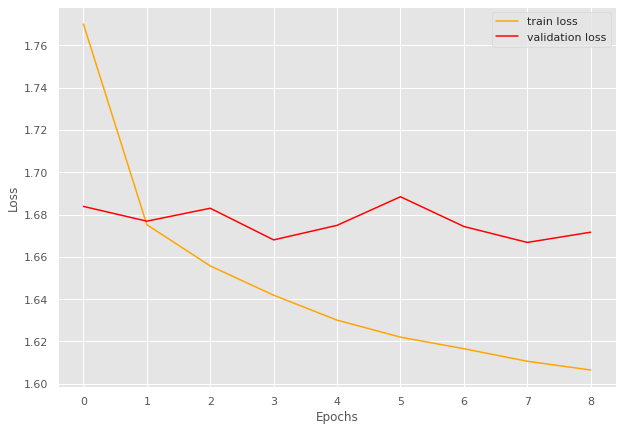

{'0': {'coarse': {'00': 0.8344144759303517, '10': 0.7350631614885627, '20': 0.6717065795249476, '30': 0.587328683607277, '50': 0.4409598595327513, '80': 0.2362093352192362}, 'fine': {'00': {'0': 0.9762140733399405, '1': 0.9764150943396226, '2': 0.9572277227722772, '3': 0.973404255319149, '4': 0.99644128113879, '5': 0.9815242494226328, '7': 0.9389619883040936, '8': 0.9871175523349437, '9': 0.8673469387755102, '11': 0.9451642060861706, '12': 0.9523012552301255, '14': 0.9555808656036446, '15': 0.9640077821011673}, '10': {'0': 0.8848780487804878, '1': 0.8422535211267606, '2': 0.8879103282626101, '3': 0.9231638418079096, '4': 0.9256505576208178, '5': 0.906885758998435, '7': 0.8858381502890174, '8': 0.9591503267973857, '9': 0.7749469214437368, '11': 0.8723911747167561, '12': 0.9203319502074688, '14': 0.8818380743982495, '15': 0.8033088235294118}, '20': {'0': 0.8442064264849075, '1': 0.7038567493112947, '2': 0.8205027494108406, '3': 0.8527889591719379, '4': 0.8386075949367089, '5': 0.80940794

100%|██████████| 73/73 [00:27<00:00,  2.69batch/s, loss=0.945]


train loss 0.9450439941393186, validation loss 0.845582589507103, validation accuracy 0.8958333333333334
Coarse label 11 Epoch 2
-------------------------------


100%|██████████| 73/73 [00:26<00:00,  2.80batch/s, loss=0.86] 


train loss 0.8595364542856608, validation loss 0.8339363187551498, validation accuracy 0.90625
Coarse label 11 Epoch 3
-------------------------------


100%|██████████| 73/73 [00:26<00:00,  2.80batch/s, loss=0.837]


train loss 0.8372276882602744, validation loss 0.8280946463346481, validation accuracy 0.9166666666666666
Coarse label 11 Epoch 4
-------------------------------


100%|██████████| 73/73 [00:26<00:00,  2.78batch/s, loss=0.819]


INFO: Early stopping counter 1 of 5
train loss 0.8190036579354169, validation loss 0.8372949361801147, validation accuracy 0.9041666666666667
Coarse label 11 Epoch 5
-------------------------------


100%|██████████| 73/73 [00:26<00:00,  2.81batch/s, loss=0.811]


INFO: Early stopping counter 2 of 5
train loss 0.8111579932578622, validation loss 0.8365452289581299, validation accuracy 0.9041666666666667
Coarse label 11 Epoch 6
-------------------------------


100%|██████████| 73/73 [00:26<00:00,  2.77batch/s, loss=0.807]


INFO: Early stopping counter 3 of 5
train loss 0.8073924992182483, validation loss 0.8451809883117676, validation accuracy 0.8958333333333334
Coarse label 11 Epoch 7
-------------------------------


100%|██████████| 73/73 [00:26<00:00,  2.75batch/s, loss=0.8]  


INFO: Early stopping counter 4 of 5
train loss 0.8002162200130828, validation loss 0.8368801027536392, validation accuracy 0.9104166666666667
Coarse label 11 Epoch 8
-------------------------------


100%|██████████| 73/73 [00:26<00:00,  2.79batch/s, loss=0.802]


INFO: Early stopping counter 5 of 5
INFO: Early stopping
Done! Saved model with test accuracy 0.8459152016546019 and loss 0.9290416240692139


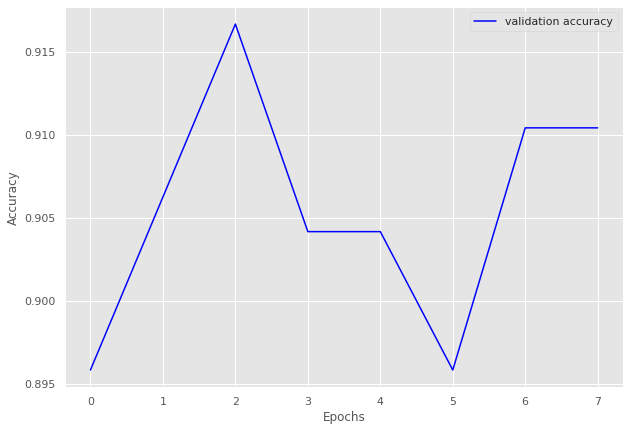

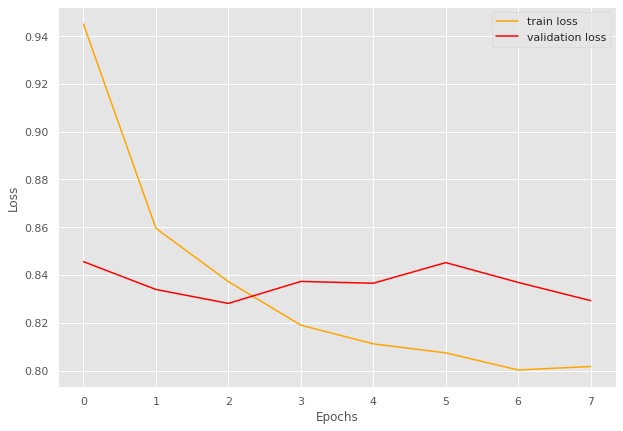

{'0': {'coarse': {'00': 0.8344144759303517, '10': 0.7350631614885627, '20': 0.6717065795249476, '30': 0.587328683607277, '50': 0.4409598595327513, '80': 0.2362093352192362}, 'fine': {'00': {'0': 0.9762140733399405, '1': 0.9764150943396226, '2': 0.9572277227722772, '3': 0.973404255319149, '4': 0.99644128113879, '5': 0.9815242494226328, '7': 0.9389619883040936, '8': 0.9871175523349437, '9': 0.8673469387755102, '11': 0.9451642060861706, '12': 0.9523012552301255, '14': 0.9555808656036446, '15': 0.9640077821011673}, '10': {'0': 0.8848780487804878, '1': 0.8422535211267606, '2': 0.8879103282626101, '3': 0.9231638418079096, '4': 0.9256505576208178, '5': 0.906885758998435, '7': 0.8858381502890174, '8': 0.9591503267973857, '9': 0.7749469214437368, '11': 0.8723911747167561, '12': 0.9203319502074688, '14': 0.8818380743982495, '15': 0.8033088235294118}, '20': {'0': 0.8442064264849075, '1': 0.7038567493112947, '2': 0.8205027494108406, '3': 0.8527889591719379, '4': 0.8386075949367089, '5': 0.80940794

100%|██████████| 77/77 [00:27<00:00,  2.78batch/s, loss=1.39]


train loss 1.3938953195299422, validation loss 1.3087653262274606, validation accuracy 0.7297297297297297
Coarse label 12 Epoch 2
-------------------------------


100%|██████████| 77/77 [00:27<00:00,  2.79batch/s, loss=1.27]


train loss 1.2723592999693636, validation loss 1.3054647275379725, validation accuracy 0.7297297297297297
Coarse label 12 Epoch 3
-------------------------------


100%|██████████| 77/77 [00:27<00:00,  2.80batch/s, loss=1.24]


train loss 1.2387211508565135, validation loss 1.2883208990097046, validation accuracy 0.7545045045045045
Coarse label 12 Epoch 4
-------------------------------


100%|██████████| 77/77 [00:28<00:00,  2.74batch/s, loss=1.22]


train loss 1.2155976899258503, validation loss 1.2856793233326502, validation accuracy 0.7454954954954955
Coarse label 12 Epoch 5
-------------------------------


100%|██████████| 77/77 [00:27<00:00,  2.79batch/s, loss=1.2] 


train loss 1.1981842827487301, validation loss 1.2855473075594221, validation accuracy 0.759009009009009
Coarse label 12 Epoch 6
-------------------------------


100%|██████████| 77/77 [00:27<00:00,  2.77batch/s, loss=1.19]


INFO: Early stopping counter 1 of 5
train loss 1.191308651651655, validation loss 1.2967709302902222, validation accuracy 0.7454954954954955
Coarse label 12 Epoch 7
-------------------------------


100%|██████████| 77/77 [00:46<00:00,  1.65batch/s, loss=1.18]


train loss 1.1753385949444461, validation loss 1.2615092992782593, validation accuracy 0.7837837837837838
Coarse label 12 Epoch 8
-------------------------------


100%|██████████| 77/77 [01:00<00:00,  1.27batch/s, loss=1.17]


INFO: Early stopping counter 2 of 5
train loss 1.1715257461968955, validation loss 1.2836373022624425, validation accuracy 0.7567567567567568
Coarse label 12 Epoch 9
-------------------------------


100%|██████████| 77/77 [00:55<00:00,  1.38batch/s, loss=1.15]


INFO: Early stopping counter 3 of 5
train loss 1.1527374115857212, validation loss 1.2744600943156652, validation accuracy 0.7657657657657657
Coarse label 12 Epoch 10
-------------------------------


100%|██████████| 77/77 [00:57<00:00,  1.34batch/s, loss=1.15]


INFO: Early stopping counter 4 of 5
train loss 1.1474193535841906, validation loss 1.2733090094157629, validation accuracy 0.7635135135135135
Coarse label 12 Epoch 11
-------------------------------


100%|██████████| 77/77 [00:28<00:00,  2.74batch/s, loss=1.14]


INFO: Early stopping counter 5 of 5
INFO: Early stopping
Done! Saved model with test accuracy 0.7374872318692544 and loss 1.2934520989656448


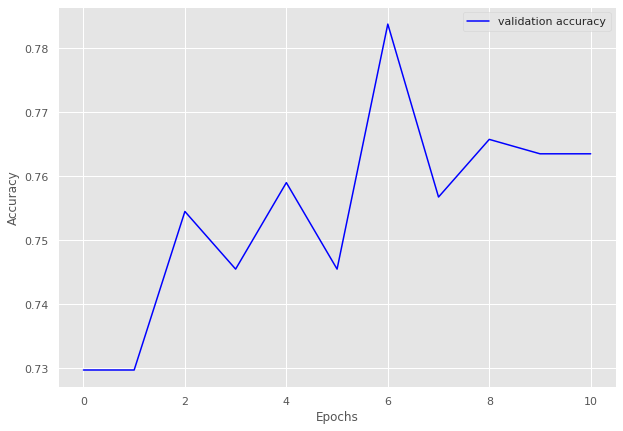

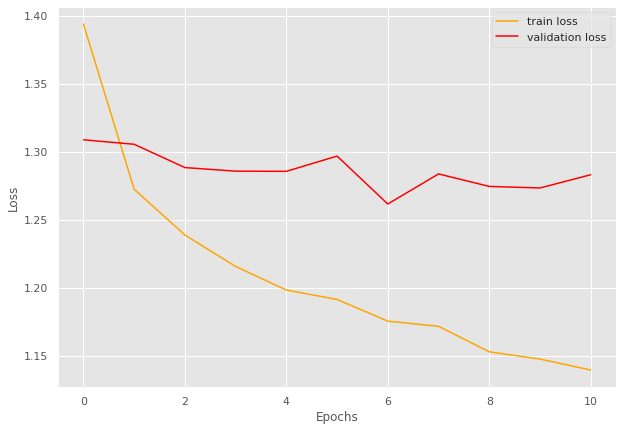

{'0': {'coarse': {'00': 0.8344144759303517, '10': 0.7350631614885627, '20': 0.6717065795249476, '30': 0.587328683607277, '50': 0.4409598595327513, '80': 0.2362093352192362}, 'fine': {'00': {'0': 0.9762140733399405, '1': 0.9764150943396226, '2': 0.9572277227722772, '3': 0.973404255319149, '4': 0.99644128113879, '5': 0.9815242494226328, '7': 0.9389619883040936, '8': 0.9871175523349437, '9': 0.8673469387755102, '11': 0.9451642060861706, '12': 0.9523012552301255, '14': 0.9555808656036446, '15': 0.9640077821011673}, '10': {'0': 0.8848780487804878, '1': 0.8422535211267606, '2': 0.8879103282626101, '3': 0.9231638418079096, '4': 0.9256505576208178, '5': 0.906885758998435, '7': 0.8858381502890174, '8': 0.9591503267973857, '9': 0.7749469214437368, '11': 0.8723911747167561, '12': 0.9203319502074688, '14': 0.8818380743982495, '15': 0.8033088235294118}, '20': {'0': 0.8442064264849075, '1': 0.7038567493112947, '2': 0.8205027494108406, '3': 0.8527889591719379, '4': 0.8386075949367089, '5': 0.80940794

100%|██████████| 63/63 [00:22<00:00,  2.79batch/s, loss=0.735]


train loss 0.7348822232276674, validation loss 0.7424023747444153, validation accuracy 0.8142857142857143
Coarse label 13 Epoch 2
-------------------------------


100%|██████████| 63/63 [00:22<00:00,  2.82batch/s, loss=0.664]


INFO: Early stopping counter 1 of 5
train loss 0.6638538250847469, validation loss 0.7556917905807495, validation accuracy 0.8071428571428572
Coarse label 13 Epoch 3
-------------------------------


100%|██████████| 63/63 [00:22<00:00,  2.77batch/s, loss=0.636]


INFO: Early stopping counter 2 of 5
train loss 0.6359206258304535, validation loss 0.744894552230835, validation accuracy 0.8
Coarse label 13 Epoch 4
-------------------------------


100%|██████████| 63/63 [00:22<00:00,  2.80batch/s, loss=0.624]


train loss 0.6237998235793341, validation loss 0.7221886277198791, validation accuracy 0.8321428571428572
Coarse label 13 Epoch 5
-------------------------------


100%|██████████| 63/63 [00:22<00:00,  2.75batch/s, loss=0.613]


train loss 0.6134168401597038, validation loss 0.7218951344490051, validation accuracy 0.8214285714285714
Coarse label 13 Epoch 6
-------------------------------


100%|██████████| 63/63 [00:22<00:00,  2.80batch/s, loss=0.613]


INFO: Early stopping counter 3 of 5
train loss 0.6127382725004166, validation loss 0.7317691326141358, validation accuracy 0.8357142857142857
Coarse label 13 Epoch 7
-------------------------------


100%|██████████| 63/63 [00:22<00:00,  2.82batch/s, loss=0.6]  


INFO: Early stopping counter 4 of 5
train loss 0.6002275830223447, validation loss 0.7273492097854615, validation accuracy 0.8357142857142857
Coarse label 13 Epoch 8
-------------------------------


100%|██████████| 63/63 [00:22<00:00,  2.81batch/s, loss=0.6]  


INFO: Early stopping counter 5 of 5
INFO: Early stopping
Done! Saved model with test accuracy 0.8457583547557841 and loss 0.7220123777022729


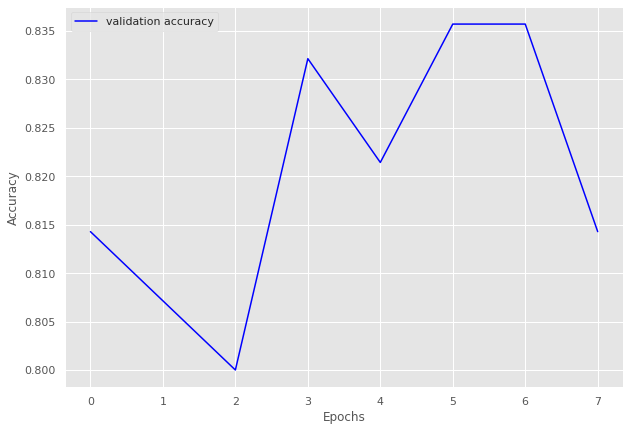

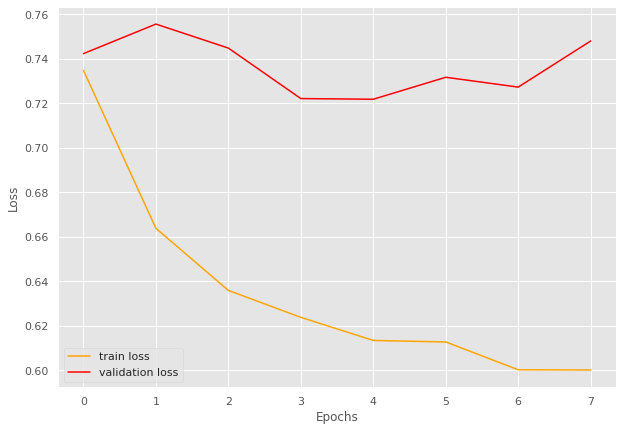

{'0': {'coarse': {'00': 0.8344144759303517, '10': 0.7350631614885627, '20': 0.6717065795249476, '30': 0.587328683607277, '50': 0.4409598595327513, '80': 0.2362093352192362}, 'fine': {'00': {'0': 0.9762140733399405, '1': 0.9764150943396226, '2': 0.9572277227722772, '3': 0.973404255319149, '4': 0.99644128113879, '5': 0.9815242494226328, '7': 0.9389619883040936, '8': 0.9871175523349437, '9': 0.8673469387755102, '11': 0.9451642060861706, '12': 0.9523012552301255, '14': 0.9555808656036446, '15': 0.9640077821011673}, '10': {'0': 0.8848780487804878, '1': 0.8422535211267606, '2': 0.8879103282626101, '3': 0.9231638418079096, '4': 0.9256505576208178, '5': 0.906885758998435, '7': 0.8858381502890174, '8': 0.9591503267973857, '9': 0.7749469214437368, '11': 0.8723911747167561, '12': 0.9203319502074688, '14': 0.8818380743982495, '15': 0.8033088235294118}, '20': {'0': 0.8442064264849075, '1': 0.7038567493112947, '2': 0.8205027494108406, '3': 0.8527889591719379, '4': 0.8386075949367089, '5': 0.80940794

100%|██████████| 140/140 [00:50<00:00,  2.75batch/s, loss=1.25]


train loss 1.2519443026610784, validation loss 1.1885685920715332, validation accuracy 0.858843537414966
Coarse label 14 Epoch 2
-------------------------------


100%|██████████| 140/140 [00:50<00:00,  2.78batch/s, loss=1.18]


INFO: Early stopping counter 1 of 5
train loss 1.1777272871562412, validation loss 1.1964519739151, validation accuracy 0.858843537414966
Coarse label 14 Epoch 3
-------------------------------


100%|██████████| 140/140 [00:50<00:00,  2.78batch/s, loss=1.16]


train loss 1.1639046967029572, validation loss 1.179526650905609, validation accuracy 0.8741496598639455
Coarse label 14 Epoch 4
-------------------------------


100%|██████████| 140/140 [00:50<00:00,  2.78batch/s, loss=1.15]


INFO: Early stopping counter 2 of 5
train loss 1.15310012953622, validation loss 1.1844147324562073, validation accuracy 0.8639455782312925
Coarse label 14 Epoch 5
-------------------------------


100%|██████████| 140/140 [00:50<00:00,  2.79batch/s, loss=1.15]


train loss 1.1494808401380265, validation loss 1.1736886262893678, validation accuracy 0.8758503401360545
Coarse label 14 Epoch 6
-------------------------------


100%|██████████| 140/140 [00:50<00:00,  2.78batch/s, loss=1.14]


INFO: Early stopping counter 3 of 5
train loss 1.143955134493964, validation loss 1.180027997493744, validation accuracy 0.8707482993197279
Coarse label 14 Epoch 7
-------------------------------


100%|██████████| 140/140 [00:50<00:00,  2.76batch/s, loss=1.14]


INFO: Early stopping counter 4 of 5
train loss 1.137785085609981, validation loss 1.18821861743927, validation accuracy 0.8639455782312925
Coarse label 14 Epoch 8
-------------------------------


100%|██████████| 140/140 [00:50<00:00,  2.78batch/s, loss=1.14]


INFO: Early stopping counter 5 of 5
INFO: Early stopping
Done! Saved model with test accuracy 0.8577878103837472 and loss 1.1818923822471075


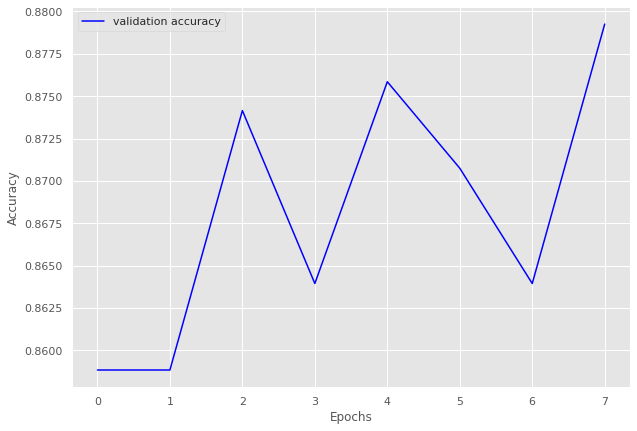

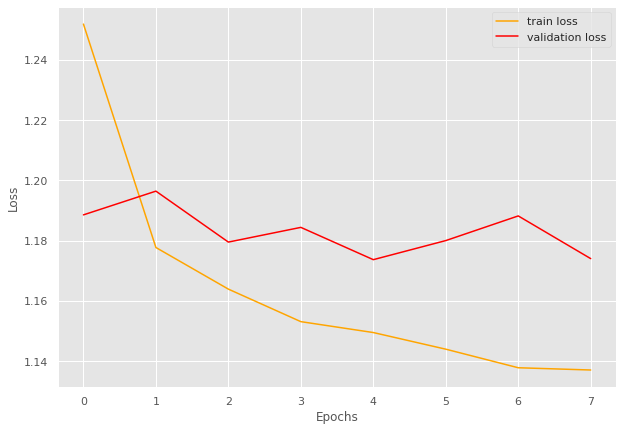

{'0': {'coarse': {'00': 0.8344144759303517, '10': 0.7350631614885627, '20': 0.6717065795249476, '30': 0.587328683607277, '50': 0.4409598595327513, '80': 0.2362093352192362}, 'fine': {'00': {'0': 0.9762140733399405, '1': 0.9764150943396226, '2': 0.9572277227722772, '3': 0.973404255319149, '4': 0.99644128113879, '5': 0.9815242494226328, '7': 0.9389619883040936, '8': 0.9871175523349437, '9': 0.8673469387755102, '11': 0.9451642060861706, '12': 0.9523012552301255, '14': 0.9555808656036446, '15': 0.9640077821011673}, '10': {'0': 0.8848780487804878, '1': 0.8422535211267606, '2': 0.8879103282626101, '3': 0.9231638418079096, '4': 0.9256505576208178, '5': 0.906885758998435, '7': 0.8858381502890174, '8': 0.9591503267973857, '9': 0.7749469214437368, '11': 0.8723911747167561, '12': 0.9203319502074688, '14': 0.8818380743982495, '15': 0.8033088235294118}, '20': {'0': 0.8442064264849075, '1': 0.7038567493112947, '2': 0.8205027494108406, '3': 0.8527889591719379, '4': 0.8386075949367089, '5': 0.80940794

100%|██████████| 72/72 [00:25<00:00,  2.80batch/s, loss=0.98] 


train loss 0.9803832239574857, validation loss 0.8827535808086395, validation accuracy 0.8565400843881856
Coarse label 15 Epoch 2
-------------------------------


100%|██████████| 72/72 [00:25<00:00,  2.77batch/s, loss=0.876]


train loss 0.8763878593842188, validation loss 0.8793723881244659, validation accuracy 0.8565400843881856
Coarse label 15 Epoch 3
-------------------------------


100%|██████████| 72/72 [00:25<00:00,  2.78batch/s, loss=0.852]


train loss 0.8521997647153007, validation loss 0.8791050165891647, validation accuracy 0.8607594936708861
Coarse label 15 Epoch 4
-------------------------------


100%|██████████| 72/72 [00:25<00:00,  2.77batch/s, loss=0.836]


INFO: Early stopping counter 1 of 5
train loss 0.835864739285575, validation loss 0.8898374885320663, validation accuracy 0.8459915611814346
Coarse label 15 Epoch 5
-------------------------------


100%|██████████| 72/72 [00:25<00:00,  2.80batch/s, loss=0.82] 


INFO: Early stopping counter 2 of 5
train loss 0.8198520549469523, validation loss 0.883281521499157, validation accuracy 0.8628691983122363
Coarse label 15 Epoch 6
-------------------------------


100%|██████████| 72/72 [00:25<00:00,  2.82batch/s, loss=0.81] 


INFO: Early stopping counter 3 of 5
train loss 0.8101113554504182, validation loss 0.8930215761065483, validation accuracy 0.8459915611814346
Coarse label 15 Epoch 7
-------------------------------


100%|██████████| 72/72 [00:26<00:00,  2.75batch/s, loss=0.805]


INFO: Early stopping counter 4 of 5
train loss 0.8052884514133135, validation loss 0.8879798129200935, validation accuracy 0.8502109704641351
Coarse label 15 Epoch 8
-------------------------------


100%|██████████| 72/72 [00:25<00:00,  2.80batch/s, loss=0.802]


INFO: Early stopping counter 5 of 5
INFO: Early stopping
Done! Saved model with test accuracy 0.8329545454545455 and loss 0.9215931126049587


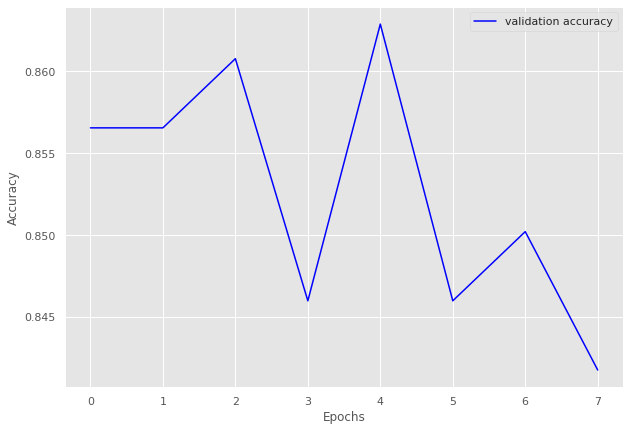

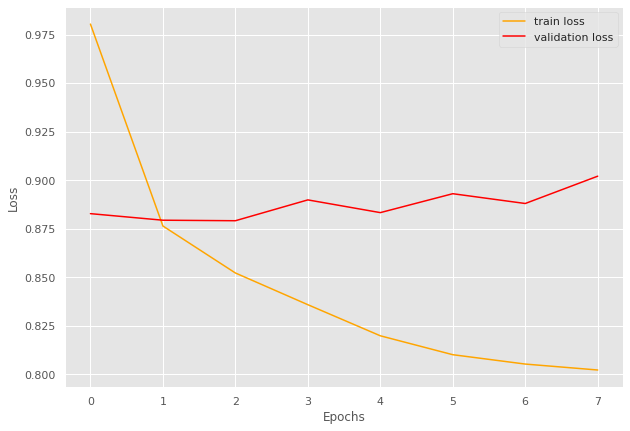

{'0': {'coarse': {'00': 0.8344144759303517, '10': 0.7350631614885627, '20': 0.6717065795249476, '30': 0.587328683607277, '50': 0.4409598595327513, '80': 0.2362093352192362}, 'fine': {'00': {'0': 0.9762140733399405, '1': 0.9764150943396226, '2': 0.9572277227722772, '3': 0.973404255319149, '4': 0.99644128113879, '5': 0.9815242494226328, '7': 0.9389619883040936, '8': 0.9871175523349437, '9': 0.8673469387755102, '11': 0.9451642060861706, '12': 0.9523012552301255, '14': 0.9555808656036446, '15': 0.9640077821011673}, '10': {'0': 0.8848780487804878, '1': 0.8422535211267606, '2': 0.8879103282626101, '3': 0.9231638418079096, '4': 0.9256505576208178, '5': 0.906885758998435, '7': 0.8858381502890174, '8': 0.9591503267973857, '9': 0.7749469214437368, '11': 0.8723911747167561, '12': 0.9203319502074688, '14': 0.8818380743982495, '15': 0.8033088235294118}, '20': {'0': 0.8442064264849075, '1': 0.7038567493112947, '2': 0.8205027494108406, '3': 0.8527889591719379, '4': 0.8386075949367089, '5': 0.80940794

100%|██████████| 66/66 [00:23<00:00,  2.78batch/s, loss=0.725]


train loss 0.7252704275376869, validation loss 0.7060425778230032, validation accuracy 0.8365650969529086
Coarse label 16 Epoch 2
-------------------------------


100%|██████████| 66/66 [00:24<00:00,  2.67batch/s, loss=0.647]


train loss 0.6474950421940197, validation loss 0.6874207854270935, validation accuracy 0.853185595567867
Coarse label 16 Epoch 3
-------------------------------


100%|██████████| 66/66 [00:23<00:00,  2.83batch/s, loss=0.613]


train loss 0.6125421767885034, validation loss 0.683081309000651, validation accuracy 0.8559556786703602
Coarse label 16 Epoch 4
-------------------------------


100%|██████████| 66/66 [00:23<00:00,  2.78batch/s, loss=0.596]


INFO: Early stopping counter 1 of 5
train loss 0.5957453756621389, validation loss 0.6960175236066183, validation accuracy 0.8393351800554016
Coarse label 16 Epoch 5
-------------------------------


100%|██████████| 66/66 [00:23<00:00,  2.78batch/s, loss=0.592]


train loss 0.5923259646603556, validation loss 0.6730925043423971, validation accuracy 0.8642659279778393
Coarse label 16 Epoch 6
-------------------------------


100%|██████████| 66/66 [00:23<00:00,  2.83batch/s, loss=0.594]


INFO: Early stopping counter 2 of 5
train loss 0.5940409564610684, validation loss 0.7047223349412283, validation accuracy 0.8310249307479224
Coarse label 16 Epoch 7
-------------------------------


100%|██████████| 66/66 [00:23<00:00,  2.79batch/s, loss=0.59] 


INFO: Early stopping counter 3 of 5
train loss 0.5903321920019208, validation loss 0.7020920117696127, validation accuracy 0.8337950138504155
Coarse label 16 Epoch 8
-------------------------------


100%|██████████| 66/66 [00:23<00:00,  2.79batch/s, loss=0.589]


INFO: Early stopping counter 4 of 5
train loss 0.5892822462500948, validation loss 0.7119251489639282, validation accuracy 0.8310249307479224
Coarse label 16 Epoch 9
-------------------------------


100%|██████████| 66/66 [00:23<00:00,  2.79batch/s, loss=0.588]


INFO: Early stopping counter 5 of 5
INFO: Early stopping
Done! Saved model with test accuracy 0.8803526448362721 and loss 0.6777265438666711


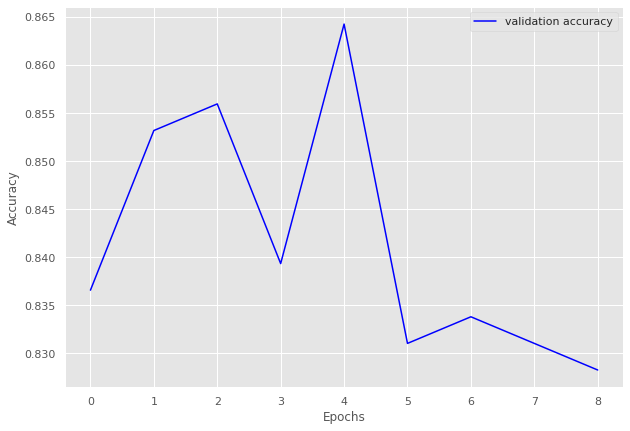

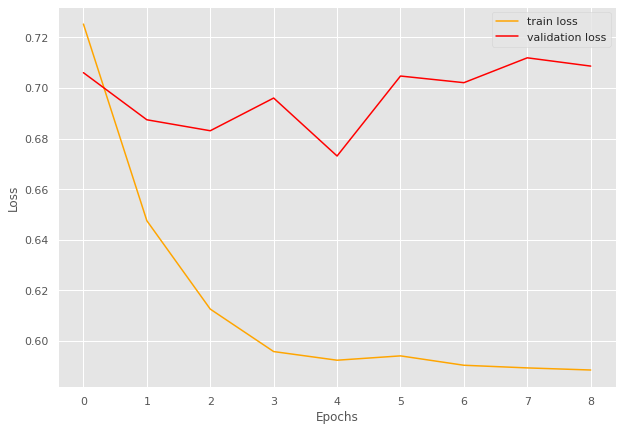

{'0': {'coarse': {'00': 0.8344144759303517, '10': 0.7350631614885627, '20': 0.6717065795249476, '30': 0.587328683607277, '50': 0.4409598595327513, '80': 0.2362093352192362}, 'fine': {'00': {'0': 0.9762140733399405, '1': 0.9764150943396226, '2': 0.9572277227722772, '3': 0.973404255319149, '4': 0.99644128113879, '5': 0.9815242494226328, '7': 0.9389619883040936, '8': 0.9871175523349437, '9': 0.8673469387755102, '11': 0.9451642060861706, '12': 0.9523012552301255, '14': 0.9555808656036446, '15': 0.9640077821011673}, '10': {'0': 0.8848780487804878, '1': 0.8422535211267606, '2': 0.8879103282626101, '3': 0.9231638418079096, '4': 0.9256505576208178, '5': 0.906885758998435, '7': 0.8858381502890174, '8': 0.9591503267973857, '9': 0.7749469214437368, '11': 0.8723911747167561, '12': 0.9203319502074688, '14': 0.8818380743982495, '15': 0.8033088235294118}, '20': {'0': 0.8442064264849075, '1': 0.7038567493112947, '2': 0.8205027494108406, '3': 0.8527889591719379, '4': 0.8386075949367089, '5': 0.80940794

100%|██████████| 77/77 [00:27<00:00,  2.82batch/s, loss=0.988]


train loss 0.9876824648349316, validation loss 0.9313824971516927, validation accuracy 0.8
Coarse label 17 Epoch 2
-------------------------------


100%|██████████| 77/77 [00:27<00:00,  2.80batch/s, loss=0.876]


INFO: Early stopping counter 1 of 5
train loss 0.8761173502191321, validation loss 0.9417140881220499, validation accuracy 0.7918918918918919
Coarse label 17 Epoch 3
-------------------------------


100%|██████████| 77/77 [00:27<00:00,  2.81batch/s, loss=0.848]


INFO: Early stopping counter 2 of 5
train loss 0.8483745835044167, validation loss 0.936684270699819, validation accuracy 0.7972972972972973
Coarse label 17 Epoch 4
-------------------------------


100%|██████████| 77/77 [00:27<00:00,  2.76batch/s, loss=0.833]


INFO: Early stopping counter 3 of 5
train loss 0.833405723819485, validation loss 0.9361212253570557, validation accuracy 0.8
Coarse label 17 Epoch 5
-------------------------------


100%|██████████| 77/77 [00:27<00:00,  2.83batch/s, loss=0.82] 


train loss 0.8196211232767476, validation loss 0.9267147680123647, validation accuracy 0.8081081081081081
Coarse label 17 Epoch 6
-------------------------------


100%|██████████| 77/77 [00:27<00:00,  2.81batch/s, loss=0.812]


train loss 0.8119011428449061, validation loss 0.9255724251270294, validation accuracy 0.8135135135135135
Coarse label 17 Epoch 7
-------------------------------


100%|██████████| 77/77 [00:27<00:00,  2.80batch/s, loss=0.805]


train loss 0.8050228674690445, validation loss 0.9242111543814341, validation accuracy 0.8135135135135135
Coarse label 17 Epoch 8
-------------------------------


100%|██████████| 77/77 [00:27<00:00,  2.83batch/s, loss=0.805]


INFO: Early stopping counter 4 of 5
train loss 0.8046647542482847, validation loss 0.9271586139996847, validation accuracy 0.8135135135135135
Coarse label 17 Epoch 9
-------------------------------


100%|██████████| 77/77 [00:27<00:00,  2.78batch/s, loss=0.799]


INFO: Early stopping counter 5 of 5
INFO: Early stopping
Done! Saved model with test accuracy 0.8224917309812569 and loss 0.9473359266916911


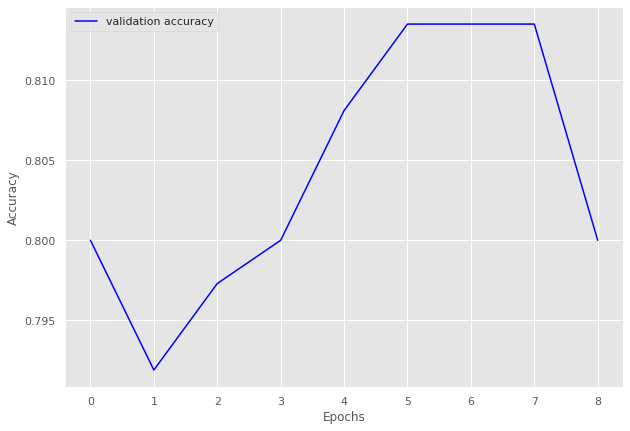

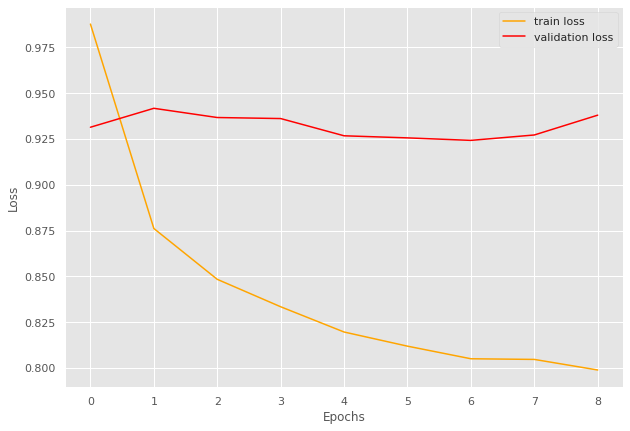

{'0': {'coarse': {'00': 0.8344144759303517, '10': 0.7350631614885627, '20': 0.6717065795249476, '30': 0.587328683607277, '50': 0.4409598595327513, '80': 0.2362093352192362}, 'fine': {'00': {'0': 0.9762140733399405, '1': 0.9764150943396226, '2': 0.9572277227722772, '3': 0.973404255319149, '4': 0.99644128113879, '5': 0.9815242494226328, '7': 0.9389619883040936, '8': 0.9871175523349437, '9': 0.8673469387755102, '11': 0.9451642060861706, '12': 0.9523012552301255, '14': 0.9555808656036446, '15': 0.9640077821011673}, '10': {'0': 0.8848780487804878, '1': 0.8422535211267606, '2': 0.8879103282626101, '3': 0.9231638418079096, '4': 0.9256505576208178, '5': 0.906885758998435, '7': 0.8858381502890174, '8': 0.9591503267973857, '9': 0.7749469214437368, '11': 0.8723911747167561, '12': 0.9203319502074688, '14': 0.8818380743982495, '15': 0.8033088235294118}, '20': {'0': 0.8442064264849075, '1': 0.7038567493112947, '2': 0.8205027494108406, '3': 0.8527889591719379, '4': 0.8386075949367089, '5': 0.80940794

100%|██████████| 34/34 [00:11<00:00,  2.84batch/s, loss=1.13]


train loss 1.1334689154344446, validation loss 1.280472457408905, validation accuracy 0.41935483870967744
Coarse label 19 Epoch 2
-------------------------------


100%|██████████| 34/34 [00:12<00:00,  2.82batch/s, loss=0.963]


train loss 0.9630699894007515, validation loss 1.2750737071037292, validation accuracy 0.45161290322580644
Coarse label 19 Epoch 3
-------------------------------


100%|██████████| 34/34 [00:12<00:00,  2.82batch/s, loss=0.87] 


INFO: Early stopping counter 1 of 5
train loss 0.8701359489384819, validation loss 1.2751432061195374, validation accuracy 0.43548387096774194
Coarse label 19 Epoch 4
-------------------------------


100%|██████████| 34/34 [00:12<00:00,  2.82batch/s, loss=0.819]


INFO: Early stopping counter 2 of 5
train loss 0.8193062649053686, validation loss 1.2958645820617676, validation accuracy 0.4435483870967742
Coarse label 19 Epoch 5
-------------------------------


100%|██████████| 34/34 [00:12<00:00,  2.77batch/s, loss=0.797]


INFO: Early stopping counter 3 of 5
train loss 0.7972451203009662, validation loss 1.3065651059150696, validation accuracy 0.41935483870967744
Coarse label 19 Epoch 6
-------------------------------


100%|██████████| 34/34 [00:12<00:00,  2.79batch/s, loss=0.794]


INFO: Early stopping counter 4 of 5
train loss 0.7943445286330055, validation loss 1.3215894103050232, validation accuracy 0.3951612903225806
Coarse label 19 Epoch 7
-------------------------------


100%|██████████| 34/34 [00:12<00:00,  2.80batch/s, loss=0.787]


INFO: Early stopping counter 5 of 5
INFO: Early stopping
Done! Saved model with test accuracy 0.6407035175879398 and loss 1.0896848269871302


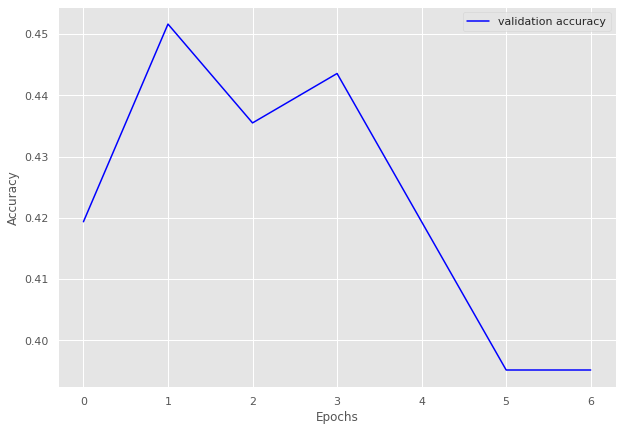

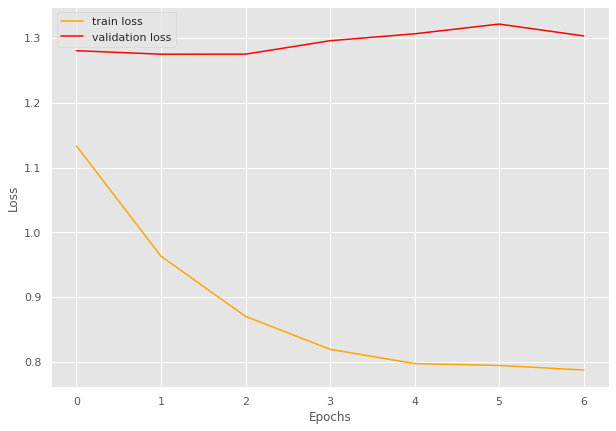

{'0': {'coarse': {'00': 0.8344144759303517, '10': 0.7350631614885627, '20': 0.6717065795249476, '30': 0.587328683607277, '50': 0.4409598595327513, '80': 0.2362093352192362}, 'fine': {'00': {'0': 0.9762140733399405, '1': 0.9764150943396226, '2': 0.9572277227722772, '3': 0.973404255319149, '4': 0.99644128113879, '5': 0.9815242494226328, '7': 0.9389619883040936, '8': 0.9871175523349437, '9': 0.8673469387755102, '11': 0.9451642060861706, '12': 0.9523012552301255, '14': 0.9555808656036446, '15': 0.9640077821011673}, '10': {'0': 0.8848780487804878, '1': 0.8422535211267606, '2': 0.8879103282626101, '3': 0.9231638418079096, '4': 0.9256505576208178, '5': 0.906885758998435, '7': 0.8858381502890174, '8': 0.9591503267973857, '9': 0.7749469214437368, '11': 0.8723911747167561, '12': 0.9203319502074688, '14': 0.8818380743982495, '15': 0.8033088235294118}, '20': {'0': 0.8442064264849075, '1': 0.7038567493112947, '2': 0.8205027494108406, '3': 0.8527889591719379, '4': 0.8386075949367089, '5': 0.80940794

Evaluating fine model 1
Evaluating fine model 2
Evaluating fine model 4
Evaluating fine model 5
Evaluating fine model 6
Evaluating fine model 7
Evaluating fine model 8
Evaluating fine model 9
Evaluating fine model 11
Evaluating fine model 12
Evaluating fine model 13
Evaluating fine model 14
Evaluating fine model 15
Evaluating fine model 16
Evaluating fine model 17
Evaluating fine model 19
overall accuracy  is 0.6781446617568161
{'0': {'coarse': {'00': 0.8344144759303517, '10': 0.7350631614885627, '20': 0.6717065795249476, '30': 0.587328683607277, '50': 0.4409598595327513, '80': 0.2362093352192362}, 'fine': {'00': {'0': 0.9762140733399405, '1': 0.9764150943396226, '2': 0.9572277227722772, '3': 0.973404255319149, '4': 0.99644128113879, '5': 0.9815242494226328, '7': 0.9389619883040936, '8': 0.9871175523349437, '9': 0.8673469387755102, '11': 0.9451642060861706, '12': 0.9523012552301255, '14': 0.9555808656036446, '15': 0.9640077821011673}, '10': {'0': 0.8848780487804878, '1': 0.842253521126

100%|██████████| 1639/1639 [09:50<00:00,  2.77batch/s, loss=2.61]


train loss 2.6055586847173795, validation loss 2.5354529089397855, validation accuracy 0.5443780554046713
Epoch 2
-------------------------------


100%|██████████| 1639/1639 [11:44<00:00,  2.33batch/s, loss=2.54]


train loss 2.537798945681215, validation loss 2.506374274690946, validation accuracy 0.572080391091798
Epoch 3
-------------------------------


100%|██████████| 1639/1639 [09:50<00:00,  2.78batch/s, loss=2.52]


train loss 2.5195175884263117, validation loss 2.4963408228423862, validation accuracy 0.5820749592612711
Epoch 4
-------------------------------


100%|██████████| 1639/1639 [09:57<00:00,  2.74batch/s, loss=2.5]


train loss 2.501743428804585, validation loss 2.4818028691742153, validation accuracy 0.5963063552417165
Epoch 5
-------------------------------


100%|██████████| 1639/1639 [11:07<00:00,  2.46batch/s, loss=2.49]


train loss 2.489221997927281, validation loss 2.4789904024865894, validation accuracy 0.5985877240630092
Epoch 6
-------------------------------


100%|██████████| 1639/1639 [09:51<00:00,  2.77batch/s, loss=2.48]


train loss 2.4794544283393827, validation loss 2.471181645989418, validation accuracy 0.6066268332428029
Epoch 7
-------------------------------


100%|██████████| 1639/1639 [11:47<00:00,  2.32batch/s, loss=2.47]


train loss 2.473510367758322, validation loss 2.4699105901850595, validation accuracy 0.6085822922324824
Epoch 8
-------------------------------


100%|██████████| 1639/1639 [09:53<00:00,  2.76batch/s, loss=2.47]


train loss 2.4650529818683227, validation loss 2.4608035650518207, validation accuracy 0.6168386746333514
Epoch 9
-------------------------------


100%|██████████| 1639/1639 [09:51<00:00,  2.77batch/s, loss=2.46]


INFO: Early stopping counter 1 of 5
train loss 2.461814246139852, validation loss 2.4610382417837777, validation accuracy 0.6171645844649647
Epoch 10
-------------------------------


100%|██████████| 1639/1639 [11:45<00:00,  2.32batch/s, loss=2.46]


INFO: Early stopping counter 2 of 5
train loss 2.4590127855048376, validation loss 2.465873509645462, validation accuracy 0.6123845736013036
Epoch 11
-------------------------------


100%|██████████| 1639/1639 [09:56<00:00,  2.75batch/s, loss=2.45]


train loss 2.454648766450725, validation loss 2.454776888092359, validation accuracy 0.6233568712656166
Epoch 12
-------------------------------


100%|██████████| 1639/1639 [09:51<00:00,  2.77batch/s, loss=2.45]


INFO: Early stopping counter 3 of 5
train loss 2.450039569454414, validation loss 2.458067307869593, validation accuracy 0.619228680065182
Epoch 13
-------------------------------


100%|██████████| 1639/1639 [11:43<00:00,  2.33batch/s, loss=2.45]


train loss 2.4451562616430893, validation loss 2.447290054625935, validation accuracy 0.6307441607821836
Epoch 14
-------------------------------


100%|██████████| 1639/1639 [09:51<00:00,  2.77batch/s, loss=2.44]


INFO: Early stopping counter 4 of 5
train loss 2.4405109248123495, validation loss 2.453494891524315, validation accuracy 0.6248777838131451
Epoch 15
-------------------------------


100%|██████████| 1639/1639 [09:53<00:00,  2.76batch/s, loss=2.44]


train loss 2.4384672072982556, validation loss 2.445593214697308, validation accuracy 0.6325909831613253
Epoch 16
-------------------------------


100%|██████████| 1639/1639 [11:47<00:00,  2.32batch/s, loss=2.44]


train loss 2.437551396877901, validation loss 2.4452975110875235, validation accuracy 0.6324823465507876
Epoch 17
-------------------------------


100%|██████████| 1639/1639 [09:51<00:00,  2.77batch/s, loss=2.43]


INFO: Early stopping counter 5 of 5
INFO: Early stopping
Done! Saved model with test accuracy 0.6145442130419938 and loss 2.4637869265963355


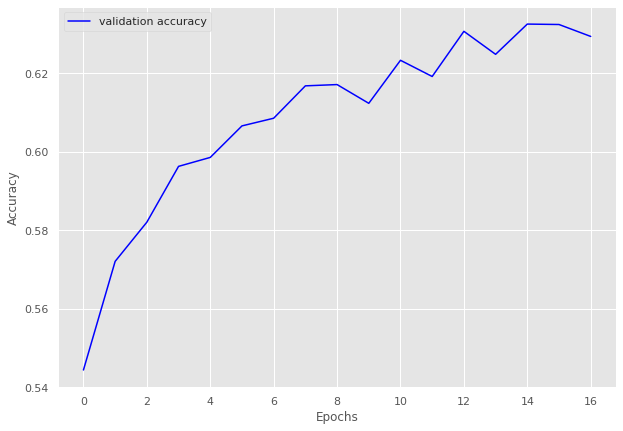

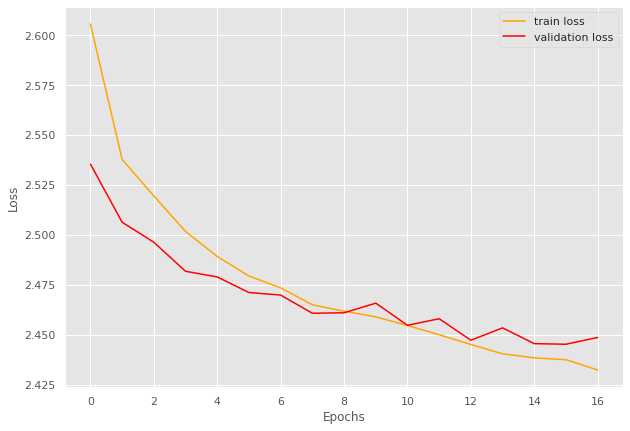

{'0': {'coarse': {'00': 0.8344144759303517, '10': 0.7350631614885627, '20': 0.6717065795249476, '30': 0.587328683607277, '50': 0.4409598595327513, '80': 0.2362093352192362}, 'fine': {'00': {'0': 0.9762140733399405, '1': 0.9764150943396226, '2': 0.9572277227722772, '3': 0.973404255319149, '4': 0.99644128113879, '5': 0.9815242494226328, '7': 0.9389619883040936, '8': 0.9871175523349437, '9': 0.8673469387755102, '11': 0.9451642060861706, '12': 0.9523012552301255, '14': 0.9555808656036446, '15': 0.9640077821011673}, '10': {'0': 0.8848780487804878, '1': 0.8422535211267606, '2': 0.8879103282626101, '3': 0.9231638418079096, '4': 0.9256505576208178, '5': 0.906885758998435, '7': 0.8858381502890174, '8': 0.9591503267973857, '9': 0.7749469214437368, '11': 0.8723911747167561, '12': 0.9203319502074688, '14': 0.8818380743982495, '15': 0.8033088235294118}, '20': {'0': 0.8442064264849075, '1': 0.7038567493112947, '2': 0.8205027494108406, '3': 0.8527889591719379, '4': 0.8386075949367089, '5': 0.80940794

100%|██████████| 99/99 [00:35<00:00,  2.78batch/s, loss=1.2] 


train loss 1.2025066289034756, validation loss 1.0827862891283901, validation accuracy 0.8259541984732824
Coarse label 0 Epoch 2
-------------------------------


100%|██████████| 99/99 [00:35<00:00,  2.79batch/s, loss=1.11]


INFO: Early stopping counter 1 of 5
train loss 1.1095221735010243, validation loss 1.09194063056599, validation accuracy 0.8122137404580153
Coarse label 0 Epoch 3
-------------------------------


100%|██████████| 99/99 [00:35<00:00,  2.77batch/s, loss=1.08]


INFO: Early stopping counter 2 of 5
train loss 1.0849685921813503, validation loss 1.0955211303450845, validation accuracy 0.8076335877862595
Coarse label 0 Epoch 4
-------------------------------


100%|██████████| 99/99 [00:35<00:00,  2.79batch/s, loss=1.07]


INFO: Early stopping counter 3 of 5
train loss 1.067985798373367, validation loss 1.0981678745963357, validation accuracy 0.8030534351145038
Coarse label 0 Epoch 5
-------------------------------


100%|██████████| 99/99 [00:35<00:00,  2.80batch/s, loss=1.06]


INFO: Early stopping counter 4 of 5
train loss 1.055811258879575, validation loss 1.0921187292445789, validation accuracy 0.8137404580152672
Coarse label 0 Epoch 6
-------------------------------


100%|██████████| 99/99 [00:35<00:00,  2.81batch/s, loss=1.05]


INFO: Early stopping counter 5 of 5
INFO: Early stopping
Done! Saved model with test accuracy 0.7688524590163934 and loss 1.144717311859131


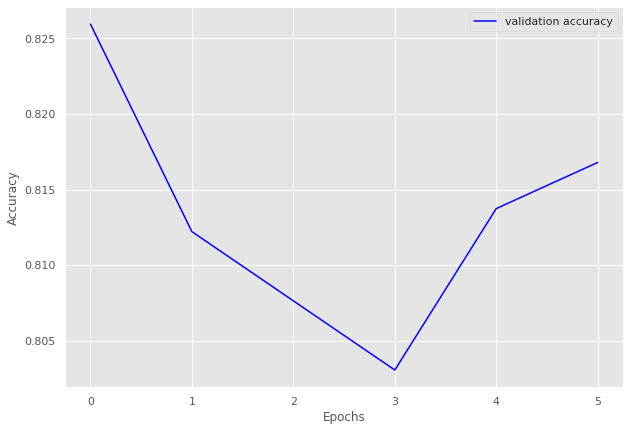

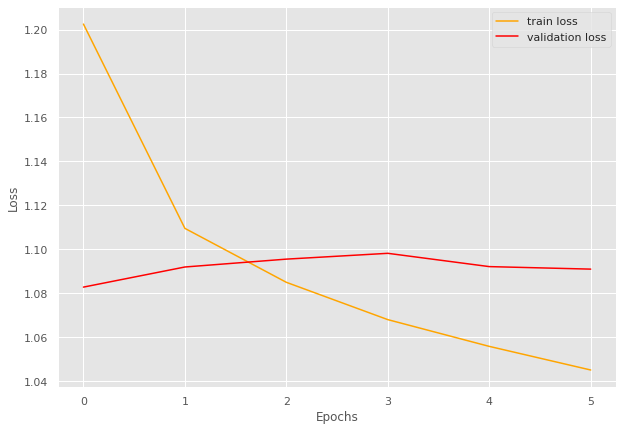

{'0': {'coarse': {'00': 0.8344144759303517, '10': 0.7350631614885627, '20': 0.6717065795249476, '30': 0.587328683607277, '50': 0.4409598595327513, '80': 0.2362093352192362}, 'fine': {'00': {'0': 0.9762140733399405, '1': 0.9764150943396226, '2': 0.9572277227722772, '3': 0.973404255319149, '4': 0.99644128113879, '5': 0.9815242494226328, '7': 0.9389619883040936, '8': 0.9871175523349437, '9': 0.8673469387755102, '11': 0.9451642060861706, '12': 0.9523012552301255, '14': 0.9555808656036446, '15': 0.9640077821011673}, '10': {'0': 0.8848780487804878, '1': 0.8422535211267606, '2': 0.8879103282626101, '3': 0.9231638418079096, '4': 0.9256505576208178, '5': 0.906885758998435, '7': 0.8858381502890174, '8': 0.9591503267973857, '9': 0.7749469214437368, '11': 0.8723911747167561, '12': 0.9203319502074688, '14': 0.8818380743982495, '15': 0.8033088235294118}, '20': {'0': 0.8442064264849075, '1': 0.7038567493112947, '2': 0.8205027494108406, '3': 0.8527889591719379, '4': 0.8386075949367089, '5': 0.80940794

100%|██████████| 63/63 [00:22<00:00,  2.77batch/s, loss=1.51]


train loss 1.511340409990341, validation loss 1.4920400977134705, validation accuracy 0.5242424242424243
Coarse label 1 Epoch 2
-------------------------------


100%|██████████| 63/63 [00:22<00:00,  2.80batch/s, loss=1.4] 


train loss 1.3976318287470983, validation loss 1.47735462586085, validation accuracy 0.5545454545454546
Coarse label 1 Epoch 3
-------------------------------


100%|██████████| 63/63 [00:22<00:00,  2.80batch/s, loss=1.33]


INFO: Early stopping counter 1 of 5
train loss 1.333427281606765, validation loss 1.4987108707427979, validation accuracy 0.5545454545454546
Coarse label 1 Epoch 4
-------------------------------


100%|██████████| 63/63 [00:22<00:00,  2.79batch/s, loss=1.28]


INFO: Early stopping counter 2 of 5
train loss 1.280499433714246, validation loss 1.4821730852127075, validation accuracy 0.5606060606060606
Coarse label 1 Epoch 5
-------------------------------


100%|██████████| 63/63 [00:22<00:00,  2.81batch/s, loss=1.25]


INFO: Early stopping counter 3 of 5
train loss 1.2450113012677146, validation loss 1.4783989985783894, validation accuracy 0.5636363636363636
Coarse label 1 Epoch 6
-------------------------------


100%|██████████| 63/63 [00:22<00:00,  2.81batch/s, loss=1.21]


INFO: Early stopping counter 4 of 5
train loss 1.2130669166171362, validation loss 1.4802783330281575, validation accuracy 0.5454545454545454
Coarse label 1 Epoch 7
-------------------------------


100%|██████████| 63/63 [00:22<00:00,  2.78batch/s, loss=1.2] 


INFO: Early stopping counter 5 of 5
INFO: Early stopping
Done! Saved model with test accuracy 0.5731382978723404 and loss 1.4700697660446167


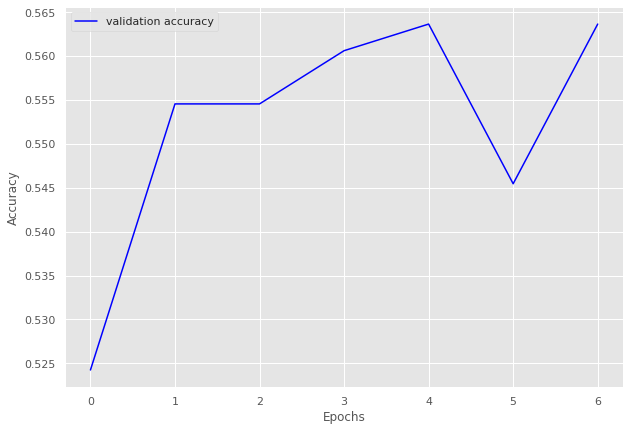

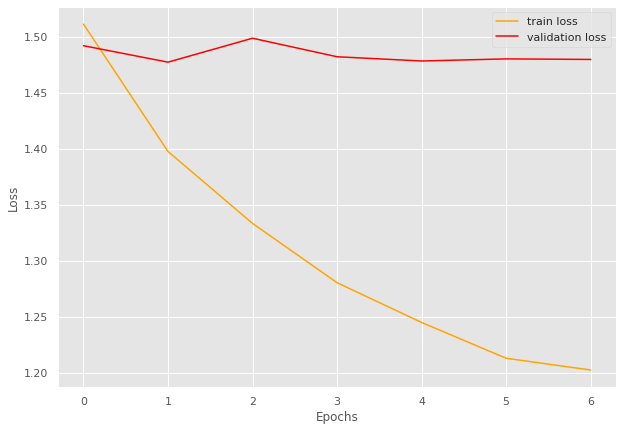

{'0': {'coarse': {'00': 0.8344144759303517, '10': 0.7350631614885627, '20': 0.6717065795249476, '30': 0.587328683607277, '50': 0.4409598595327513, '80': 0.2362093352192362}, 'fine': {'00': {'0': 0.9762140733399405, '1': 0.9764150943396226, '2': 0.9572277227722772, '3': 0.973404255319149, '4': 0.99644128113879, '5': 0.9815242494226328, '7': 0.9389619883040936, '8': 0.9871175523349437, '9': 0.8673469387755102, '11': 0.9451642060861706, '12': 0.9523012552301255, '14': 0.9555808656036446, '15': 0.9640077821011673}, '10': {'0': 0.8848780487804878, '1': 0.8422535211267606, '2': 0.8879103282626101, '3': 0.9231638418079096, '4': 0.9256505576208178, '5': 0.906885758998435, '7': 0.8858381502890174, '8': 0.9591503267973857, '9': 0.7749469214437368, '11': 0.8723911747167561, '12': 0.9203319502074688, '14': 0.8818380743982495, '15': 0.8033088235294118}, '20': {'0': 0.8442064264849075, '1': 0.7038567493112947, '2': 0.8205027494108406, '3': 0.8527889591719379, '4': 0.8386075949367089, '5': 0.80940794

100%|██████████| 203/203 [01:13<00:00,  2.77batch/s, loss=1.81]


train loss 1.8121291399002075, validation loss 1.7288659470421928, validation accuracy 0.7309417040358744
Coarse label 2 Epoch 2
-------------------------------


100%|██████████| 203/203 [01:13<00:00,  2.77batch/s, loss=1.73]


train loss 1.7307667984751058, validation loss 1.7076378549848283, validation accuracy 0.7481315396113603
Coarse label 2 Epoch 3
-------------------------------


100%|██████████| 203/203 [01:22<00:00,  2.47batch/s, loss=1.71]


train loss 1.7081816208186409, validation loss 1.7029332944325037, validation accuracy 0.7548579970104634
Coarse label 2 Epoch 4
-------------------------------


100%|██████████| 203/203 [02:38<00:00,  1.28batch/s, loss=1.69]


train loss 1.6930890095057747, validation loss 1.6983669939495267, validation accuracy 0.7593423019431988
Coarse label 2 Epoch 5
-------------------------------


100%|██████████| 203/203 [01:19<00:00,  2.54batch/s, loss=1.68]


train loss 1.6826655653309939, validation loss 1.690353342464992, validation accuracy 0.7720478325859492
Coarse label 2 Epoch 6
-------------------------------


100%|██████████| 203/203 [01:13<00:00,  2.76batch/s, loss=1.67]


INFO: Early stopping counter 1 of 5
train loss 1.670862726977306, validation loss 1.6927947430383592, validation accuracy 0.7683109118086696
Coarse label 2 Epoch 7
-------------------------------


100%|██████████| 203/203 [01:13<00:00,  2.76batch/s, loss=1.67]


train loss 1.6650216426755406, validation loss 1.6875653493972051, validation accuracy 0.772795216741405
Coarse label 2 Epoch 8
-------------------------------


100%|██████████| 203/203 [01:13<00:00,  2.78batch/s, loss=1.66]


INFO: Early stopping counter 2 of 5
train loss 1.6591807568601786, validation loss 1.6900963272367204, validation accuracy 0.7690582959641256
Coarse label 2 Epoch 9
-------------------------------


100%|██████████| 203/203 [01:12<00:00,  2.79batch/s, loss=1.66]


INFO: Early stopping counter 3 of 5
train loss 1.6576536864482712, validation loss 1.6967854159218925, validation accuracy 0.7615844544095666
Coarse label 2 Epoch 10
-------------------------------


100%|██████████| 203/203 [01:13<00:00,  2.78batch/s, loss=1.65]


INFO: Early stopping counter 4 of 5
train loss 1.6489452616921787, validation loss 1.6907111065728324, validation accuracy 0.7683109118086696
Coarse label 2 Epoch 11
-------------------------------


100%|██████████| 203/203 [01:13<00:00,  2.78batch/s, loss=1.65]


INFO: Early stopping counter 5 of 5
INFO: Early stopping
Done! Saved model with test accuracy 0.7392 and loss 1.7355002641677857


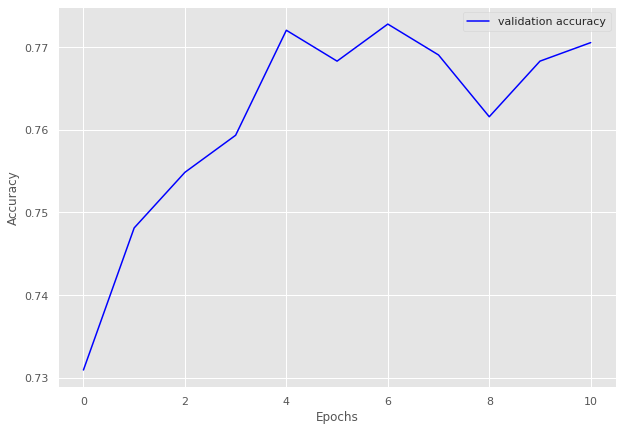

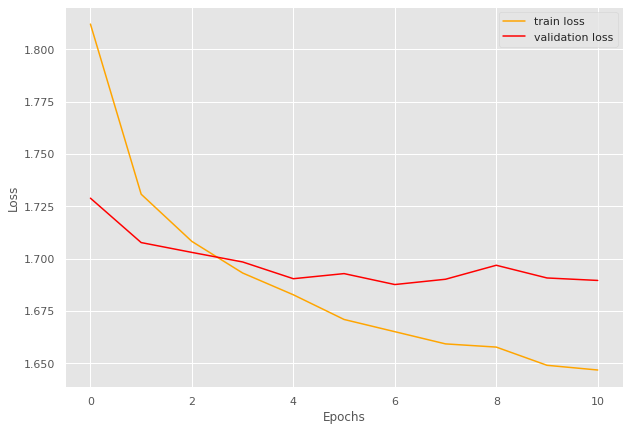

{'0': {'coarse': {'00': 0.8344144759303517, '10': 0.7350631614885627, '20': 0.6717065795249476, '30': 0.587328683607277, '50': 0.4409598595327513, '80': 0.2362093352192362}, 'fine': {'00': {'0': 0.9762140733399405, '1': 0.9764150943396226, '2': 0.9572277227722772, '3': 0.973404255319149, '4': 0.99644128113879, '5': 0.9815242494226328, '7': 0.9389619883040936, '8': 0.9871175523349437, '9': 0.8673469387755102, '11': 0.9451642060861706, '12': 0.9523012552301255, '14': 0.9555808656036446, '15': 0.9640077821011673}, '10': {'0': 0.8848780487804878, '1': 0.8422535211267606, '2': 0.8879103282626101, '3': 0.9231638418079096, '4': 0.9256505576208178, '5': 0.906885758998435, '7': 0.8858381502890174, '8': 0.9591503267973857, '9': 0.7749469214437368, '11': 0.8723911747167561, '12': 0.9203319502074688, '14': 0.8818380743982495, '15': 0.8033088235294118}, '20': {'0': 0.8442064264849075, '1': 0.7038567493112947, '2': 0.8205027494108406, '3': 0.8527889591719379, '4': 0.8386075949367089, '5': 0.80940794

100%|██████████| 100/100 [00:35<00:00,  2.79batch/s, loss=1.4]


train loss 1.4029986727237702, validation loss 1.3108028173446655, validation accuracy 0.7229080932784636
Coarse label 4 Epoch 2
-------------------------------


100%|██████████| 100/100 [00:36<00:00,  2.78batch/s, loss=1.3]


train loss 1.3002387356758118, validation loss 1.3018300235271454, validation accuracy 0.7338820301783264
Coarse label 4 Epoch 3
-------------------------------


100%|██████████| 100/100 [00:36<00:00,  2.78batch/s, loss=1.26]


train loss 1.2638916385173797, validation loss 1.2944932579994202, validation accuracy 0.7407407407407407
Coarse label 4 Epoch 4
-------------------------------


100%|██████████| 100/100 [00:35<00:00,  2.79batch/s, loss=1.24]


INFO: Early stopping counter 1 of 5
train loss 1.2431289756298065, validation loss 1.2981293002764385, validation accuracy 0.7434842249657064
Coarse label 4 Epoch 5
-------------------------------


100%|██████████| 100/100 [00:35<00:00,  2.80batch/s, loss=1.22]


INFO: Early stopping counter 2 of 5
train loss 1.2230244970321655, validation loss 1.297778308391571, validation accuracy 0.7325102880658436
Coarse label 4 Epoch 6
-------------------------------


100%|██████████| 100/100 [00:35<00:00,  2.78batch/s, loss=1.2]


train loss 1.1988487601280213, validation loss 1.2842124005158742, validation accuracy 0.7448559670781894
Coarse label 4 Epoch 7
-------------------------------


100%|██████████| 100/100 [00:35<00:00,  2.79batch/s, loss=1.19]


INFO: Early stopping counter 3 of 5
train loss 1.1947059547901153, validation loss 1.2920413315296173, validation accuracy 0.7489711934156379
Coarse label 4 Epoch 8
-------------------------------


100%|██████████| 100/100 [00:35<00:00,  2.78batch/s, loss=1.19]


train loss 1.1865583860874176, validation loss 1.2749457756678264, validation accuracy 0.7626886145404664
Coarse label 4 Epoch 9
-------------------------------


100%|██████████| 100/100 [00:35<00:00,  2.78batch/s, loss=1.18]


train loss 1.1777999448776244, validation loss 1.2704347272713978, validation accuracy 0.766803840877915
Coarse label 4 Epoch 10
-------------------------------


100%|██████████| 100/100 [00:35<00:00,  2.80batch/s, loss=1.17]


INFO: Early stopping counter 4 of 5
train loss 1.1718341135978698, validation loss 1.2881804307301838, validation accuracy 0.7448559670781894
Coarse label 4 Epoch 11
-------------------------------


100%|██████████| 100/100 [00:35<00:00,  2.79batch/s, loss=1.16]


INFO: Early stopping counter 5 of 5
INFO: Early stopping
Done! Saved model with test accuracy 0.7376201034737621 and loss 1.3180487047542224


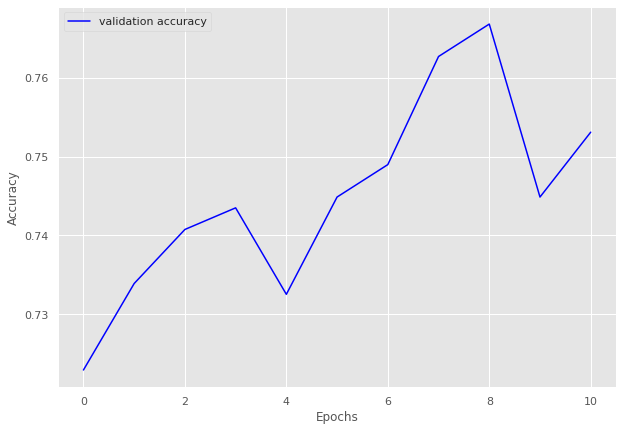

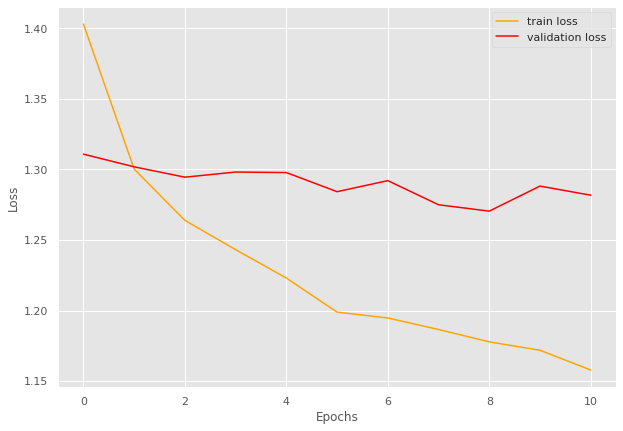

{'0': {'coarse': {'00': 0.8344144759303517, '10': 0.7350631614885627, '20': 0.6717065795249476, '30': 0.587328683607277, '50': 0.4409598595327513, '80': 0.2362093352192362}, 'fine': {'00': {'0': 0.9762140733399405, '1': 0.9764150943396226, '2': 0.9572277227722772, '3': 0.973404255319149, '4': 0.99644128113879, '5': 0.9815242494226328, '7': 0.9389619883040936, '8': 0.9871175523349437, '9': 0.8673469387755102, '11': 0.9451642060861706, '12': 0.9523012552301255, '14': 0.9555808656036446, '15': 0.9640077821011673}, '10': {'0': 0.8848780487804878, '1': 0.8422535211267606, '2': 0.8879103282626101, '3': 0.9231638418079096, '4': 0.9256505576208178, '5': 0.906885758998435, '7': 0.8858381502890174, '8': 0.9591503267973857, '9': 0.7749469214437368, '11': 0.8723911747167561, '12': 0.9203319502074688, '14': 0.8818380743982495, '15': 0.8033088235294118}, '20': {'0': 0.8442064264849075, '1': 0.7038567493112947, '2': 0.8205027494108406, '3': 0.8527889591719379, '4': 0.8386075949367089, '5': 0.80940794

100%|██████████| 40/40 [00:14<00:00,  2.85batch/s, loss=0.483]


train loss 0.48265320956707003, validation loss 0.4999422033627828, validation accuracy 0.8
Coarse label 5 Epoch 2
-------------------------------


100%|██████████| 40/40 [00:14<00:00,  2.81batch/s, loss=0.388]


INFO: Early stopping counter 1 of 5
train loss 0.3882999636232853, validation loss 0.5082332690556844, validation accuracy 0.8068965517241379
Coarse label 5 Epoch 3
-------------------------------


100%|██████████| 40/40 [00:13<00:00,  2.86batch/s, loss=0.349]


train loss 0.34903575032949447, validation loss 0.48659486571947735, validation accuracy 0.8482758620689655
Coarse label 5 Epoch 4
-------------------------------


100%|██████████| 40/40 [00:13<00:00,  2.86batch/s, loss=0.338]


train loss 0.33775746151804925, validation loss 0.4493989845116933, validation accuracy 0.8620689655172413
Coarse label 5 Epoch 5
-------------------------------


100%|██████████| 40/40 [00:14<00:00,  2.84batch/s, loss=0.34] 


INFO: Early stopping counter 2 of 5
train loss 0.3396571323275566, validation loss 0.47326532006263733, validation accuracy 0.8482758620689655
Coarse label 5 Epoch 6
-------------------------------


100%|██████████| 40/40 [00:13<00:00,  2.86batch/s, loss=0.336]


INFO: Early stopping counter 3 of 5
train loss 0.336017682403326, validation loss 0.4826323787371318, validation accuracy 0.8137931034482758
Coarse label 5 Epoch 7
-------------------------------


100%|██████████| 40/40 [00:13<00:00,  2.86batch/s, loss=0.336]


INFO: Early stopping counter 4 of 5
train loss 0.3360906608402729, validation loss 0.4677142600218455, validation accuracy 0.8344827586206897
Coarse label 5 Epoch 8
-------------------------------


100%|██████████| 40/40 [00:13<00:00,  2.86batch/s, loss=0.338]


INFO: Early stopping counter 5 of 5
INFO: Early stopping
Done! Saved model with test accuracy 0.8424507658643327 and loss 0.5143074356019497


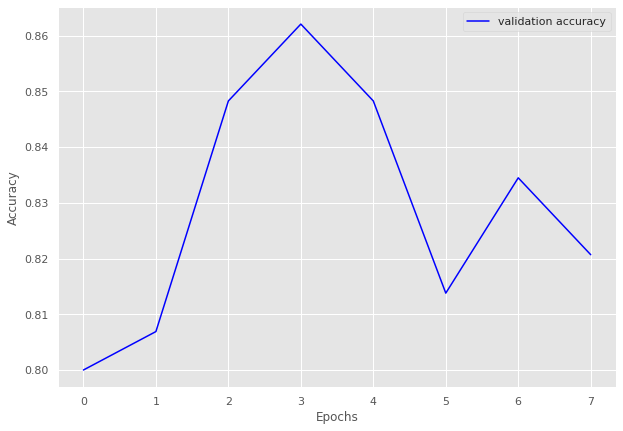

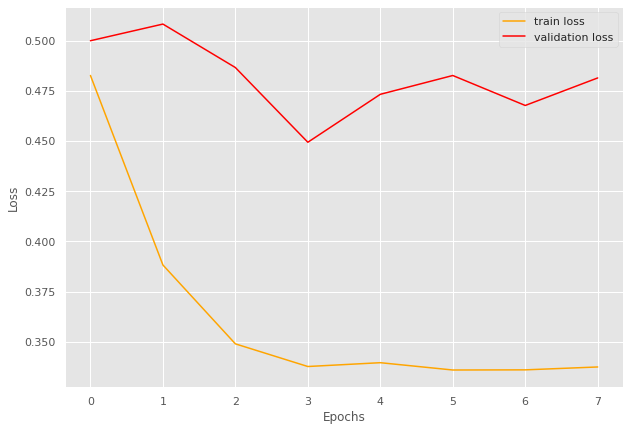

{'0': {'coarse': {'00': 0.8344144759303517, '10': 0.7350631614885627, '20': 0.6717065795249476, '30': 0.587328683607277, '50': 0.4409598595327513, '80': 0.2362093352192362}, 'fine': {'00': {'0': 0.9762140733399405, '1': 0.9764150943396226, '2': 0.9572277227722772, '3': 0.973404255319149, '4': 0.99644128113879, '5': 0.9815242494226328, '7': 0.9389619883040936, '8': 0.9871175523349437, '9': 0.8673469387755102, '11': 0.9451642060861706, '12': 0.9523012552301255, '14': 0.9555808656036446, '15': 0.9640077821011673}, '10': {'0': 0.8848780487804878, '1': 0.8422535211267606, '2': 0.8879103282626101, '3': 0.9231638418079096, '4': 0.9256505576208178, '5': 0.906885758998435, '7': 0.8858381502890174, '8': 0.9591503267973857, '9': 0.7749469214437368, '11': 0.8723911747167561, '12': 0.9203319502074688, '14': 0.8818380743982495, '15': 0.8033088235294118}, '20': {'0': 0.8442064264849075, '1': 0.7038567493112947, '2': 0.8205027494108406, '3': 0.8527889591719379, '4': 0.8386075949367089, '5': 0.80940794

100%|██████████| 114/114 [00:41<00:00,  2.73batch/s, loss=1.52]


train loss 1.5230370895904408, validation loss 1.4154369922784658, validation accuracy 0.7496790757381258
Coarse label 6 Epoch 2
-------------------------------


100%|██████████| 114/114 [00:40<00:00,  2.80batch/s, loss=1.44]


train loss 1.4371318858966493, validation loss 1.4054197806578417, validation accuracy 0.7432605905006419
Coarse label 6 Epoch 3
-------------------------------


100%|██████████| 114/114 [00:40<00:00,  2.79batch/s, loss=1.41]


train loss 1.407535475597047, validation loss 1.395433416733375, validation accuracy 0.7625160462130937
Coarse label 6 Epoch 4
-------------------------------


100%|██████████| 114/114 [00:40<00:00,  2.80batch/s, loss=1.38]


INFO: Early stopping counter 1 of 5
train loss 1.3831572930018108, validation loss 1.4040007499548106, validation accuracy 0.7560975609756098
Coarse label 6 Epoch 5
-------------------------------


100%|██████████| 114/114 [00:41<00:00,  2.77batch/s, loss=1.36]


INFO: Early stopping counter 2 of 5
train loss 1.3640938338480497, validation loss 1.4034728178611169, validation accuracy 0.7560975609756098
Coarse label 6 Epoch 6
-------------------------------


100%|██████████| 114/114 [00:40<00:00,  2.78batch/s, loss=1.35]


INFO: Early stopping counter 3 of 5
train loss 1.3461967026978208, validation loss 1.397939159319951, validation accuracy 0.766367137355584
Coarse label 6 Epoch 7
-------------------------------


100%|██████████| 114/114 [00:40<00:00,  2.81batch/s, loss=1.33]


INFO: Early stopping counter 4 of 5
train loss 1.3321214903864944, validation loss 1.406124160839961, validation accuracy 0.7625160462130937
Coarse label 6 Epoch 8
-------------------------------


100%|██████████| 114/114 [01:15<00:00,  1.50batch/s, loss=1.33]


INFO: Early stopping counter 5 of 5
INFO: Early stopping
Done! Saved model with test accuracy 0.7032213845099383 and loss 1.463153108306553


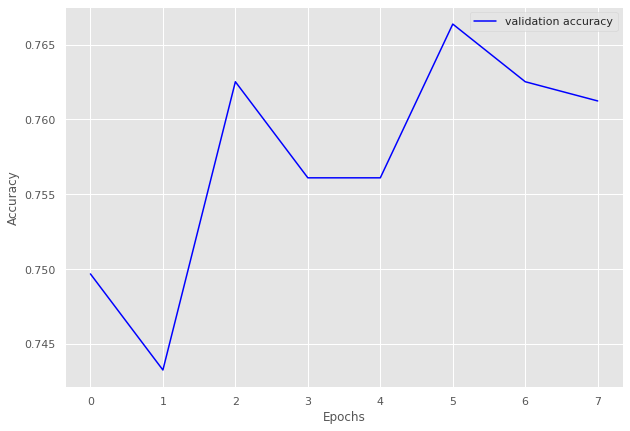

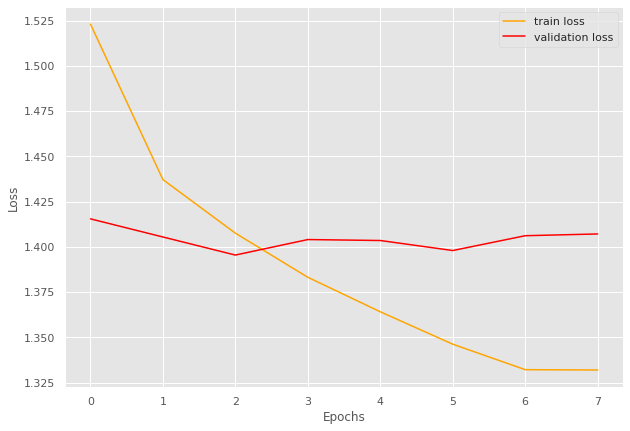

{'0': {'coarse': {'00': 0.8344144759303517, '10': 0.7350631614885627, '20': 0.6717065795249476, '30': 0.587328683607277, '50': 0.4409598595327513, '80': 0.2362093352192362}, 'fine': {'00': {'0': 0.9762140733399405, '1': 0.9764150943396226, '2': 0.9572277227722772, '3': 0.973404255319149, '4': 0.99644128113879, '5': 0.9815242494226328, '7': 0.9389619883040936, '8': 0.9871175523349437, '9': 0.8673469387755102, '11': 0.9451642060861706, '12': 0.9523012552301255, '14': 0.9555808656036446, '15': 0.9640077821011673}, '10': {'0': 0.8848780487804878, '1': 0.8422535211267606, '2': 0.8879103282626101, '3': 0.9231638418079096, '4': 0.9256505576208178, '5': 0.906885758998435, '7': 0.8858381502890174, '8': 0.9591503267973857, '9': 0.7749469214437368, '11': 0.8723911747167561, '12': 0.9203319502074688, '14': 0.8818380743982495, '15': 0.8033088235294118}, '20': {'0': 0.8442064264849075, '1': 0.7038567493112947, '2': 0.8205027494108406, '3': 0.8527889591719379, '4': 0.8386075949367089, '5': 0.80940794

100%|██████████| 83/83 [01:06<00:00,  1.25batch/s, loss=0.981]


train loss 0.9807782481951886, validation loss 0.908989151318868, validation accuracy 0.8297101449275363
Coarse label 7 Epoch 2
-------------------------------


100%|██████████| 83/83 [00:56<00:00,  1.47batch/s, loss=0.899]


INFO: Early stopping counter 1 of 5
train loss 0.8993862256946334, validation loss 0.9129052294625176, validation accuracy 0.822463768115942
Coarse label 7 Epoch 3
-------------------------------


100%|██████████| 83/83 [00:30<00:00,  2.74batch/s, loss=0.87] 


INFO: Early stopping counter 2 of 5
train loss 0.8700391068516007, validation loss 0.9165189464886984, validation accuracy 0.8152173913043478
Coarse label 7 Epoch 4
-------------------------------


100%|██████████| 83/83 [00:29<00:00,  2.78batch/s, loss=0.855]


INFO: Early stopping counter 3 of 5
train loss 0.85497447237911, validation loss 0.920783195230696, validation accuracy 0.8170289855072463
Coarse label 7 Epoch 5
-------------------------------


100%|██████████| 83/83 [00:30<00:00,  2.74batch/s, loss=0.846]


train loss 0.8458633796278253, validation loss 0.9046890139579773, validation accuracy 0.8333333333333334
Coarse label 7 Epoch 6
-------------------------------


100%|██████████| 83/83 [00:30<00:00,  2.76batch/s, loss=0.829]


INFO: Early stopping counter 4 of 5
train loss 0.8287251720945519, validation loss 0.9088234702746073, validation accuracy 0.8297101449275363
Coarse label 7 Epoch 7
-------------------------------


100%|██████████| 83/83 [00:29<00:00,  2.78batch/s, loss=0.821]


train loss 0.8206490881471749, validation loss 0.9014614423116049, validation accuracy 0.8351449275362319
Coarse label 7 Epoch 8
-------------------------------


100%|██████████| 83/83 [00:29<00:00,  2.78batch/s, loss=0.815]


INFO: Early stopping counter 5 of 5
INFO: Early stopping
Done! Saved model with test accuracy 0.8158396946564885 and loss 0.9425361752510071


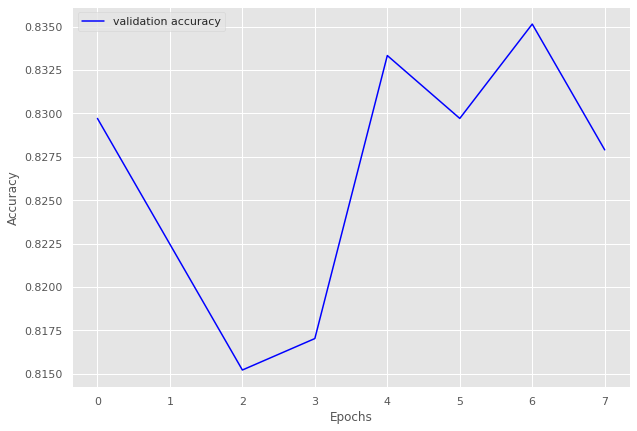

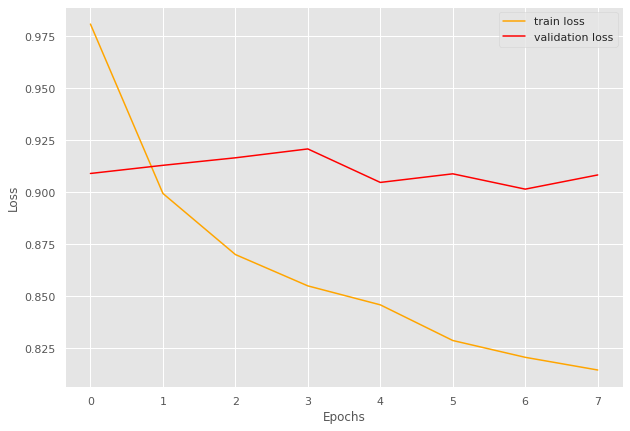

{'0': {'coarse': {'00': 0.8344144759303517, '10': 0.7350631614885627, '20': 0.6717065795249476, '30': 0.587328683607277, '50': 0.4409598595327513, '80': 0.2362093352192362}, 'fine': {'00': {'0': 0.9762140733399405, '1': 0.9764150943396226, '2': 0.9572277227722772, '3': 0.973404255319149, '4': 0.99644128113879, '5': 0.9815242494226328, '7': 0.9389619883040936, '8': 0.9871175523349437, '9': 0.8673469387755102, '11': 0.9451642060861706, '12': 0.9523012552301255, '14': 0.9555808656036446, '15': 0.9640077821011673}, '10': {'0': 0.8848780487804878, '1': 0.8422535211267606, '2': 0.8879103282626101, '3': 0.9231638418079096, '4': 0.9256505576208178, '5': 0.906885758998435, '7': 0.8858381502890174, '8': 0.9591503267973857, '9': 0.7749469214437368, '11': 0.8723911747167561, '12': 0.9203319502074688, '14': 0.8818380743982495, '15': 0.8033088235294118}, '20': {'0': 0.8442064264849075, '1': 0.7038567493112947, '2': 0.8205027494108406, '3': 0.8527889591719379, '4': 0.8386075949367089, '5': 0.80940794

100%|██████████| 128/128 [00:45<00:00,  2.79batch/s, loss=1.52]


train loss 1.5210542446002364, validation loss 1.5933903115136283, validation accuracy 0.5570776255707762
Coarse label 8 Epoch 2
-------------------------------


100%|██████████| 128/128 [00:46<00:00,  2.77batch/s, loss=1.41]


train loss 1.405325561761856, validation loss 1.5665231772831507, validation accuracy 0.591324200913242
Coarse label 8 Epoch 3
-------------------------------


100%|██████████| 128/128 [00:48<00:00,  2.61batch/s, loss=1.38]


train loss 1.3803222896531224, validation loss 1.5530839817864555, validation accuracy 0.6027397260273972
Coarse label 8 Epoch 4
-------------------------------


100%|██████████| 128/128 [00:46<00:00,  2.77batch/s, loss=1.36]


INFO: Early stopping counter 1 of 5
train loss 1.3620654111728072, validation loss 1.5688730137688773, validation accuracy 0.58675799086758
Coarse label 8 Epoch 5
-------------------------------


100%|██████████| 128/128 [00:45<00:00,  2.79batch/s, loss=1.35]


INFO: Early stopping counter 2 of 5
train loss 1.3527341224253178, validation loss 1.564766560282026, validation accuracy 0.6027397260273972
Coarse label 8 Epoch 6
-------------------------------


100%|██████████| 128/128 [00:46<00:00,  2.74batch/s, loss=1.34]


INFO: Early stopping counter 3 of 5
train loss 1.3440921576693654, validation loss 1.5609481845583235, validation accuracy 0.5981735159817352
Coarse label 8 Epoch 7
-------------------------------


100%|██████████| 128/128 [00:46<00:00,  2.78batch/s, loss=1.34]


INFO: Early stopping counter 4 of 5
train loss 1.3373837172985077, validation loss 1.5720102616718836, validation accuracy 0.5821917808219178
Coarse label 8 Epoch 8
-------------------------------


100%|██████████| 128/128 [00:46<00:00,  2.78batch/s, loss=1.33]


INFO: Early stopping counter 5 of 5
INFO: Early stopping
Done! Saved model with test accuracy 0.7322368421052632 and loss 1.4374014337857564


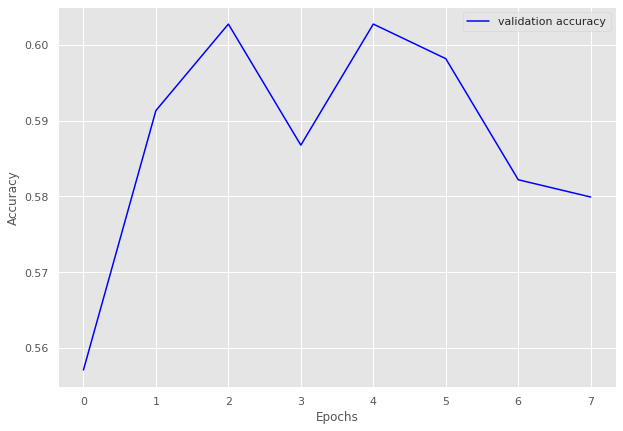

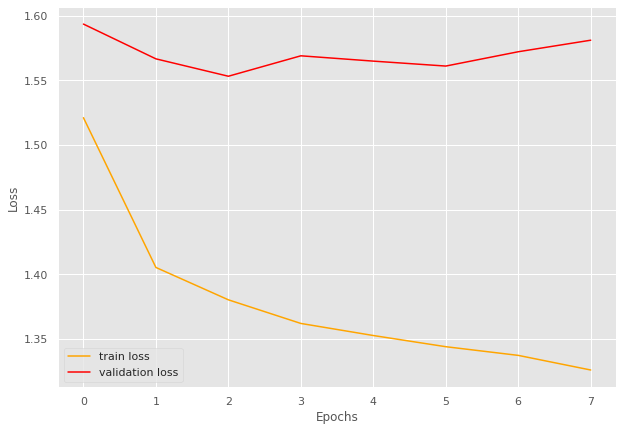

{'0': {'coarse': {'00': 0.8344144759303517, '10': 0.7350631614885627, '20': 0.6717065795249476, '30': 0.587328683607277, '50': 0.4409598595327513, '80': 0.2362093352192362}, 'fine': {'00': {'0': 0.9762140733399405, '1': 0.9764150943396226, '2': 0.9572277227722772, '3': 0.973404255319149, '4': 0.99644128113879, '5': 0.9815242494226328, '7': 0.9389619883040936, '8': 0.9871175523349437, '9': 0.8673469387755102, '11': 0.9451642060861706, '12': 0.9523012552301255, '14': 0.9555808656036446, '15': 0.9640077821011673}, '10': {'0': 0.8848780487804878, '1': 0.8422535211267606, '2': 0.8879103282626101, '3': 0.9231638418079096, '4': 0.9256505576208178, '5': 0.906885758998435, '7': 0.8858381502890174, '8': 0.9591503267973857, '9': 0.7749469214437368, '11': 0.8723911747167561, '12': 0.9203319502074688, '14': 0.8818380743982495, '15': 0.8033088235294118}, '20': {'0': 0.8442064264849075, '1': 0.7038567493112947, '2': 0.8205027494108406, '3': 0.8527889591719379, '4': 0.8386075949367089, '5': 0.80940794

100%|██████████| 163/163 [00:59<00:00,  2.76batch/s, loss=1.84]


train loss 1.8390645300683799, validation loss 1.7764538611684526, validation accuracy 0.6799531066822978
Coarse label 9 Epoch 2
-------------------------------


100%|██████████| 163/163 [00:58<00:00,  2.77batch/s, loss=1.75]


train loss 1.7501060092376053, validation loss 1.760182568005153, validation accuracy 0.690504103165299
Coarse label 9 Epoch 3
-------------------------------


100%|██████████| 163/163 [00:58<00:00,  2.77batch/s, loss=1.73]


train loss 1.7274325062160842, validation loss 1.755330775465284, validation accuracy 0.690504103165299
Coarse label 9 Epoch 4
-------------------------------


100%|██████████| 163/163 [00:58<00:00,  2.79batch/s, loss=1.71]


train loss 1.71212208051623, validation loss 1.754465205328805, validation accuracy 0.6928487690504103
Coarse label 9 Epoch 5
-------------------------------


100%|██████████| 163/163 [00:58<00:00,  2.78batch/s, loss=1.7]


train loss 1.7035319717383823, validation loss 1.7516953604561942, validation accuracy 0.7092614302461899
Coarse label 9 Epoch 6
-------------------------------


100%|██████████| 163/163 [00:58<00:00,  2.79batch/s, loss=1.69]


train loss 1.6937177349453323, validation loss 1.7490409101758684, validation accuracy 0.7010550996483002
Coarse label 9 Epoch 7
-------------------------------


100%|██████████| 163/163 [00:58<00:00,  2.77batch/s, loss=1.68]


INFO: Early stopping counter 1 of 5
train loss 1.6822835982211528, validation loss 1.7533965962273734, validation accuracy 0.7045720984759671
Coarse label 9 Epoch 8
-------------------------------


100%|██████████| 163/163 [00:58<00:00,  2.77batch/s, loss=1.67]


INFO: Early stopping counter 2 of 5
train loss 1.6711182455343703, validation loss 1.7574334059442793, validation accuracy 0.6987104337631888
Coarse label 9 Epoch 9
-------------------------------


100%|██████████| 163/163 [00:58<00:00,  2.79batch/s, loss=1.66]


train loss 1.6625936850448328, validation loss 1.7468028153691972, validation accuracy 0.7069167643610785
Coarse label 9 Epoch 10
-------------------------------


100%|██████████| 163/163 [00:58<00:00,  2.76batch/s, loss=1.65]


INFO: Early stopping counter 3 of 5
train loss 1.6545719800551244, validation loss 1.75039941072464, validation accuracy 0.7080890973036342
Coarse label 9 Epoch 11
-------------------------------


100%|██████████| 163/163 [00:58<00:00,  2.78batch/s, loss=1.65]


train loss 1.6510717525072625, validation loss 1.7462732451302665, validation accuracy 0.7080890973036342
Coarse label 9 Epoch 12
-------------------------------


100%|██████████| 163/163 [00:58<00:00,  2.77batch/s, loss=1.65]


INFO: Early stopping counter 4 of 5
train loss 1.6462170119665882, validation loss 1.7478524105889457, validation accuracy 0.7010550996483002
Coarse label 9 Epoch 13
-------------------------------


100%|██████████| 163/163 [00:58<00:00,  2.78batch/s, loss=1.64]


INFO: Early stopping counter 5 of 5
INFO: Early stopping
Done! Saved model with test accuracy 0.7030185004868549 and loss 1.7582504171313662


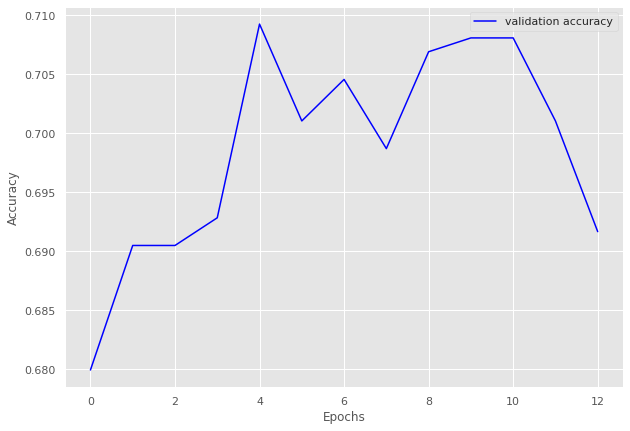

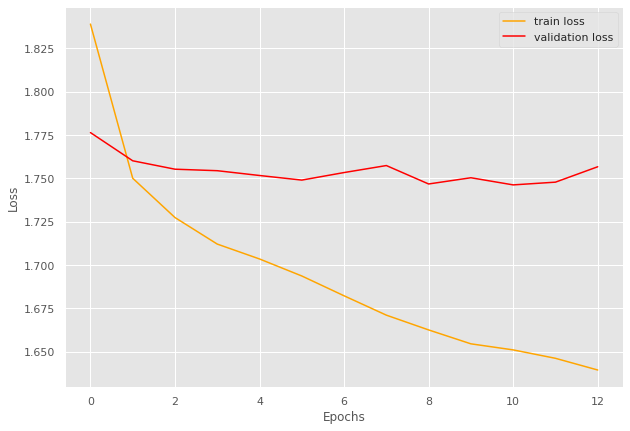

{'0': {'coarse': {'00': 0.8344144759303517, '10': 0.7350631614885627, '20': 0.6717065795249476, '30': 0.587328683607277, '50': 0.4409598595327513, '80': 0.2362093352192362}, 'fine': {'00': {'0': 0.9762140733399405, '1': 0.9764150943396226, '2': 0.9572277227722772, '3': 0.973404255319149, '4': 0.99644128113879, '5': 0.9815242494226328, '7': 0.9389619883040936, '8': 0.9871175523349437, '9': 0.8673469387755102, '11': 0.9451642060861706, '12': 0.9523012552301255, '14': 0.9555808656036446, '15': 0.9640077821011673}, '10': {'0': 0.8848780487804878, '1': 0.8422535211267606, '2': 0.8879103282626101, '3': 0.9231638418079096, '4': 0.9256505576208178, '5': 0.906885758998435, '7': 0.8858381502890174, '8': 0.9591503267973857, '9': 0.7749469214437368, '11': 0.8723911747167561, '12': 0.9203319502074688, '14': 0.8818380743982495, '15': 0.8033088235294118}, '20': {'0': 0.8442064264849075, '1': 0.7038567493112947, '2': 0.8205027494108406, '3': 0.8527889591719379, '4': 0.8386075949367089, '5': 0.80940794

100%|██████████| 73/73 [00:26<00:00,  2.74batch/s, loss=0.999]


train loss 0.9989546496574193, validation loss 0.8997195735573769, validation accuracy 0.8340425531914893
Coarse label 11 Epoch 2
-------------------------------


100%|██████████| 73/73 [00:26<00:00,  2.80batch/s, loss=0.913]


INFO: Early stopping counter 1 of 5
train loss 0.9133617510534313, validation loss 0.9113965258002281, validation accuracy 0.825531914893617
Coarse label 11 Epoch 3
-------------------------------


100%|██████████| 73/73 [00:26<00:00,  2.72batch/s, loss=0.886]


INFO: Early stopping counter 2 of 5
train loss 0.8856107119011553, validation loss 0.9117591753602028, validation accuracy 0.823404255319149
Coarse label 11 Epoch 4
-------------------------------


100%|██████████| 73/73 [00:26<00:00,  2.80batch/s, loss=0.867]


INFO: Early stopping counter 3 of 5
train loss 0.8669369588159535, validation loss 0.9082022309303284, validation accuracy 0.8361702127659575
Coarse label 11 Epoch 5
-------------------------------


100%|██████████| 73/73 [00:26<00:00,  2.80batch/s, loss=0.852]


INFO: Early stopping counter 4 of 5
train loss 0.8520540521569449, validation loss 0.9180859103798866, validation accuracy 0.823404255319149
Coarse label 11 Epoch 6
-------------------------------


100%|██████████| 73/73 [00:25<00:00,  2.83batch/s, loss=0.841]


INFO: Early stopping counter 5 of 5
INFO: Early stopping
Done! Saved model with test accuracy 0.776431718061674 and loss 0.993088432153066


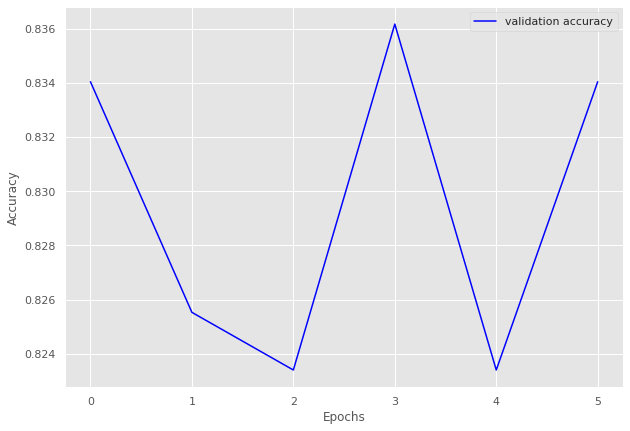

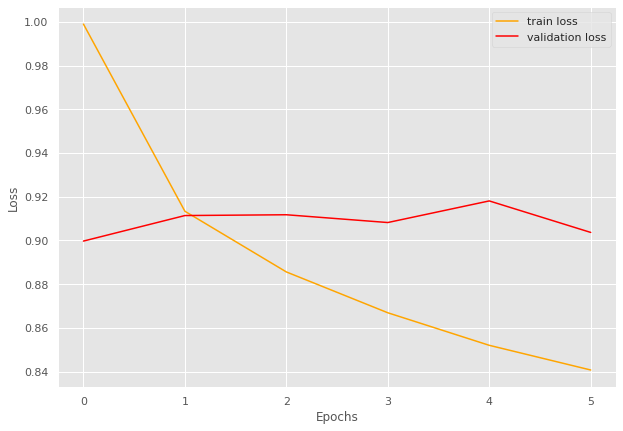

{'0': {'coarse': {'00': 0.8344144759303517, '10': 0.7350631614885627, '20': 0.6717065795249476, '30': 0.587328683607277, '50': 0.4409598595327513, '80': 0.2362093352192362}, 'fine': {'00': {'0': 0.9762140733399405, '1': 0.9764150943396226, '2': 0.9572277227722772, '3': 0.973404255319149, '4': 0.99644128113879, '5': 0.9815242494226328, '7': 0.9389619883040936, '8': 0.9871175523349437, '9': 0.8673469387755102, '11': 0.9451642060861706, '12': 0.9523012552301255, '14': 0.9555808656036446, '15': 0.9640077821011673}, '10': {'0': 0.8848780487804878, '1': 0.8422535211267606, '2': 0.8879103282626101, '3': 0.9231638418079096, '4': 0.9256505576208178, '5': 0.906885758998435, '7': 0.8858381502890174, '8': 0.9591503267973857, '9': 0.7749469214437368, '11': 0.8723911747167561, '12': 0.9203319502074688, '14': 0.8818380743982495, '15': 0.8033088235294118}, '20': {'0': 0.8442064264849075, '1': 0.7038567493112947, '2': 0.8205027494108406, '3': 0.8527889591719379, '4': 0.8386075949367089, '5': 0.80940794

100%|██████████| 80/80 [00:28<00:00,  2.77batch/s, loss=1.47]


train loss 1.469838310778141, validation loss 1.3795103430747986, validation accuracy 0.668859649122807
Coarse label 12 Epoch 2
-------------------------------


100%|██████████| 80/80 [00:28<00:00,  2.78batch/s, loss=1.34]


INFO: Early stopping counter 1 of 5
train loss 1.343196551501751, validation loss 1.4007635563611984, validation accuracy 0.6666666666666666
Coarse label 12 Epoch 3
-------------------------------


100%|██████████| 80/80 [00:28<00:00,  2.79batch/s, loss=1.28]


train loss 1.282742914557457, validation loss 1.3660851418972015, validation accuracy 0.6754385964912281
Coarse label 12 Epoch 4
-------------------------------


100%|██████████| 80/80 [00:28<00:00,  2.78batch/s, loss=1.25]


INFO: Early stopping counter 2 of 5
train loss 1.250823226571083, validation loss 1.3719351142644882, validation accuracy 0.6776315789473685
Coarse label 12 Epoch 5
-------------------------------


100%|██████████| 80/80 [00:28<00:00,  2.78batch/s, loss=1.23]


INFO: Early stopping counter 3 of 5
train loss 1.2327426746487617, validation loss 1.388046145439148, validation accuracy 0.668859649122807
Coarse label 12 Epoch 6
-------------------------------


100%|██████████| 80/80 [00:28<00:00,  2.78batch/s, loss=1.22]


INFO: Early stopping counter 4 of 5
train loss 1.2196151569485665, validation loss 1.3846903145313263, validation accuracy 0.6622807017543859
Coarse label 12 Epoch 7
-------------------------------


100%|██████████| 80/80 [00:28<00:00,  2.78batch/s, loss=1.2] 


INFO: Early stopping counter 5 of 5
INFO: Early stopping
Done! Saved model with test accuracy 0.6458132820019249 and loss 1.3910335232229794


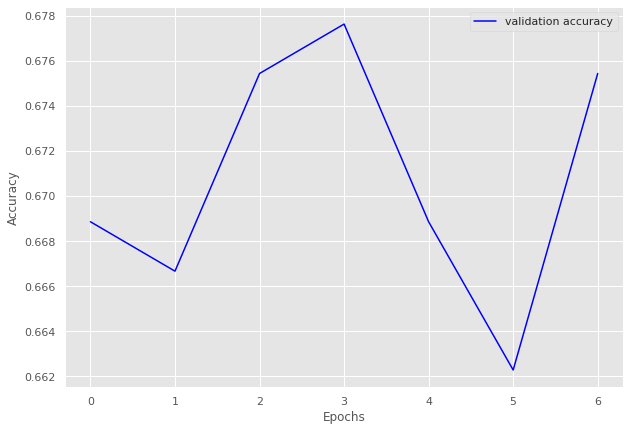

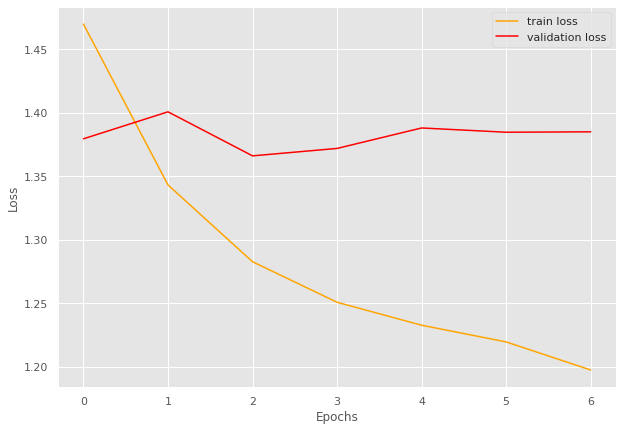

{'0': {'coarse': {'00': 0.8344144759303517, '10': 0.7350631614885627, '20': 0.6717065795249476, '30': 0.587328683607277, '50': 0.4409598595327513, '80': 0.2362093352192362}, 'fine': {'00': {'0': 0.9762140733399405, '1': 0.9764150943396226, '2': 0.9572277227722772, '3': 0.973404255319149, '4': 0.99644128113879, '5': 0.9815242494226328, '7': 0.9389619883040936, '8': 0.9871175523349437, '9': 0.8673469387755102, '11': 0.9451642060861706, '12': 0.9523012552301255, '14': 0.9555808656036446, '15': 0.9640077821011673}, '10': {'0': 0.8848780487804878, '1': 0.8422535211267606, '2': 0.8879103282626101, '3': 0.9231638418079096, '4': 0.9256505576208178, '5': 0.906885758998435, '7': 0.8858381502890174, '8': 0.9591503267973857, '9': 0.7749469214437368, '11': 0.8723911747167561, '12': 0.9203319502074688, '14': 0.8818380743982495, '15': 0.8033088235294118}, '20': {'0': 0.8442064264849075, '1': 0.7038567493112947, '2': 0.8205027494108406, '3': 0.8527889591719379, '4': 0.8386075949367089, '5': 0.80940794

100%|██████████| 61/61 [00:22<00:00,  2.75batch/s, loss=0.783]


train loss 0.7827469559966541, validation loss 0.7938462644815445, validation accuracy 0.7510204081632653
Coarse label 13 Epoch 2
-------------------------------


100%|██████████| 61/61 [00:31<00:00,  1.96batch/s, loss=0.7]  


train loss 0.7001180756287496, validation loss 0.7883321642875671, validation accuracy 0.763265306122449
Coarse label 13 Epoch 3
-------------------------------


100%|██████████| 61/61 [00:42<00:00,  1.42batch/s, loss=0.665]


INFO: Early stopping counter 1 of 5
train loss 0.6653274991473214, validation loss 0.7952818870544434, validation accuracy 0.7551020408163265
Coarse label 13 Epoch 4
-------------------------------


100%|██████████| 61/61 [00:48<00:00,  1.25batch/s, loss=0.645]


INFO: Early stopping counter 2 of 5
train loss 0.6454128593694969, validation loss 0.7981258481740952, validation accuracy 0.7510204081632653
Coarse label 13 Epoch 5
-------------------------------


100%|██████████| 61/61 [00:47<00:00,  1.28batch/s, loss=0.634]


INFO: Early stopping counter 3 of 5
train loss 0.6338510005200495, validation loss 0.8074983954429626, validation accuracy 0.7306122448979592
Coarse label 13 Epoch 6
-------------------------------


100%|██████████| 61/61 [00:49<00:00,  1.24batch/s, loss=0.623]


train loss 0.6226677210604559, validation loss 0.780336394906044, validation accuracy 0.7673469387755102
Coarse label 13 Epoch 7
-------------------------------


100%|██████████| 61/61 [00:22<00:00,  2.76batch/s, loss=0.615]


INFO: Early stopping counter 4 of 5
train loss 0.6154759985501649, validation loss 0.7919970154762268, validation accuracy 0.7551020408163265
Coarse label 13 Epoch 8
-------------------------------


100%|██████████| 61/61 [00:22<00:00,  2.77batch/s, loss=0.617]


INFO: Early stopping counter 5 of 5
INFO: Early stopping
Done! Saved model with test accuracy 0.8029100529100529 and loss 0.7423041810592016


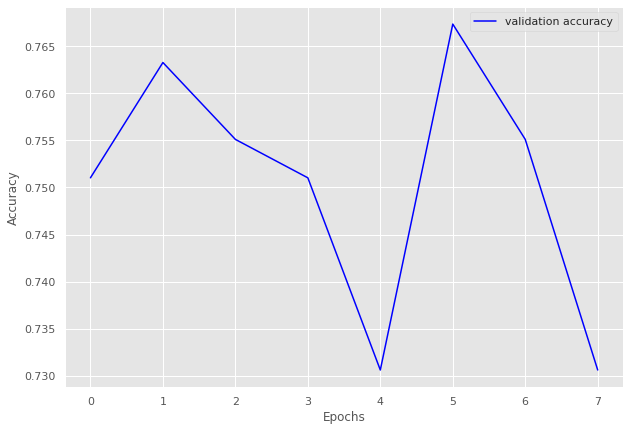

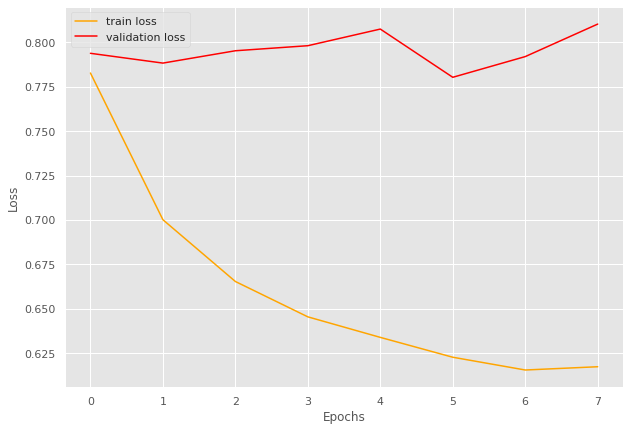

{'0': {'coarse': {'00': 0.8344144759303517, '10': 0.7350631614885627, '20': 0.6717065795249476, '30': 0.587328683607277, '50': 0.4409598595327513, '80': 0.2362093352192362}, 'fine': {'00': {'0': 0.9762140733399405, '1': 0.9764150943396226, '2': 0.9572277227722772, '3': 0.973404255319149, '4': 0.99644128113879, '5': 0.9815242494226328, '7': 0.9389619883040936, '8': 0.9871175523349437, '9': 0.8673469387755102, '11': 0.9451642060861706, '12': 0.9523012552301255, '14': 0.9555808656036446, '15': 0.9640077821011673}, '10': {'0': 0.8848780487804878, '1': 0.8422535211267606, '2': 0.8879103282626101, '3': 0.9231638418079096, '4': 0.9256505576208178, '5': 0.906885758998435, '7': 0.8858381502890174, '8': 0.9591503267973857, '9': 0.7749469214437368, '11': 0.8723911747167561, '12': 0.9203319502074688, '14': 0.8818380743982495, '15': 0.8033088235294118}, '20': {'0': 0.8442064264849075, '1': 0.7038567493112947, '2': 0.8205027494108406, '3': 0.8527889591719379, '4': 0.8386075949367089, '5': 0.80940794

100%|██████████| 137/137 [00:48<00:00,  2.80batch/s, loss=1.3] 


train loss 1.301548119879117, validation loss 1.2711909294128418, validation accuracy 0.7654723127035831
Coarse label 14 Epoch 2
-------------------------------


100%|██████████| 137/137 [00:49<00:00,  2.78batch/s, loss=1.23]


INFO: Early stopping counter 1 of 5
train loss 1.2309764380002544, validation loss 1.274156665802002, validation accuracy 0.760586319218241
Coarse label 14 Epoch 3
-------------------------------


100%|██████████| 137/137 [00:49<00:00,  2.77batch/s, loss=1.21]


INFO: Early stopping counter 2 of 5
train loss 1.2095008575133164, validation loss 1.271283006668091, validation accuracy 0.7671009771986971
Coarse label 14 Epoch 4
-------------------------------


100%|██████████| 137/137 [00:49<00:00,  2.80batch/s, loss=1.19]


train loss 1.1941595382063928, validation loss 1.2661498069763184, validation accuracy 0.7752442996742671
Coarse label 14 Epoch 5
-------------------------------


100%|██████████| 137/137 [00:49<00:00,  2.78batch/s, loss=1.2] 


train loss 1.1952906890507162, validation loss 1.253585112094879, validation accuracy 0.7882736156351792
Coarse label 14 Epoch 6
-------------------------------


100%|██████████| 137/137 [00:49<00:00,  2.78batch/s, loss=1.18]


INFO: Early stopping counter 3 of 5
train loss 1.1849221252176882, validation loss 1.257980501651764, validation accuracy 0.7801302931596091
Coarse label 14 Epoch 7
-------------------------------


 97%|█████████▋| 133/137 [00:47<00:01,  2.81batch/s, loss=1.17]

In [ ]:
for run, seed in enumerate(seeds):
    print('Starting run %s' %run)
    #set manual seed
    torch.manual_seed(seed)
    np.random.seed(seed)

    accuracies['%s' %run] = {'coarse':{}, 'fine':{}, 'whole':{}}

    #load clusters data
    tasksim_clusters = pickle.load(open(teamdrive_root +'icons_experiment/generated_clusters/rf_tasksim_clusters_00_%s.p' %run, 'rb'))
    fine_to_coarse, coarse_to_fine = create_label_dictionaries(tasksim_clusters)
    print(coarse_to_fine)

    number_of_clusters = len(coarse_to_fine.keys())
    stacked_fine_labels = []
    for i in range(0, number_of_clusters):
        stacked_fine_labels +=coarse_to_fine[i]

    for label_noise in label_noises:
        label_noise_str = '00' if label_noise==0.0 else str(int(label_noise*100))
        print('Calculating for label_noise %s' %label_noise_str)

        #prepare data
        main_df = df[df['split_%s_%s' %(label_noise_str, run)] == "main"]
        test_df = df[df['split_%s_%s' %(label_noise_str, run)] == "test"]
        valid_df, train_df  = split_data(main_df, p=0.10)
        print('split_%s_%s' %(label_noise_str, run))

        # prepare dataloaders
        batch_size = 64

        test_dataset = IconDataset(test_df, test_transform, "", run, label_noise_str)
        train_dataset = IconDataset(train_df, train_transform, "", run, label_noise_str)
        validation_dataset = IconDataset(valid_df, test_transform, "", run, label_noise_str)

        dl_train = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
        dl_test = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
        dl_valid = DataLoader(validation_dataset, batch_size=batch_size, shuffle=False)

        # train coarse model 

        print('Start training a coarse model')
        gc.collect() 
        torch.cuda.empty_cache()
        epochs= 40

        model = Resnext50(number_of_clusters, name="coarse_model_Resnext50_icons_%s_%s" %(label_noise_str, run))
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
        model.state_dict(torch.load(fine_tuned_model_path))
        model.to(device)
        loss_fn = torch.nn.CrossEntropyLoss().to(device)

        test_accuracy =train_and_validate(epochs, model, loss_fn, optimizer, 
                                                            dl_train, dl_test, dl_valid,
                                                            mode="coarse", fine_to_coarse=fine_to_coarse,
                                                            model_path = teamdrive_root+'models/hierarchical/%s.pth' %model.name )
        accuracies['%s' %run]['coarse']['%s' %label_noise_str] = test_accuracy
        print(accuracies)
        with open(teamdrive_root + 'icons_experiment/not_noisy_hierarchical_accuracies.p', 'wb') as handle:
            pickle.dump(accuracies, handle)
        print("Done training of a coarse model with test accuracy %s" %test_accuracy)

        #fine clusters training
        accuracies['%s' %run]['fine']['%s' % label_noise_str] = {}
        for coarse_label in range(0, number_of_clusters):
            if len(coarse_to_fine[coarse_label])>1:
                gc.collect() 
                torch.cuda.empty_cache()
                dl_train, dl_valid, dl_test =  filter_data(train_dataset, test_dataset, validation_dataset, filter_by_coarse=True,
                                                 coarse_label=coarse_label, coarse_to_fine=coarse_to_fine, batch_size=batch_size)

                # Initialize the model
                model = Resnext50(len(coarse_to_fine[coarse_label]),name="fine_model_coarse_label_%s_icons_%s_%s" %(coarse_label,label_noise_str, run))
                optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
                model.state_dict(torch.load(fine_tuned_model_path))
                model.to(device)
                loss_fn = torch.nn.CrossEntropyLoss().to(device)
                test_accuracy =train_and_validate(epochs, model, loss_fn, optimizer,
                                                  dl_train, dl_test, dl_valid, 
                                                  mode="fine", coarse_label=coarse_label,
                                                  lookup=coarse_to_fine[coarse_label],
                                                  model_path = teamdrive_root+'models/hierarchical/%s.pth' %model.name )
                accuracies['%s' %run]['fine']['%s' %label_noise_str]['%s' %coarse_label] = test_accuracy
                print(accuracies)
                with open(teamdrive_root + 'icons_experiment/not_noisy_hierarchical_accuracies.p', 'wb') as handle:
                    pickle.dump(accuracies, handle)
                print("Done training of a fine model with test accuracy %s" %test_accuracy)

        #whole model evaluation
        print('Starting model evaluation...')
        dl_test = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

        #loading models
        gc.collect() 
        torch.cuda.empty_cache()
        model_coarse = torch.load(teamdrive_root+'models/hierarchical/coarse_model_Resnext50_icons_%s_%s.pth' %(label_noise_str, run))
#         model_coarse = Resnext50(number_of_clusters, name="coarse_model_Resnext50_icons_%s_%s" %(label_noise_str, run))
#         model_coarse.state_dict(torch.load(teamdrive_root+'models/hierarchical/%s.pth' %model_coarse.name ))
        fine_models = {}
        for i in range(0,number_of_clusters):
            if len(coarse_to_fine[i])>1:
#                 fine_model = Resnext50(len(coarse_to_fine[i]),name="fine_model_coarse_label_%s_icons_%s_%s" %(i,label_noise_str, run))
#                 fine_model.state_dict(torch.load(teamdrive_root+'models/hierarchical/%s.pth' %fine_model.name ))
                fine_models['fine_model_' + str(i)] = torch.load(teamdrive_root+'models/hierarchical/fine_model_coarse_label_%s_icons_%s_%s.pth' %(i,label_noise_str, run))

        coarse_predicts = []
        targets = []
        model_coarse.to(device)
        model_coarse.eval()
        for counter, (images, labels) in enumerate(dl_test):
            imageGPU = images.to(device)
            outputs = torch.Tensor.cpu(model_coarse(imageGPU))
            coarse_predicts.append(outputs.detach().numpy())
            targets.append(labels)
        targets = np.hstack(targets)  


        #reformat coarse prediction
        coarse_prediction = np.vstack(coarse_predicts)
        print(coarse_prediction)

        column_num = 0
        for i in range(0, number_of_clusters):
            cluster_len = len(coarse_to_fine[i])
            for rep in range(cluster_len-1):
                coarse_prediction = np.insert(coarse_prediction, column_num, coarse_prediction[:,column_num], axis=1)
            column_num +=cluster_len
        #print(coarse_prediction)
        fine_prediction= []

        for i in range(0,number_of_clusters):
            gc.collect() 
            torch.cuda.empty_cache()
            if len(coarse_to_fine[i]) == 1:
                fine_prediction.append(np.ones((len(coarse_prediction),1)))
            else:
                predicts = []
                print("Evaluating fine model %s" %i)
                fine_model = fine_models['fine_model_%s' %i]
                fine_model.to(device)
                fine_model.eval()
                for counter, (images, labels) in enumerate(dl_test):
                    imageGPU = images.to(device)
                    outputs = torch.Tensor.cpu(fine_model(imageGPU))
                    predicts.append(outputs.detach().numpy())   
                predicts = np.vstack(predicts)
                fine_prediction.append(predicts)                          

        #reformat fine_prediction
        fine_prediction = np.hstack(fine_prediction)
        result = np.multiply(fine_prediction, coarse_prediction)
        result = np.argmax(result, axis=1)
        result_decoded = [stacked_fine_labels[i] for i in result]   
        final_acc = accuracy_score(targets, result_decoded) 
        print("overall accuracy  is %s" %final_acc)
        accuracies['%s' %run]['whole']['%s' %label_noise_str] = final_acc
        print(accuracies)
        with open(teamdrive_root + 'icons_experiment/not_noisy_hierarchical_accuracies.p', 'wb') as handle:
            pickle.dump(accuracies, handle)




In [22]:
clusters_df = pd.DataFrame()
for run in range(5):
    clusters_df['run_%s' %run] = pickle.load(open(teamdrive_root +'icons_experiment/generated_clusters/rf_tasksim_clusters_00_%s.p' %run, 'rb'))

In [23]:
clusters_df

run_0  run_1  run_2  run_3  run_4
0      10     10     10     10     17
1       0      0     15     15      0
2       9      6     12      6      5
3      11      2     17     14      3
4      11      4      5     11     18
..    ...    ...    ...    ...    ...
89      3     13     14     14     13
90      3     13     14     19     13
91      9     14     12     18     16
92      5      9      9      9     18
93     15      5      9      1     11

[94 rows x 5 columns]

In [24]:
clusters_df.to_csv(teamdrive_root +'icons_experiment/no_noise_clusters.csv')